In [38]:
from scipy import linalg  #scipy.linalg needed to solve generalised eigenvalue problem
import math as m
import numpy as np   #numpy package contains various numerical routines
import os
import copy as copy
import time
import sys as sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import itertools
import warnings    #turn off warnings (these can occur in contour plots if plot plane is a node)
warnings.simplefilter("ignore")

#some defaults
localtime = time.asctime( time.localtime(time.time()) )
A0=0.52917721092;dist_cutoff=6.0/A0;WH=1.75;
no_symmetry=False;separate_symmetry=True;plt.close("all");


##Parameters for various standard calculations

#these are Hoffmann's parameters - appropriate for molecular calculations but will lead to convergence issues
#if used in the solid state
#note the tuple (exponent,coefficient) as the last entry. For s and p this is redundant for Hoffmann parameters
#as coefficient is always 1, but it is in place here to be compatible with Cerda's parameters where the
#p orbitals are sometimes double zeta as well as d.
Hoffmann={1:[1,0,-13.6,(1.3,1.)],                                           #H
       2:[2,0,-23.4,(1.688,1.)],                                              #He
       3:[[2,0,-5.4,(0.650,1.)],[2,1,-3.5,(0.65,1.)]],                             #Li
       4:[[2,0,-10.0,(0.975,1.)],[2,1,-6.0,(0.975,1.)]],                           #Be
       5:[[2,0,-15.2,(1.300,1.)],[2,1,-8.5,(1.300,1.)]],                           #B
       6:[[2,0,-21.4,(1.625,1.)],[2,1,-11.4,(1.625,1.)]],                          #C
       7:[[2,0,-26.0,(2.140,1.)],[2,1,-13.4,(1.950,1.)]],                          #N
       8:[[2,0,-32.3,(2.275,1.)],[2,1,-14.8,(2.275,1.)]],                          #O
       9:[[2,0,-40.0,(2.425,1.)],[2,1,-18.1,(2.425,1.)]],                          #F
       10:[[2,0,-43.2,(2.879,1.)],[2,1,-20.0,(2.879,1.)]],                         #Ne
       11:[[3,0,-5.1,(0.733,1.)],[3,1,-3.0,(0.733,1.)]],                           #Na
       12:[[3,0,-9.0,(1.100,1.)],[3,1,-4.5,(1.100,1.)]],                           #Mg
       13:[[3,0,-12.3,(1.167,1.)],[3,1,-6.5,(1.167,1.)]],                          #Al
       14:[[3,0,-17.3,(1.383,1.)],[3,1,-9.2,(1.383,1.)]],                          #Si
       15:[[3,0,-18.6,(1.750,1.)],[3,1,-14.0,(1.600,1.)]],                         #P
       16:[[3,0,-20.0,(2.122,1.)],[3,1,-13.3,(1.827,1.)]],                         #S
       17:[[3,0,-26.3,(2.183,1.)],[3,1,-14.2,(1.733,1.)]],                         #Cl
       18:[[3,0,-27.63,(2.585,1.)],[3,1,-15.76,(2.255,1.)]],                       #Ar
       19:[[4,0,-4.34,(0.874,1.)],[4,1,-2.73,(0.874,1.)]],                         #K
       20:[[4,0,-7.0,(1.2,1.)],[4,1,-4.0,(1.2,1.)]],                               #Ca
       21:[[4,0,-8.87,(1.3,1.)],[4,1,-2.75,(1.3,1.)],[3,2,-8.51,((4.35,0.422783),(1.70,0.72757))]],            #Sc 3d
       22:[[4,0,-8.97,(1.075,1.)],[4,1,-5.44,(0.675,1.)],[3,2,-10.81,((4.55,0.420607),(1.40,0.783913))]],       #Ti 3d
       23:[[4,0,-8.81,(1.3,1.)],[4,1,-5.52,(1.30,1.)],[3,2,-11.00,((4.75,0.475509),(1.70,0.705213))]],     #     #V 3d
       24:[[4,0,-8.66,(1.7,1.)],[4,1,-5.24,(1.7,1.)],[3,2,-11.22,((4.95,0.505792),(1.80,0.674723))]],           #Cr 3d
       25:[[4,0,-9.75,(1.8,1.)],[4,1,-5.89,(1.80,1.)],[3,2,-11.67,((5.15,0.513906),(1.70,0.692909))]],          #Mn 3d
       26:[[4,0,-9.10,(1.9,1.)],[4,1,-5.32,(1.90,1.)],[3,2,-12.60,((5.35,0.5505),(2.00,0.626))]],         #Fe 3d
       27:[[4,0,-9.21,(2.00,1.)],[4,1,-5.29,(2.00,1.)],[3,2,-13.18,((5.55,0.567865),(2.10,0.605856))]],         #Co 3d
       28:[[4,0,-9.17,(1.825,1.)],[4,1,-5.15,(1.125,1.)],[3,2,-13.49,((5.75,0.549306),(2.30,0.60817))]],        #Ni 3d
       29:[[4,0,-11.40,(2.20,1.)],[4,1,-6.06,(2.20,1.)],[3,2,-14.00,((5.95,0.593322),(2.30,0.574421))]],        #Cu 3d
       30:[[4,0,-12.96,(2.37,1.)],[4,1,-9.23,(1.63,0.42)],[3,2,-18.03,((3.565,0.87781),(2.01,0.1554))]],                          #Zn 4p
       31:[[4,0,-14.58,(1.77,1.)],[4,1,-6.75,(1.55,1.)]],                          #Ga 4p
       32:[[4,0,-16.00,(2.16,1.)],[4,1,-9.00,(1.85,1.)]],                          #Ge 4p
       33:[[4,0,-16.22,(2.23,1.)],[4,1,-12.16,(1.89,1.)]],                         #As 4p
       34:[[4,0,-20.50,(2.44,1.)],[4,1,-14.40,(2.07,1.)]],                         #Se 4p
       35:[[4,0,-22.07,(2.588,1.)],[4,1,-13.10,(2.131,1.)]],                       #Br 4p
       36:[[4,0,-24.36,(2.829,1.)],[4,1,-13.99,(2.442,1.)]],                       #Kr 4p
       37:[[5,0,-4.180,(0.997,1.)],[5,1,-2.60,(0.997,1.)]],                        #Rb 5s
       38:[[5,0,-6.620,(1.214,1.)],[5,1,-3.92,(1.214,1.)]],                        #Sr 5s
       39:[[5,0,-5.337,(1.279,1.)],[5,1,-3.515,(1.079,1.)],[4,2,-6.799,((2.554,0.601963),(1.068,0.577964))]],          #Y  4d  Muller (nb energies rather diff from Hoffman)
       40:[[5,0,-9.87,(1.817,1.)],[5,1,-6.76,(1.776,1.)],[4,2,-11.18,((3.835,0.622416),(1.505,0.578216))]],      #Zr 4d
       41:[[5,0,-10.10,(1.890,1.)],[5,1,-6.86,(1.85,1.)],[4,2,-12.10,((4.08,0.640101),(1.64,0.551601))]],
       42:[[5,0,-8.340,(1.96,1.)],[5,1,-5.24,(1.90,1.)],[4,2,-10.50,((4.54,0.589879),(1.9,0.589879))]],        #Mo 4d
       43:[[5,0,-10.07,(2.018,1.)],[5,1,-5.40,(1.984,1.)],[4,2,-12.82,((4.9,0.5715),(2.094,0.6012))]],      #Tc 4d
       44:[[5,0,-10.40,(2.08,1.)],[5,1,-6.87,(2.04,1.)],[4,2,-14.90,((5.38,0.534242),(2.3,0.636789))]],        #Ru 4d
       45:[[5,0,-8.090,(2.135,1.)],[5,1,-4.57,(2.10,1.)],[4,2,-12.50,((4.29,0.580698),(1.97,0.568498))]],       #Rh 4d
       46:[[5,0,-7.320,(2.19,1.)],[5,1,-3.75,(2.152,1.)],[4,2,-12.02,((5.983,0.526436),(2.613,0.637334))]],      #Pd 4d
       47:[[5,0,-7.054,(1.662,1.)],[5,1,-4.133,(1.397,1.)],[4,2,-19.24,((3.912,0.824441),(1.545,0.328777))]],    #Ag 4d  taken from Muller parameterisation in ATK
       48:[[5,0,-7.242,(1.706,1.)],[5,1,-4.196,(1.432,1.)],[4,2,-20.78,((4.094,0.823957),(1.64,0.324983))]],      #Cd  Muller                                               #Cd 4d
       78:[[6,0,-9.077,(2.554,1.)],[6,1,-5.475,(2.554,1.)],[5,2,-12.59,((6.013,0.633378),(2.696,0.551281))]],
       79:[[6,0,-10.92,(2.6020,1.)],[6,1,-5.50,(2.5040,1.)],[5,2,-15.07,((6.163,0.644177),(2.794,0.535576))]],   #nb p exponent slightly different from literature to avoid singularities in linear chain
       179:[6,0,-10.92,(2.6020,1.)], #special Au 6s only for electrodes
       }

#Cerda's parameters specifically for solid state
#Accurate and transferable EHT tight binding parameters, PRB, 2000, 61, 7965. J Cerda and F. Soria
#(only available for the TMs and selected main group). Otherwise I have used the Hoffmann parameters
#note that coefficients < 1.0 for some of the s and p states even though there is only one component.
#This is justified because they are in fact 'double zeta' in character even though only one component is given.
#However the other (more contracted) component makes no contribution to diatomic overlap as it is too contracted,
#so its coefficient is in any case irrelevant. So it is ignored here.

Cerda={1:[1,0,-17.84,(0.87223,0.50494)],                                           #H
       2:[2,0,-23.4,(1.688,1.)],                                              #He
       3:[[2,0,-5.4,(0.650,1.)],[2,1,-3.5,(0.65,1.)]],                             #Li
       4:[[2,0,-10.0,(0.975,1.)],[2,1,-6.0,(0.975,1.)]],                           #Be
       5:[[2,0,-21.7174,(1.60645,0.66811)],[2,1,-14.1676,(1.63627,0.99022)]],                           #B                          #C
       6:[[2,0,-19.8892,(2.0249,0.76422)],[2,1,-13.08,((2.17687,0.7389),(1.269,0.177))]],
       7:[[2,0,-26.4216,(2.74251,1.)],[2,1,-17.0156,(2.26145,1.)]],                          #N
       8:[[2,0,-27.06782,(2.56634,1.)],[2,1,-13.25162,(2.0,1.)]],                          #O
       9:[[2,0,-40.0,(2.425,1.)],[2,1,-18.1,(2.425,1.)]],                          #F
       10:[[2,0,-43.2,(2.879,1.)],[2,1,-20.0,(2.879,1.)]],                         #Ne
       11:[[3,0,-5.1,(1.40,0.7)],[3,1,-3.0,(1.15,0.75)]],                           #Na
       12:[[3,0,-9.0,(1.50,0.7)],[3,1,-4.5,(1.20,0.75)]],                           #Mg
       13:[[3,0,-13.133,(1.657,0.749)],[3,1,-8.525,((1.312,0.750),(4.679,0.492))]], #Al #,[3,2,-5.141,((4.245,0.717),(0.860,0.609))]],                         #Al
       #14:[[3,0,-18.137,(1.864,0.720)],[3,1,-11.277,((1.813,0.705),(1.470,0.303))],[3,2,-5.336,((1.705,0.485),(0.675,0.671))]],
       14:[[3,0,-18.029,(1.780,0.657)],[3,1,-11.820,(1.614,0.818)]],                       #Si
       15:[[3,0,-20.24,(2.131,0.769)],[3,1,-12.437,(1.859,0.633)]],#,(2.479,0.384))]],                         #P
       16:[[3,0,-20.0,(2.122,0.8)],[3,1,-13.3,(1.827,0.70)]],                         #S
       17:[[3,0,-26.3,(2.183,1.)],[3,1,-14.2,(1.733,1.)]],                         #Cl
       18:[[3,0,-27.63,(2.585,1.)],[3,1,-15.76,(2.255,1.)]],                       #Ar
       19:[[4,0,-4.34,(0.874,0.65)],[4,1,-2.73,(0.874,0.65)]],                         #K  #changed weights from 1 to 0.65 (K not given in Cerda's tables)
       20:[[4,0,-7.0,(1.2,1.)],[4,1,-4.0,(1.2,1.)]],                               #Ca
       21:[[4,0,-8.419,(1.325,0.575)],[4,1,-5.989,(1.111,0.624)],[3,2,-8.391,((4.172,0.690),(1.332,0.527))]],            #Sc 3d
       22:[[4,0,-7.879,(1.337,0.707)],[4,1,-5.950,(1.135,0.617)],[3,2,-8.943,((4.760,0.695),(1.464,0.532))]],       #Ti 3d
       23:[[4,0,-8.40,(1.37,0.72)],[4,1,-6.1,(1.18,0.620)],[3,2,-9.8,((4.70,0.70),(1.56,0.52))]], #V 3d nb V not given in Cerda's paper - I have interpolated between Ti and Cr
       24:[[4,0,-8.492,(1.426,0.753)],[4,1,-6.269,(1.210,0.632)],[3,2,-10.635,((4.688,0.683),(1.676,0.502))]],           #Cr 3d
       25:[[4,0,-8.906,(1.468,0.725)],[4,1,-6.630,(1.233,0.625)],[3,2,-11.162,((4.534,0.720),(1.683,0.447))]],          #Mn 3d
       26:[[4,0,-8.994,(1.594,0.777)],[4,1,-6.177,(1.315,0.658)],[3,2,-11.323,((4.845,0.730),(1.755,0.442))]],         #Fe 3d
       27:[[4,0,-9.543,(1.561,0.665)],[4,1,-6.685,(1.282,0.616)],[3,2,-11.689,((4.765,0.769),(1.724,0.393))]],         #Co 3d
       28:[[4,0,-9.523,(1.616,0.691)],[4,1,-6.553,(1.307,0.630)],[3,2,-11.744,((5.238,0.785),(1.775,0.392))]],        #Ni 3d
       29:[[4,0,-10.563,(1.704,0.614)],[4,1,-6.78,(1.340,0.648)],[3,2,-12.896,((6.770,0.842),(1.855,0.367))]],        #Cu 3d
       30:[[4,0,-12.96,(2.366,1.)],[4,1,-9.23,(1.63,0.4167)]],                          #Zn 4p
       31:[[4,0,-17.629,(2.041,0.662)],[4,1,-10.766,((5.835,0.596),(1.616,0.705))]],   #Ga 4p
       32:[[4,0,-16.00,(2.16,1.)],[4,1,-9.00,(1.85,1.)]],                          #Ge 4p
       33:[[4,0,-21.764,(2.344,0.634)],[4,1,-12.822,((7.588,0.539),(2.102,0.753))]],                        #As 4p
       34:[[4,0,-20.50,(2.44,1.)],[4,1,-14.40,(2.07,1.)]],                         #Se 4p
       35:[[4,0,-22.07,(2.588,1.)],[4,1,-13.10,(2.131,1.)]],                       #Br 4p
       36:[[4,0,-24.36,(2.829,1.)],[4,1,-13.99,(2.442,1.)]],                       #Kr 4p
       37:[[5,0,-4.180,(0.997,1.)],[5,1,-2.60,(0.997,1.)]],                        #Rb 5s
       38:[[5,0,-7.0,(1.50,0.69)],[5,1,-3.0,(1.16,0.50)]],                        #Sr 5s
       39:[[5,0,-7.8,(1.50,0.69)],[5,1,-3.515,(1.20,0.50)],[4,2,-6.799,((4.20,0.60),(1.60,0.56))]],          #Y  4d  extrapolated from Zr
       40:[[5,0,-8.017,(1.539,0.706)],[5,1,-6.033,(1.263,0.530)],[4,2,-9.022,((4.478,0.622416),(1.646,0.578216))]],      #Zr 4d
       41:[[5,0,-7.768,(1.615,0.772)],[5,1,-5.246,(1.285,0.602)],[4,2,-9.318,((4.335,0.640101),(1.761,0.551601))]],       #Nb 4d
       42:[[5,0,-8.365,(1.662,0.789)],[5,1,-5.666,(1.334,0.638)],[4,2,-10.855,((4.693,0.589879),(1.900,0.589879))]],        #Mo 4d
       43:[[5,0,-8.406,(1.647,0.803)],[5,1,-5.804,(1.365,0.623)],[4,2,-11.386,((4.870,0.5715),(1.962,0.6012))]],      #Tc 4d
       44:[[5,0,-8.953,(1.729,0.769)],[5,1,-5.778,(1.408,0.667)],[4,2,-12.352,((5.500,0.534242),(2.048,0.636789))]],        #Ru 4d
       45:[[5,0,-8.412,(1.697,0.786)],[5,1,-5.854,(1.415,0.638)],[4,2,-12.388,((4.857,0.580698),(2.042,0.568498))]],       #Rh 4d
       46:[[5,0,-8.781,(1.816,0.741)],[5,1,-5.627,(1.452,0.695)],[4,2,-12.346,((6.622,0.526436),(2.120,0.637334))]],      #Pd 4d
       47:[[5,0,-9.925,(1.846,0.589)],[5,1,-6.437,(1.475,0.610)],[4,2,-14.705,((4.907,0.824441),(2.076,0.328777))]],    #Ag 4d
       48:[[5,0,-10.743,(1.703,0.570)],[5,1,-7.779,(1.281,0.508)],[5,2,-6.441,((1.237,0.453),(1.,0.0))]],      #Cd                  #note Cd 5d, not 4d as in Hoffmann params. Need to change core electrons
       74:[[6,0,-10.959,(2.216,0.673)],[6,1,-5.944,(1.642,0.603)],[5,2,-11.337,((5.139,0.665),(2.132,0.546))]],   #Re
       75:[[6,0,-11.013,(2.253,0.723)],[6,1,-6.062,(1.615,0.703)],[5,2,-10.806,((4.926,0.667),(2.194,0.517))]],   #Re
       77:[[6,0,-11.548,(2.252,0.651)],[6,1,-6.650,(1.712,0.631)],[5,2,-13.089,((4.929,0.727),(2.287,0.432))]],   #Ir
       78:[[6,0,-11.851,(2.294,0.625)],[6,1,-6.304,(1.715,0.681)],[5,2,-13.058,((5.327,0.749),(2.318,0.429))]],   #Au
       79:[[6,0,-12.131,(2.309,0.6)],[6,1,-6.760,(1.740,0.622)],[5,2,-14.000,((5.065,0.799),(2.291,0.349))]],   #nb p exponent slightly different from literature to avoid singularities in linear chain
       179:[6,0,-12.131,(2.309,0.6)], #special Au 6s only for electrodes
       }


#these identify a label for an atomic number
atno_to_element={1:"H",2:"He",3:"Li",4:"Be",5:"B",6:"C",7:"N",8:"O",9:"F",10:"Ne",11:"Na",12:"Mg",13:"Al",14:"Si",15:"P",16:"S",17:"Cl",18:"Ar",19:"K",20:"Ca",21:"Sc",22:"Ti",23:"V",\
        24:"Cr",25:"Mn",26:"Fe",27:"Co",28:"Ni",29:"Cu",30:"Zn",31:"Ga",32:"Ge",33:"As",34:"Se",35:"Br",36:"Kr",37:"Rb",38:"Sr",39:"Y",40:"Zr",41:"Nb",42:"Mo",43:"Tc",44:"Ru",45:"Rh",\
        46:"Pd",47:"Ag",48:"Cd",49:"In",50:"Sn",51:"Sb",52:"Te",53:"I",54:"Xe",55:"Cs",56:"Ba",47:"La",58:"Ce",59:"Pr",60:"Nd",61:"Pm",62:"Sm",63:"Eu",64:"Gd",65:"Tb",66:"Dy",67:"Ho",68:"Er",69:"Tm",70:"Yb",\
        71:"Lu",72:"Hf",73:"Ta",74:"W",75:"Re",77:"Ir",78:"Pt",79:"Au",179:"Au",100:"XX"
}
#atom colors taken from jmol  http://jmol.sourceforge.net/jscolors/
atom_colours={1:(255,255,255),2:(217,255,255),3:(204,128,255),4:(194,255,0),5:(255,181,181),6:(144,144,144),7:(48,80,248),8:(255,13,13),9:(144,224,80),10:(179,227,245),\
        11:(171,92,242),12:(138,255,0),13:(191,166,166),14:(240,200,160),15:(255,128,0),16:(255,255,48),17:(31,240,31),18:(128,209,227),19:(143,64,212),20:(61,255,0),\
        21:(230,230,230),22:(191,194,199),23:(166,166,171),24:(138,153,199),25:(156,122,199),\
        26:(224,102,51),27:(240,144,160),28:(80,208,80),29:(200,128,51),30:(125,128,176),\
        31:(194,143,143),32:(102,143,143),33:(189,128,227),34:(255,161,0),35:(166,41,41),\
        36:(92,184,209),37:(112,46,176),38:(0,255,0),39:(148,255,255),40:(148,224,224),\
        41:(115,194,201),42:(84,181,181),43:(59,158,158),44:(36,143,143),45:(10,125,140),\
        46:(0,105,133),47:(192,192,192),48:(255,217,143),\
        49:(166,117,115),50:(102,128,128),51:(158,99,181),52:(212,122,0),53:(148,0,148),\
        54:(66,158,176),55:(87,23,143),56:(0,201,0),57:(112,212,255),\
        58:(255,255,199),59:(217,255,199),60:(199,255,199),61:(163,255,199),\
        62:(143,255,199),63:(97,255,199),64:(69,255,199),65:(48,255,199),66:(31,255,199),\
        67:(0,255,156),68:(0,230,117),69:(0,212,82),70:(0,191,56),71:(0,171,36),\
        72:(77,194,255),73:(77,166,255),74:(33,148,214),75:(38,125,171),76:(38,102,150),\
        77:(23,84,135),78:(208,208,224),79:(255,209,35),\
        179:(255,209,35)
}


covalent_radii={1:0.31,2:0.6,3:1.28,4:0.96,5:0.84,6:0.79,7:0.71,8:0.66,9:0.57,10:0.58,11:1.66,12:1.41,13:1.21,14:1.11,15:1.07,16:1.05,17:1.02,18:1.06,19:2.03,20:1.76,21:1.70,22:1.60,23:1.53,\
        24:1.39,25:1.61,26:1.52,27:1.50,28:1.24,29:1.32,30:1.22,31:1.22,32:1.20,33:1.19,34:1.20,35:1.20,36:1.16,37:2.20,38:1.95,39:1.90,40:1.75,41:1.64,42:1.54,43:1.47,44:1.46,45:1.42,\
        46:1.39,47:1.45,48:1.44,74:1.51,75:1.44,77:1.41,78:1.36,79:1.36,179:1.36
}
ionic_radii={1:0.6,2:0.6,3:0.9,4:0.59,5:0.84,6:0.79,7:0.71,8:0.66,9:0.57,10:0.58,11:1.66,12:0.86,13:0.67,14:1.11,15:1.07,16:1.3,17:1.67,18:1.06,19:1.52,20:1.14,21:0.89,22:0.75,23:0.68,\
        24:0.70,25:1.0,26:1.0,27:1.0,28:1.0,29:1.0,30:1.0,31:1.22,32:1.20,33:1.19,34:1.20,35:1.20,36:1.16,37:2.20,38:1.20,39:1.90,40:1.75,41:1.64,42:1.54,43:1.47,44:1.46,45:1.42,\
        46:1.50,47:1.45,48:1.44,74:1.51,75:1.44,77:1.41,78:1.56,79:1.36,179:1.36
}

atomic_masses={1:1.008,2:4.003,3:6.941,4:9.012,5:10.811,6:12.011,7:14.007,8:15.999,9:18.998,10:20.180,11:22.990,12:24.305,13:26.982,14:28.086,15:30.974,16:32.066,17:35.453,18:39.948,19:39.098\
,20:40.078,21:44.956,22:47.867,23:50.942,24:51.996,25:53.938,26:55.845,27:58.933,28:59.693,29:63.546,30:65.390\
,31:69.723,32:72.61,33:74.922,34:78.96,35:79.904,36:83.80,37:85.468,38:87.62,39:88.906,40:91.223,41:92.906,42:95.94,43:98,44:101.07,45:102.906,46:106.42,47:107.868,48:112.411,70:132.905,71:137.327,\
72:178.49,73:190.948,74:183.84,75:186.207,76:190.23,77:192.217,78:195.078,79:196.967,}

#these identify a label for a particular set of quantum numbers.
#used only in print out
identifiers={(1,0,0):"1s     ",(2,0,0):"2s     ",(2,1,1):"2px    ",(2,1,0):"2pz    ",(2,1,-1):"2py    ",\
(3,0,0):"3s     ",(3,1,1):"3px    ",(3,1,0):"3pz    ",(3,1,-1):"3py    ",(3,2,2):"3dx2-y2",(3,2,1):"3dxz   ",\
(3,2,0):"3dz2   ",(3,2,-1):"3dyz   ",(3,2,-2):"3dxy   ",(4,0,0):"4s     ",(4,1,1):"4px    ",(4,1,0):"4pz    ",\
(4,1,-1):"4py    ",(4,2,2):"4dx2-y2",(4,2,1):"4dxz   ",(4,2,0):"4dz2   ",(4,2,-1):"4dyz   ",(4,2,-2):"4dxy   ",\
(5,0,0):"5s     ",(5,1,1):"5px    ",(5,1,0):"5pz    ",(5,1,-1):"5py    ",(5,2,2):"5dx2-y2",(5,2,1):"5dxz   ",\
(5,2,0):"5dz2   ",(5,2,-1):"5dyz   ",(5,2,-2):"5dxy   ", (6,0,0):"6s     ",(6,1,1):"6px    ",(6,1,0):"6pz    ",\
(6,1,-1):"6py    ",(6,2,2):"6dx2-y2",(6,2,1):"6dxz   ",(6,2,0):"6dz2   ",(6,2,-1):"6dyz   ",(6,2,-2):"6dxy   "
       }

l_identifiers={0:"s",1:"p",2:"d"}



identifiers2={
    (1,0):'1s',
    (2,0):'2s', (2,1):'2p',
    (3,0):'3s', (3,1):'3p', (3,2):'3d',
    (4,0):'4s', (4,1):'4p', (4,2):'4d',
    (5,0):'5s', (5,1):'5p', (5,2):'5d',
    (6,0):'6s', (6,1):'6p', (6,2):'6d',
}

#A library of coordinates for common molecules

# FORMAT:
# ([Coords (2d array)],[Atoms (list of atomic numbers corresponding to coords)],charge,'point group',
#MO_list,window,connection_threshold,plane_offset,levels)
# Point group optional!
#items 4 (MO_list) and 5 (window) define the list of MOs to be plotted and the energy window for the MO diagram.
#In some cases I have pre-defined sensible values. In cases where they are blank, the programme will select
#default values (6 MOs either side of HOMO-LUMO gap and total energy range +-5 eV, resp). They can be over-ridden
#in the input stack.
#item 6 is the connection threshold - if the AO contributes more than this to the MO, a blue connection
#line will be plotted: higher value = fewer lines
#item 7 is the plane offset. By default the MO is plotted in the xz plane, but often this means that some
#important aspect of the MO is missed (if it has a node in this plane, for example). The offset plots the
#MO at the specified distance above the xz plane
#item 8 defines the values of the contours to be plotted. A smaller value for the 3rd number = more contours

coords_dict = {

'H2':([
 [0., 0., -0.385],
 [0., 0., 0.385]] ,
 [1,1],
 0,
 'Dinfh',[0,1],[-20.,5.],0.4,0.0,np.linspace(-2.0,2.0,11),'Hoffmann'),

'HHe+':([
 [0., 0., -0.50],
 [0., 0., 0.50]] ,
 [1,2],
 1,
 'Dinfh',[0,1],[-30.,10.],0.3,0.0,np.linspace(-2.0,2.0,11),'Hoffmann'),

'B2':([
 [0., 0., -0.67],
 [0., 0., 0.67]] ,
 [5,5],
 0,
 'Dinfh',[0,1,3,4,5,7],[-20.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'C2':([
 [0., 0., -0.6],
 [0., 0., 0.6]] ,
 [6,6],
 0,
 'Dinfh',[0,1,3,4,5,7],[-25.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'N2':([
 [0., 0., -0.55],
 [0., 0., 0.55]] ,
 [7,7],
 0,
 'Dinfh',[0,1,3,4,5,7],[-25.,20],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'O2':([
 [0., 0., -0.6],
 [0., 0., 0.6]] ,
 [8,8],
 0,
 'Dinfh',[0,1,3,4,5,7],[-35.,10.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'F2':([
 [0., 0., -0.75],
 [0., 0., 0.75]] ,
 [9,9],
 0,
 'Dinfh',[0,1,3,4,5,7],[-45,-10.],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 '[H3]+':( [
   [-0.51297, 0., 0.0],
   [np.sin(np.pi/6)*0.51297, 0., np.cos(np.pi/6)*0.51297],
   [np.sin(np.pi/6)*0.51297, 0., -np.cos(np.pi/6)*0.51297]],[1,1,1],1,'D3h',[0,1,2],[-20.,0.],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'Li3+':( [
   [-1.72, 0., 0.0],
   [np.sin(np.pi/6)*1.72, 0., np.cos(np.pi/6)*1.72],
   [np.sin(np.pi/6)*1.72, 0., -np.cos(np.pi/6)*1.72]],[3,3,3],1,'D3h',[0,1,2],[-8.,-4],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 '[H3]-':([
 [0., 0., -0.9],
 [0., 0., 0.0],
[0., 0., 0.9]] ,
 [1,1,1],
 -1,
 'Dinfh',[0,1,2],[-20,0],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'HF':([
 [0., 0., 0.0],
 [0., 0., 0.93],] ,
 [9,1],
 0,
 'Cinfv',[1,2,4,5],[-45.,10.],0.2,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'HB':([
 [0., 0., 0.0],
 [0., 0., 1.2],] ,
 [1,5],
 0,
 'Cinfv',[1,2,4,5],[-25.,0.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'HCN':([
 [0., 0., -1.07],
 [0., 0., 0.0],
[0., 0., 1.16]] ,
 [1,6,7],
 0,
 'Cinfv',[1,2,4,5,7,8,9],[-35.,15],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'CO2':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.000000,     0.000000,     1.17000],
    [ 0.000000,     0.000000,    -1.17000]],
    [6,8,8,],
    0,
    'DinfH',[2,3,5,6,7,9,11,12],[-40.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'KrF2':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.000000,     0.000000,     1.98000],
    [ 0.000000,     0.000000,    -1.98000]],
    [36,9,9,],
    0,
    'DinfH',[3,4,6,8,9,11],[-25.,-5.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),


'BeH2':([
    [  0.,0.,0.],
    [  0.,0.,-1.34],
    [  0.,0.,1.34]
    ],[4,1,1],0,'Cinfv',[0,1,2,3,4,5],[-25.,10.],0.4,0.01,np.linspace(-0.50,0.50,11),'Hoffmann'),

'H2O':([
    [  0.,0.,0.],
    [  0.9584,0.,-0.5867],
    [  -0.9584,0.,-0.5867]
    ],[8,1,1],0,'C2v',[0,1,2,3,4,5],[-35.,0.],0.4,0.00,np.linspace(-0.50,0.50,11),'Hoffmann'),

'H2S':([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, -1.34],
    [1.3391000476633994, 0.0, 0.049102569666785244]
    ],[16,1,1],0,'C2v',[0,1,2,3,4,5],[-25.,10.],0.4,0.00,np.linspace(-0.50,0.50,11),'Hoffmann'),

'BH3':( [
   [0., 0., 0.],
   [-1.20, 0., 0.0],
   [0.6, 0., np.cos(np.pi/6)*1.20],
   [0.6, 0., -np.cos(np.pi/6)*1.20]],[5,1,1,1],0,'D3h',[0,1,2,3,4,5,6],[-25.,0],0.4,0.2,np.linspace(-0.25,0.25,11),'Hoffmann'),

'NH3':( [
   [0., 0., 0.],
   [-0.9457, 0., 0.3821],
   [0.47285,0.81900022,0.3821],
   [0.47285,-0.81900022,0.3821]],
   [7,1,1,1],0,'C3v',[0,1,2,3,4,5,6],[-35.,12.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'PH3':( [
   [ 0.   ,  0.   ,  0.   ],
     [-1.095 , 0.   , -0.919],
     [ 0.548 , 0.949, -0.919],
     [ 0.548 ,-0.949, -0.919]],
   [15,1,1,1],0,'C3v',[0,1,2,3,4,5,6],[-18.,15.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'CH4':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.,     0.8953,     0.6331],
    [ 0.,     -0.8953,    0.6331],
    [0.8953,     0.,    -0.6331],
    [-0.8953,     0.0,    -0.6331]],
    [6,1,1,1,1,],
    0,
    'Td',[0,1,2,3,4,5,6,7],[-30.,30.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'KrOF4':([
 [0., 0., 0.],
 [0., 0., 1.5],
 [1.61, 0., 0.],
 [-1.61,0., 0.],
 [0., 1.6100, 0.],
 [0.,-1.6100, 0.],
 ] , [36,8,9,9,9,9],0,'Oh',[19,20,21,22,23,24],[-22.,-17.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'SF6':([
 [0., 0., 0.],
 [1.61, 0., 0.],
 [-1.61,0., 0.],
 [0., 1.61001, 0.],
 [0.,-1.61001, 0.],
 [0., 0., 1.61001],
 [0., 0.,-1.61001]
 ] , [16,9,9,9,9,9,9],0,'Oh',[19,20,21,22,23,24],[-22.,-17.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'SF4':([
 [0., 0., -0.44],
 [1.7, 0., -0.36],
 [-1.7,0., -0.36],
 [0., 1.24, 0.58],
 [0.,-1.24, 0.58],
 ] , [16,9,9,9,9],0,'C2v',[13,14,15,16,17,18],[-22.,5.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'HGeGeH_trans_bent':(
    [[ 0.  ,  0.  ,  1.15  ],
 [ 0.   , 0. ,  -1.15 ],
 [-0.11 , 0. ,   2.60],
 [ 0.11 , 0. ,  -2.60]],
[32,32,1,1],0,'C2h'
,[],[-22.,5.],0.4,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'HGeGeH_linear':(
[[    1.04,.00,  0.  ],
[    -1.04, .00,  0.  ],
[     2.56, 0., 0.0],
[    -2.56, 0., 0.0],
],
[32,32,1,1],0,'C2h'
,[0,1,2,3,4],[-22.,5.],0.4,0.8,np.linspace(-1.0,1.0,21),'Hoffmann'),

'B2H6':([
[  0.,0.,-0.88],
[  0.,0.0,0.88],
[  0.98,0.,0.],
[  -0.98,0.,0.],
[  0.,-1.05,1.46],
[  0.,1.05,1.46],
[  0.,-1.05,-1.46],
[  0.,1.05,-1.46],
],
[5,5,1,1,1,1,1,1],0,'D2h',[1,2,4,6,7,8],[-25.,3.],0.3,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[B6H6]2-':([
[  1.23,0.0,0.],
[  -1.23,0.,0.],
[  0.0,1.23,0.],
[  0.0,-1.23,0.],
[  0.0,0.,1.23],
[  0.0,0.,-1.23],
[  2.46,0.0,0.],
[  -2.46,0.,0.],
[  0.0,2.46,0.],
[  0.0,-2.46,0.],
[  0.0,0.,2.46],
[  0.0,0.,-2.46]
],[5,5,5,5,5,5,1,1,1,1,1,1],-2,'Oh',[7,10,11,12,13],[-25.,20.],0.2,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[NiCN4]2-':([
[  0.,0.,0.],
[  2.00,0.0,0.],
[  0.0,0.,2.0],
[  0.0,0.,-2.0],
[  -2.00,0.,0.],
[  3.10,0.0,0.],
[  0.0,0.,3.1],
[  0.0,0.,-3.1],
[  -3.10,0.,0.],
],[28,6,6,6,6,7,7,7,7],-2,'D4h',[18,19,20,21,22,25],[-14.,-8.],0.4,0.3,np.linspace(-4.0,4.0,17),'Cerda'),

'[PdCl4]2-':([
[  0.,0.,0.],
[  2.40,0.0,0.],
[  -2.40,0.,0.],
[  0.0,2.40,0.],
[  0.0,-2.40,0.],
],[46,17,17,17,17],-2,'D4h',[16,17,18,19,20,21],[-15.,-5.],0.4,0.05,np.linspace(-4.0,4.0,17),'Cerda'),


'[NiF6]4-':([
[  0.,0.,0.],
[  2.0701,0.0,0.],
[  -2.0701,0.,0.],
[  0.0,2.0701,0.],
[  0.0,-2.0701,0.],
[  0.0,0.,2.0701],
[  0.0,0.,-2.0701]
],[28,9,9,9,9,9,9],-4,'Oh',[24,25,26,27,28,29],[-20.,-12.],0.4,0.05,np.linspace(-4.0,4.0,17),'Cerda'),

'[FeCN6]4-':([
[  0.,0.,0.],
[  1.94,0.0,0.],
[  -1.94,0.,0.],
[  0.0,1.9401,0.],
[  0.0,-1.9401,0.],
[  0.0,0.,1.9402],
[  0.0,0.,-1.9402],
[  3.12,0.0,0.],
[  -3.12,0.,0.],
[  0.0,3.1201,0.],
[  0.0,-3.1201,0.],
[  0.0,0.,3.1202],
[  0.0,0.,-3.1202]
],[26,6,6,6,6,6,6,7,7,7,7,7,7],-4,'Oh',[27,28,29,30],[-14,-4],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'CrCO6':([
[  0.,0.,0.],
[  1.93,0.0,0.],
[  -1.93,0.,0.],
[  0.0,1.93,0.],
[  0.0,-1.93,0.],
[  0.0,0.,1.93],
[  0.0,0.,-1.93],
[  3.08,0.0,0.],
[  -3.08,0.,0.],
[  0.0,3.08,0.],
[  0.0,-3.08,0.],
[  0.0,0.,3.08],
[  0.0,0.,-3.08]
],[24,6,6,6,6,6,6,8,8,8,8,8,8],0,'Oh',[25,26,30,42,45,46],[-16,0],0.3,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'ferrocene':(
[[   0.,0.,0.],
 [   1.214056  ,  0.000000  , -1.636090],
          [  0.375164  ,  1.154636  , -1.636090],
          [  0.375164  , -1.154636  , -1.636090],
         [  1.214056  ,  0.000000  ,  1.636090],
          [ -0.982192  ,  0.713604  , -1.636090],
         [ -0.982192  , -0.713604  , -1.636090],
          [  0.375164  , -1.154636  ,  1.636090],
          [  0.375164  ,  1.154636  ,  1.636090],
        [ -0.982192  , -0.713604  ,  1.636090],
         [ -0.982192  ,  0.713604  ,  1.636090],
        [  2.302230  ,  0.000000  , -1.621820],
         [  0.711428  ,  2.189550  , -1.621820],
         [  0.711428  , -2.189550  , -1.621820],
         [ -1.862543  ,  1.353217  , -1.621820],
        [ -1.862543  , -1.353217  , -1.621820],
         [  2.302230  ,  0.000000  ,  1.621820],
         [  0.711428  , -2.189550  ,  1.621820],
         [  0.711428  ,  2.189550  ,  1.621820],
       [ -1.862543  , -1.353217  ,  1.62182],
       [ -1.862543  ,  1.353217  ,  1.621820]],
[26,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,1,1,1],0,'D5h'
,[22,24,26,28,29],[-15.,-5.],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'CrSi12':(
[[   0.,0.,0.],
[   -2.3754,0.,1.1854],
[   2.3754,0.,1.1854],
[  -1.1877,2.0572,1.1854],
[  -1.1877,-2.0572,1.1854],
[  1.1877,2.0572,1.1854],
[  1.1877,-2.0572,1.1854],
[   -2.3754,0.,-1.1854],
[   2.3754,0.,-1.1854],
[  -1.1877,2.0572,-1.1854],
[  -1.1877,-2.0572,-1.1854],
[  1.1877,2.0572,-1.1854],
[  1.1877,-2.0572,-1.1854],],
[24,14,14,14,14,14,14,14,14,14,14,14,14],0,'D6h'
,[13,23,27,32],[-12.,-6.],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'ethene':(
[[    .00,  0.,   .667],
[     .00,  0.,  -.667],
[     .923, 0.,   1.238],
[    -.923, 0.,   1.238],
[     .923, 0.,  -1.238],
[    -.923, 0.,  -1.238]],
[6,6,1,1,1,1],0,'D2h'
,[5,6,7,8],[-22.,5.],0.4,0.2,np.linspace(-1.0,1.0,21),'Hoffmann'),

'benzene':(
[[0.00000, 1.396,0.],
[1.209,0.698,0.],
[1.209,-0.698,0.],
[0.,-1.396,0.],
[-1.209, -0.698,0.],
[-1.209,0.698,0.],
[0.00000, 2.483,0.],
[2.150, 1.241,0.],
[2.150,-1.241,0.],
[0.,-2.483,0.],
[-2.150, -1.241,0.],
[-2.150,1.241,0.],
],
 [6,6,6,6,6,6,1,1,1,1,1,1],0,'D6h',[9,13,14,15,16,17],[-16.,-4.]
,0.3,0.2,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[Co(NH2)(NH3)4]+':(
[[0.000000000   ,     -0.014621406, 0.],
[        1.732145892   ,     0.985213884, 0.],
[        2.463801353   ,     0.516694057, 0.],
[        1.879039330   ,     1.515428498, 0.669],
[        1.879039330   ,     1.515428498, -0.669],
[        0.000000000   ,    -0.014621406, -2.],
[       -0.850945449   ,     0.476521324, -2.398],
[        0.000000000   ,    -0.996906868, -2.398],
[        0.850945449   ,     0.476521324, -2.398],
[       -1.732145892   ,      0.985213884, 0.],
[       -1.879039330   ,     1.515428498, -0.669],
[       -1.879039330   ,      1.515428498, 0.669],
[       -2.463801353   ,      0.516694057, 0.],
[        0.000000000   ,     -1.914621406, 0.],
[        0.000000000   ,     -2.522015410, 0.915],
[        0.000000000   ,    -2.522015410, -0.915],
[        0.000000000   ,     -0.014621406, 2.],
[        0.850945449   ,      0.476521324, 2.398],
[        0.000000000   ,     -0.996906868, 2.398],
[       -0.850945449   ,      0.476521324, 2.398 ]
],
[27,7,1,1,1,7,1,1,1,7,1,1,1,7,1,1,7,1,1,1],1,'C2V',[16,17],[-16.,-8.]
,0.3,0.2,np.linspace(-1.0,1.0,21),'Hoffmann')
}

#FUNCTIONS TO CREATE NEW MOLECULES

#create a new molecule using cartesians
#function if you want to pick up all the coordinates etc from a pre-defined library
def select_from_list(coords_dict):
    print("The list of available molecules is:",'\n')
    molecule_list=[]
    for key,value in coords_dict.items():
        molecule_list.append(key)
    for i in range(len(molecule_list)):
        print("%-5i"%(i),"%-15s"%str(molecule_list[i]))
    print('\n')
    mol=input("which molecule do you want to look at? type a formula from the list  ")

    ##get the molecular parameters from the molecular_library.
    title=mol
    coords=coords_dict[mol][0];atoms=coords_dict[mol][1];Q=coords_dict[mol][2]#;parameters=coords_dict[mol][9]

    if coords_dict[mol][9]=='Hoffmann':
        parameters=Hoffmann;params='Hoffmann'
    elif coords_dict[mol][9]=='Cerda':
        parameters=Cerda;params='Cerda'

    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",coords_dict[mol][9])
    print("Charge",coords_dict[mol][2])
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q

def create_new_molecule():
    print("Creating a new molecule",'\n')
    print('\n')
    mol=input("Title?  ")
    Q=int(input("What is the charge on the molecule?   "))

    title=mol

    coords=[]
    #atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
    #atoms=[int(x) for x in atoms.split()]
    atoms=[]
    atom_number=0
    add_atom=True
    while add_atom:
        print('\n')
        new_atom=int(input("input atomic number for new atom   "))
        atoms.append(new_atom)
        new_coords=input("input x, y and z coordinates, 0. 0. 2. , for example.   ")
        new_coords=[float(x) for x in new_coords.split()]
        if new_coords in coords:
            print("there is already an atom at this point")
            new_coords=input("input another set of x, y and z coordinates, 0. 0. 2. , for example.   ")
            new_coords=[float(x) for x in new_coords.split()]
        coords.append(new_coords)
        print('\n')
        print("updated coordinates")
        print('\n')
        for i in range(len(coords)):
            print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
        print('\n')
        add_atom=str(input("Add another atom? Y or hit return to stop"))

    print('\n')
    params=str(input("which parameter set would you like to use, Hoffmann or Cerda?  "))
    print('\n')
    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",params)
    print("Charge",Q)
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")#

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q


def zmatrix_to_cartesian(zmatrix):
    cartesians=[]
    #add first atom at origin
    cartesians.append([0.,0.,0.])
    #add second along z
    r1=zmatrix[1][3] #bond length
    cartesians.append([0.,0.,zmatrix[1][3]])
    #print("step 1",cartesians)
    #identify which atom the third atom is bonded to (atom a)
    new_origin=zmatrix[2][0]
    #print("new origin",new_origin)
    #by elimination, the bonded atom (b) must be the other one
    if new_origin==1:
        bonded_atom=2
    else:
        bonded_atom=1
#shift both vectors such that atom a sits at the origin
    shifted_cartesians=[]
    for vector in cartesians:
        new_vector=[a-b for a,b in zip(vector,cartesians[new_origin-1])]
        shifted_cartesians.append(new_vector)
#update master list
    cartesians=shifted_cartesians
    #print("step 2",cartesians)
#need to have the second atom aligned along -ve z. This will happen automatically if the 3rd atom is bonded
#to atom 2, but not of it is bonded to atom 1. In case it is aligned along +ve z, flip it.
    vector_to_rotate=cartesians[bonded_atom-1]
    if vector_to_rotate[2]>0:
        flipped_cartesians=[]
        for vector in cartesians:
            flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
        cartesians=flipped_cartesians

#first 2 should now be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis

#now add third atom in xz plane
#identify bond length and angle
    r1=zmatrix[2][3];a1=(zmatrix[2][4]*np.pi)/180.

#create new vector by rotating a vector with length r1 along -z by angle a1
    new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    cartesians.append(new_vector)

#shift origin back to first atom
    origin_cartesians=[]
    for vector in cartesians:
        origin_cartesians.append([a-b for a,b in zip(vector,cartesians[0])])

#update master list
    cartesians=origin_cartesians
    #print("step 3",cartesians)
#now add all further atoms
    for i in range(3,len(zmatrix)):
    #identify origin atom, bonded atom and torsion atom
        origin_atom=zmatrix[i][0];  #atom a
        bonded_atom=zmatrix[i][1];  #atom b
        torsion_atom=zmatrix[i][2]  #atom c

        #print(origin_atom,bonded_atom,torsion_atom)
    #identify bond length, angle and torsion
        r1=zmatrix[i][3];a1=(zmatrix[i][4]*np.pi)/180.;phi1=(zmatrix[i][5]*np.pi)/180.
    #shift origin to atom a of the triad
        shifted_cartesians=[]
        for vector in cartesians:
            shifted_cartesians.append([a-b for a,b in zip(vector,cartesians[origin_atom-1])])
    #update master list
        cartesians=shifted_cartesians
    #work out the vector between atom a and atom b
        bond_vector=cartesians[bonded_atom-1]

    #rotate bond vector about y to bring it onto the negative z axis
    #work out rotation angle
        theta=np.arccos(np.dot(bond_vector,[0,0,-1])/np.linalg.norm(bond_vector))
    #then generate list of rotated cartesians
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(theta).dot(vector).tolist())

    #update master list
        cartesians=rotated_cartesians
    #note origin atom and bonded atom are now on the z axis.

    #now rotate the torsion atom about the z axis to bring it into the xz plane
    #work out angle to rotate by
        torsion_vector=cartesians[torsion_atom-1]
        phi=np.arcsin(np.dot(torsion_vector,[0,1,0])/np.linalg.norm(torsion_vector))

    #generate list of rotated coordinates
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_z(phi).dot(vector).tolist())
    #update master list
        cartesians=rotated_cartesians
    #origin atom, bonded atom and torsion atom are now in the xz plane
    #now make sure torsion atom lies in positive x direction:
        torsion_vector=cartesians[torsion_atom-1]
        if torsion_vector[0]<0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_yz().dot(vector).tolist())
            cartesians=flipped_cartesians

    #finally, generate the new vector, first placed in the xz plane
        vector_to_rotate=cartesians[bonded_atom-1]
    #if bond vector is aligned along positive z, flip molecule in xy plane
        if vector_to_rotate[2]>0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
            cartesians=flipped_cartesians

    #everything should be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis
    #3) torsion atom c in the xz plane
    #4) bc vector aligned in the positive x direction

    #create new vector by rotating a vector with length along -z by angle a1
        new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    #then rotate it about z according t torsion angle phi1
        new_vector_rotated=rotation_matrix_z(phi1).dot(new_vector).tolist()
    #then add it to the list
        cartesians.append(new_vector_rotated)
    #now restore the original orientation
        rotated_cartesians=[];origin_cartesians=[]
    #rotate the bond vector back to its original position
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(-theta).dot(vector).tolist())
    #shift origin back to first atom
        for vector in rotated_cartesians:
            origin_cartesians.append([a-b for a,b in zip(vector,rotated_cartesians[0])])

    #update master list
        cartesians=origin_cartesians
    return cartesians

#create a new molecule using zmatrix
def create_new_molecule_zmatrix():
    print("Creating a new molecule using a zmatrix",'\n')
    print('\n')
    mol=input("Title?  ")
    Q=int(input("What is the charge on the molecule?   "))

    title=mol

    zmatrix=[];zmatrix_to_print=[]
    #print("For dummy atoms, use the atomic number 1000",'\n')
    #atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
    #atoms=[int(x) for x in atoms.split()]

    atoms=[];atom_number=0
    print('\n')
    print("For dummy atoms, use atomic number 100",'\n')
    atom1=int(input("Input atomic number of atom 1   "))
    atoms.append(atom1)
    print("Placing first atom at the origin")
    zmatrix.append([0,0,0,0.,0.,0.])
    #label=str(atno_to_element[atom1])
    zmatrix_to_print.append([1,atno_to_element[atom1],0,0,0,0.,0.,0.])
    print('\n')
    atom2=int(input("Input atomic number of atom 2   "))
    atoms.append(atom2)
    r1=float(input("Input bond length from atom 1 to atom 2, in Angstrom.   "))
    zmatrix.append([1,0,0,r1,0.,0.])
    zmatrix_to_print.append([2,atno_to_element[atom2],1,0,0,r1,0.,0.])
    print("Placing second atom along z")
    print('\n')
    print("updated zmatrix")
    print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
    for item in zmatrix_to_print:
        print('\t'.join(map(str, item)))
    print('\n')

    third_atom=str(input("add a third atom? Y/N  "))
    if third_atom=='Y':
        atom3=int(input("Input atomic number of atom 3   "))
        atoms.append(atom3)
        print('\n')
        print("for the third atom, input the two connection numbers")
        print("these are: the atom to which the new atom is bonded, the atom to which the angle is defined")
        print("numbering starts from 1")
        print('\n')
        connection2=input("input 2 connection numbers, 1 2  or 2 1   ")
        connection2=[int(x) for x in connection2.split()]
        print('\n')
        distance_and_angle=input("input bond length, and bond angle, 1.1 109.5 for example   ")
        distance_and_angle=[float(x) for x in distance_and_angle.split()]
        zmatrix.append(connection2+[0]+distance_and_angle+[0.])
        zmatrix_to_print.append([3]+[atno_to_element[atom3]]+connection2+[0]+distance_and_angle+[0.])
        print('\n')
        print("updated zmatrix")
        print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
        for item in zmatrix_to_print:
            print('\t'.join(map(str, item)))

        #now set up all further atoms:
        print('\n')
        print("for every additional atom, input the three connection numbers")
        print("these are: the atom to which the new atom is bonded, the atom to which the angle is defined and the atom to which the dihedral is defined")
        print('\n')

        counter=4
        more_atoms=str(input("add another atom? Y/N   "))
        while more_atoms=='Y':
            print('\n')
            atom_number=int(input("Input atomic number of the new atom      "))
            atoms.append(atom_number)
            connections=input("input three connection numbers, 1 2 3 , for example   ")
            distances_and_angles=input("input bond length, bond angle and dihedral, 1.1 109.5 120. for example   ")
            connections=[int(x) for x in connections.split()]
            distances_and_angles=[float(x) for x in distances_and_angles.split()]
            zmatrix.append(connections+distances_and_angles)
            zmatrix_to_print.append([counter]+[atno_to_element[atom_number]]+connections+distances_and_angles)
            print('\n')
            print("updated zmatrix")
            print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
            for item in zmatrix_to_print:
                print('\t'.join(map(str, item)))
            print('\n')
            counter+=1
            #print("zm",zmatrix)
            more_atoms=str(input("add another atom? Y/N"))

    coords=zmatrix_to_cartesian(zmatrix)

    #remove dummy atoms
    new_atoms=[];new_coords=[]
    for i in range(len(atoms)):
        if atoms[i]!=100:
            new_atoms.append(atoms[i]);new_coords.append(coords[i])
        else:
            print("removed dummy atom",i)
    atoms=new_atoms;coords=new_coords

    params=str(input("which parameter set would you like to use, Hoffmann or Cerda?  "))

    print('\n')
    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",params)
    print("Charge",Q)
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")#

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q

#CHARACTER TABLEs

##Character Tables

pg_irreps = { #String lengths should be equal to keep printout neat!
'C1':('a1',),
'Cs':('a\'','a"'),
'Ci':('ag','au'),
'Cinfv':('sigma+','sigma-','pi','delta'),
'Cinfv_print':('sigma+','sigma-','pi','delta'),
'Dinfh':('sigmag+','sigmag-','piu','deltag','sigmau+','sigmau-','pig','deltau'),
'Dinfh_print':('sigmag+','sigmag-','piu','deltag','sigmau+','sigmau-','pig','deltau'),
'C2v':('a1','a2','b2','b1'),
'C3v':('a1','a2','e '),
'C4v':('a1','a2','b1', 'b2', 'e '),
'C5v':('a1','a2','e1','e2'),
'C6v':('a1','a2','b1', 'b2', 'e1','e2'),
'C2h':('ag','bg','au','bu'),
'C3h':('a\' ','e\'','a"','e"'),
'Td':('a1','a2','e','t1','t2'),
'Oh':('a1g','a2g','eg ','t1g','t2g','a1u','a2u','eu ','t1u','t2u'),
'Ih':('ag','t1g','t2g ','gg','hg','au','t1u','t2u ','gu','hu'),
'I':('a','t1','t2 ','g','h'),
'D2':('a', 'b1', 'b2', 'b3'),
'D3':('a1', 'a2', 'e'),
'D4':('a1', 'a2', 'b1', 'b2', 'e'),
'D5':('a1', 'a2', 'e1', 'e2'),
'D2h':('ag', 'b1g', 'b2g', 'b3g', 'au', 'b1u','b2u','b3u'),
'D3h':('a1\'', 'a2\'', 'e\'', 'a1"', 'a2"', 'e"'),
'D4h':( 'a1g', 'a2g', 'b1g', 'b2g', 'eg', 'a1u', 'a2u', 'b1u', 'b2u', 'eu'),
'D5h':('a1\' ', 'a2\' ', 'e1\' ', 'e2\' ', 'a1"', 'a2"', 'e1"', 'e2"'),
'D6h':( 'a1g', 'a2g', 'b1g', 'b2g', 'e1g', 'e2g', 'a1u', 'a2u', 'b1u', 'b2u', 'e1u', 'e2u'),
'D2d':('a1', 'a2', 'b1', 'b2', 'e'),
'D3d':('a1g', 'a2g', 'eg', 'a1u', 'a2u', 'eu'),
'D4d':('a1', 'a2', 'b1', 'b2', 'e1', 'e2','e3'),
'D5d':('a1g', 'a2g', 'e1g', 'e2g', 'a1u', 'a2u','e1u','e2u'),
'D6d':('a1', 'a2', 'b1', 'b2', 'e1', 'e2','e3','e4','e5'),
}

#below is a dictionary of lists giving the symmetry types of d orbitals (in order dxy,dx2-y2,dxz,dyz,dz2) on invariant points
#this is a short-term fix until I fully implement d orbitals.
#ml=0: dz2; ml=+2: dx2-y2; ml=-2: dxy; ml=+1: dxz; ml=-1: dyz
#order in which orbitals appear in basis set list 2,0,-2,1,-1
invariant_pts = {
'C1':(0,0,0,0,0),
'Cs':(0,0,0,1,1),
'Ci':(0,0,0,0,0),
'Cinfv':(3,0,3,2,2),
'Dinfh':(3,0,3,6,6),
'C2v':(0,0,1,2,3),
'C3v':(2,0,2,2,2),
'C4v':(2,0,3,4,4),
'C5v':(3,0,3,2,2),
'C6v':(5,0,5,4,4),
'C2h':(0,0,0,1,1),
'C3h':(1,0,1,3,3),
'Oh':(2,2,4,4,4),
'Ih':(4,4,4,4,4),
'I':(4,4,4,4,4),
'Td':(2,2,4,4,4),
'D2':(0,0,1,2,3),
'D3':(2,0,2,2,2),
'D4':(2,0,3,4,4),
'D4':(2,0,3,4,4),
'D2h':(0,0,1,2,3),
'D3h':(2,0,2,5,5),
'D4h':(2,0,3,4,4),
'D5h':(3,0,3,6,6),
'D6h':(5,0,5,4,4),
'D2d':(2,0,3,4,4),
'D3d':(2,0,2,2,2),
'D4d':(5,0,5,6,6),
'D5d':(3,0,3,2,2),
'D6d':(5,0,5,8,8),
}

pg_operations = {
# FORMAT:
# ('Operator type', [ARGS])
# E - Identity      [Class]; class is an index corresponding to class of the symmetry operation
# C - Rotation -    [Class,X,Y,Z,a] x,y,z describe the axis, angle = 360°/a
# R - reflection -  [Class,X,Y,Z], describe plane perpendicular to axis
# I - inversion -   [Class],
# S - improper rotation -    [Class,X,Y,Z,a] x,y,z describe the axis and perpendicular plane, angle = 360°/a

'cx':(  ('E',[0]), #Dummy point group used to identify primary axis
        ('C',[0,0.,0.,1.,2]),
        ('C',[0,0.,0.,1.,3]),
        ('C',[0,0.,0.,1.,4]),
        ('C',[0,0.,0.,1.,5]),
        ('C',[0,0.,0.,1.,6]),
        ('C',[0,0.,0.,1.,7]),
        ('C',[0,0.,0.,1.,8]),
        ('C',[0,0.,0.,1.,9]),
        ('C',[0,0.,0.,1.,10])),


'Dinfh':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),
        ('R',[4,0.,0.,1.]),
        ('S',[5,0.,0.,1.,5]),        ('S',[5,0.,0.,1.,5/4]),
        ('S',[6,0.,0.,1.,5/2]),        ('S',[6,0.,0.,1.,5/3]),
        ('R', [7,  1.0,  0.,  0.,5  ]),('R', [7,  0.30901699, -0.95105652,  0.,5/1]),('R', [7, -0.80901699, -0.58778525,  0.,5/2]),('R', [7, -0.80901699,  0.58778525,  0.,5/3]),('R', [7,  0.30901699,  0.95105652,  0.,5/4])
        ),
#same as D5h

'Cinfv':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),('C',[2,0.,0.,1.,5/3]),
        ('R', [3,  1.0,  0.,  0.,5  ]),('R', [3,  0.30901699, -0.95105652,  0.,5/1]),('R', [3, -0.80901699, -0.58778525,  0.,5/2]),('R', [3, -0.80901699,  0.58778525,  0.,5/3]),('R', [3,  0.30901699,  0.95105652,  0.,5/4])),
#just using the same as C5v here


'C1':(   ('E', [0]),),
'C2':(('E',[0]),('C',[1,0.,0.,1.,2])),
'C3':(('E',[0]),('C',[1,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2,])),
'C4':(('E',[0]),('C',[1,0.,0.,1.,4]),('C',[2,0.,0.,1.,2]),  ('C',[3,0.,0.,1.,4/3]),),
'C5':(('E',[0]),('C',[1,0.,0.,1.,5]),('C',[2,0.,0.,1.,5/2]),('C',[3,0.,0.,1.,5/3]),('C',[4,0.,0.,1.,5/4])),
'C6':(  ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[2,0.,0.,1.,6/2]),('C',[3,0.,0.,1.,6/3]),('C',[4,0.,0.,1.,6/4]),('C',[5,0.,0.,1.,6/5])),

'Cs':(('E',[0]),('R',[1,0.,0.,1.])),   #standard orientation, plane perpendicular to z
'Ci':(('E',[0]),('I',[1])),

###Cnv
'C2v':( ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('R',[2,0.,1.,0.]),
        ('R',[3,1.,0.,0.])),
'C3v':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('R',[2,1,3**0.5,0.]),('R',[2,1,0.,0.]),('R',[2,1,-3**0.5,0.])
        ),
'C4v':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('R',[3,1.,0.,0.]),('R',[3,0.,1.,0.]),
        ('R',[4,1.,1.,0.]),('R',[4,-1.,1.,0.]),
        ),
'C5v':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),('C',[2,0.,0.,1.,5/3]),
        ('R', [3,  1.0,  0.,  0.,5  ]),('R', [3,  0.30901699, -0.95105652,  0.,5/1]),('R', [3, -0.80901699, -0.58778525,  0.,5/2]),('R', [3, -0.80901699,  0.58778525,  0.,5/3]),('R', [3,  0.30901699,  0.95105652,  0.,5/4])),

'C6v':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('R',[4,1,3**0.5,0.]),('R',[4,1,0.,0.]),('R',[4,1,-3**0.5,0.]),
        ('R',[5,0.,1.,0.]),('R',[5,3**0.5,1.,0.]),('R',[5,-3**0.5,1.,0.])),

###Cnh

'C2h':( ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('I',[2]),
        ('R',[3,0.,0.,1.])
        ),
'C3h':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2,]),
        ('R',[2,0.,0.,1.]),
        ('S',[3,0.,0.,1.,3]),('S',[3,0.,0.,1.,3/2,])
        ),
'C4h':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,0.,0.,1.,4/3]),
        ('I',[4]),
        ('S',[5,0.,0.,1.,4/3]),
        ('R',[6,0.,0.,1.]),
        ('S',[7,0.,0.,1.,4])
        ),
'C5h':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),
        ('C',[2,0.,0.,1.,5/2]),
        ('C',[3,0.,0.,1.,5/3]),
        ('C',[4,0.,0.,1.,5/4]),
        ('R',[5,0.,0.,1.]),
        ('S',[6,0.,0.,1.,5]),
        ('S',[7,0.,0.,1.,5/2]),
        ('S',[8,0.,0.,1.,5/3]),
        ('S',[9,0.,0.,1.,5/4])
        ),
'C6h':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),
        ('C',[2,0.,0.,1.,6/2]),
        ('C',[3,0.,0.,1.,6/3]),
        ('C',[4,0.,0.,1.,6/4]),
        ('C',[5,0.,0.,1.,6/5]),
        ('I',[6]),
        ('S',[7,0.,0.,1.,6/4]),
        ('S',[8,0.,0.,1.,6/5]),
        ('R',[9,0.,0.,1.]),
        ('S',[10,0.,0.,1.,6]),
        ('S',[10,0.,0.,1.,6/2])
        ),
###Dn
'D2':(  ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('C',[2,0.,1.,0.,2]),
        ('C',[3,1.,0.,0.,2]),
),

'D3':(  ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
),

'D4':(  ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,1.,0.,0.,2]), ('C',[3,0.,1.,0.,2]),
        ('C',[4,1.,1.,0.,2]), ('C',[4,1.,-1.,0.,2]),
),

'D5':(  ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),

),

'D6':(  ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('C',[4,0.,1.,0., 2]),('C',[4,3**0.5,1.,0., 2]),('C',[4,-3**0.5,1.,0., 2]),
        ('C',[5,1,3**0.5, 0., 2]),('C',[5,1,0., 0., 2]),('C',[5,1,-3**0.5, 0., 2]),
),

###Dnh
'D2h':( ('E',[0]),
        ('C',[1, 0.,0.,1.,2]),
        ('C',[2, 0.,1.,0.,2]),
        ('C',[3, 1.,0.,0.,2]),
        ('I',[4]),
        ('R',[5, 0.,0.,1.]),
        ('R',[6, 0.,1.,0.]),
        ('R',[7, 1.,0.,0.])
        ),

'D3h':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
        ('R',[3,0.,0.,1.]),
        ('S',[4,0.,0.,1.,3]),('S',[4,0.,0.,1.,3/2]),
        ('R',[5,0.,1.,0.]),('R',[5,3**0.5,1.,0.]),('R',[5,-3**0.5,1.,0.])
        ),

'D4h':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,1.,0.,0.,2]), ('C',[3,0.,1.,0.,2]),
        ('C',[4,1.,1.,0.,2]), ('C',[4,1.,-1.,0.,2]),
        ('I',[5]),
        ('S',[6,0.,0.,1.,4/3]),('S',[6,0.,0.,1.,4]),
        ('R',[7,0.,0.,1.]),
        ('R',[8,1.,0.,0.]), ('R',[8,0.,1.,0.]),
        ('R',[9,1.,1.,0.]), ('R',[9,1.,-1.,0.])
        ),

'D5h':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),
        ('R',[4,0.,0.,1.]),
        ('S',[5,0.,0.,1.,5]),
        ('S',[5,0.,0.,1.,5/4]),
        ('S',[6,0.,0.,1.,5/2]),
        ('S',[6,0.,0.,1.,5/3]),
        ('R', [7,  1.0,  0.,  0.,5  ]),('R', [7,  0.30901699, -0.95105652,  0.,5/1]),('R', [7, -0.80901699, -0.58778525,  0.,5/2]),('R', [7, -0.80901699,  0.58778525,  0.,5/3]),('R', [7,  0.30901699,  0.95105652,  0.,5/4])
        ),

'D6h':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('C',[4,0.,1.,0., 2]),('C',[4,3**0.5,1.,0., 2]),('C',[4,-3**0.5,1.,0., 2]),
        ('C',[5,1,3**0.5, 0., 2]),('C',[5,1,0., 0., 2]),('C',[5,1,-3**0.5, 0., 2]),
        ('I',[6]),
        ('S',[7,0.,0.,1.,3]),('S',[7,0.,0.,1.,3/2]),
        ('S',[8,0.,0.,1.,6]),('S',[8,0.,0.,1.,6/5]),
        ('R',[9,0.,0.,1.]),
        ('R',[10,0.,1.,0.]),('R',[10,3**0.5,1.,0.]),('R',[10,-3**0.5,1.,0.]),
        ('R',[11,1,3**0.5,0.]),('R',[11,1,0.,0.]),('R',[11,1,-3**0.5,0.]),
        ),
###Dnd

'D2d':( ('E',[0]),
        ('S',[1, 0.,0.,1.,4]),
        ('S',[1, 0.,0.,1.,4/3]),
        ('C',[2, 0.,0.,1.,2]),
        ('C',[3, 1.,1.,0.,2]),
        ('C',[3, 1.,-1.,0.,2]),
        ('R',[4, 1.,0.,0.]),
        ('R',[4, 0.,1.,0.])
        ),

'D3d':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
        ('I',[3, 1.,-1.,0.,2]),
        ('S',[4,0.,0.,1.,6]),('S',[4,0.,0.,1.,6/5]),
        ('R',[5,1.,0.,0.]),('R',[5,1.,3**0.5,0.]),('R',[5,1.,-3**0.5,0.])
        ),

'D4d':( ('E',[0]),
        ('S',[1,0.,0.,1.,8]),('S',[1,0.,0.,1.,8/7]),
        ('C',[2,0.,0.,1.,4]),('C',[2,0.,0.,1.,4/3]),
        ('S',[3,0.,0.,1.,8/3]),('S',[3,0.,0.,1.,8/5]),
        ('C',[4,0.,0.,1.,2]),
        ('C',[5,np.cos(np.pi/8),np.sin(np.pi/8),0.,2]),
        ('C',[5,np.cos(3*np.pi/8),np.sin(3*np.pi/8),0.,2]),
        ('C',[5,np.cos(5*np.pi/8),np.sin(5*np.pi/8),0.,2]),
        ('C',[5,np.cos(7*np.pi/8),np.sin(7*np.pi/8),0.,2]),
        ('R',[6,1.,0.,0.]),('R',[6,0.,1.,0.]),('R',[6,1.,1.,0.]),('R',[6,1.,-1.,0.]),
        ),

'D5d':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, np.cos(np.pi/10), np.sin(np.pi/10), 0., 2]),('C',[3, np.cos(3*np.pi/10), np.sin(3*np.pi/10), 0., 2]),
        ('C',[3, np.cos(5*np.pi/10), np.sin(5*np.pi/10), 0., 2]),('C',[3, np.cos(7*np.pi/10), np.sin(7*np.pi/10), 0., 2]),
        ('C',[3, np.cos(9*np.pi/10), np.sin(9*np.pi/10), 0., 2]),
        ('I',[4]),
        ('S',[5,0.,0.,1.,10/3]),('S',[5,0.,0.,1.,10/7]),
        ('S',[6,0.,0.,1.,10]),('S',[6,0.,0.,1.,10/9]),
        ('R', [7,  0.0,  1.,  0.,5  ]),('R',[7, np.sin(np.pi/5), np.cos(np.pi/5), 0.]),
        ('R',[7, np.sin(2*np.pi/5), np.cos(2*np.pi/5), 0.]),('R',[7, np.sin(3*np.pi/5), np.cos(3*np.pi/5), 0.]),
        ('R',[7, np.sin(4*np.pi/5), np.cos(4*np.pi/5), 0.]),
        ),


'D6d':( ('E',[0]),
        ('S',[1,0.,0.,1.,12]),('S',[1,0.,0.,1.,12/11]),
        ('C',[2,0.,0.,1.,6]),  ('C',[2,0.,0.,1.,6/5]),
        ('S',[3,0.,0.,1.,4]),('S',[3,0.,0.,1.,4/3]),
        ('C',[4,0.,0.,1.,3]),  ('C',[4,0.,0.,1.,3/2]),
        ('S',[5,0.,0.,1.,12/5]),('S',[5,0.,0.,1.,12/7]),
        ('C',[6,0.,0.,1.,2]),
        ('C',[7, np.cos(np.pi/12), np.sin(np.pi/12), 0., 2]),('C',[7, np.cos(3*np.pi/12), np.sin(3*np.pi/12), 0., 2]),
        ('C',[7, np.cos(5*np.pi/12), np.sin(5*np.pi/12), 0., 2]),('C',[7, np.cos(7*np.pi/12), np.sin(7*np.pi/12), 0., 2]),
        ('C',[7, np.cos(9*np.pi/12), np.sin(9*np.pi/12), 0., 2]),('C',[7, np.cos(11*np.pi/12), np.sin(11*np.pi/12), 0., 2]),
        ('R',[8,  1.0,  0.,  0.,5  ]),('R',[8, np.cos(np.pi/6), np.sin(np.pi/6), 0.]),
        ('R',[8, np.cos(np.pi/3), np.sin(np.pi/3), 0.]),('R',[8, np.cos(np.pi/2), np.sin(np.pi/2), 0.]),
        ('R',[8, np.cos(2*np.pi/3), np.sin(2*np.pi/3), 0.]),('R',[8, np.cos(5*np.pi/6),np.sin(5*np.pi/6),0.])
        ),

#Td standard orientation places C2 and S4 axes along x,y,z axes, with C3 axes aligned
#along bisectors of diagonals (i.e. 1,1,1,   -1,-1,1,   -1,1,-1  and 1,-1,-1)
'Td':(
    ('E',[0]),
    ('C',[1,1.,1.,1.,3]),                              ('C',[1,1.,1.,1.,3/2]),
    ('C',[1,-1.,-1.,1.,3]),                              ('C',[1,-1.,-1.,1.,3/2]),
    ('C',[1,1.,-1.,-1.,3]),                              ('C',[1,1.,-1.,-1.,3/2]),
    ('C',[1,-1.,1.,-1.,3]),                              ('C',[1,-1.,1.,-1.,3/2]),
    ('C',[2,0.,0.,1, 2]), ('C',[2,1.,0.,0., 2]), ('C',[2,0.,1.,0., 2]),
    ('S',[3,0.,0.,1, 4]), ('S',[3,1.,0.,0., 4]), ('S',[3,0.,1.,0., 4]),
    ('S',[3,0.,0.,1, 4/3]), ('S',[3,1.,0.,0., 4/3]), ('S',[3,0.,1.,0., 4/3]),
    ('R',[4, 1.,1.,0.]),('R',[4, -1.,1.,0.]),
    ('R',[4, 1.,0.,1.]),('R',[4, -1.,0.,1.]),
    ('R',[4, 0.,1.,1.]),('R',[4, 0.,1.,-1.]),
),

'Oh':(
    ('E',[0]),
    ('C',[1,1.,1.,1.,3]),   ('C',[1, 1.,1.,1.,3/2]),
    ('C',[1,-1.,1.,1.,3]),  ('C',[1, -1.,1.,1.,3/2]),
    ('C',[1,1.,-1.,1.,3]),  ('C',[1, 1.,-1.,1.,3/2]),
    ('C',[1,-1.,-1.,1.,3]), ('C',[1, -1.,-1.,1.,3/2]),
    ('C',[2,1.,1.,0.,2]),   ('C',[2,1.,0.,1.,2]),
    ('C',[2,0.,1.,1.,2]),   ('C',[2,-1.,1.,0.,2]),
    ('C',[2,-1.,0.,1.,2]),  ('C',[2,0.,-1.,1.,2]),
    ('C',[3, 1.,0.,0.,4]),  ('C',[3, 1.,0.,0.,4/3]),
    ('C',[3, 0.,1.,0.,4]),  ('C',[3, 0.,1.,0.,4/3]),
    ('C',[3, 0.,0.,1.,4]),  ('C',[3, 0.,0.,1.,4/3]),
    ('C',[4, 1.,0.,0.,4/2]), ('C',[4, 0.,1.,0.,4/2]),
    ('C',[4, 0.,0.,1.,4/2]),
    ('I',[5]),
    ('S',[6, 1.,0.,0.,4]),('S',[6, 1.,0.,0.,4/3]),
    ('S',[6, 0.,1.,0.,4]),('S',[6, 0.,1.,0.,4/3]),
    ('S',[6, 0.,0.,1.,4]),('S',[6, 0.,0.,1.,4/3]),
    ('S',[7, 1.,1.,1.,6]),  ('S',[7,1.,1.,1.,6/5]),
    ('S',[7, -1.,1.,1.,6]), ('S',[7,-1.,1.,1.,6/5]),
    ('S',[7, 1.,-1.,1.,6]), ('S',[7,1.,-1.,1.,6/5]),
    ('S',[7, -1.,-1.,1.,6]),('S',[7,-1.,-1.,1.,6/5]),
    ('R',[8, 1.,0.,0.]),    ('R',[8, 0.,1.,0.]),
    ('R',[8, 0.,0.,1.]),    ('R',[9, 1.,1.,0.]),
    ('R',[9, 1.,0.,1.]),    ('R',[9, 0.,1.,1.]),
    ('R',[9, -1.,1.,0.]),   ('R',[9, -1.,0.,1.]),
    ('R',[9, 0.,-1.,1.])),

'Ih':(
    ('E',[0]),

    ('C',[1,0.,0.,1.,5]),   ('C',[1, 0.,0.,1.,5/4]),
    ('C',[1,2.,0.,1,5]),  ('C',[1, 2.,0.,1,5/4]),
    ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5]),  ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5]), ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5]),  ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5]), ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/4]),

    ('C',[2,0.,0.,1.,5/2]),   ('C',[2, 0.,0.,1.,5/3]),
    ('C',[2,2.,0.,1,5/2]),  ('C',[2, 2.,0.,1,5/3]),
    ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/2]), ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/2]), ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/3]),

    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),


    ('C',[4,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.),2]),

    ('C',[4,np.cos(np.pi/10),np.sin(np.pi/10),0.,2]),
    ('C',[4,np.cos(3*np.pi/10),np.sin(3*np.pi/10),0.,2]),
    ('C',[4,np.cos(5*np.pi/10),np.sin(5*np.pi/10),0.,2]),
    ('C',[4,np.cos(7*np.pi/10),np.sin(7*np.pi/10),0.,2]),
    ('C',[4,np.cos(9*np.pi/10),np.sin(9*np.pi/10),0.,2]),

    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(1*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(1*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(3*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(3*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(5*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(5*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(7*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(7*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(9*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(9*np.pi/5),np.cos(58.283*np.pi/180.),2]),

    ('I',[5]),

    ('S',[6,0.,0.,1.,10]),   ('S',[6, 0.,0.,1.,10/9]),
    ('S',[6,2.,0.,1,10]),  ('S',[6, 2.,0.,1,10/9]),
    ('S',[6,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10]),  ('S',[6,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10]),  ('S',[6,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10]),  ('S',[6,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10]),  ('S',[6,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/9]),


    ('S',[7,0.,0.,1.,10/3]),   ('S',[7, 0.,0.,1.,10/7]),
    ('S',[7,2.,0.,1,10/3]),  ('S',[7, 2.,0.,1,10/7]),
    ('S',[7,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/3]),  ('S',[7,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/3]), ('S',[7,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/3]),  ('S',[7,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/3]), ('S',[7,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/7]),


    ('S',[8,-np.sin(37.377*np.pi/180.),0.,np.cos(37.377*np.pi/180),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.),0.,np.cos(37.377*np.pi/180),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(2*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(2*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(4*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(4*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(6*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(6*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(8*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(8*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.),0.,np.cos(79.188*np.pi/180),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.),0.,np.cos(79.188*np.pi/180),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(2*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(2*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(4*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(4*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(6*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(6*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(8*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(8*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),


    ('R',[9,-np.sin(58.283*np.pi/180.),0.,np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(2*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(4*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(6*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(8*np.pi/5),np.cos(58.283*np.pi/180.)]),

    ('R',[9,0.,1.,0.]),
    ('R',[9,np.sin(2*np.pi/5),np.cos(2*np.pi/5),0.]),
    ('R',[9,np.sin(4*np.pi/5),np.cos(4*np.pi/5),0.]),
    ('R',[9,np.sin(6*np.pi/5),np.cos(6*np.pi/5),0.]),
    ('R',[9,np.sin(8*np.pi/5),np.cos(8*np.pi/5),0.]),

    ('R',[9,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.)])

),


'I':(
    ('E',[0]),
    ('C',[1,0.,0.,1.,5]),   ('C',[1, 0.,0.,1.,5/4]),
    ('C',[1,2.,0.,1.,5]),   ('C',[1, 2.,0.,1.,5/4]),
    ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,5]),  ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,5]),  ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,5]),  ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,5]),  ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,5/4]),

    ('C',[2,0.,0.,1.,5/2]),   ('C',[2, 0.,0.,1.,5/3]),
    ('C',[2,2.,0.,1.,5/2]),  ('C',[2, 2.,0.,1.,5/3]),
    ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/3]),

    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),

    ('C',[4,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.),2]),

    ('C',[4,np.cos(np.pi/10),np.sin(np.pi/10),0.,2]),
    ('C',[4,np.cos(3*np.pi/10),np.sin(3*np.pi/10),0.,2]),
    ('C',[4,np.cos(5*np.pi/10),np.sin(5*np.pi/10),0.,2]),
    ('C',[4,np.cos(7*np.pi/10),np.sin(7*np.pi/10),0.,2]),
    ('C',[4,np.cos(9*np.pi/10),np.sin(9*np.pi/10),0.,2]),

    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(1*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(1*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(3*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(3*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(5*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(5*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(7*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(7*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(9*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(9*np.pi/5),np.cos(58.283*np.pi/180.),2]),

)
}

#Dictionary of point group characters; Each column corresponds to a class of operator:
pg_characters = {
'C1':[[1],],

'Cs':[
[1.,1.],            #a'
[1.,-1.],          #a"
],

'Ci':[
[1.,1.],            #ag
[1.,-1.],          #au
],


'Dinfh':[
    [1,    1,            1,            1,    1,    1,            1,            1],   #sigmag+
    [1,    1,            1,            -1,    1,    1,            1,           -1],  #sigmag-
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],  #pig
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0],  #deltag
    [1,    1,            1,            1,    -1,    -1,            -1,           -1],   #sigmau+
    [1,    1,            1,            -1,    -1,    -1,            -1,            1],  #sigmau-
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    -2,    -2 * np.cos(2 * np.pi/5),-2 * np.cos(4 * np.pi/5),0],   #piu
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    -2,    -2 * np.cos(4 * np.pi/5),-2 * np.cos(2 * np.pi/5),0],   #deltau
],
#just using D5h

#the version below just for printing
'Dinfh_print':[
    [1,    1,                        1,    1,    1,                 1],   #sigmag+
    [1,    1,                        -1,    1,    1,                  -1],  #sigmag-
    [2,    2 * np.cos(2 * np.pi/5),     0,    2,    2 * np.cos(2 * np.pi/5),    0],  #pig
    [2,    2 * np.cos(4 * np.pi/5),     0,    2,    2 * np.cos(4 * np.pi/5),    0],  #deltag
    [1,    1,            1,           -1,    -1,                       -1],   #sigmau+
    [1,    1,            1,           -1,    -1,                        1],  #sigmau-
    [2,    2 * np.cos(2 * np.pi/5),     0,    -2,    -2 * np.cos(2 * np.pi/5),0],   #piu
    [2,    2 * np.cos(4 * np.pi/5),     0,    -2,    -2 * np.cos(4 * np.pi/5),0],   #deltau
],

'Cinfv':[
[1.,1.,1.,1.],                    #sigma+
[1.,1.,1.,-1.],                    #sigma-
[2.,2*np.cos(2*np.pi/5),2*np.cos(4*np.pi/5),0],    #pi
[2.,2*np.cos(4*np.pi/5),2*np.cos(2*np.pi/5),0]], #delta
#just using C5v here

'Cinfv_print':[
[1.,1.,1.],                    #sigma+
[1.,1.,-1.],                    #sigma-
[2.,2*np.cos(2*np.pi/5),0],    #pi
[2.,2*np.cos(4*np.pi/5),0]], #delta
#just using C5v here



'C2v':[
[1.,1.,1.,1.],            #A1
[1.,1.,-1.,-1.],          #A2
[1.,-1.,1.,-1.],          #B1
[1.,-1.,-1.,1.],          #A2
],

'C3v':[
    [1.,  1.,  1.],       #A1
    [1.,  1., -1.],       #A2
    [2.,  -1., 0.],       #E
],

'C4v':[
    [1.,  1.,  1.,  1.,  1,],       #A1
    [1.,  1.,  1., -1., -1,],       #A2
    [1., -1.,  1.,  1., -1,],       #B1
    [1., -1.,  1., -1.,  1,],       #B1
    [2.,  -0.,-2.,  0.,  0,],       #E
],

'C5v':[
    [1,    1,            1,            1],
    [1,    1,            1,            -1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0]],

'C6v':[
    [1.,  1.,  1.,  1.,  1,  1],       #A1
    [1.,  1.,  1.,  1,  -1., -1,],       #A2
    [1., -1.,  1., -1,   1., -1,],       #B1
    [1., -1.,  1., -1,  -1.,  1,],       #B1
    [2.,  1., -1., -2.,  0,   0,],       #E1
    [2., -1., -1.,  2.,  0,   0,]],       #E2


'C2h':[
[1.,1.,1.,1.],            #ag
[1.,-1.,1.,-1.],          #bg
[1.,1.,-1.,-1.],          #au
[1.,-1.,-1.,1.],          #bu
],

'C3h':[
[1.,1.,1.,1.],            #ag
[2.,-1.,2.,-1.],          #bg
[1.,1.,-1.,-1.],          #au
[2.,-1.,-2.,-1.],          #bu
],

'D2':[
    [1,    1,    1,  1],   #a1
 [1,    1,     -1,   -1],  #b1
 [1,    -1,    1,   -1],   #b2
 [1,    -1,     -1,  1]],  #b3

'D3':[[1,    1,    1],  #a1
 [1,    1,     -1],   #a2
 [2,    -1,    0]],   #e

'D4':[
    [1,    1,    1,  1,    1],
 [1,    1,     1,   -1,    -1],
 [1,    -1,    1,   1,    -1],
 [1,    -1,     1,  -1,    1],
 [2,    0,    -2,  0,    0]],

'D5':[
    [1,    1,    1,  1],
 [1,    1,     1,   -1],
 [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),   0],
 [2,    2*np.cos(4*np.pi/5),     2*np.cos(2*np.pi/5),  0]],

'D2h':[
    [1,    1,    1,  1,    1,    1,  1,  1],
 [1,    1,     -1,   -1,    1,    1,  -1,  -1],
 [1,    -1,     1,   -1,    1,    -1,  1,  -1],
 [1,    -1,     -1,   1,    1,    -1,  -1,  1],
 [1,    1,     1,   1,    -1,    -1,  -1,  -1],
 [1,    1,     -1,   -1,    -1,    -1,  1,  1],
 [1,    -1,     1,   -1,    -1,    1,  -1,  1],
 [1,    -1,     -1,   1,    -1,    1,  1,  -1]
],

'D3h':[
    [1,    1,    1,  1,    1,    1],
 [1,    1,     -1,   1,    1,    -1],
 [2,    -1,    0,   2,    -1,    0],
 [1,    1,     1,  -1,    -1,    -1],
 [1,    1,    -1,  -1,    -1,    1],
 [2,    -1,   0,   -2,    1,    0]],

'D4h':[
[1,  1,  1,  1,  1,    1,  1,  1,  1,  1],
[1,  1,  1,  -1,  -1,  1,  1,  1,  -1,  -1],
[1,  -1,  1,  1,  -1,  1,  -1,  1,  1,  -1],
[1,  -1,  1,  -1,  1,  1,  -1,  1,  -1,  1],
[2,  0,  -2,  0,  0,   2,  0,  -2,  0,  0],
[1,  1,  1,  1,  1,    -1,  -1,  -1,  -1,  -1],
[1,  1,  1,  -1,  -1,  -1,  -1,  -1,  1,  1],
[1,  -1,  1,  1,  -1,  -1,  1,  -1,  -1,  1],
[1,  -1,  1,  -1,  1,  -1,  1,  -1,  1,  -1],
[2,  0,  -2,  0,  0,   -2,  0,  2,  0,  0],
],

'D5h':[
    [1,    1,            1,            1,    1,    1,            1,            1],
    [1,    1,            1,            -1,    1,    1,            1,           -1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0],
    [1,    1,            1,            1,    -1,    -1,            -1,           -1],
    [1,    1,            1,            -1,    -1,    -1,            -1,            1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    -2,    -2 * np.cos(2 * np.pi/5),-2 * np.cos(4 * np.pi/5),0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    -2,    -2 * np.cos(4 * np.pi/5),-2 * np.cos(2 * np.pi/5),0],
],


'D6h':[
    [1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,],      #A1g
    [1,   1,   1,   1,  -1,  -1,   1,   1,   1,   1,  -1,  -1,],      #A2g
    [1,  -1,   1,  -1,   1,  -1,   1,  -1,   1,  -1,   1,  -1,],      #B1g
    [1,  -1,   1,  -1,  -1,   1,   1,  -1,   1,  -1,  -1,   1,],      #B2g
    [2,   1,  -1,  -2,   0,   0,   2,   1,  -1,  -2,   0,   0,],      #E1g
    [2,  -1,  -1,   2,   0,   0,   2,  -1,  -1,   2,   0,   0,],      #E2g
    [1,   1,   1,   1,   1,   1,  -1,  -1,  -1,  -1,  -1,  -1,],      #A1u
    [1,   1,   1,   1,  -1,  -1,  -1,  -1,  -1,  -1,   1,   1,],      #A2u
    [1,  -1,   1,  -1,   1,  -1,  -1,   1,  -1,   1,  -1,   1,],      #B1u
    [1,  -1,   1,  -1,  -1,   1,  -1,   1,  -1,   1,   1,  -1,],      #B2u
    [2,   1,  -1,  -2,   0,   0,  -2,  -1,   1,   2,   0,   0,],      #E1u
    [2,  -1,  -1,   2,   0,   0,  -2,   1,   1,  -2,   0,   0,],      #E2u
],

'D2d':[
 [1,    1,    1,  1,    1],
 [1,    1,     1,   -1,    -1],
 [1,    -1,    1,   1,    -1],
 [1,    -1,     1,  -1,    1],
 [2,    0,    -2,  0,    0]],

'D3d':[
 [1,    1,    1,  1,    1,       1],
 [1,    1,     -1,   1,    1,    -1],
 [2,    -1,    0,   2,    -1,    0],
 [1,    1,     1,  -1,    -1,    -1],
 [1,    1,    -1,  -1,    -1,    1],
 [2,    -1,   0,   -2,    1,    0]],

'D4d':[
 [1,  1,  1,  1,  1,  1,  1],
 [1,  1,  1,  1,  1,  -1,  -1],
 [1,  -1,  1,  -1,  1,  1,  -1],
 [1,  -1,  1,  -1,  1,  -1,  1],
 [2,  2**0.5,  0,  -2**0.5,  -2,  0,  0],
 [2,  0,  -2,  0,  2,  0,  0,],
 [2,  -2**0.5,  0,  2**0.5,  -2,  0,  0]],

'D5d':[
    [1,    1,            1,            1,    1,    1,            1,       1],
    [1,    1,            1,            -1,    1,    1,         1,        -1],
    [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,    2,2*np.cos(2*np.pi/5),2*np.cos(4*np.pi/5),    0],
    [2,    2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,    2,2*np.cos(4*np.pi/5),2*np.cos(2*np.pi/5),    0],
    [1,    1,            1,            1,    -1,    -1,            -1,    -1],
    [1,    1,            1,            -1,    -1,    -1,            -1,     1],
    [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,-2,-2*np.cos(2*np.pi/5),-2*np.cos(4*np.pi/5),0],
    [2,    2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,-2,-2*np.cos(4*np.pi/5),-2*np.cos(2*np.pi/5),0],
],

'D6d':[
 [1,  1,  1,  1,  1,  1,  1,  1,  1],
[1,  1,  1,  1,  1,  1,  1,  -1,  -1],
[1,  -1,  1,  -1,  1,  -1,  1,  1,  -1],
[1,  -1,  1,  -1,  1,  -1,  1,  -1,  1],
[2,  3**0.5,  1,  0,  -1,  -3**0.5,  -2,  0,  0],
[2,  1,  -1,  -2,  -1,  1,  2,  0,  0],
[2,  0,  -2,  0,  2,  0,  -2,  0,  0],
[2,  -1,  -1,  2,  -1,  -1,  2,  0,  0],
[2,  -3**0.5,  1,  0,  -1,  3**0.5,  -2,  0,  0]],

'Td':[
    [1.,  1.,   1.,   1.,   1.],       #A1
    [1.,  1.,   1.,  -1.,  -1.],       #A2
    [2.,  -1.,  2.,   0.,   0.],       #E
    [3.,  0.,  -1.,   1.,  -1.],       #T1
    [3.,  0.,  -1.,  -1.,   1.],       #T2
],

'Oh':[
    [1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
    [1,    1,   -1,   -1,    1,    1,   -1,    1,    1,   -1],
    [2,   -1,    0,    0,    2,    2,    0,   -1,    2,    0],
    [3,    0,   -1,    1,   -1,    3,    1,    0,   -1,   -1],
    [3,    0,    1,   -1,   -1,    3,   -1,    0,   -1,    1],
    [1,    1,    1,    1,    1,   -1,   -1,   -1,   -1,   -1],
    [1,    1,   -1,   -1,    1,   -1,    1,   -1,   -1,    1],
    [2,   -1,    0,    0,    2,   -2,    0,    1,   -2,    0],
    [3,    0,   -1,    1,   -1,   -3,   -1,    0,    1,    1],
    [3,    0,    1,   -1,   -1,   -3,    1,    0,    1,   -1],
],

'Ih':[
    [1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1,    3,   -2*np.cos(2*np.pi/5),    -2*np.cos(4*np.pi/5),    0,   -1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1,    3,   -2*np.cos(4*np.pi/5),    -2*np.cos(2*np.pi/5),    0,   -1],
    [4,    -1,   -1,    1,   0,    4,    -1,    -1,   1,   0],
    [5,    0,    0,   -1,   1,    5,   0,    0,   -1,    1],
    [1,    1,    1,    1,    1,   -1,   -1,   -1,   -1,   -1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1,    -3,   2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,   1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1,    -3,   2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,   1],
    [4,    -1,   -1,    1,   0,    -4,    1,    1,   -1,   0],
    [5,    0,    0,   -1,   1,    -5,   0,    0,   1,    -1]],

'I':[
    [1,    1,    1,    1,    1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1],
    [4,    -1,   -1,    1,   0],
    [5,    0,    0,   -1,   1]],
}

pg_labels = {

'Dinfh_print':(['E','2Cinf','infsv','i','2Sinf','infC2'] ),
'Cinfv_print':(['E','2Cinf','infsv'] ),

'Ci':(['E','i']),   #standard orientation, plane perpendicular to z
'Cs':(['E','s']),   #standard orientation, plane perpendicular to z

'C1':(['E']),
'C2':(['E','C2','i','sh']),
'C3':(['E','C3','C32']),
'C4':(['E','C4','C2','C43']),
'C5':(['E','C5','C52','C53','C54']),
'C6':(['E','C6','C62','C63','C64']),

'C2h':(['E','C2']),
'C4h':(['E','C4','C2','C43','i','S43','sh','S4']),

'C2v':( ['E','C2','sv','sv\'']),
'C3v':( ['E','2C3','3sv']),
'C4v':( ['E','2C4','C2','sv','sd']),
'C5v':( ['E','2C5','2C52','5sv']),
'C6v':( ['E','2C6','2C3','C2','3sv','3sd']),

'D2':( ['E','C2z','C2y','C2x']),
'D3':( ['E','2C3','3C2']),
'D4':( ['E','2C4','C42','2C2\'','2C2\"']),
'D5':( ['E','2C5','2C52','5C2']),
'D6':( ['E','2C6','2C3','C2','3C2\'','3C2\"']),

'D2d':( ['E','2S4','C2','2C2\'','2sd']),
'D3d':( ['E','2C3','3C2','i','2S6','3sd']),
'D4d':( ['E','2S8','2C4','2S83','C2','4C2\'','4sd']),
'D5d':( ['E','2C5','2C52','5C2','i','2S102','2S10','5sd']),
'D6d':( ['E','2S12','2C6','2S4','2C3','2S125','C2','6C2\'','6sd']),

'D2h':( ['E','C2z','C2y','C2x','i','sxy','sxz','syz']),
'D3h':( ['E','2C3','3C2','sh','2S3','3sv']),
'D4h':( ['E','2C4','C2','2C2\'','2C2\"','i','2S4','sh','2sd','2sd\'']),
'D5h':( ['E','2C5','2C52','5C2','sh','2S5','2S52','5sv']),
'D6h':( ['E','2C6','2C3','C2','3C2\'','3C2\"','i','2S3','2S6','sh','3sd','3sd\'']),

'Td':( ['E','8C3','3C2','6S4','6sd']),
'Oh':( ['E','8C3','6C2\'','6C4','3C2\'','i','8S6','6S4','3sh','6sd']),
'Ih':( ['E','12C5','12C52','20C3','15C2','i','12S10','12S103','20S6','15s']),

         }


#symmetry-based functions

def rotate_about_axis(angle,coords,axis): #rotates by theta about the z-axis
    l = (axis[0]**2 + axis[1]**2 + axis[2]**2)**0.5 # normalising axis vector…
    a = axis[0]/l
    b = axis[1]/l
    c = axis[2]/l
    #matrix from https://en.wikipedia.org/wiki/Rotation_matrix#General_rotations
    #print(rot_matrix)
    cos = np.cos(angle)
    sin = np.sin(angle)
    rot_matrix = [
        [cos + a**2 * (1-cos), a * b * (1 - cos) - c * sin,a * c * (1 - cos) + b * sin],
        [b * a * (1 - cos) + c * sin, cos + b**2 * ( 1 - cos), b * c * (1 - cos) - a * sin],
        [c * a * (1 - cos) - b * sin, c * b * (1 - cos) + a * sin, cos + c**2 * (1 - cos)]]

    #print('final rotation matrix\n', np.round(np.array(rot_matrix),decimals=4), '\n\n\n')
    coordsrot = coord_matrix_multiplication(coords,rot_matrix)
    return coordsrot

def translation(vector,coords):
    coordsprod = np.array(coords)
    #print(coordsprod)
    for counter in range (0, len(coords)):
        coordsprod[counter][0] += vector[0]
        coordsprod[counter][1] += vector[1]
        coordsprod[counter][2] += vector[2]
    return coordsprod

def reflection(plane,coords): #reflection through plane ax + by + cz = 0 - this plane passes through the origin (plane given in format [a,b,c]).
                              #e.g. xz plane written as [0.,1.,0.]
    #ensure plane is normalised (ie a^2 + b^2 + c^2 = 0)
    l = (plane[0]**2 + plane[1]**2 + plane[2]**2)**0.5
    a = plane[0]/l
    b = plane[1]/l
    c = plane[2]/l
    refl_matrix = [
        [1.-2*a**2,-2*a*b,-2*a*c],
        [-2*a*b,1.-2*b**2,-2*b*c],
        [-2*a*c,-2*b*c,1.-2*c**2]
        ]
    #print('\n\nreflection matrix\n', np.round(np.array(refl_matrix).transpose(),decimals=4), '\n')
    coordsrefl = coord_matrix_multiplication(coords,refl_matrix)
    return coordsrefl

def inversion(coords): #inversion about the origin
    coordsprod = coords.tolist()
    for counter in range (0, len(coords)):
        coordsprod[counter][0] *= -1
        coordsprod[counter][1] *= -1
        coordsprod[counter][2] *= -1
    return coordsprod

def improper_rotation(angle,coords,axis):
    coordsrot = rotate_about_axis(angle,coords,axis)
    coordsimp = reflection(axis,coordsrot) #the rotation axis defines the mirror plane
    return coordsimp

def coord_matrix_multiplication(coords,matrix): #multiplies all coordinates in list by supplied matrix
    coordsprod = np.array(coords)
    for counter in range (0, len(coords)):
        #coordsprod[counter] = np.matrix(coords[counter]) * (np.matrix(matrix).transpose())
        coordsprod[counter] = np.dot(np.array(matrix).transpose(),coords[counter])
    return coordsprod

def symmetry_operation(coords,operation_arguments): #feed in a list of coordinates and arguments to describe the symmetry operation in format ('X',(ARGS)
    # X gives symmetry operation type; E (identity), C (rotation), R (reflection), I (inversion), S (improper rotation)
    #(ARGS) is a tuple to describe the symmetry operation; for rotation, reflection and improper rotation this is the axis to rotate about/plane perpendicular to this axis to reflect through, plus the angle to rotate by
    #ARGS = 0 for identity, inverse. NB all symmetry operations axes/planes/points include the origin
    if operation_arguments[0] == 'E':     #identity
        coords_operator = coords
    elif operation_arguments[0] == 'C':   #rotation:
        coords_operator = rotate_about_axis(2*np.pi / operation_arguments[1][4],coords,operation_arguments[1][1:4])
    elif operation_arguments[0] == 'R':   #reflection
        coords_operator = reflection(operation_arguments[1][1:4],coords)
    elif operation_arguments[0] == 'I':   #inversion
        coords_operator = inversion(coords)
    elif operation_arguments[0] == 'S':   #improper rotation
        coords_operator = improper_rotation(2*np.pi / operation_arguments[1][4],    coords,operation_arguments[1][1:4])
    return coords_operator


def gram_schmidt(vectors): #Gram Schmidt orthonormalisation on a 2D array of row vectors.
    def Project(u,v):
        uv = np.dot(u,v)
        uu = np.dot(u,u)
        if uu == 0:
            return 0
        proj = uv / uu
        return proj
    gsvectors = np.array(vectors)
    for vCounter in range (0,len(vectors)):
        for projCounter in range (0,vCounter):
            gsvectors[vCounter] -= Project(gsvectors[projCounter],vectors[vCounter]) * gsvectors[projCounter]
        #print(np.round(gsvectors[vCounter],decimals=3))
        gs_length = (np.dot(gsvectors[vCounter],gsvectors[vCounter]))**0.5
        if round(gs_length,6) < 0.0001: #To get rid of orbitals that get through because of rounding errors!
            for x in range(0, len(gsvectors[vCounter])):
                gsvectors[vCounter][x]  = 0
        else:
            for x in range(0, len(gsvectors[vCounter])): gsvectors[vCounter][x]  /= gs_length
    return gsvectors


def set_function(atoms,coords,eh_basis_functs): #Generates 4 sets or lists of sets as described below
    set_elements_in_mol = set() #Gives a set of elements in the molecule

    for counter in range (0,len(atoms)):
        set_elements_in_mol.add(atoms[counter])

    coordinate_sets = [] #Gives a list atomic numbers in the molecule with corresponding coordinate indices
    i=0
    for e in set_elements_in_mol:
        coordinate_sets.append([0,set()])
        coordinate_sets[i][0] = e
        coordinate_sets[i][1] = set()
        for allInList in range (0,len(atoms)):
            if e == atoms[allInList]:
                coordinate_sets[i][1].add(allInList)
        i+=1

    set_AOs_in_mol = set() #Gives a set of tuples for each orbital type in the molecule, format (Z, n, l), e.g. (8,2,1) => Oxygen 2p
    for counter in range (0,len(eh_basis_functs)):
        set_AOs_in_mol.add(tuple(eh_basis_functs[counter][x] for x in [0,2,3]))


    orbital_sets = [] #Gives a list of sets; for each AO type a number corresponding to the AO in eh_basis_functs
    i=0
    for e in set_AOs_in_mol:
        orbital_sets.append([0,set()])
        orbital_sets[i][0] = e
        orbital_sets[i][1] = set()
        for allInList in range (0,len(eh_basis_functs)):
            if e == tuple(eh_basis_functs[allInList][x] for x in [0,2,3]):
                orbital_sets[i][1].add(allInList)
        i+=1

    orbitals_on_atom_sets = [] #A list of sets, which gives the AOs on each coordinate
    for counter in range(0,len(coords)):
        orbitals_on_atom_sets.append([0,set()])
        orbitals_on_atom_sets[counter][0] = counter
        orbitals_on_atom_sets[counter][1] = set()
        for counter1 in range(0,len(eh_basis_functs)):
            if eh_basis_functs[counter1][1] == counter:
                orbitals_on_atom_sets[counter][1].add(counter1)
        i+=1
    return set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets


    #this is redundant now because atom table is generated in corre_table

def corre_table_atoms(atoms,coords,pg): #Used in identifying the point group where only how the coordinates transform is important
    symmtol=1   #number of decimals controls degree of match required - larger number = more precise #is am integer
    corr_table_atoms = np.zeros((len(coords), len(pg_operations[pg]))) #This will describe the action of the symmetry operations on each coordinate.
    for alloperators in range(0, len(pg_operations[pg])): #generates table to describe action of operator on coordinate.
        coords_operator = symmetry_operation(coords,pg_operations[pg][alloperators])
        for counter1 in range(0, len(coords)): #looks for equivalent coordinates and generates a correlation table for ATOMS
            for counter2 in range(0, len(coords)):
                corr_table_atoms[counter1][alloperators] = -1
                if np.array_equal(np.around(coords_operator[counter1],decimals = symmtol),np.around(coords[counter2],decimals=symmtol))== True and atoms[counter1] == atoms[counter2] :
                    corr_table_atoms[counter1][alloperators] = counter2
                    break #since a coordinate can't be transformed to 2 coordinates by a symmetry operation!
    return corr_table_atoms

def corre_table(atoms,coords,eh_basis_functs,pg,set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets):
    #First we generate a condensed matrix that contains all coordinates in the atom, plus x, y, z vectors on each atom
    symmtol=1
    coords_xyz = np.zeros((4,len(coords),3))

    coords_xyz[0] = coords_xyz[1] = coords_xyz[2] = coords_xyz[3] = np.array(coords) #4 2D arrays; [0] is coords……
    #set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets = set_function(atoms,coords,eh_basis_functs)
    for counter in range(0,len(coords)):
        coords_xyz[1][counter][0] = coords[counter][0] + 1 #[1] is coords translated by 1 in x,
        coords_xyz[2][counter][1] = coords[counter][1] + 1 #[2] is coords translated by 1 in y,
        coords_xyz[3][counter][2] = coords[counter][2] + 1 #[3] is coords translated by 1 in z.

    corr_table_atoms = np.zeros((len(coords), len(pg_operations[pg]))) #This will describe the action of the symmetry operations on each coordinate.
    corr_table_AO = np.zeros((len(eh_basis_functs), len(pg_operations[pg]),3)) #This describes how a, e.g. px orbital is transformed. TO SUPPORT nd orbitals, 3 would need to be set to 5.

    for alloperators in range(0, len(pg_operations[pg])): #generates table to describe action of operator on coordinate.
        coords_operator = np.zeros((4,len(coords),3))
        for xyzcounter in range(0,4):
            coords_operator[xyzcounter] = symmetry_operation(coords_xyz[xyzcounter],pg_operations[pg][alloperators])
            if xyzcounter != 0:
                coords_operator[xyzcounter] -= coords_operator[0] #so coords_operator[1,2,3] are given relative to
        for counter1 in range(0, len(coords)): #looks for equivalent coordinates and generates a correlation table for ATOMS
                                               #we're only worried about how the coordinates transform, so only run over coords_xyz[0]
            for counter2 in range(0, len(coords)):
                if np.array_equal(np.round(coords_operator[0][counter1],decimals = symmtol),np.round(coords_xyz[0][counter2],decimals=symmtol))== True:
                    corr_table_atoms[counter1][alloperators] = counter2
                    break #since a coordinate can't be transformed to 2 coordinates by a symmetry operation
        for counter1 in range(0, len(orbital_sets)):
            for e in orbital_sets[counter1][1]:
                for f in orbital_sets[counter1][1]:
                    if orbital_sets[counter1][0][2] == 0: #s orbitals
                        corr_table_AO[e][alloperators][0] = 1.
                    if orbital_sets[counter1][0][2] == 1: #p orbitals
                        if np.array_equal(np.round(coords_operator[0][[eh_basis_functs[e][1]]],decimals=symmtol), np.round(coords_xyz[0][[eh_basis_functs[f][1]]],decimals=symmtol))== True:
                            if eh_basis_functs[e][4] == 1:  #Originally a 2px orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[1][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[1][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[1][eh_basis_functs[e][1]][2]
                            elif eh_basis_functs[e][4] == -1: #Originally a 2py orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[2][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[2][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[2][eh_basis_functs[e][1]][2]
                            elif eh_basis_functs[e][4] == 0: #Originally a 2pz orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[3][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[3][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[3][eh_basis_functs[e][1]][2]
    return corr_table_AO,corr_table_atoms,coords_operator

def corr_table_print(corr_table,pg): #Prints correlation tables neatly
    for counter in range(0, len(corr_table)):
        print(counter, ' ', pg_operations[pg][counter][0],  sep='', end='')
        if pg_operations[pg][counter][0] == 'E':     #identity
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'C':   #rotation:
            print(str(pg_operations[pg][counter][1][4])[0],end='')
        elif pg_operations[pg][counter][0] == 'R':   #reflection
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'I':   #inversion
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'S':   #improper rotation
            print(str(pg_operations[pg][counter][1][4])[0],end='')
        print('',*corr_table[counter].astype(int), sep='\t')
    print('\n')

def proj_operator(coords, pg,eh_basis_functs, corr_table_atoms, corr_table_AO, orbitals_on_atom_sets, orbital_sets, set_AOs_in_mol):
    symmtol2=4
    MOindexMax = len(eh_basis_functs) * len( pg_irreps[pg])
    SALC_basis_set = np.zeros( (MOindexMax, len(eh_basis_functs)+2 )).tolist()
    MOindex = 0
    for orbitalTypeIndex in range(0, len(orbital_sets)): #Orbital type is, e.g. C 2p. orbital_sets is a list, orbitalsets[x][0] gives the xth type in format (Z,n,l)
        orbital_l = orbital_sets[orbitalTypeIndex][0][2] #Sets angular momentum number for current type
        for atomCounter in range(0, len(coords)):
            orbitals_on_atom = list(orbitals_on_atom_sets[atomCounter][1].intersection(orbital_sets[orbitalTypeIndex][1])) #Finds all orbitals of current type on an atom - if the current atom is a different element, this will return an empty set so the if below will fail.
            #orbitals_on_atom = a set of indices corresponding to AOs in eh_basis_functs, for current orbital type and atom
            if orbitals_on_atom:
                for orbitalIndex in orbitals_on_atom: #orbitalIndex'th row in eh_basis_functs is the current AO
                    for irrepIndex in range (0,len(pg_irreps[pg])):
                        irrep = pg_irreps[pg][irrepIndex]
                        SALC_basis_set[MOindex][0] = irrepIndex
                        SALC_basis_set[MOindex][1] = orbitalTypeIndex
                        for operatorCounter in range(0, len(pg_operations[pg])):
                            operator_type = pg_operations[pg][operatorCounter][0]
                            operator_args = pg_operations[pg][operatorCounter][1]
                            operator_class = pg_operations[pg][operatorCounter][1][0]
                            new_atom = int(corr_table_atoms[atomCounter][operatorCounter]) #Pulls corresponding atom from corr_table_atoms
                            orbitals_on_new_atom = list(orbitals_on_atom_sets[new_atom][1].intersection(orbital_sets[orbitalTypeIndex][1])) #finds the indices of orbitals on new atom
                            if orbital_l == 0:
                                SALC_basis_set[MOindex][orbitals_on_new_atom[0] + 2] += pg_characters[pg][irrepIndex][operator_class]
                            elif orbital_l == 1:
                                for norbital in orbitals_on_new_atom:
                                    if eh_basis_functs[norbital][4] == 1:
                                        nxyz = 0         #Identifying px character
                                    elif eh_basis_functs[norbital][4] == -1:
                                        nxyz = 1          # py
                                    elif eh_basis_functs[norbital][4] == 0:
                                        nxyz = 2         # pz
                                    SALC_basis_set[MOindex][norbital+2] += pg_characters[pg][irrepIndex][operator_class] * corr_table_AO[orbitalIndex][operatorCounter][nxyz]
                        MOindex += 1

    SALC_basis_set2 = []
    for MOCounter in range(0,len(SALC_basis_set)):
        allZero = True
        for AOCounter in range(2,len(SALC_basis_set[0])):
            if np.round(SALC_basis_set[MOCounter][AOCounter],decimals=symmtol2) != 0:
                allZero = False
        if allZero == False:
            SALC_basis_set2.append(SALC_basis_set[MOCounter])
    set_of_SALC_types = set()
    for SALCs in SALC_basis_set2:
        set_of_SALC_types.add(tuple(SALCs[0:2]))
    SALC_types_sets = []
    counter = 0
    for SALC_types in set_of_SALC_types:
        SALC_types_sets.append([SALC_types,set()])
        for SALCCounter in range(0,len(SALC_basis_set2)):
            if SALC_types == tuple(SALC_basis_set2[SALCCounter][0:2]):
                SALC_types_sets[counter][1].add(SALCCounter)
        counter += 1

    #Gram-Schmidt orthogonolisation
    SALC_basis_set3 = []
    SALC_basis_set_types = []
    for typeCounter in range(0, len(SALC_types_sets)):
        typeVectors = []
        for SALCs in SALC_types_sets[typeCounter][1]:
            typeVectors.append(SALC_basis_set2[SALCs][2:len(eh_basis_functs)+2])
        gs_typeVectors = gram_schmidt(typeVectors)
        gs_typeVectors[np.isnan(gs_typeVectors)]=0
        for SALCs in gs_typeVectors: #Again, getting rid of empty SALCs. If we don't do it twice rounding errors crop up.
            allZero = True
            for counter in range(0,len(SALCs)):
                if np.round(SALCs[counter],decimals=symmtol2) != 0:
                    allZero = False
            if allZero == False:
                nml = list(orbital_sets[SALC_types_sets[typeCounter][0][1]][0])
                SALC_basis_set3.append(SALCs)
                SALC_basis_set_types.append([SALC_types_sets[typeCounter][0][0],nml[0],nml[1],nml[2]])
    SALC_basis_set4 = np.append(SALC_basis_set_types,SALC_basis_set3, axis=1)
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[0])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[3])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[2])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[1]) #Sorts by; Z, n, l, irrep

    for element in eh_basis_functs:
        if element[3]==2:
            bf=np.zeros(len(SALC_basis_set4[0]))
            bf[1]=element[0];bf[2]=element[2];bf[3]=2
            if element[4]==2:
                bf[0]=invariant_pts[pg][0];bf[8]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==0:
                bf[0]=invariant_pts[pg][1];bf[9]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==-2:
                bf[0]=invariant_pts[pg][2];bf[10]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==1:
                bf[0]=invariant_pts[pg][3];bf[11]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==-1:
                bf[0]=invariant_pts[pg][4];bf[12]=1.0
                SALC_basis_set4.append(bf)
    return SALC_basis_set4

def translate_to_COM(atoms,coords):
    M = 0
    for atom in atoms: M += atomic_masses[atom]
    COM = np.zeros((3))
    for coord in range (0, len(coords)): COM[0] += coords[coord][0] * atoms[coord]
    for coord in range (0, len(coords)): COM[1] += coords[coord][1] * atoms[coord]
    for coord in range (0, len(coords)): COM[2] += coords[coord][2] * atoms[coord]
    COM[0] /= -M
    COM[1] /= -M
    COM[2] /= -M
    return translation(COM,coords)

def inertia_matrix(atoms,coords): #from ???
    inertia = np.zeros((3,3))
    for coordCounter in range (0, len(coords)):
        x = coords[coordCounter][0]
        y = coords[coordCounter][1]
        z = coords[coordCounter][2]
        if atoms[coordCounter]==1:
            m=5.    #set mass of H arbitrarily to higher value to emphasise small differences in MoI for nearly linear molecules
        else:
            m = atomic_masses[atoms[coordCounter]]
        inertia += [
            [(y**2 + z**2)*m, - x * y * m, - x * z * m],
            [- x * y * m, (x**2 + z**2) * m, - y * z * m ],
            [- x * z * m, - y * z * m, (x**2 + y**2) * m]

        ]
    return inertia

def symmetric_top_evec_assign(evals,evecs,average_eval): #function to label the principal axis, used numerous times when aligning a symmetric top
    evalsR = np.round(evals,decimals=1)
    if abs((evals[0]-evalsR[1])/average_eval) < 0.01:
        principal_axis = evecs[2]
        v1 = evecs[0]
        v2 = evecs[1]
    elif abs((evals[0]-evalsR[2])/average_eval) < 0.01:
        principal_axis = evecs[1]
        v1 = evecs[0]
        v2 = evecs[2]
    elif abs((evals[1]-evalsR[2])/average_eval) < 0.01:
        v1 = evecs[1]
        v2 = evecs[2]
        principal_axis = evecs[0]

    return v1,v2,principal_axis

def assymetric_top_evec_assign(evecs): #'principal axis' means the one already aligned along x, y or z for an assymetric top!
    if np.array_equal(np.round(evecs[0], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[0], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[0], decimals=8), [0,0,1]):
        principal_axis = evecs[0]
        v1 = evecs[1]
        v2 = evecs[2]
    if np.array_equal(np.round(evecs[1], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[1], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[1], decimals=8), [0,0,1]):
        principal_axis = evecs[1]
        v1 = evecs[0]
        v2 = evecs[2]
    if np.array_equal(np.round(evecs[2], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[2], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[2], decimals=8), [0,0,1]):
        principal_axis = evecs[2]
        v1 = evecs[1]
        v2 = evecs[0]
    return v1,v2,principal_axis

def right_pg(pg,coords,atoms): #Returns true if the supplied coordinates & atoms satisfy the given point group. Prints the correlation table, and prints the first incorrect operator if its the wrong point group.
    corr_table_atoms= corre_table_atoms(atoms,coords,pg).transpose()
    corr_table_sets2 = []
    for counter in range(0,len(corr_table_atoms)):
        corr_table_sets2.append([counter, set()])
        for e in corr_table_atoms[counter]:
            corr_table_sets2[counter][1].add(e)
    rightpg = True
    for counter in range(0,len(corr_table_atoms)):
        if corr_table_sets2[0][1] != corr_table_sets2[counter][1]:
            rightpg = False
            break
    return rightpg


def align(coords,atoms):
    set_elements_in_mol = set() #Gives a set of elements in the molecule
    for counter in range (0,len(atoms)):
        set_elements_in_mol.add(atoms[counter])
    coordinate_sets = [] #Gives a list of sets; for each element there's a set of numbers corresponding to coordinates in coords[]
    i=0
    for e in set_elements_in_mol:
        coordinate_sets.append([0,set()])
        coordinate_sets[i][0] = e
        coordinate_sets[i][1] = set()
        for allInList in range (0,len(atoms)):
            if e == atoms[allInList]:
                coordinate_sets[i][1].add(allInList)
        i+=1
    pg = 'cx'
    coords = translate_to_COM(atoms,coords) #Translates coordinates to centre of mass
    inertia = inertia_matrix(atoms,coords)
    evals,evecs= np.linalg.eig(inertia)
    evecs = np.swapaxes(evecs,0,1)
    #Generates inertia matrix, and diagonalises it
    evalsR = np.round(evals,decimals=4)
    average_eval=np.average(evalsR)#(evalsR[0]+evalsR[1]+evalsR[2])/3
    evalsR2=evalsR/average_eval
    ordered_evals=np.sort(evalsR)
    RMSDP=((evalsR[0]-average_eval)**2+(evalsR[2]-average_eval)**2+(evalsR[2]-average_eval)**2)**0.5

###################################
#          Spherical Top          #
###################################
    #need to evaluate whether the three eigenvalues are the same. ROunding and comparing is a bit dangerous because the rounding may cause very
    #similar numbers to appear different (.449 and .451, for example).
    if RMSDP<0.01:
        distance_from_origin=[]
        for i in range (len(coords)):
            dist=np.round((coords[i][0]**2+coords[i][1]**2+coords[i][2]**2)**0.5,decimals=3)
            if dist>0:
                distance_from_origin.append(np.round(dist,decimals=2))
        no_of_occurrences=[]
        for element in distance_from_origin:
            no_of_occurrences.append(distance_from_origin.count(element))
        symmetry_related_atoms=min(no_of_occurrences)
        #print('********************************\n* Spherical Top - x and y axis * \n*   must be properly aligned   * \n********************************\n')

        if symmetry_related_atoms==4:
            #now make sure everything is aligned in the standard way (z along bisector of 2 bonds, bonds lying along bisectors of x and y axes)
            #first, find the bisector of two bonds
            for i in range(len(coords)):
                for j in range(len(coords)):
                    if j>i and abs(np.round(np.dot(coords[i],coords[i]),decimals=3))>0. and abs(np.round(np.dot(coords[j],coords[j]),decimals=3))>0.:
                        bisector=[a+b for a,b in zip(coords[i],coords[j])]
                        break
            #now align bisector with z axis
            if abs(np.dot(bisector,[0,0,1]))!=np.dot(bisector,bisector)**0.5:
            #else:
                theta = np.arccos(np.dot(bisector,[0,0,1]/(np.dot(bisector,bisector))**0.5))
                axis = np.cross(bisector,[0,0,1])
                coords = rotate_about_axis(-theta, coords, axis)
                principal_axis=bisector
            #now rotate bonds to lie along bisectors of x and y
            for i in range(len(coords)):
                if np.round(np.dot(coords[i],coords[i]),decimals=3)>0.:
                    if abs(coords[i][0])!=abs(coords[i][1]):
                        new_angle = np.arccos(np.dot([coords[i][0],coords[i][1]],[1.,1.])/(2**0.5*np.dot([coords[i][0],coords[i][1]],[coords[i][0],coords[i][1]])**0.5))
                        coords = rotate_about_axis(-new_angle, coords, [0,0,1])
                        break
            possible_pgs = ['Th','Td','T','C1']

        elif symmetry_related_atoms==6:
        #now make sure everything is aligned in the standard way
            #align first bond along z
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.:
                    if abs(np.dot(coords[i],[0.,0.,1.]))!=np.dot(coords[i],coords[i])**0.5:
                        theta = np.arccos(np.dot(coords[i],[0,0,1]/(np.dot(coords[i],coords[i]))**0.5))
                        axis = np.cross(coords[i],[0,0,1])
                        coords = rotate_about_axis(-theta, coords, axis)
                        principal_axis=coords[i]
                        index_of_principal_axis=i
                        break
            for i in range(index_of_principal_axis,len(coords)):
                if np.dot(coords[i],coords[i])>0. and np.dot(coords[i],principal_axis)==0.:
                    if np.array_equal(np.round(coords[i],decimals=8),np.array([1.,0.,0.])) == False and np.array_equal(np.round(coords[i],decimals=8),np.array([-1.,0.,0.])) == False:
                        new_angle = np.arctan2(coords[i][0],coords[i][1])
                        coords = rotate_about_axis(-new_angle, coords, [0,0,1])
                        break

            possible_pgs = ['Oh','O','C1']
            #print('Possible point groups:',*possible_pgs,sep='   ')

        elif symmetry_related_atoms==12:
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.:
                    if abs(np.dot(coords[i],[0.,0.,1.]))!=np.dot(coords[i],coords[i])**0.5:
                        theta = np.arccos(np.dot(coords[i],[0,0,1]/(np.dot(coords[i],coords[i]))**0.5))
                        axis = np.cross(coords[i],[0,0,1])
                        coords = rotate_about_axis(-theta, coords, axis)
                        principal_axis=coords[i]
                        index_of_principal_axis=i
                        break
            #now align second atom along x
            #first, check to see whether one is already aligned along x
            coords_aligned=False
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.01 and abs(np.dot(np.round([coords[i][0],coords[i][1]],decimals=8),np.array([1.,0.]))/np.dot([coords[i][0],coords[i][1]],[coords[i][0],coords[i][1]])**0.5)>0.999:# and np.dot([coords[i][0],coords[i][1]],[principal_axis[0],principal_axis[1]])<0.01:
                    coords_aligned=True
                    break
            #if not, align one
            if not coords_aligned:
                for i in range(len(coords)):
                    if coords[i][0]>0.1 and coords[i][1]>0.1 and coords[i][2]>0.1:
                        new_angle = np.arctan2(coords[i][1],coords[i][0])
                        coords = rotate_about_axis(new_angle, coords, [0,0,1])
                        break
            #finally, work out whether the coordinate along x axis is in upper quadrant or lower (needs to be in the upper)
            reflectcoords=False
            for i in range(len(coords)):
                if abs(coords[i][1])<0.01 and coords[i][0]>0.01 and coords[i][2]<0.01:
                    reflectcoords=True
                    break
            if reflectcoords:
                for i in range(len(coords)):
                    coords[i][2]=-1*coords[i][2]
            possible_pgs = ['I','D5d', 'I','C1']
            #print('Possible point groups:',*possible_pgs,sep='   ')


        #now everything us aligned, double check the point group is right
        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
            #else: print('Point group',pg,'not supported')
#        print('********************************\n* Point group identified: ',pg,'* \n********************************\n')


        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord

###################################
#          linear          #
###################################
    elif evalsR[0] == 0 or evalsR[1] == 0 or evalsR[2] == 0:
 #       print('********************************\n* Linear Molecule   * \n********************************\n')
        possible_pgs = ['Dinfh', 'Cinfv']
        #print('Possible point groups:',*possible_pgs,sep='   ')

        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
#        print('********************************\n* Point group identified: ',pg,'* \n********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord


##################################
#          Symmetric Top         #
##################################

    elif abs((ordered_evals[0]-ordered_evals[1])/average_eval) <0.001 or abs((ordered_evals[1]-ordered_evals[2])/average_eval) <0.001:
        v1,v2,principal_axis = symmetric_top_evec_assign(evals,evecs,average_eval)
        #first, align the molecular frame along the principal axis (if it is not already so)
        if np.array_equal(np.round(principal_axis,decimals=8),np.array([0.,0.,1.])) == False and np.array_equal(np.round(principal_axis,decimals=8),np.array([0.,0.,-1.])) == False:
            theta = np.arccos(principal_axis[2] / (np.dot(principal_axis,principal_axis))**0.5)
            axis = np.cross(principal_axis,[0,0,1])
            coords = rotate_about_axis(-theta, coords, axis)
            inertia = inertia_matrix(atoms,coords)
            evals,evecs= np.linalg.eig(inertia)
            evecs = np.swapaxes(evecs,0,1)
            v1,v2,principal_axis = symmetric_top_evec_assign(evals,evecs,average_eval)
        corr_table_atoms = corre_table_atoms(atoms,coords,pg)
        corr_table_atoms= corr_table_atoms.transpose()

        #now identify order of rotation about principal axis
        corr_table_sets = []
        for counter in range(0,len(corr_table_atoms)):
            corr_table_sets.append([counter, set()])
            for e in corr_table_atoms[counter]:
                corr_table_sets[counter][1].add(e)
        for counter in range(0,len(corr_table_atoms)):
            if corr_table_sets[0][1] == corr_table_sets[counter][1]:
                max_rotational_symmetry = counter+1

        #now align one atom (not at an invariant point) along the y axis
        for i in range(len(corr_table_atoms[max_rotational_symmetry-1])):
            if corr_table_atoms[2][i]!=i:
                atom_to_align=i
                break
        new_angle = np.arctan2(coords[atom_to_align][0],coords[atom_to_align][1])
        coords = rotate_about_axis(-new_angle, coords, [0,0,1])

        #now everything is aligned, identify the point group
        possible_pgs = ['Dnh', 'Dnd', 'Dn', 'Cnh', 'Cnv', 'Sn2', 'Cn', 'C1']
        pgs2 = []
        for pgs in possible_pgs:
            pglist = list(pgs)
            pglist[1] = str(max_rotational_symmetry)
            pg = ''
            for e in pglist: pg += e
            if pgs == 'C1': pg = 'C1'
            pgs2.append(pg)
        possible_pgs = pgs2
        #print('Possible point groups:',*possible_pgs,sep='   ')

        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True:
                    break
                coordsz = rotate_about_axis(-np.pi/2,coords,[0,0,1])
                rightpg = right_pg(pg,coordsz,atoms)
                if rightpg == True:
                    coords = coordsz
                    break
        #print('  ********************************\n  * Point group identified: ',pg,'* \n  ********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord


###################################
#          Asymmetric Top         #
###################################
    else:
        #print('eigenvalues!',np.round(evals,decimals=3),'\neigenvectors\n',np.round(evecs,decimals=3))
        if np.array_equal(np.round(evecs[0],decimals=8),np.array([0.,0.,1.])) == False and np.array_equal(np.round(evecs[0],decimals=8),np.array([0.,0.,-1.])) == False:
            theta = np.arccos(evecs[0][2] / (np.dot(evecs[0],evecs[0]))**0.5)
            axis = np.cross(evecs[0],[0,0,1])
            coords = rotate_about_axis(-theta, coords, axis)
            inertia = inertia_matrix(atoms,coords)
            evals,evecs= np.linalg.eig(inertia)
            evecs = np.swapaxes(evecs,0,1)
            v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        if np.array_equal(np.round(v1,decimals=3),np.array([0.,1.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([1.,0.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([-1.,0.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([0.,-1.,0.])) == False:
                phi = np.arctan2(v1[1],v1[0])
                coords = rotate_about_axis(phi, coords, [0,0,1])
                inertia = inertia_matrix(atoms,coords)
                evals,evecs= np.linalg.eig(inertia)
                evecs = np.swapaxes(evecs,0,1)
                v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        if np.array_equal(np.round(v2,decimals=3),np.array([0.,1.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([1.,0.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([-1.,0.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([0.,-1.,0.])) == False:
                phi = np.arctan2(v2[1],v2[0])
                coords = rotate_about_axis(phi, coords, [0,0,1])
                inertia = inertia_matrix(atoms,coords)
                evals,evecs= np.linalg.eig(inertia)
                evecs = np.swapaxes(evecs,0,1)
                v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        possible_pgs = ['D2h','C2h','C2v','C2','Cs','Ci','C1']
        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
                coordsy = rotate_about_axis(-np.pi/2,coords,[0,1,0])
                rightpg = right_pg(pg,coordsy,atoms)
                if rightpg == True:
                    coords = coordsy
                    break
                coordsx = rotate_about_axis(-np.pi/2,coords,[1,0,0])
                rightpg = right_pg(pg,coordsx,atoms)
                if rightpg == True:
                    coords = coordsx
                    break

        #print('********************************\n* Point group identified: ',pg,'* \n********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        #if pg == 'C1': print('Warning: Alignment likely failed - C1 symmetry identified!') #C1 included in each list of point groups to check - so if C1 symmetry is identified it's likely alignment hasn't worked.

        return pg, coords, element_coord

        return 0


#functions associated with generating coordinates from zmatrices


#define functions to perform rotations
def rotation_matrix_z(phi):
    return(np.array([[np.cos(phi),-np.sin(phi),0.],
                [np.sin(phi),np.cos(phi),0.],
                [0.,0.,1.]]))

def rotation_matrix_y(theta):
    return(np.array([[np.cos(theta),0.,-np.sin(theta)],
                 [0.,1.,0.],
                [np.sin(theta),0.,np.cos(theta)]]))

def flip_matrix_yz():
    return(np.array([[-1,0.,0],
                 [0.,1.,0.],
                [0,0,1]]))

def flip_matrix_xy():
    return(np.array([[1,0.,0],
                 [0.,1.,0.],
                [0,0,-1]]))



def zmatrix_to_cartesian(zmatrix):
    cartesians=[]
    #add first atom at origin
    cartesians.append([0.,0.,0.])
    #add second along z
    r1=zmatrix[1][3] #bond length
    cartesians.append([0.,0.,zmatrix[1][3]])
    #identify which atom the third atom is bonded to (atom a)
    new_origin=zmatrix[2][0]
    #by elimination, the bonded atom (b) must be the other one
    if new_origin==1:
        bonded_atom=2
    else:
        bonded_atom=1
#shift both vectors such that atom a sits at the origin
    shifted_cartesians=[]
    for vector in cartesians:
        new_vector=[a-b for a,b in zip(vector,cartesians[new_origin-1])]
        shifted_cartesians.append(new_vector)
#update master list
    cartesians=shifted_cartesians

#need to have the second atom aligned along -ve z. This will happen automatically if the 3rd atom is bonded
#to atom 2, but not of it is bonded to atom 1. In case it is aligned along +ve z, flip it.
    vector_to_rotate=cartesians[bonded_atom-1]
    if vector_to_rotate[2]>0:
        flipped_cartesians=[]
        for vector in cartesians:
            flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
        cartesians=flipped_cartesians

#first 2 should now be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis

#now add third atom in xz plane
#identify bond length and angle
    r1=zmatrix[2][3];a1=(zmatrix[2][4]*np.pi)/180.

#create new vector by rotating a vector with length r1 along -z by angle a1
    new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    cartesians.append(new_vector)

#shift origin back to first atom
    origin_cartesians=[]
    for vector in cartesians:
        origin_cartesians.append([a-b for a,b in zip(vector,cartesians[0])])

#update master list
    cartesians=origin_cartesians

#now add all further atoms
    for i in range(3,len(zmatrix)):
    #identify origin atom, bonded atom and torsion atom
        origin_atom=zmatrix[i][0];  #atom a
        bonded_atom=zmatrix[i][1];  #atom b
        torsion_atom=zmatrix[i][2]  #atom c

        #print(origin_atom,bonded_atom,torsion_atom)
    #identify bond length, angle and torsion
        r1=zmatrix[i][3];a1=(zmatrix[i][4]*np.pi)/180.;phi1=(zmatrix[i][5]*np.pi)/180.
    #shift origin to atom a of the triad
        shifted_cartesians=[]
        for vector in cartesians:
            shifted_cartesians.append([a-b for a,b in zip(vector,cartesians[origin_atom-1])])
    #update master list
        cartesians=shifted_cartesians
    #work out the vector between atom a and atom b
        bond_vector=cartesians[bonded_atom-1]

    #rotate bond vector about y to bring it onto the negative z axis
    #work out rotation angle
        theta=np.arccos(np.dot(bond_vector,[0,0,-1])/np.linalg.norm(bond_vector))
    #then generate list of rotated cartesians
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(theta).dot(vector).tolist())

    #update master list
        cartesians=rotated_cartesians
    #note origin atom and bonded atom are now on the z axis.

    #now rotate the torsion atom about the z axis to bring it into the xz plane
    #work out angle to rotate by
        torsion_vector=cartesians[torsion_atom-1]
        phi=np.arcsin(np.dot(torsion_vector,[0,1,0])/np.linalg.norm(torsion_vector))

    #generate list of rotated coordinates
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_z(phi).dot(vector).tolist())
    #update master list
        cartesians=rotated_cartesians
    #origin atom, bonded atom and torsion atom are now in the xz plane
    #now make sure torsion atom lies in positive x direction:
        torsion_vector=cartesians[torsion_atom-1]
        if torsion_vector[0]<0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_yz().dot(vector).tolist())
            cartesians=flipped_cartesians

    #finally, generate the new vector, first placed in the xz plane
        vector_to_rotate=cartesians[bonded_atom-1]
    #if bond vector is aligned along positive z, flip molecule in xy plane
        if vector_to_rotate[2]>0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
            cartesians=flipped_cartesians

    #everything should be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis
    #3) torsion atom c in the xz plane
    #4) bc vector aligned in the positive x direction

    #create new vector by rotating a vector with length along -z by angle a1
        new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    #then rotate it about z according t torsion angle phi1
        new_vector_rotated=rotation_matrix_z(phi1).dot(new_vector).tolist()
    #then add it to the list
        cartesians.append(new_vector_rotated)
    #now restore the original orientation
        rotated_cartesians=[];origin_cartesians=[]
    #rotate the bond vector back to its original position
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(-theta).dot(vector).tolist())
    #shift origin back to first atom
        for vector in rotated_cartesians:
            origin_cartesians.append([a-b for a,b in zip(vector,rotated_cartesians[0])])

    #update master list
        cartesians=origin_cartesians
    return cartesians

#generates coordinates using zmatrices (for Walsh diagrams)

def coordinate_generator(angle_max,angle_min,npts,bond_length,atoms,symmetry):
#set up a list of coordinates.
    angle_list=np.linspace(angle_max,angle_min,npts)
    coordinate_list=[]

#note this is very clumsy - it is set up for specific types (AH2 linear-bent, AH3 planar-pyramidal, AH4 tetrahedral-square planar and ML4 tetrahedral-square planar).
#it won't work for more generic structure types. Need to find a way to read coordinate generating function from the dictionary

    if len(atoms)==3:
        r1=bond_length
        for theta in angle_list:
            coordinate_list.append(zmatrix_to_cartesian(c2v_zmatrix(theta,r1)))

    elif len(atoms)==4 and symmetry=='C2h':
        for theta in angle_list:
            r1=bond_length[0];r2=bond_length[1]
            temp_coords=zmatrix_to_cartesian(c2h_zmatrix(theta,r1,r2))
            del temp_coords[0]
            del temp_coords[0]
            coordinate_list.append(temp_coords)

    elif len(atoms)==4 and symmetry=='C3v':
        for theta in angle_list:
            r1=bond_length
            temp_coords=zmatrix_to_cartesian(c3v_zmatrix(theta,r1))
            del temp_coords[1]
            del temp_coords[1]
            coordinate_list.append(temp_coords)#remove dummy at position 1

    elif len(atoms)==5:
        r1=bond_length
        for theta in angle_list:
            temp_coords=zmatrix_to_cartesian(td_d4h_zmatrix(theta,r1))
            del temp_coords[1]
            del temp_coords[1]
            coordinate_list.append(temp_coords)#remove dummy at position 1

    elif len(atoms)>5:
        plot_plane='xy';plane_offset=0.2
        for theta in angle_list:
            temp_coords=\
            [[0.,0.,0.],
             [bond_length*np.sin(np.pi*theta/180.),0.,bond_length*np.cos(np.pi*theta/180.)],
            [-bond_length*np.sin(np.pi*theta/180.),0.,bond_length*np.cos(np.pi*theta/180.)],
            [0.,bond_length*np.sin(np.pi*theta/180.),-bond_length*np.cos(np.pi*theta/180.)],
            [0.,-bond_length*np.sin(np.pi*theta/180.),-bond_length*np.cos(np.pi*theta/180.)],
            [(bond_length+1.1)*np.sin(np.pi*theta/180.),0.,(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [-(bond_length+1.1)*np.sin(np.pi*theta/180.),0.,(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [0.,(bond_length+1.1)*np.sin(np.pi*theta/180.),-(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [0.,-(bond_length+1.1)*np.sin(np.pi*theta/180.),-(bond_length+1.1)*np.cos(np.pi*theta/180.)]]
            coordinate_list.append(temp_coords)
    return coordinate_list,angle_list

#basis functions, overlap matrix, Hamiltonian matrix, diagonalisation


#this checks that we have a set of coordinates for each atom
def check_lengths(coords,atoms):
    if len(atoms)!=len(coords):
        print("number of atoms",len(atoms), "doesn't equal number of coordinates", len(coords))

#function to convert coordinates to atomic units
def coord_con_EHT(coords,atoms):
    coord_tuple=[];coords_new=coords.copy()
    for a in range(len(coords)):        #convert angstrom to atomic units
        coords_new[a]=[x/A0 for x in coords[a]]
        coord_tuple.append((atoms[a],coords_new[a][0],coords_new[a][1],coords_new[a][2]))
    return coords_new,coord_tuple


def eh_basis_setupb(atoms,parameters):
    basis_functs=[]         #set up matrix of basis functions
    #keep count of how many basis functions we have
    count=0
    for atom_index,atomic_number in enumerate(atoms):
        if atomic_number<=2:             # H and He (ns)

            n=parameters[atomic_number][0]   #principal qu no
            l=parameters[atomic_number][1]   #angular mom qu no
            Hii=parameters[atomic_number][2]  #ionisation energy
            zeta=parameters[atomic_number][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])  #the zero is ml
            count+=1

        elif 20>=atomic_number>2 or 38>=atomic_number>29:        # main group (ns+np)

            #first deal with the s orbital: note this is the first item in a nested list, hence the extra [0]
            n=parameters[atomic_number][0][0]   #principal qu no
            l=parameters[atomic_number][0][1]   #angular mom qu no
            Hii=parameters[atomic_number][0][2]  #ionisation energy
            zeta=parameters[atomic_number][0][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

           #now the p orbitals. We generate 3 from each entry in parameters: px,py,pz which differ only in ml
            n=parameters[atomic_number][1][0]   #principal qu no
            l=parameters[atomic_number][1][1]   #angular mom qu no
            Hii=parameters[atomic_number][1][2]  #ionisation energy
            zeta=parameters[atomic_number][1][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])   #1,-1,0 are ml
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
            count+=4

#            #now the d orbitals    #in the case of Cerda
#            n=parameters[atomic_number][2][0]   #principal qu no
#            l=parameters[atomic_number][2][1]   #angular mom qu no
#            Hii=parameters[atomic_number][2][2]  #ionisation energy
#            zeta=parameters[atomic_number][2][3] #exponent
#
#            basis_functs.append([atomic_number,atom_index,n,l,2,Hii,zeta])   #2,1,0,-1,-2 are ml
#            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,-2,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
#            count=count+9

        elif 30>atomic_number>20 or 48>atomic_number>38 or atomic_number>=74:           # transition metals ((n+1)s+(n+1)p+nd) order chosen to be consistent with iconc (pz,px,py: dx2-y2,dz2,dxy,dxz,dyz)
            #first deal with the s orbital: note this is the first item in a nested list, hence the extra [0]
            n=parameters[atomic_number][0][0]   #principal qu no
            l=parameters[atomic_number][0][1]   #angular mom qu no
            Hii=parameters[atomic_number][0][2]  #ionisation energy
            zeta=parameters[atomic_number][0][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

            #now the p orbitals. We generate 3 from each entry in parameters: px,py,pz which differ only in ml
            n=parameters[atomic_number][1][0]   #principal qu no
            l=parameters[atomic_number][1][1]   #angular mom qu no
            Hii=parameters[atomic_number][1][2]  #ionisation energy
            zeta=parameters[atomic_number][1][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])   #1,-1,0 are ml
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

            #now the d orbitals
            n=parameters[atomic_number][2][0]   #principal qu no
            l=parameters[atomic_number][2][1]   #angular mom qu no
            Hii=parameters[atomic_number][2][2]  #ionisation energy
            zeta=parameters[atomic_number][2][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,2,Hii,zeta])   #2,1,0,-1,-2 are ml
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,-2,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            count+=9
        elif atomic_number==179:             # special 6s-only Au for electrodes
            n=parameters[atomic_number][0]   #principal qu no
            l=parameters[atomic_number][1]   #angular mom qu no
            Hii=parameters[atomic_number][2]  #ionisation energy
            zeta=parameters[atomic_number][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])  #the zero is ml
            count+=1
    return basis_functs

def count_electrons(atoms,Q,parameter_file):
        #function to work out how many VALENCE electrons are present
        no_electrons=-Q   #initial the number of electrons as -Q
        #loop over the list of atoms (length len(atoms))
        for i in range(len(atoms)):
            if atoms[i]<=2:      #H
                    no_electrons+=atoms[i]
            elif 2<atoms[i]<=10:   #He to F
                    no_electrons+=atoms[i]-2    #atoms[i] is the atomic number.
            elif 10<atoms[i]<=18:  #Ne to Cl    #We need to subtract off number of core electrons
                    no_electrons+=atoms[i]-10
            elif 18<atoms[i]<=29:  #Ar to Cu
                    no_electrons+=atoms[i]-18
            elif atoms[i]==30:  #Zn
                if parameter_file=='Hoffmann':
                    no_electrons+=atoms[i]-18
                elif parameter_file=='Cerda':
                    no_electrons+=atoms[i]-28
            elif 30<atoms[i]<=36:  #Ga to Br
                    no_electrons+=atoms[i]-28
            elif 36<atoms[i]<=48:
                    no_electrons+=atoms[i]-36
            elif atoms[i]>=74:
                    no_electrons+=atoms[i]-68
        return no_electrons

#calculates direction cosines needed for angular dependence (see wikipidea entry for parameters)
def dircos(i,j,coords,basis_functs):
        atomindexi=basis_functs[i][1]
        atomindexj=basis_functs[j][1]
        coordsi=coords[atomindexi]
        coordsj=coords[atomindexj]
        vecij=[(coordsj[0]-coordsi[0]),(coordsj[1]-coordsi[1]),(coordsj[2]-coordsi[2])]
        distij=np.linalg.norm(vecij)
        if distij==0:           #create exception in case bfs are on the same atom, where vector == null
                dcl=0.0
                dcm=0.0
                dcn=0.0
        else:
                dcn=vecij[2]/distij
                dcm=vecij[1]/distij
                dcl=vecij[0]/distij

        return distij,dcl,dcm,dcn


# functions for Mulliken's A and B coefficients
# formulae from Mulliken, Rieke, Orloff and Orloff, J Chem Phys 1949, 17, 1248

def A_funct(k,pij):
        A=0
        for i in range(1,k+2):
                A+=np.exp(-pij)*m.factorial(k)*(m.factorial(k-i+1)*(pij**i))**-1
        return A

def B_funct(k,pij,tij):
        if tij==0.:         #exception in case exponents are identical, in which case it reduces to a trivial integral of x**n.
            if k%2==0.:     #test for k even, int(x**k)=2/(k+1)
                B=2/(k+1)
            else:           #if k odd, integral of x**k is zero
                B=0
        else:               #full function
            B=0
            for i in range(1,k+2):
                B+=-np.exp(-pij*tij)*m.factorial(k)*(m.factorial(k-i+1)*(pij*tij)**i)**-1-np.exp(pij*tij)*m.factorial(k)*((-1.0)**(k-i)*(m.factorial(k-i+1)*(pij*tij)**i)**-1)
        return B

#Formulae from Stewart, Encyclopedia of Computational Chemistry  ("Overlap" chapter)

#table of premultipliers that depend only on i,j,ja/jb (from Stewart in Encyclopedia of Computational Chemistry ("overlap integrals"))
radial_coeff={(0,0,0):1.,
              (1,0,0):1,
              (1,1,0):0.5**0.5,
              (2,0,0):1.5,
              (2,0,1):-0.5,
              (2,1,0):1.5**0.5,
              (2,2,0):0.375**0.5}

def new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,mz):   #function for overlap between any pair of Slater functions (Stewart)
    #following Stewart.....
    prefactor=0.5*zeta_i**(n_i+0.5)*zeta_j**(n_j+0.5)*((2*l_i+1)*(2*l_j+1)/(m.factorial(2*n_i)*m.factorial(2*n_j)))**0.5*distij**(n_i+n_j+1)
    #initialise the cumulative overlap (there are many contributions to this which I am going to sum up)
    sumovlp=0.
    for ja,jb,ka,kb in itertools.product(range(int(0.5*(l_i-mz))+1), range(int(0.5*(l_j-mz))+1), range(int(mz+1)), range(int(mz+1))):
        for Pa,Pb,qa,qb in itertools.product(range(int(n_i-l_i+2*ja)+1),range(int(n_j-l_j+2*jb)+1),range(int(l_i-mz-2*ja)+1),range(int(l_j-mz-2*jb)+1)):
            sumovlp+=prefactor*radial_coeff[(l_i,mz,ja)]*radial_coeff[(l_j,mz,jb)]\
            *m.factorial(l_i-mz-2*ja)*m.factorial(l_j-mz-2*jb)*m.factorial(n_i-l_i+2*ja)*m.factorial(n_j-l_j+2*jb)*(-1)**(ka+kb+mz+Pb+qb)*m.factorial(mz)**2\
            *B_funct((2*ka+Pa+Pb+qa+qb),pij,tij)*A_funct((2*kb+n_i-l_i+2*ja+n_j-l_j+2*jb-Pa-Pb+qa+qb),pij)\
            /(m.factorial(l_i-mz-2*ja-qa)*m.factorial(qa)*m.factorial(l_j-mz-2*jb-qb)*m.factorial(qb)*m.factorial(n_i-l_i+2*ja-Pa)*m.factorial(Pa)\
            *m.factorial(n_j-l_j+2*jb-Pb)*m.factorial(Pb)*m.factorial(mz-ka)*m.factorial(ka)*m.factorial(mz-kb)*m.factorial(kb))
    return sumovlp


#constructs the overlap matrix:
#first compute the overlap along the z axis (using one of newoverlap/b/c), then multiply by the angular factor from direction cosines
def overlap_matrix_new(basis_functs,coords,dist_cutoff):
    dcovlp=np.identity(len(basis_functs))    # automatically sets diagonal atoms to 1.0
    overlaps_dictionary={}
    # note "dcovlp" used to remind me I use direction cosines
    # now compute all off diagonal elements
    skip=0.;keep=0.
    for i in range(len(basis_functs)):
        for j in range(len(basis_functs)):
           #so we loop over pairs of basis functions, i and j
            if j>i:  #only do the upper half of the matrix - we will simply copy the top half to the bottom at the end as it must be symmetric
                sigma_ovlp=0.;pi_ovlp=0.;delta_ovlp=0.   #initialise all overlaps to zero
                    #now calculate the direction cosines. see https://en.wikipedia.org/wiki/Tight_binding
                    #if v = vx(x) + vy(y) + vz(z) then l=v.x/|v| = the cosine of the angle between v and x axis
                    #distij is the distance between the two centres, i and j
                distij,dcl,dcm,dcn=dircos(i,j,coords,basis_functs)
                #if 1!=1:
                if distij>dist_cutoff:
                        dcovlp[i,j]=0.0
                        skip+=1
                else:
                    keep+=1
                    #now identify the 2 atoms:
                    atom_index_i=basis_functs[i][1];atom_index_j=basis_functs[j][1]
                    atomic_number_i=basis_functs[i][0];atomic_number_j=basis_functs[i][0]
                    #identify the quantum numbers
                    n_i=basis_functs[i][2];n_j=basis_functs[j][2]
                    l_i=basis_functs[i][3];l_j=basis_functs[j][3]
                    ml_i=basis_functs[i][4];ml_j=basis_functs[j][4]
                    Hii_i=basis_functs[i][5];Hii_j=basis_functs[j][5]
                    zeta_i_temp=basis_functs[i][6];zeta_j_temp=basis_functs[j][6]    #mistake was here (i instead of j)

                    if atom_index_i==atom_index_j:
                            # same atom, different basis functions, set ovlp to 0
                            dcovlp[i,j]=0.0

                    #ss overlaps
                    elif l_i==l_j==0:
                    #no point in setting up a distionary entry for this as there is only ever 1 ss overlap between 2 atoms
                            zeta_i=zeta_i_temp[0];zeta_j=zeta_j_temp[0];coeff_i=zeta_i_temp[1];coeff_j=zeta_j_temp[1]
                        #set the pij,Bpij and tij parameters
                            pij=0.5*(zeta_i+zeta_j)*distij
                            Bpij=0.5*(zeta_i-zeta_j)*distij
                            tij=(zeta_i-zeta_j)/(zeta_i+zeta_j)
                            #calculate the overlap using "new_overlap" function
                            ss_ovlp=new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,0)
                            #set the total overlap: trivial here because there is no angular factor to worry about
                            dcovlp[i,j]=coeff_i*coeff_j*ss_ovlp
                    #pp overlaps (9 permutations of pxpy etc)
                    elif l_i==l_j==1:
                        sigma_key=(1,atom_index_i,atom_index_j,1,1)
                        pi_key=(2,atom_index_i,atom_index_j,1,1)
                        if sigma_key not in overlaps_dictionary:
                            if type(zeta_i_temp[0]) is float and type(zeta_j_temp[0]) is float: #both p's are single zeta
                                zeta_i=zeta_i_temp[0];zeta_j=zeta_j_temp[0];coeff_i=zeta_i_temp[1];coeff_j=zeta_j_temp[1]
                                pij=0.5*(zeta_i+zeta_j)*distij
                                Bpij=0.5*(zeta_i-zeta_j)*distij
                                tij=(zeta_i-zeta_j)/(zeta_i+zeta_j)
                            #calculate the pure sigma and pi overlaps.
                            #Note the negative sign: 2 p orbitals aligned along the same axis have negative overlap
                                ppsigma_ovlp=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,0) #m=0
                                pppi_ovlp=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,1)     #m=1
                            elif type(zeta_i_temp[0]) is float and type(zeta_j_temp[0]) is tuple:  #first is single second is double
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    zeta_i=zeta_i_temp[0];coeff_i=zeta_i_temp[1]
                                    exponent_j=zeta_j_temp[l][0];coeff_j=zeta_j_temp[l][1]
                                    pij=0.5*(zeta_i+exponent_j)*distij
                                    Bpij=0.5*(zeta_i-exponent_j)*distij
                                    tij=(zeta_i-exponent_j)/(zeta_i+exponent_j)
                                    ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,exponent_j,pij,tij,distij,0)
                                    pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,exponent_j,pij,tij,distij,1)
                            elif type(zeta_j_temp[0]) is float and type(zeta_i_temp[0]) is tuple:   #first is double, second is single
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    zeta_j=zeta_j_temp[0];coeff_j=zeta_j_temp[1]
                                    exponent_i=zeta_i_temp[l][0];coeff_i=zeta_i_temp[l][1]
                                    pij=0.5*(zeta_j+exponent_i)*distij
                                    Bpij=0.5*(zeta_j-exponent_i)*distij
                                    tij=(zeta_j-exponent_i)/(zeta_j+exponent_i)
                                    ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,zeta_j,pij,tij,distij,0)
                                    pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,zeta_j,pij,tij,distij,1)
                            elif type(zeta_j_temp[0]) is tuple and type(zeta_i_temp[0]) is tuple:  #both are double
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    for m in [0,1]:
                                        exponent_i=zeta_i_temp[l][0];coeff_i=zeta_i_temp[l][1]
                                        exponent_j=zeta_j_temp[m][0];coeff_j=zeta_j_temp[m][1]
                                        pij=0.5*(exponent_j+exponent_i)*distij
                                        Bpij=0.5*(exponent_j-exponent_i)*distij
                                        tij=(exponent_j-exponent_i)/(exponent_j+exponent_i)
                                        ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,0)
                                        pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,1)
                            overlaps_dictionary[sigma_key]=ppsigma_ovlp
                            overlaps_dictionary[pi_key]=pppi_ovlp
                        else:
                            ppsigma_ovlp=overlaps_dictionary[sigma_key]
                            pppi_ovlp=overlaps_dictionary[pi_key]

                            #The angular overlap parameters (in terms of direction cosines) are derived in
                            #https://en.wikipedia.org/wiki/Tight_binding
                        if ml_i==1:                         #px on i
                            if ml_j==1:                 #pxpx
                                dcovlp[i,j]=dcl**2*ppsigma_ovlp+(1-dcl**2)*pppi_ovlp
                            elif ml_j==0:               #pxpz
                                dcovlp[i,j]=dcl*dcn*(ppsigma_ovlp-pppi_ovlp)
                            else:                                     #pxpy
                                dcovlp[i,j]=dcl*dcm*(ppsigma_ovlp-pppi_ovlp)
                        elif ml_i==0:                       #pz on i
                            if ml_j==1:                 #pzpx
                                dcovlp[i,j]=dcn*dcl*(ppsigma_ovlp-pppi_ovlp)
                            elif ml_j==0:               #pzpz
                                dcovlp[i,j]=dcn**2*ppsigma_ovlp+(1-dcn**2)*pppi_ovlp
                            else:                                     #pzpy
                                dcovlp[i,j]=dcn*dcm*(ppsigma_ovlp-pppi_ovlp)
                        else:                                             #py on i
                            if ml_j==1:                 #pypx
                                dcovlp[i,j]=dcm*dcl*(ppsigma_ovlp-pppi_ovlp)
                            elif ml_j==0:               #pypz
                                dcovlp[i,j]=dcm*dcn*(ppsigma_ovlp-pppi_ovlp)
                            else:                                     #pypy
                                dcovlp[i,j]=dcm**2*ppsigma_ovlp+(1-dcm**2)*pppi_ovlp

                    elif (l_i==1 and l_j==0) or (l_i==0 and l_j==1):           #ps overlap
                        if basis_functs[i][3]==1:
                            itemp=j;jtemp=i
                        else:
                            itemp=i;jtemp=j
                        ml_p=basis_functs[jtemp][4];ml_s=basis_functs[itemp][4]
                        zeta_p_temp=basis_functs[jtemp][6]
                        zeta_s_temp=basis_functs[itemp][6]
                        n_p=basis_functs[jtemp][2];l_p=basis_functs[jtemp][3]
                        n_s=basis_functs[itemp][2];l_s=basis_functs[itemp][3]
                        sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                        pi_key=(2,atom_index_i,atom_index_j,l_i,l_j)
                        if sigma_key not in overlaps_dictionary:
                            ps_ovlp=0.
                            if type(zeta_s_temp[0]) is float and type(zeta_p_temp[0]) is float:
                                zeta_s=zeta_s_temp[0];zeta_p=zeta_p_temp[0];coeff_s=zeta_s_temp[1];coeff_p=zeta_p_temp[1]
                                pij=0.5*(zeta_s+zeta_p)*distij
                                Bpij=0.5*(zeta_s-zeta_p)*distij
                                tij=(zeta_s-zeta_p)/(zeta_s+zeta_p)

                                ps_ovlp=coeff_i*coeff_j*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)                # function for angle independent ps overlaps (sigma)
                            elif type(zeta_s_temp[0]) is tuple:
                                exponent_p=zeta_p_temp[0];coeff_p=zeta_p_temp[1]
                                for l in [0,1]:
                                    exponent_s=zeta_s_temp[l][0];coeff_s=zeta_s_temp[l][1]
                                    pij=0.5*(exponent_s+exponent_p)*distij
                                    Bpij=0.5*(exponent_s-exponent_p)*distij
                                    tij=(exponent_s-exponent_p)/(exponent_s+exponent_p)
                                    ps_ovlp+=coeff_s*coeff_p*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)
                            elif type(zeta_p_temp[0]) is tuple:
                                exponent_s=zeta_s_temp[0];coeff_s=zeta_s_temp[1]
                                for l in [0,1]:
                                    exponent_p=zeta_p_temp[l][0];coeff_p=zeta_p_temp[l][1]
                                    pij=0.5*(exponent_s+exponent_p)*distij
                                    Bpij=0.5*(exponent_s-exponent_p)*distij
                                    tij=(exponent_s-exponent_p)/(exponent_s+exponent_p)
                                    ps_ovlp+=coeff_s*coeff_p*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)

                            overlaps_dictionary[sigma_key]=ps_ovlp
                            #if the atoms are the same, then it doesn't matter which order l_i and l_j come in.
                            if atomic_number_i==atomic_number_j:
                                complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                overlaps_dictionary[complementary_sigma_key]=ps_ovlp
                        else:
                            ps_ovlp=overlaps_dictionary[sigma_key]
                        #work out which centre the p orbital is on
                        if l_i==1:
                            mlp=ml_i
                        if l_j==1:
                            mlp=ml_j
                            ps_ovlp=-ps_ovlp                #this is the switch - along z axis, sp overlap is negative but ps is positive (pz defined positive along +z)
                        if ml_p==-1:                        #pzs
                            dcovlp[i,j]=dcm*ps_ovlp
                        elif ml_p==0:                       #pys
                            dcovlp[i,j]=dcn*ps_ovlp
                        elif ml_p==1:                       #px1s
                            dcovlp[i,j]=dcl*ps_ovlp

                    elif l_i==l_j==2:                 #dd overlap  (loop over two zeta components of d)
                         #note in this case zeta_i, zeta_j are lists rather than just numbers
                            sigma_key=(1,atom_index_i,atom_index_j,2,2)
                            pi_key=(2,atom_index_i,atom_index_j,2,2)
                            delta_key=(3,atom_index_i,atom_index_j,2,2)
                            if sigma_key not in overlaps_dictionary:
                                ddsigma_ovlp=0.;ddpi_ovlp=0.;delta_ovlp=0.
                                for k in [0,1]:    #the range is always 2 as it is a double zeta basis
                                #extract the exponents and coefficients for each component of the double zeta basis -
                                #these are labelled 'exponent_i, rather than 'zeta_i')
                                    exponent_i=zeta_i_temp[k][0];coefficient_i=zeta_i_temp[k][1]
                                    for l in [0,1]:
                                        exponent_j=zeta_j_temp[l][0];coefficient_j=zeta_j_temp[l][1]
                                        pij=0.5*(exponent_i+exponent_j)*distij
                                        Bpij=0.5*(exponent_i-exponent_j)*distij
                                        tij=(exponent_i-exponent_j)/(exponent_i+exponent_j)
                                        ddsigma_ovlp+=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,0)
                                        ddpi_ovlp-=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,1)
                                        delta_ovlp+=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,2)
                                overlaps_dictionary[sigma_key]=ddsigma_ovlp
                                overlaps_dictionary[pi_key]=ddpi_ovlp
                                overlaps_dictionary[delta_key]=delta_ovlp
                            else:
                                ddsigma_ovlp=overlaps_dictionary[sigma_key]
                                ddpi_ovlp=overlaps_dictionary[pi_key]
                                delta_ovlp=overlaps_dictionary[delta_key]
                            if ml_i==0:                         #dz2 on i
                                if ml_j==0:
                                    dcovlp[i,j]=(dcn**2-0.5*(dcl**2+dcm**2))**2*ddsigma_ovlp+3*dcn**2*(dcl**2+dcm**2)*ddpi_ovlp+0.75*(dcl**2+dcm**2)**2*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=0.5*3**0.5*(dcl**2-dcm**2)*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcn**2*(dcm**2-dcl**2)*ddpi_ovlp+0.25*3**0.5*(1+dcn**2)*(dcl**2-dcm**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3**0.5*(dcl*dcm*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp-2*dcl*dcm*dcn**2*ddpi_ovlp+0.5*dcl*dcm*(1+dcn**2)*delta_ovlp)
                                elif ml_j==1:
                                    dcovlp[i,j]=3**0.5*(dcl*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcl*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcl*dcn*(dcl**2+dcm**2)*delta_ovlp)
                                elif ml_j==-1:
                                    dcovlp[i,j]=3**0.5*(dcm*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcm*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcm*dcn*(dcl**2+dcm**2)*delta_ovlp)
                            elif ml_i==1:
                                if ml_j==1:
                                    dcovlp[i,j]=3*dcl**2*dcn**2*ddsigma_ovlp+(dcl**2+dcn**2-4*dcl**2*dcn**2)*ddpi_ovlp+(dcm**2+dcl**2*dcn**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3*dcm*dcl**2*dcn*ddsigma_ovlp+dcm*dcn*(1-4*dcl**2)*ddpi_ovlp+dcm*dcn*(dcl**2-1)*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcn*dcl*(dcl**2-dcm**2)*ddsigma_ovlp+dcn*dcl*(1-2*(dcl**2-dcm**2))*ddpi_ovlp-dcn*dcl*(1-0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*dcl*dcn*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcl*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*3**0.5*dcl*dcn*(dcl**2+dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=3*dcm*dcn**2*dcl*ddsigma_ovlp+dcm*dcl*(1-4*dcn**2)*ddpi_ovlp+dcm*dcl*(dcn**2-1)*delta_ovlp
                            elif ml_i==-1:
                                if ml_j==-1:
                                    dcovlp[i,j]=3*dcm**2*dcn**2*ddsigma_ovlp+(dcm**2+dcn**2-4*dcm**2*dcn**2)*ddpi_ovlp+(dcl**2+dcm**2*dcn**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3*dcl*dcm**2*dcn*ddsigma_ovlp+dcl*dcn*(1-4*dcm**2)*ddpi_ovlp+dcl*dcn*(dcm**2-1)*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcm*dcn*(dcl**2-dcm**2)*ddsigma_ovlp-dcm*dcn*(1+2*(dcl**2-dcm**2))*ddpi_ovlp+dcm*dcn*(1+0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*(dcm*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcm*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcm*dcn*(dcl**2+dcm**2)*delta_ovlp)
                                elif ml_j==1:
                                    dcovlp[i,j]=3*dcm*dcn**2*dcl*ddsigma_ovlp+dcm*dcl*(1-4*dcn**2)*ddpi_ovlp+dcm*dcl*(dcn**2-1)*delta_ovlp
                            elif ml_i==-2:
                                if ml_j==-2:
                                    dcovlp[i,j]=3*dcl**2*dcm**2*ddsigma_ovlp+(dcl**2+dcm**2-4*dcl**2*dcm**2)*ddpi_ovlp+(dcn**2+dcl**2*dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=3*dcl*dcm**2*dcn*ddsigma_ovlp+dcl*dcn*(1-4*dcm**2)*ddpi_ovlp+dcl*dcn*(dcm**2-1)*delta_ovlp
                                elif ml_j==1:
                                    dcovlp[i,j]=3*dcm*dcl**2*dcn*ddsigma_ovlp+dcm*dcn*(1-4*dcl**2)*ddpi_ovlp+dcm*dcn*(dcl**2-1)*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*(dcl*dcm*(dcn**2-(dcl**2+dcm**2)/2)*ddsigma_ovlp-2*dcl*dcm*dcn**2*ddpi_ovlp+0.5*dcl*dcm*(1+dcn**2)*delta_ovlp)
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcl*dcm*(dcl**2-dcm**2)*ddsigma_ovlp+2*dcl*dcm*(dcm**2-dcl**2)*ddpi_ovlp+0.5*dcl*dcm*(dcl**2-dcm**2)*delta_ovlp
                            elif ml_i==2:
                                if ml_j==2:
                                    dcovlp[i,j]=0.75*(dcl**2-dcm**2)**2*ddsigma_ovlp+(dcl**2+dcm**2-(dcl**2-dcm**2)**2)*ddpi_ovlp+(dcn**2+0.25*(dcl**2-dcm**2)**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=1.5*dcl*dcm*(dcl**2-dcm**2)*ddsigma_ovlp+2*dcl*dcm*(dcm**2-dcl**2)*ddpi_ovlp+0.5*dcl*dcm*(dcl**2-dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=1.5*dcm*dcn*(dcl**2-dcm**2)*ddsigma_ovlp-dcm*dcn*(1+2*(dcl**2-dcm**2))*ddpi_ovlp+dcm*dcn*(1+0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==1:
                                    dcovlp[i,j]=1.5*dcn*dcl*(dcl**2-dcm**2)*ddsigma_ovlp+dcn*dcl*(1-2*(dcl**2-dcm**2))*ddpi_ovlp-dcn*dcl*(1-0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=0.5*3**0.5*(dcl**2-dcm**2)*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcn**2*(dcm**2-dcl**2)*ddpi_ovlp+0.25*3**0.5*(1+dcn**2)*(dcl**2-dcm**2)*delta_ovlp

                    elif (l_i==0 and l_j==2) or (l_i==2 and l_j==0):
                            #(need to test to see which of the two is the d orbital - use temp labels to avoid messing up i and j for later)
                            if basis_functs[i][3]==2:
                                itemp=j;jtemp=i
                            else:
                                itemp=i;jtemp=j
                            #identify the quantum numbers and exponents (note again zeta_d is a list, not a number)
                            ml_d=basis_functs[jtemp][4]   #ml for the d orbital
                            zeta_d=basis_functs[jtemp][6];zeta_s_temp=basis_functs[itemp][6]
                            n_d=basis_functs[jtemp][2];l_d=basis_functs[jtemp][3]
                            n_s=basis_functs[itemp][2];l_s=basis_functs[itemp][3]
                            zeta_s=zeta_s_temp[0];coeff_s=zeta_s_temp[1]
                            #loop over components of d orbital]
                            sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                            if sigma_key not in overlaps_dictionary:
                                sdsigma_ovlp=0.
                                for k in [0,1]:
                                    exponent_d=zeta_d[k][0];coefficient_d=zeta_d[k][1]
                                    pij=0.5*(zeta_s+exponent_d)*distij
                                    Bpij=0.5*(zeta_s-exponent_d)*distij
                                    tij=(zeta_s-exponent_d)/(zeta_s+exponent_d)
                                    sdsigma_ovlp+=coefficient_d*new_overlap(n_s,n_d,l_s,l_d,zeta_s,exponent_d,pij,tij,distij,0) #m=0
                                overlaps_dictionary[sigma_key]=sdsigma_ovlp
                                if atomic_number_i==atomic_number_j:
                                    complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                    overlaps_dictionary[complementary_sigma_key]=sdsigma_ovlp
                            else:
                                sdsigma_ovlp=overlaps_dictionary[sigma_key]

                            #deal with angular dependence
                            if ml_d==0:
                                dcovlp[i,j]=sdsigma_ovlp*(dcn**2-0.5*(dcl**2+dcm**2))
                            elif ml_d==2:
                                dcovlp[i,j]=3**0.5*(dcl**2-dcm**2)*sdsigma_ovlp/2
                            elif ml_d==-2:
                                dcovlp[i,j]=3**0.5*dcl*dcm*sdsigma_ovlp
                            elif ml_d==1:
                                dcovlp[i,j]=3**0.5*dcl*dcn*sdsigma_ovlp
                            elif ml_d==-1:
                                dcovlp[i,j]=3**0.5*dcm*dcn*sdsigma_ovlp
                            dcovlp[i,j]=coeff_s*dcovlp[i,j]

                    #pd overlaps    note we need switches again to change sign of ovlp depending on which comes first
                    elif (l_i==2 and l_j==1) or (l_i==1 and l_j==2):
                            #(need to test to see which of the two is the d orbital - use temp labels to avoid messing up i and j for later)
                        if basis_functs[i][3]==2:
                            itemp=j;jtemp=i
                        else:
                            itemp=i;jtemp=j
                        ml_d=basis_functs[jtemp][4];ml_p=basis_functs[itemp][4]
                        zeta_d=basis_functs[jtemp][6]
                        zeta_p_temp=basis_functs[itemp][6]
                        n_d=basis_functs[jtemp][2];l_d=basis_functs[jtemp][3]
                        n_p=basis_functs[itemp][2];l_p=basis_functs[itemp][3]
                        sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                        pi_key=(2,atom_index_i,atom_index_j,l_i,l_j)
                        if sigma_key not in overlaps_dictionary:
                            pdsigma_ovlp=0.;pdpi_ovlp=0.
                            if type(zeta_p_temp[0]) is float:
                                zeta_p=zeta_p_temp[0];coeff_p=zeta_p_temp[1]
                            #loop over components of d orbital
                                for k in [0,1]:
                                    exponent_d=zeta_d[k][0];coeff_d=zeta_d[k][1]
                                    pij=0.5*(zeta_p+exponent_d)*distij
                                    Bpij=0.5*(zeta_p-exponent_d)*distij
                                    tij=(zeta_p-exponent_d)/(zeta_p+exponent_d)
                                    pdsigma_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,0) #m=0
                                    pdpi_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,1) #m=0
                            elif type(zeta_p_temp[0]) is tuple:
                                for k in [0,1]:
                                    for l in [0,1]:
                                        exponent_d=zeta_d[k][0];coeff_d=zeta_d[k][1]
                                        zeta_p=zeta_p_temp[l][0];coeff_p=zeta_p_temp[l][1]
                                        pij=0.5*(zeta_p+exponent_d)*distij
                                        Bpij=0.5*(zeta_p-exponent_d)*distij
                                        tij=(zeta_p-exponent_d)/(zeta_p+exponent_d)
                                        pdsigma_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,0) #m=0
                                        pdpi_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,1) #m=0
                            overlaps_dictionary[sigma_key]=pdsigma_ovlp
                            overlaps_dictionary[pi_key]=pdpi_ovlp
                            if atomic_number_i==atomic_number_j:
                                complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                complementary_pi_key=(2,atom_index_j,atom_index_i,l_j,l_i)
                                overlaps_dictionary[complementary_sigma_key]=pdsigma_ovlp
                                overlaps_dictionary[complementary_pi_key]=pdpi_ovlp
                        else:
                            pdsigma_ovlp=overlaps_dictionary[sigma_key]
                            pdpi_ovlp=overlaps_dictionary[pi_key]
                        if l_i==2:
                            pdsigma_ovlp=-pdsigma_ovlp          #this is the switch - along z axis, dp sigma overlap is negative but pd is positive (pz defined positive along +z)
                        if l_j==2:         #swap ml indices if d comes second in list
                            pdpi_ovlp=-pdpi_ovlp                #this is the switch - along z axis, dp pi overlap is positive but pd is negative (pz defined positive along +z)
                            #now deal with angular variations
                            #5 x 3 = 15 possible combinations of d x p
                        if ml_d==0 and ml_p==0:
                            dcovlp[i,j]=dcn*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp+3**0.5*dcn*(dcl**2+dcm**2)*pdpi_ovlp
                        elif ml_d==0 and ml_p==1:
                            dcovlp[i,j]=dcl*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp-3**0.5*dcl*dcn**2*pdpi_ovlp
                        elif ml_d==0 and ml_p==-1:
                            dcovlp[i,j]=dcm*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp-3**0.5*dcm*dcn**2*pdpi_ovlp
                        elif ml_d==1 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn**2*dcl*pdsigma_ovlp+dcl*(1-2*dcn**2)*pdpi_ovlp
                        elif ml_d==1 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl**2*dcn*pdsigma_ovlp+dcn*(1-2*dcl**2)*pdpi_ovlp
                        elif ml_d==1 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-1 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn**2*dcm*pdsigma_ovlp+dcm*(1-2*dcn**2)*pdpi_ovlp
                        elif ml_d==-1 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-1 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm**2*dcn*pdsigma_ovlp+dcn*(1-2*dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn*(dcl**2-dcm**2)*pdsigma_ovlp/2-dcn*(dcl**2-dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl*(dcl**2-dcm**2)*pdsigma_ovlp/2+dcl*(1-dcl**2+dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm*(dcl**2-dcm**2)*pdsigma_ovlp/2-dcm*(1-dcm**2+dcl**2)*pdpi_ovlp
                        elif ml_d==-2 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-2 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl**2*dcm*pdsigma_ovlp+dcm*(1-2*dcl**2)*pdpi_ovlp
                        elif ml_d==-2 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm**2*dcl*pdsigma_ovlp+dcl*(1-2*dcm**2)*pdpi_ovlp
                        dcovlp[i,j]=dcovlp[i,j]

    for i in range(len(basis_functs)):                                      #copy the upper half to the lower half of ovlp
        for j in range(len(basis_functs)):
                if j<i:
                        dcovlp[i,j]=dcovlp[j,i]
    return dcovlp

def Hamiltonian_matrix(basis_functs,ovlp,WH):
    H=np.identity(len(basis_functs))    #   initialise Hamiltonian matrix
    for i in range(len(basis_functs)):
        for j in range(len(basis_functs)):
            Hii_i=basis_functs[i][5];Hii_j=basis_functs[j][5]
            if i==j:
                H[i,i]=Hii_i
            else:
                H[i,j]=0.5*WH*(Hii_i+Hii_j)*ovlp[i,j]                   #Wolfsberg Helmoltz formula with K = 1.75
    return H

def EH_mulliken(eigsort,occupations,ovlp,no_electrons):     #Mulliken population analysis
    Mulliken=np.zeros((len(eigsort),len(eigsort)),dtype=float)  # initialise Mulliken matrix
    reduced_Mulliken=np.zeros((len(eigsort),len(eigsort)),dtype=float)  # initialise Mulliken matrix
    for k in range(int(no_electrons/2)):                             #sum over MOs
        for i in range(len(eigsort)):                     # sum over first index
                for j in range(len(eigsort)):             #sum over second index
                        reduced_Mulliken[i,j]='{:3.5f}'.format(Mulliken[i,j]+eigsort[i,k]*eigsort[j,k]*ovlp[i,j])
                        Mulliken[i,j]='{:3.5f}'.format(Mulliken[i,j]+eigsort[i,k]*eigsort[j,k]*ovlp[i,j])

    for i in range(len(eigsort)):
        for j in range(len(eigsort)):
                if j!=i:
                        reduced_Mulliken[i,i]='{:3.5f}'.format(reduced_Mulliken[i,i]+Mulliken[i,j])

    Mullikenb=np.array(occupations).dot(np.transpose(eigsort)).dot(ovlp).dot(eigsort)
    total_pop=np.trace(reduced_Mulliken)
    return Mulliken,reduced_Mulliken,total_pop

def diagonalise(H,ovlp,no_electrons):
    e,v=linalg.eigh(H,ovlp)
    #generate occupation numbers
    occupations=[2*i for i in np.ones(int(no_electrons/2)).tolist()]+np.zeros(len(ovlp)-int(no_electrons/2)).tolist()
    return v,e,occupations

#symmetry-adapted overlap, Hamiltonian and diagonalisation routines.

def SALC_overlap_matrix(basis_set_SALC,basis_functs,ovlp): #converts a_matrix (w. atomic basis) to the new basis set (SALC_matrix), as given in basis_set_SALC; (atom index, atomic orbital index, MO index, contrib. of AO to MO). Same function used for ovlp and H.
    #first up, normalise the SALCS
    #strip out coefficients
    coefficients=[];symmetry_list=[]
    for i in range(len(basis_functs)):
        coefficients.append(basis_set_SALC[i][4:])
        symmetry_list.append(int(basis_set_SALC[i][0]))
    for i in range(len(coefficients)):
        norm=0
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                norm+=coefficients[i][j]*coefficients[i][k]*ovlp[j][k]
        coefficients[i]=coefficients[i]/norm**0.5
    #coefficients are now the appropriately normalised SALCS

    #now calculate overlap matrix
    SALC_overlaps=np.zeros((len(coefficients),len(coefficients)))

    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            if basis_set_SALC[i][0]==basis_set_SALC[j][0]:   #only calculate S if they have same symmetry
                for k in range(len(coefficients)):
                    for l in range(len(coefficients)):
                        SALC_overlaps[i][j]+=coefficients[i][k]*coefficients[j][l]*ovlp[k][l]

    return coefficients,SALC_overlaps,symmetry_list


def SALC_H_matrix(basis_set_SALC,basis_functs,ovlp,coefficients): #converts a_matrix (w. atomic basis) to the new basis set (SALC_matrix), as given in basis_set_SALC; (atom index, atomic orbital index, MO index, contrib. of AO to MO). Same function used for ovlp and H.
    #now calculate off diagonal elements of the H matrix
    SALC_H_matrix=np.zeros((len(coefficients),len(coefficients)))

    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                for l in range(len(coefficients)):
                    if i>j:
                        SALC_H_matrix[i][j]+=0.5*1.75*coefficients[i][k]*coefficients[j][l]*ovlp[k][l]*(basis_functs[k][5]+basis_functs[l][5])
            SALC_H_matrix[j][i]=SALC_H_matrix[i][j]

    #now add the diagonal elements
    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                if j==k:
                    SALC_H_matrix[i][i]+=coefficients[i][j]**2*basis_functs[j][5]*ovlp[j][j]
                else:
                    SALC_H_matrix[i][i]+=0.5*1.75*coefficients[i][j]*coefficients[i][k]*ovlp[j][k]*(basis_functs[j][5]+basis_functs[k][5])
    return SALC_H_matrix


#this breaks up the S and H matrices into their symmetry blocks.
def separate_by_symmetry(basis_set_SALC,SALC_Hamiltonianb,SALC_overlaps,no_electrons):
    symmetry_labels=[]
    for i in range(len(basis_set_SALC)):
        symmetry_labels.append(int(basis_set_SALC[i][0]))
    S_matrices=[];H_matrices=[]
    for i in range(max(symmetry_labels)+1):
        S_matrices.append(np.zeros((symmetry_labels.count(i),symmetry_labels.count(i))))
        H_matrices.append(np.zeros((symmetry_labels.count(i),symmetry_labels.count(i))))

    position_tracker=[]
    for i in range(max(symmetry_labels)+1):
        position_tracker.append([])
        for j in range(len(symmetry_labels)):
            if symmetry_labels[j]==i:
                position_tracker[i].append(j)

    position_tracker_without_nulls=[]
    for item in position_tracker:
        if item:
            position_tracker_without_nulls.append(item)

    #generate S and H matrices for each symmetry type (collected in a list)
    for j in range(len(position_tracker)):
         for i in range(len(position_tracker[j])):
            for k in range(len(position_tracker[j])):
                    S_matrices[j][i][k]=SALC_overlaps[position_tracker[j][i]][position_tracker[j][k]]
                    H_matrices[j][i][k]=SALC_Hamiltonianb[position_tracker[j][i]][position_tracker[j][k]]
                    S_matrices[j][k][i]=S_matrices[j][i][k]
                    H_matrices[j][k][i]=H_matrices[j][i][k]

    #now diagonalise each symmetry type separately
    eigenvalues=[];eigenvectors=[]
    no_of_symmetry_types=0
    for i in range(len(position_tracker)):
        if len(S_matrices[i])>0:       #note this eliminates symmetry blocks with no irreps, so dimensions may be reduced
            no_of_symmetry_types+=1
            e,v=linalg.eigh(H_matrices[i],S_matrices[i])
            eigenvalues.append(e),eigenvectors.append(v)

    #collect all eigenvalues together in one list
    all_eigenvalues=[]
    for i in range(len(eigenvalues)):
        for j in range(len(eigenvalues[i])):
            all_eigenvalues.append(eigenvalues[i][j])

    #before collecting the eigenvectors, note that they are shorter than the full length: I need to add zeros to get them back to the original dimension (len(basis functions))
    #these will be in the form of a block diagonal matrix with symmetry types 0, 1, 2 etc appearing in that order

    #first, identify the start point of the various symmetry blocks
    start_points=[0]
    count=0
    for i in range(len(position_tracker_without_nulls)-1):
        start_points.append(len(position_tracker_without_nulls[i])+count)
        count+=len(position_tracker_without_nulls[i])
    #initialise eigenvector matrix to zeros
    stretched_eigenvectors=np.zeros_like(SALC_overlaps)

    #fill in the non-zero elements by copying from the different eigenvectors
    for i in range(len(start_points)):
        for j in range(len(eigenvectors[i][0])):
            for k in range(len(eigenvectors[i][0])):
                stretched_eigenvectors[start_points[i]+k][start_points[i]+j]=eigenvectors[i][j][k]
    #vectors are in row frmat: need to transpose them to columns
    stretched_eigenvectors=np.transpose(stretched_eigenvectors)
    #now the eigenvectors are back in standard form (with zeros for bfs with different symmetry) but

    # but don't forget the order of bfs has been changed.
    #reorder basis functions so they are grouped by symmetry
    reordered_basis_set_SALC=[]
    for i in range(len(position_tracker_without_nulls)):
        for j in range(len(position_tracker_without_nulls[i])):
            reordered_basis_set_SALC.append(basis_set_SALC[position_tracker_without_nulls[i][j]])
    #symmetry list including nulls
    symmetry_list=[]
    for i in range(len(position_tracker)):
        for j in range(len(position_tracker[i])):
            symmetry_list.append(i)

    #now sort the eigenvalues and eigenvectors
    eref=np.argsort(all_eigenvalues)                                      #indices for sorting eigenvectors
    all_eigenvalues=np.sort(all_eigenvalues)                                            # sort eigenvalues
    for i in range (len(all_eigenvalues)):                                # format eigenvalues
        all_eigenvalues[i]='{:4.3f}'.format(all_eigenvalues[i])

    eigsort=np.zeros((len(all_eigenvalues),len(all_eigenvalues)),dtype=float)           #generate list of eigenvectors in ascending order of eigenvalue
    revised_symmetry_list=[]   #and an associated list of symmetries in ascending order of eigenvalues
    for i in range(len(all_eigenvalues)):
        revised_symmetry_list.append(symmetry_list[eref[i]])
        for j in range(len(all_eigenvalues)):
                eigsort[i,j]='{:6.5f}'.format(stretched_eigenvectors[i,eref[j]])

    #generate occupation numbers
    occupations=[2*i for i in np.ones(int(no_electrons/2)).tolist()]+np.zeros(len(ovlp)-int(no_electrons/2)).tolist()

    return eigsort,all_eigenvalues,occupations,reordered_basis_set_SALC,revised_symmetry_list

#PRINT FUNCTIONS
def EH_print_symmetry(params,title,element_coord,Q,eh_basis_functs,no_electrons,ovlp,H,C,e,occupations,reduced_Mulliken,total_pop,WH,pg,SALC_basis,new_SALC_basis,pg_irreps,identifiers,identifiers2,revised_symmetry_list,pg_labels):
    e=e.real
    if pg=='Dinfh':
        pg='Dinfh_print'     #switch to the version for printing (actual calculation uses D5h)
    if pg=='Cinfv':
        pg='Cinfv_print'     #switch to the version for printing (actual calculation uses D5h)

    class color:
        PURPLE = '\033[95m'
        CYAN = '\033[96m'
        DARKCYAN = '\033[36m'
        BLUE = '\033[94m'
        GREEN = '\033[92m'
        YELLOW = '\033[93m'
        RED = '\033[91m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'
        END = '\033[0m'

    print(color.BOLD, end='')

    print("%-35s"%("Extended Huckel Calculation"),'\n')
    print("%-15s"%("title"),title,'\n')
    print("number of electrons = ",no_electrons," charge = ",Q)
    print("number of basis functions = ",len(eh_basis_functs))
    print("Using",WH,"as the Wolfsberg-Helmholtz Parameter")
    if params=='Hoffmann':
        print("Using Hoffmann's new parameter set")
    elif params=='Cerda':
        print("Using Cerda's parameter set")

    print("%-10s"%('Point group: '),pg,'\n')
    print("%-10s"%('Character table: '),'\n')
    print('\t','\t'.join(["%-6s"%(str(a)) for a in pg_labels[pg]]))
    for i in range(len(pg_characters[pg])):
        line=[pg_irreps[pg][i]] + ["%6.2f"% member for member in pg_characters[pg][i]]
        print('\t'.join(["%-6s"%(str(a)) for a in line]))
    print('\n')
    print("%-35s"%("Symmetry-adapted Coordinates"),'\n')
    for i in range(len(element_coord)):
        print("%-10s"%(atno_to_element[element_coord[i][0]]),("%10.2f"% (element_coord[i][1])),("%10.2f"% (element_coord[i][2])),("%10.2f"% (element_coord[i][3])))

    print('\n')
    C=np.round(C,decimals=2);e=np.round(e,decimals=3)

    atomic_basis_functions_list = []
    for funct in eh_basis_functs:
        label = atno_to_element[funct[0]] + identifiers[tuple(funct[2:5])]
        atomic_basis_functions_list.append(label)

    print('\n')
    print("Symmetry-adapted basis set:")
    print("%-15s"%('*'),'\t'.join(["%-10s"%(str(a)) for a in atomic_basis_functions_list]))

    #print SALCS in symmetry groups
    counter = 0
    for SALC in new_SALC_basis:
        print(color.BOLD, end='')
        label=str(counter)+' '+pg_irreps[pg][int(SALC[0])]+' '+atno_to_element[SALC[1]]+' '+identifiers2[int(SALC[2]),int(SALC[3])]
        SALC=np.around(SALC[4:len(SALC)],decimals=3)
        print("%-15s"%(label),'\t'.join(["%-10s"%(str(a)) for a in SALC]))
        counter+=1
        print(color.END, end='')


    SALC_basis_functions_list = []
    for SALC in SALC_basis:
        label = pg_irreps[pg][int(SALC[0])] + ' ' + atno_to_element[SALC[1]] + identifiers2[(int(SALC[2]),int(SALC[3]))]
        SALC_basis_functions_list.append(label)
    new_SALC_basis_functions_list = []
    for SALC in new_SALC_basis:
        label = pg_irreps[pg][int(SALC[0])] + ' ' + atno_to_element[SALC[1]] + identifiers2[(int(SALC[2]),int(SALC[3]))]
        new_SALC_basis_functions_list.append(label)

    print(color.BOLD,"\n\noverlap matrix:")
    print("%10s"%(''),'\t'.join(["%10s"%(str(a)) for a in SALC_basis_functions_list]))
    print('\n')
    for counter in range(0,len(ovlp)):
        print(color.BOLD, end='')
        print("%-10s"%(SALC_basis_functions_list[counter]), end= '')
        matrix_elements=["%.2f" % member for member in ovlp[counter]]
        print('\t'.join(["%10s"%(str(a)) for a in matrix_elements]))
        print(color.END, end='')

    print(color.BOLD,"\n\nHamiltonian matrix:")
    print("%10s"%(''),'\t'.join(["%10s"%(str(a)) for a in SALC_basis_functions_list]))
    print('\n')
    for counter in range(0,len(ovlp)):
        print(color.BOLD, end='')
        print("%-10s"%(SALC_basis_functions_list[counter]), end= '')
        matrix_elements=["%.2f" % member for member in H[counter]]
        print('\t'.join(["%10s"%(str(a)) for a in matrix_elements]))

    print('****************************************************************************************************************')
    print('\n\n','                                                  RESULTS')
    print('****************************************************************************************************************')

    nlines=int(len(e)/6)
    residue=len(e)-6*(nlines)
    for i in range(nlines):
        print('Orbital Energies (eV), occupations and symmetries')
        print('****************************************************************************************************************')
        elist=[];occlist=[];symm_list=[]
        for j in range(6):
            elist.append("% 10.3f"%(e.real[6*i+j]))
            occlist.append("% 10.1f"%(occupations[6*i+j]))
            symm_list.append("% 10s"%(pg_irreps[pg][revised_symmetry_list[6*i+j]]))##

        print("%-15s"%'E','\t'.join(elist))
        print("%-15s"%'Occup','\t'.join(occlist))
        print("%-15s"%'Symm','\t'.join(symm_list),'\n')

        for m in range(len(e)):
            coeff=[]
            for j in range(6):
                coeff.append("% 10.2f"% (C[:,6*i+j][m]))
                coeff=[str(a) for a in coeff]
            print("%-15s"%(str(m)+'  '+str(new_SALC_basis_functions_list[m][:8])),'\t'.join(coeff))

        print('\n')
    if residue>0:       #print the residual energies and coefficients if no. of orbitals is not a multiple of 6
            elist=[];occlist=[];symm_list=[]
            for m in range((len(e)-residue),len(e)):
                elist.append("% 10.3f"%(e.real[m]))
                occlist.append("% 10.1f"%(occupations[m]))
                symm_list.append("% 10s"%(pg_irreps[pg][revised_symmetry_list[m]]))##

            print("%-15s"%'E','\t'.join(elist))
            print("%-15s"%'Occup','\t'.join(occlist))
            print("%-15s"%'Symm','\t'.join(symm_list),'\n')

            for m in range(len(e)):
                coeff=[]
                for k in range((len(e)-residue),len(e)):
                    coeff.append("% 10.2f"% (C[:,k][m]))
                    coeff=[str(a) for a in coeff]
                print("%-15s"%(str(m)+'  '+str(new_SALC_basis_functions_list[m][:8])),'\t'.join(coeff))
            print('\n')
            print('****************************************************************************************************************')

#FUNCTION FOR PLOTTING MO DIAGRAM AND CONTOURS

def MO_plot2(e,eh_basis_functs,C,occupations,title,atoms,coords,window,no_electrons,connection_threshold,revised_symmetry_list,pg_irreps,pg):
    #def MO_plot2(e,eh_basis_functs,C,occupations,title,atoms,window,coords,no_electrons,MO_list,connection_threshold,plane_offset,levels,plot_plane,revised_symmetry_list,pg_irreps,pg):
    homonuclear=False
    plt.figure(figsize=(16,12))
    #now decide how many unique atoms we have so we know what to plot:
    #unique atoms tells me what the atoms are, and the index tells me where they first appear in the atom list
    #(only relevant for more than 2 atoms)
    unique_atoms=[];unique_atom_index=[]
    for i in range(len(atoms)):
        if atoms[i] not in unique_atoms:
            unique_atoms.append(atoms[i])
            unique_atom_index.append(i)
    #identify whether it is a homonuclear diatomic
    if len(unique_atoms)==1:
        homonuclear=True
        if len(atoms)>2:
            polyatomic=True
        #if it is a disatomic, add an extra one onto unique_atoms (and index) as I'm going to plot atoms on LHS and RHS
        else:
            unique_atoms.append(unique_atoms[0]);unique_atom_index.append(1)
    #work out degeneracies of molecular levels
    degeneracy=[]
    e=np.round(e,decimals=1).tolist()#;occupations=occupations[0].tolist()
    for energy in e:
        degeneracy.append(e.count(energy))
    box=plt.subplot(121)
    expanded_title='MO diagram for '+title
    plt.title(expanded_title)
    box.set_xlim(-4,4)
    box.set_xticks([])
    box.set_ylabel('Energy / eV')
    #if window isn't set in the input, go 10 above and below total range
    if window:
        energy_min=window[0];energy_max=window[1]
    else:
        energy_min=min(e)-10;energy_max=max(e)+10
    box.set_ylim(energy_min,energy_max)

    #now, plot the MO energies

    #first I need a list that keeps track of sequential numbering of orbitals of a given symmetry
    symmetry_tracker=np.zeros_like(revised_symmetry_list)
    for i in range(len(pg_irreps[pg])):
        count=0
        for j in range(len(revised_symmetry_list)):
            if revised_symmetry_list[j]==i:
                symmetry_tracker[j]=count+1
                count+=1/degeneracy[j]   #this increments count by 1/2 per doubly degenerate orbital, 1/3 per triply degenerate etc

    i=0
    while i<len(e):
        label=str(symmetry_tracker[i])+pg_irreps[pg][revised_symmetry_list[i]]
        if degeneracy[i]==3:
            box.plot([-0.2,0.2],[e[i],e[i]], color="black",lw=2)
            box.plot([-1.0,-0.6],[e[i],e[i]], color="black",lw=2)
            box.plot([0.6,1.0],[e[i],e[i]], color="black",lw=2)
            #label=str(i+1)+'+'+str(i+2)+'+'+str(i+3)
            if energy_max>e[i]>energy_min:
                box.text(1.1, e[i],label,fontsize=12)
            i+=3
        elif degeneracy[i]==2:
            box.plot([-0.6,-0.2],[e[i],e[i]], color="black",lw=2)
            box.plot([0.2,0.6],[e[i],e[i]], color="black",lw=2)
            #label=str(i+1)+'+'+str(i+2)
            if energy_max>e[i]>energy_min:
                box.text(0.7,e[i],label,fontsize=12)
            i+=2
        else:
            box.plot([-0.2,0.2],[e[i],e[i]], color="black",lw=2)
            if energy_max>e[i]>energy_min:
                box.text(0.3, e[i],label,fontsize=12)
            i+=1

    #now work out the atomic energies part
    #first deal with the first atom (which we will put on the left)
    atomic_energies_left=[]
    for basis_funct in eh_basis_functs:
        if basis_funct[1]==unique_atom_index[0]:
            atomic_energies_left.append(basis_funct[5])
    atomic_degeneracy_left=[]
    for energy in atomic_energies_left:
        atomic_degeneracy_left.append(atomic_energies_left.count(energy))

    for i in range(len(atomic_energies_left)):
        if atomic_degeneracy_left[i]==5:
            box.plot([-4.2,-3.8],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.6,-3.2],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-2.4,-2.0],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-1.8,-1.4],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
        elif atomic_degeneracy_left[i]==3:
            box.plot([-3.6,-3.2],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-2.4,-2.0],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
        else:
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)

    #now deal with the second atom (which we will put on the right)
    if len(unique_atoms)>1:
        atomic_energies_right=[]
        for basis_funct in eh_basis_functs:
            if basis_funct[1]==unique_atom_index[1]:
                atomic_energies_right.append(basis_funct[5])
        atomic_degeneracy_right=[]
        for energy in atomic_energies_right:
            atomic_degeneracy_right.append(atomic_energies_right.count(energy))
        for i in range(len(atomic_energies_right)):
            if atomic_degeneracy_right[i]==5:
                box.plot([4.2,3.8],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.6,3.2],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([2.4,2.0],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([1.8,1.4],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
            elif atomic_degeneracy_right[i]==3:
                box.plot([3.6,3.2],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([2.4,2.0],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
            else:
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)


    #now deal with the third and additional atoma, if they exists (which we will also put on the right but in green)
    if len(unique_atoms)>2:
        atomic_energies_rightb=[]
        for i in range(2,len(unique_atoms)):
            for basis_funct in eh_basis_functs:
                if basis_funct[1]==unique_atom_index[i]:
                    atomic_energies_rightb.append(basis_funct[5])
            atomic_degeneracy_rightb=[]
            for energy in atomic_energies_rightb:
                atomic_degeneracy_rightb.append(atomic_energies_rightb.count(energy))
            for i in range(len(atomic_energies_rightb)):
                if atomic_degeneracy_rightb[i]==5:
                    box.plot([4.2,3.8],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.6,3.2],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([2.4,2.0],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([1.8,1.4],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                elif atomic_degeneracy_rightb[i]==3:
                    box.plot([3.6,3.2],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([2.4,2.0],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                else:
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)

    #now work out the connecting lines
    for i in range(len(e)):
        MO=C[:,i]   #slice out the MO of interest
        MO_energy=e[i]
        #work out where to end plot line
        if degeneracy[i]==3:
            end_left=-1.0;end_right=1.0
        if degeneracy[i]==2:
            end_left=-0.6;end_right=0.6
        elif degeneracy[i]==1:
            end_left=-0.2;end_right=0.2
        if homonuclear:
            for j in range(len(MO)):
                if abs(MO[j])>connection_threshold:
                    AO_energy=eh_basis_functs[j][5]
                    for k in range(len(atomic_energies_left)):
                        if AO_energy==atomic_energies_left[k]:
                            deg=atomic_degeneracy_left[k]
                            if deg==5:
                                start_left=-1.4;start_right=1.4
                            if deg==3:
                                start_left=-2.0;start_right=2.0
                            elif deg==1:
                                start_left=-2.6;start_right=2.6
                            box.plot([start_left,end_left],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                            if len(atoms)==2:
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
        else:
            for j in range(len(MO)):
                RHS=False;LHS=False
                if abs(MO[j])>connection_threshold:
                    AO_energy=eh_basis_functs[j][5]
                    #now I need to decide if it is on right or left hand atom
                    atom_AO_is_on=eh_basis_functs[j][0]
                    if atom_AO_is_on==unique_atoms[0]:
                        LHS=True
                    elif atom_AO_is_on==unique_atoms[1]:
                        RHS=True
                    else:
                        RHSb=True
                    #elif atom_AO_is_on==unique_atoms[2]:
                    #    RHSb=True
                    if LHS:
                        for k in range(len(atomic_energies_left)):
                            if AO_energy==atomic_energies_left[k]:
                                deg=atomic_degeneracy_left[k]
                                if deg==5:
                                    start_left=-1.4
                                elif deg==3:
                                    start_left=-2.0
                                elif deg==1:
                                    start_left=-2.6
                                box.plot([start_left,end_left],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                    elif RHS:
                        for k in range(len(atomic_energies_right)):
                            if AO_energy==atomic_energies_right[k]:
                                deg=atomic_degeneracy_right[k]
                                if deg==5:
                                    start_right=1.4
                                elif deg==3:
                                    start_right=2.0
                                elif deg==1:
                                    start_right=2.6
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                    elif RHSb:
                        for k in range(len(atomic_energies_rightb)):
                            if AO_energy==atomic_energies_rightb[k]:
                                deg=atomic_degeneracy_rightb[k]
                                if deg==5:
                                    start_right=1.4
                                elif deg==3:
                                    start_right=2.0
                                elif deg==1:
                                    start_right=2.6
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
    #plot some red dots to represent electrons
    dotsx=[];dotsy=[]
    for i in range(len(e)):
        if occupations[i]==2:
            if degeneracy[i]==3:
                dotsx.append(-0.1);dotsy.append(e[i])
                dotsx.append(0.1);dotsy.append(e[i])
                dotsx.append(-0.9);dotsy.append(e[i])
                dotsx.append(0.9);dotsy.append(e[i])
                dotsx.append(-0.7);dotsy.append(e[i])
                dotsx.append(0.7);dotsy.append(e[i])
            elif degeneracy[i]==2:
                dotsx.append(-0.5);dotsy.append(e[i])
                dotsx.append(0.5);dotsy.append(e[i])
                if occupations[i+1]==2:   #only add
                    dotsx.append(-0.3);dotsy.append(e[i])
                    dotsx.append(0.3);dotsy.append(e[i])
            elif degeneracy[i]==1.:
                dotsx.append(-0.1);dotsy.append(e[i])
                dotsx.append(0.1);dotsy.append(e[i])
    box.plot(dotsx,dotsy,'ro')

    #work out the atom labels
    offset=(energy_max-energy_min)*0.05   #works out where to place labels
    box.text(-0.1, energy_min-offset, title, fontsize=12,color='red')
    atom_label_Left=atno_to_element[unique_atoms[0]]
    box.text(-2.9, energy_min-offset, atom_label_Left, fontsize=12,color='red')
    if len(unique_atoms)>1:
        atom_label_Right=atno_to_element[unique_atoms[1]]
        box.text(2.9, energy_min-offset, atom_label_Right, fontsize=12,color='red')
    if len(unique_atoms)>2:
        atom_label_Rightb=str('/'+atno_to_element[unique_atoms[2]])
        box.text(3.2, energy_min-offset, atom_label_Rightb, fontsize=12,color='green')

    ax3=plt.subplot(222,projection='3d')
    xcoords=[];ycoords=[];zcoords=[]
    for coordinate in coords:
        xcoords.append(coordinate[0]);ycoords.append(coordinate[1]);zcoords.append(coordinate[2])
    xmax=2*max(xcoords);xmin=2*min(xcoords);ymax=2*max(ycoords);ymin=2*min(ycoords);zmax=2*max(zcoords);zmin=2*min(zcoords)
    #below is a work around to try to set the axis ratios equal.
    max_range = np.array([xmax-xmin, ymax-ymin, zmax-zmin]).max() / 2.0
    xcoords=np.asarray(xcoords);ycoords=np.asarray(ycoords);zcoords=np.asarray(zcoords)
    mean_x = xcoords.mean();mean_y = ycoords.mean();mean_z = zcoords.mean()
    ax3.set_xlim(mean_x - max_range, mean_x + max_range)
    ax3.set_ylim(mean_y - max_range, mean_y + max_range)
    ax3.set_zlim(mean_z - max_range, mean_z + max_range)

    for i in range(len(coords)):
        if atoms[i]==1:
            atom_colour='k'
        else:
            atom_colour=[x/255 for x in atom_colours[atoms[i]]]
        #atom_colour=[x/255 for x in atom_colours[atoms[i]]]
        size=covalent_radii[atoms[i]]*100
        ax3.scatter(coords[i][0],coords[i][1],coords[i][2],color=atom_colour,s=size)
    for x in range(len(coords)):
        for y in range(x,len(coords)):
            if x<y:
                vecab=[(coords[y][0]-coords[x][0]),(coords[y][1]-coords[x][1]),(coords[y][2]-coords[x][2])]
                distab=np.linalg.norm(vecab)
                sum_of_radii=(covalent_radii[atoms[x]]+covalent_radii[atoms[y]])/A0
                if distab<1.2*sum_of_radii:  #define bonded cutoff as 110% of sum of covalent radii
                    ax3.plot([coords[y][0],coords[x][0]],[coords[y][1],coords[x][1]],[coords[y][2],coords[x][2]], color="black",lw=1)
    ax3.set_title(title)


    plt.show()

def MO_contour(e,eh_basis_functs,C,title,atoms,coords,MO_list,plane_offset,levels,plot_plane,revised_symmetry_list,pg_irreps,pg):
    plt.figure(figsize=(16,12))
    if not MO_list:
        HOMO=int(no_electrons/2);LUMO=HOMO+1
        for i in range(HOMO-3,LUMO+2):
            if 0<=i<len(e):
                MO_list.append(i)
    if len(MO_list)%2==0:   #if the number of MOs is even
        columns=int(len(MO_list)/2)+1
    else:     #if number of MOs is odd
        columns=int(len(MO_list)/2)+2
    #choose which orbitals to plot (later) if they are not specified in input

    #else:
    #    for i in range(len(MO_list)):
    #        MO_list[i]-=1  #subtract one to start the list at zero
    #work out numbering of levels for plots
    #work out degeneracies of molecular levels
    degeneracy=[]
    e=np.round(e,decimals=2).tolist()
    for energy in e:
        degeneracy.append(e.count(energy))
    #set up figure structure

    #first I need a list that keeps track of sequential numbering of orbitals of a given symmetry
    symmetry_tracker=np.zeros_like(revised_symmetry_list)
    for i in range(len(pg_irreps[pg])):
        count=0.
        for j in range(len(revised_symmetry_list)):
            if revised_symmetry_list[j]==i:
                symmetry_tracker[j]=count+1
                count+=1/degeneracy[j]   #this increments count by 1/2 per doubly degenerate orbital, 1/3 per triply degenerate etc

    #Calculate normalisation constants
    norms=[]
    for basis_funct in eh_basis_functs:
        if type(basis_funct[6][0]) is tuple:
            n=basis_funct[2]
            exponent1=basis_funct[6][0][0];exponent2=basis_funct[6][1][0]
            coeff1=basis_funct[6][0][1];coeff2=basis_funct[6][1][1]
            norm1=(2*exponent1)**n*np.sqrt(2*exponent1/m.factorial(2*n))
            norm2=(2*exponent1)**n*np.sqrt(2*exponent2/m.factorial(2*n))
            norms.append([norm1,coeff1,norm2,coeff2])
        else:
            exponent=basis_funct[6][0];n=basis_funct[2]
            norm=(2*exponent)**n*np.sqrt(2*exponent/m.factorial(2*n))
            norms.append([norm])
    xcoords=[];ycoords=[];zcoords=[]
    for coordinate in coords:
        xcoords.append(coordinate[0]);ycoords.append(coordinate[1]);zcoords.append(coordinate[2])

    xmax=max(xcoords);xmin=min(xcoords);ymax=max(ycoords);ymin=min(ycoords);zmax=max(zcoords);zmin=min(zcoords)
    #set up the grid
    x=np.linspace(xmin-3,xmax+3,int((xmax-xmin+1)*50));y=np.linspace(ymin-3,ymax+3,int((ymax-ymin+1)*50));z=np.linspace(zmin-3,zmax+3,int((zmax-zmin+1)*50))
    if plot_plane=='xz':
        [X,Z] = np.meshgrid(x,z)
    elif plot_plane=='xy':
        [X,Y] = np.meshgrid(x,y)
    elif plot_plane=='yz':
        [Y,Z] = np.meshgrid(y,z)
    #[X1,Y1,Z1]=np.meshgrid(x1,y1,z1)
    count=0;count2=1;count2_temp=1
    for MO in MO_list:
        MO1=C[:,MO].tolist()
        if plot_plane=='xz':
            psi=0*X+0*Z
        elif plot_plane=='xy':
            psi=0*X+0*Y
        elif plot_plane=='yz':
            psi=0*Y+0*Z
        X1,Y1,Z1=np.mgrid[-5:5:64j,-5:5:64j,-5:5:64j]
        psi3d=0*X1+0*Y1+0*Z1
        for k in range(len(MO1)):
            atomindex=eh_basis_functs[k][1];exponent=eh_basis_functs[k][6][0];n=eh_basis_functs[k][2]
            coordk=coords[atomindex]
            if plot_plane=='xz':
                vecij=[(X-coordk[0]),-coordk[1]-plane_offset,(Z-coordk[2])]
            #elif plot_plane=='yz':
            #    vecij=[(-coordk[0]-plane_offset),(Y-coordk[1]),(Z-coordk[2])]
            elif plot_plane=='xy':
                vecij=[(X-coordk[0]),(Y-coordk[1]),-coordk[2]-plane_offset]
            elif plot_plane=='yz':
                vecij=[-coordk[0]-plane_offset,(Y-coordk[1]),(Z-coordk[2])]
            vec3d=[(X1-coordk[0]),(Y1-coordk[1]),(Z1-coordk[2])]
            distij=np.linalg.norm(vecij)
            dist3d=np.linalg.norm(vec3d)
            #set angular factors for the projection onto the plane. Note that these are identical to the angular factors for overlap
            #with an s orbital at the same point, so I can re-use the direction cosines used in the calculation of the overlap.
            dcn=vecij[2]/distij
            dcm=vecij[1]/distij
            dcl=vecij[0]/distij
            dcn3d=vec3d[2]/dist3d
            dcm3d=vec3d[1]/dist3d
            dcl3d=vec3d[0]/dist3d
            angular_factor=1.    #1 for an s orbitals
            angular_factor3d=1.
            if eh_basis_functs[k][3]==1 and eh_basis_functs[k][4]==0:     #p orbitals
                angular_factor=dcn
                angular_factor3d=dcn3d
            elif eh_basis_functs[k][3]==1 and eh_basis_functs[k][4]==1:
                angular_factor=dcl
                angular_factor3d=dcn3d
            elif eh_basis_functs[k][3]==1 and eh_basis_functs[k][4]==-1:
                angular_factor=dcm
                angular_factor3d=dcn3d
            elif eh_basis_functs[k][3]==2 and eh_basis_functs[k][4]==-2:   #d orbitals
                angular_factor=3**0.5*dcl*dcm
                angular_factor3d=3**0.5*dcl3d*dcm3d
            elif eh_basis_functs[k][3]==2 and eh_basis_functs[k][4]==-1:
                angular_factor=3**0.5*dcm*dcn
                angular_factor3d=3**0.5*dcm3d*dcn3d
            elif eh_basis_functs[k][3]==2 and eh_basis_functs[k][4]==0:
                angular_factor=dcn**2-0.5*(dcl**2+dcm**2)
                angular_factor3d=dcn3d**2-0.5*(dcl3d**2+dcm3d**2)
            elif eh_basis_functs[k][3]==2 and eh_basis_functs[k][4]==1:
                angular_factor=3**0.5*dcl*dcn
                angular_factor3d=3**0.5*dcl3d*dcn3d
            elif eh_basis_functs[k][3]==2 and eh_basis_functs[k][4]==2:
                angular_factor=3**0.5*(dcl**2-dcm**2)
                angular_factor3d=3**0.5*(dcl3d**2-dcm3d**2)
            if len(norms[k])==1:   #if it is single zeta
                psi+=norms[k][0]*MO1[k]*np.exp(-exponent*distij)*distij**(n-1)*angular_factor
                psi3d+=norms[k][0]*MO1[k]*np.exp(-exponent*dist3d)*dist3d**(n-1)*angular_factor3d
            else:                #if it is double zeta
                psi+=MO1[k]*angular_factor\
                *norms[k][0]*norms[k][1]*np.exp(-exponent1*distij)*distij**(n-1)\
                *norms[k][2]*norms[k][3]*np.exp(-exponent2*distij)*distij**(n-1)
                psi3d+=MO1[k]*angular_factor3d\
                *norms[k][0]*norms[k][1]*np.exp(-exponent1*dist3d)*dist3d**(n-1)\
                *norms[k][2]*norms[k][3]*np.exp(-exponent2*dist3d)*dist3d**(n-1)

        box2=plt.subplot2grid((2,columns),(count,count2_temp))
        if plot_plane=='xz':
            CS=box2.contour(X,Z,psi, colors='k',levels=levels)
            plt.axis('equal')
        elif plot_plane=='xy':
            CS=box2.contour(X,Y,psi, colors='k',levels=levels)
            plt.axis('equal')
        elif plot_plane=='yz':
            CS=box2.contour(Y,Z,psi, colors='k',levels=levels)
        #set colors for +ve and -ve contours
        for line in box2.collections:
            if line.get_linestyle() == [(None, None)]:
                line.set_color('blue')
            else:
                line.set_color('red')
        box2.clabel(CS,inline=1, fontsize=10,levels=levels[1::2])
        label=str(symmetry_tracker[MO])+pg_irreps[pg][revised_symmetry_list[MO]]  #3a2, 2b1 etc
        box2.text(0.95,0.95,label,horizontalalignment='right',verticalalignment='top',transform = box2.transAxes,fontsize=12,color='blue')
        for i in range(len(coords)):
            if atoms[i]==1:
                atom_colour='k'
            else:
                atom_colour=[x/255 for x in atom_colours[atoms[i]]]
            if plot_plane=='xz':
                box2.set_xlim(xmin-3,xmax+3);box2.set_ylim(zmin-3,zmax+3)
                box2.plot(coords[i][0],coords[i][2],'o',color=atom_colour,markersize=covalent_radii[atoms[i]]*10)
            elif plot_plane=='xy':
                box2.plot(coords[i][0],coords[i][1],'o',color=atom_colour,markersize=covalent_radii[atoms[i]]*10)
                box2.set_xlim(xmin-3,xmax+3);box2.set_ylim(ymin-3,ymax+3)
            elif plot_plane=='yz':
                box2.plot(coords[i][1],coords[i][2],'o',color=atom_colour,markersize=covalent_radii[atoms[i]]*10)
                box2.set_xlim(ymin-3,ymax+3);box2.set_ylim(zmin-3,zmax+3)

        for a in range(len(coords)):
            for b in range(a,len(coords)):
                if a<b:
                    vecab=[(coords[b][0]-coords[a][0]),(coords[b][1]-coords[a][1]),(coords[b][2]-coords[a][2])]
                    distab=np.linalg.norm(vecab)
                    sum_of_radii=(covalent_radii[atoms[a]]+covalent_radii[atoms[b]])/A0
                    #print(distab,sum_of_radii)
                    if distab<1.2*sum_of_radii:  #define bonded cutoff as 110% of sum of covalent radii
                        if plot_plane=='xz':
                            box2.plot([coords[b][0],coords[a][0]],[coords[b][2],coords[a][2]], color="black",lw=2)
                        elif plot_plane=='xy':
                            box2.plot([coords[b][0],coords[a][0]],[coords[b][1],coords[a][1]], color="black",lw=2)
                        elif plot_plane=='yz':
                            box2.plot([coords[b][1],coords[a][1]],[coords[b][2],coords[a][2]], color="black",lw=2)

                            #    elif plot_plane=='yz':
        #        box2.plot(coord[1],coord[2],'ro')
        count+=1;count2+=0.5;count2_temp=int(count2)
        if count==2:
            count=0    #reset count to zero every two loops through

    plt.show()

In [39]:
from scipy import linalg  #scipy.linalg needed to solve generalised eigenvalue problem
import math as m
import numpy as np   #numpy package contains various numerical routines
import os
import copy as copy
import time
import sys as sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import itertools
import warnings    #turn off warnings (these can occur in contour plots if plot plane is a node)
warnings.simplefilter("ignore")

#some defaults
localtime = time.asctime( time.localtime(time.time()) )
A0=0.52917721092;dist_cutoff=6.0/A0;WH=1.75;
no_symmetry=False;separate_symmetry=True;plt.close("all");


##Parameters for various standard calculations

#these are Hoffmann's parameters - appropriate for molecular calculations but will lead to convergence issues
#if used in the solid state
#note the tuple (exponent,coefficient) as the last entry. For s and p this is redundant for Hoffmann parameters
#as coefficient is always 1, but it is in place here to be compatible with Cerda's parameters where the
#p orbitals are sometimes double zeta as well as d.
Hoffmann={1:[1,0,-13.6,(1.3,1.)],                                           #H
       2:[2,0,-23.4,(1.688,1.)],                                              #He
       3:[[2,0,-5.4,(0.650,1.)],[2,1,-3.5,(0.65,1.)]],                             #Li
       4:[[2,0,-10.0,(0.975,1.)],[2,1,-6.0,(0.975,1.)]],                           #Be
       5:[[2,0,-15.2,(1.300,1.)],[2,1,-8.5,(1.300,1.)]],                           #B
       6:[[2,0,-21.4,(1.625,1.)],[2,1,-11.4,(1.625,1.)]],                          #C
       7:[[2,0,-26.0,(2.140,1.)],[2,1,-13.4,(1.950,1.)]],                          #N
       8:[[2,0,-32.3,(2.275,1.)],[2,1,-14.8,(2.275,1.)]],                          #O
       9:[[2,0,-40.0,(2.425,1.)],[2,1,-18.1,(2.425,1.)]],                          #F
       10:[[2,0,-43.2,(2.879,1.)],[2,1,-20.0,(2.879,1.)]],                         #Ne
       11:[[3,0,-5.1,(0.733,1.)],[3,1,-3.0,(0.733,1.)]],                           #Na
       12:[[3,0,-9.0,(1.100,1.)],[3,1,-4.5,(1.100,1.)]],                           #Mg
       13:[[3,0,-12.3,(1.167,1.)],[3,1,-6.5,(1.167,1.)]],                          #Al
       14:[[3,0,-17.3,(1.383,1.)],[3,1,-9.2,(1.383,1.)]],                          #Si
       15:[[3,0,-18.6,(1.750,1.)],[3,1,-14.0,(1.600,1.)]],                         #P
       16:[[3,0,-20.0,(2.122,1.)],[3,1,-13.3,(1.827,1.)]],                         #S
       17:[[3,0,-26.3,(2.183,1.)],[3,1,-14.2,(1.733,1.)]],                         #Cl
       18:[[3,0,-27.63,(2.585,1.)],[3,1,-15.76,(2.255,1.)]],                       #Ar
       19:[[4,0,-4.34,(0.874,1.)],[4,1,-2.73,(0.874,1.)]],                         #K
       20:[[4,0,-7.0,(1.2,1.)],[4,1,-4.0,(1.2,1.)]],                               #Ca
       21:[[4,0,-8.87,(1.3,1.)],[4,1,-2.75,(1.3,1.)],[3,2,-8.51,((4.35,0.422783),(1.70,0.72757))]],            #Sc 3d
       22:[[4,0,-8.97,(1.075,1.)],[4,1,-5.44,(0.675,1.)],[3,2,-10.81,((4.55,0.420607),(1.40,0.783913))]],       #Ti 3d
       23:[[4,0,-8.81,(1.3,1.)],[4,1,-5.52,(1.30,1.)],[3,2,-11.00,((4.75,0.475509),(1.70,0.705213))]],     #     #V 3d
       24:[[4,0,-8.66,(1.7,1.)],[4,1,-5.24,(1.7,1.)],[3,2,-11.22,((4.95,0.505792),(1.80,0.674723))]],           #Cr 3d
       25:[[4,0,-9.75,(1.8,1.)],[4,1,-5.89,(1.80,1.)],[3,2,-11.67,((5.15,0.513906),(1.70,0.692909))]],          #Mn 3d
       26:[[4,0,-9.10,(1.9,1.)],[4,1,-5.32,(1.90,1.)],[3,2,-12.60,((5.35,0.5505),(2.00,0.626))]],         #Fe 3d
       27:[[4,0,-9.21,(2.00,1.)],[4,1,-5.29,(2.00,1.)],[3,2,-13.18,((5.55,0.567865),(2.10,0.605856))]],         #Co 3d
       28:[[4,0,-9.17,(1.825,1.)],[4,1,-5.15,(1.125,1.)],[3,2,-13.49,((5.75,0.549306),(2.30,0.60817))]],        #Ni 3d
       29:[[4,0,-11.40,(2.20,1.)],[4,1,-6.06,(2.20,1.)],[3,2,-14.00,((5.95,0.593322),(2.30,0.574421))]],        #Cu 3d
       30:[[4,0,-12.96,(2.37,1.)],[4,1,-9.23,(1.63,0.42)],[3,2,-18.03,((3.565,0.87781),(2.01,0.1554))]],                          #Zn 4p
       31:[[4,0,-14.58,(1.77,1.)],[4,1,-6.75,(1.55,1.)]],                          #Ga 4p
       32:[[4,0,-16.00,(2.16,1.)],[4,1,-9.00,(1.85,1.)]],                          #Ge 4p
       33:[[4,0,-16.22,(2.23,1.)],[4,1,-12.16,(1.89,1.)]],                         #As 4p
       34:[[4,0,-20.50,(2.44,1.)],[4,1,-14.40,(2.07,1.)]],                         #Se 4p
       35:[[4,0,-22.07,(2.588,1.)],[4,1,-13.10,(2.131,1.)]],                       #Br 4p
       36:[[4,0,-24.36,(2.829,1.)],[4,1,-13.99,(2.442,1.)]],                       #Kr 4p
       37:[[5,0,-4.180,(0.997,1.)],[5,1,-2.60,(0.997,1.)]],                        #Rb 5s
       38:[[5,0,-6.620,(1.214,1.)],[5,1,-3.92,(1.214,1.)]],                        #Sr 5s
       39:[[5,0,-5.337,(1.279,1.)],[5,1,-3.515,(1.079,1.)],[4,2,-6.799,((2.554,0.601963),(1.068,0.577964))]],          #Y  4d  Muller (nb energies rather diff from Hoffman)
       40:[[5,0,-9.87,(1.817,1.)],[5,1,-6.76,(1.776,1.)],[4,2,-11.18,((3.835,0.622416),(1.505,0.578216))]],      #Zr 4d
       41:[[5,0,-10.10,(1.890,1.)],[5,1,-6.86,(1.85,1.)],[4,2,-12.10,((4.08,0.640101),(1.64,0.551601))]],
       42:[[5,0,-8.340,(1.96,1.)],[5,1,-5.24,(1.90,1.)],[4,2,-10.50,((4.54,0.589879),(1.9,0.589879))]],        #Mo 4d
       43:[[5,0,-10.07,(2.018,1.)],[5,1,-5.40,(1.984,1.)],[4,2,-12.82,((4.9,0.5715),(2.094,0.6012))]],      #Tc 4d
       44:[[5,0,-10.40,(2.08,1.)],[5,1,-6.87,(2.04,1.)],[4,2,-14.90,((5.38,0.534242),(2.3,0.636789))]],        #Ru 4d
       45:[[5,0,-8.090,(2.135,1.)],[5,1,-4.57,(2.10,1.)],[4,2,-12.50,((4.29,0.580698),(1.97,0.568498))]],       #Rh 4d
       46:[[5,0,-7.320,(2.19,1.)],[5,1,-3.75,(2.152,1.)],[4,2,-12.02,((5.983,0.526436),(2.613,0.637334))]],      #Pd 4d
       47:[[5,0,-7.054,(1.662,1.)],[5,1,-4.133,(1.397,1.)],[4,2,-19.24,((3.912,0.824441),(1.545,0.328777))]],    #Ag 4d  taken from Muller parameterisation in ATK
       48:[[5,0,-7.242,(1.706,1.)],[5,1,-4.196,(1.432,1.)],[4,2,-20.78,((4.094,0.823957),(1.64,0.324983))]],      #Cd  Muller                                               #Cd 4d
       78:[[6,0,-9.077,(2.554,1.)],[6,1,-5.475,(2.554,1.)],[5,2,-12.59,((6.013,0.633378),(2.696,0.551281))]],
       79:[[6,0,-10.92,(2.6020,1.)],[6,1,-5.50,(2.5040,1.)],[5,2,-15.07,((6.163,0.644177),(2.794,0.535576))]],   #nb p exponent slightly different from literature to avoid singularities in linear chain
       179:[6,0,-10.92,(2.6020,1.)], #special Au 6s only for electrodes
       }

#Cerda's parameters specifically for solid state
#Accurate and transferable EHT tight binding parameters, PRB, 2000, 61, 7965. J Cerda and F. Soria
#(only available for the TMs and selected main group). Otherwise I have used the Hoffmann parameters
#note that coefficients < 1.0 for some of the s and p states even though there is only one component.
#This is justified because they are in fact 'double zeta' in character even though only one component is given.
#However the other (more contracted) component makes no contribution to diatomic overlap as it is too contracted,
#so its coefficient is in any case irrelevant. So it is ignored here.

Cerda={1:[1,0,-17.84,(0.87223,0.50494)],                                           #H
       2:[2,0,-23.4,(1.688,1.)],                                              #He
       3:[[2,0,-5.4,(0.650,1.)],[2,1,-3.5,(0.65,1.)]],                             #Li
       4:[[2,0,-10.0,(0.975,1.)],[2,1,-6.0,(0.975,1.)]],                           #Be
       5:[[2,0,-21.7174,(1.60645,0.66811)],[2,1,-14.1676,(1.63627,0.99022)]],                           #B                          #C
       6:[[2,0,-19.8892,(2.0249,0.76422)],[2,1,-13.08,((2.17687,0.7389),(1.269,0.177))]],
       7:[[2,0,-26.4216,(2.74251,1.)],[2,1,-17.0156,(2.26145,1.)]],                          #N
       8:[[2,0,-27.06782,(2.56634,1.)],[2,1,-13.25162,(2.0,1.)]],                          #O
       9:[[2,0,-40.0,(2.425,1.)],[2,1,-18.1,(2.425,1.)]],                          #F
       10:[[2,0,-43.2,(2.879,1.)],[2,1,-20.0,(2.879,1.)]],                         #Ne
       11:[[3,0,-5.1,(1.40,0.7)],[3,1,-3.0,(1.15,0.75)]],                           #Na
       12:[[3,0,-9.0,(1.50,0.7)],[3,1,-4.5,(1.20,0.75)]],                           #Mg
       13:[[3,0,-13.133,(1.657,0.749)],[3,1,-8.525,((1.312,0.750),(4.679,0.492))]], #Al #,[3,2,-5.141,((4.245,0.717),(0.860,0.609))]],                         #Al
       #14:[[3,0,-18.137,(1.864,0.720)],[3,1,-11.277,((1.813,0.705),(1.470,0.303))],[3,2,-5.336,((1.705,0.485),(0.675,0.671))]],
       14:[[3,0,-18.029,(1.780,0.657)],[3,1,-11.820,(1.614,0.818)]],                       #Si
       15:[[3,0,-20.24,(2.131,0.769)],[3,1,-12.437,(1.859,0.633)]],#,(2.479,0.384))]],                         #P
       16:[[3,0,-20.0,(2.122,0.8)],[3,1,-13.3,(1.827,0.70)]],                         #S
       17:[[3,0,-26.3,(2.183,1.)],[3,1,-14.2,(1.733,1.)]],                         #Cl
       18:[[3,0,-27.63,(2.585,1.)],[3,1,-15.76,(2.255,1.)]],                       #Ar
       19:[[4,0,-4.34,(0.874,0.65)],[4,1,-2.73,(0.874,0.65)]],                         #K  #changed weights from 1 to 0.65 (K not given in Cerda's tables)
       20:[[4,0,-7.0,(1.2,1.)],[4,1,-4.0,(1.2,1.)]],                               #Ca
       21:[[4,0,-8.419,(1.325,0.575)],[4,1,-5.989,(1.111,0.624)],[3,2,-8.391,((4.172,0.690),(1.332,0.527))]],            #Sc 3d
       22:[[4,0,-7.879,(1.337,0.707)],[4,1,-5.950,(1.135,0.617)],[3,2,-8.943,((4.760,0.695),(1.464,0.532))]],       #Ti 3d
       23:[[4,0,-8.40,(1.37,0.72)],[4,1,-6.1,(1.18,0.620)],[3,2,-9.8,((4.70,0.70),(1.56,0.52))]], #V 3d nb V not given in Cerda's paper - I have interpolated between Ti and Cr
       24:[[4,0,-8.492,(1.426,0.753)],[4,1,-6.269,(1.210,0.632)],[3,2,-10.635,((4.688,0.683),(1.676,0.502))]],           #Cr 3d
       25:[[4,0,-8.906,(1.468,0.725)],[4,1,-6.630,(1.233,0.625)],[3,2,-11.162,((4.534,0.720),(1.683,0.447))]],          #Mn 3d
       26:[[4,0,-8.994,(1.594,0.777)],[4,1,-6.177,(1.315,0.658)],[3,2,-11.323,((4.845,0.730),(1.755,0.442))]],         #Fe 3d
       27:[[4,0,-9.543,(1.561,0.665)],[4,1,-6.685,(1.282,0.616)],[3,2,-11.689,((4.765,0.769),(1.724,0.393))]],         #Co 3d
       28:[[4,0,-9.523,(1.616,0.691)],[4,1,-6.553,(1.307,0.630)],[3,2,-11.744,((5.238,0.785),(1.775,0.392))]],        #Ni 3d
       29:[[4,0,-10.563,(1.704,0.614)],[4,1,-6.78,(1.340,0.648)],[3,2,-12.896,((6.770,0.842),(1.855,0.367))]],        #Cu 3d
       30:[[4,0,-12.96,(2.366,1.)],[4,1,-9.23,(1.63,0.4167)]],                          #Zn 4p
       31:[[4,0,-17.629,(2.041,0.662)],[4,1,-10.766,((5.835,0.596),(1.616,0.705))]],   #Ga 4p
       32:[[4,0,-16.00,(2.16,1.)],[4,1,-9.00,(1.85,1.)]],                          #Ge 4p
       33:[[4,0,-21.764,(2.344,0.634)],[4,1,-12.822,((7.588,0.539),(2.102,0.753))]],                        #As 4p
       34:[[4,0,-20.50,(2.44,1.)],[4,1,-14.40,(2.07,1.)]],                         #Se 4p
       35:[[4,0,-22.07,(2.588,1.)],[4,1,-13.10,(2.131,1.)]],                       #Br 4p
       36:[[4,0,-24.36,(2.829,1.)],[4,1,-13.99,(2.442,1.)]],                       #Kr 4p
       37:[[5,0,-4.180,(0.997,1.)],[5,1,-2.60,(0.997,1.)]],                        #Rb 5s
       38:[[5,0,-7.0,(1.50,0.69)],[5,1,-3.0,(1.16,0.50)]],                        #Sr 5s
       39:[[5,0,-7.8,(1.50,0.69)],[5,1,-3.515,(1.20,0.50)],[4,2,-6.799,((4.20,0.60),(1.60,0.56))]],          #Y  4d  extrapolated from Zr
       40:[[5,0,-8.017,(1.539,0.706)],[5,1,-6.033,(1.263,0.530)],[4,2,-9.022,((4.478,0.622416),(1.646,0.578216))]],      #Zr 4d
       41:[[5,0,-7.768,(1.615,0.772)],[5,1,-5.246,(1.285,0.602)],[4,2,-9.318,((4.335,0.640101),(1.761,0.551601))]],       #Nb 4d
       42:[[5,0,-8.365,(1.662,0.789)],[5,1,-5.666,(1.334,0.638)],[4,2,-10.855,((4.693,0.589879),(1.900,0.589879))]],        #Mo 4d
       43:[[5,0,-8.406,(1.647,0.803)],[5,1,-5.804,(1.365,0.623)],[4,2,-11.386,((4.870,0.5715),(1.962,0.6012))]],      #Tc 4d
       44:[[5,0,-8.953,(1.729,0.769)],[5,1,-5.778,(1.408,0.667)],[4,2,-12.352,((5.500,0.534242),(2.048,0.636789))]],        #Ru 4d
       45:[[5,0,-8.412,(1.697,0.786)],[5,1,-5.854,(1.415,0.638)],[4,2,-12.388,((4.857,0.580698),(2.042,0.568498))]],       #Rh 4d
       46:[[5,0,-8.781,(1.816,0.741)],[5,1,-5.627,(1.452,0.695)],[4,2,-12.346,((6.622,0.526436),(2.120,0.637334))]],      #Pd 4d
       47:[[5,0,-9.925,(1.846,0.589)],[5,1,-6.437,(1.475,0.610)],[4,2,-14.705,((4.907,0.824441),(2.076,0.328777))]],    #Ag 4d
       48:[[5,0,-10.743,(1.703,0.570)],[5,1,-7.779,(1.281,0.508)],[5,2,-6.441,((1.237,0.453),(1.,0.0))]],      #Cd                  #note Cd 5d, not 4d as in Hoffmann params. Need to change core electrons
       74:[[6,0,-10.959,(2.216,0.673)],[6,1,-5.944,(1.642,0.603)],[5,2,-11.337,((5.139,0.665),(2.132,0.546))]],   #Re
       75:[[6,0,-11.013,(2.253,0.723)],[6,1,-6.062,(1.615,0.703)],[5,2,-10.806,((4.926,0.667),(2.194,0.517))]],   #Re
       77:[[6,0,-11.548,(2.252,0.651)],[6,1,-6.650,(1.712,0.631)],[5,2,-13.089,((4.929,0.727),(2.287,0.432))]],   #Ir
       78:[[6,0,-11.851,(2.294,0.625)],[6,1,-6.304,(1.715,0.681)],[5,2,-13.058,((5.327,0.749),(2.318,0.429))]],   #Au
       79:[[6,0,-12.131,(2.309,0.6)],[6,1,-6.760,(1.740,0.622)],[5,2,-14.000,((5.065,0.799),(2.291,0.349))]],   #nb p exponent slightly different from literature to avoid singularities in linear chain
       179:[6,0,-12.131,(2.309,0.6)], #special Au 6s only for electrodes
       }


#these identify a label for an atomic number
atno_to_element={1:"H",2:"He",3:"Li",4:"Be",5:"B",6:"C",7:"N",8:"O",9:"F",10:"Ne",11:"Na",12:"Mg",13:"Al",14:"Si",15:"P",16:"S",17:"Cl",18:"Ar",19:"K",20:"Ca",21:"Sc",22:"Ti",23:"V",\
        24:"Cr",25:"Mn",26:"Fe",27:"Co",28:"Ni",29:"Cu",30:"Zn",31:"Ga",32:"Ge",33:"As",34:"Se",35:"Br",36:"Kr",37:"Rb",38:"Sr",39:"Y",40:"Zr",41:"Nb",42:"Mo",43:"Tc",44:"Ru",45:"Rh",\
        46:"Pd",47:"Ag",48:"Cd",49:"In",50:"Sn",51:"Sb",52:"Te",53:"I",54:"Xe",55:"Cs",56:"Ba",47:"La",58:"Ce",59:"Pr",60:"Nd",61:"Pm",62:"Sm",63:"Eu",64:"Gd",65:"Tb",66:"Dy",67:"Ho",68:"Er",69:"Tm",70:"Yb",\
        71:"Lu",72:"Hf",73:"Ta",74:"W",75:"Re",77:"Ir",78:"Pt",79:"Au",179:"Au",100:"XX"
}
#atom colors taken from jmol  http://jmol.sourceforge.net/jscolors/
atom_colours={1:(255,255,255),2:(217,255,255),3:(204,128,255),4:(194,255,0),5:(255,181,181),6:(144,144,144),7:(48,80,248),8:(255,13,13),9:(144,224,80),10:(179,227,245),\
        11:(171,92,242),12:(138,255,0),13:(191,166,166),14:(240,200,160),15:(255,128,0),16:(255,255,48),17:(31,240,31),18:(128,209,227),19:(143,64,212),20:(61,255,0),\
        21:(230,230,230),22:(191,194,199),23:(166,166,171),24:(138,153,199),25:(156,122,199),\
        26:(224,102,51),27:(240,144,160),28:(80,208,80),29:(200,128,51),30:(125,128,176),\
        31:(194,143,143),32:(102,143,143),33:(189,128,227),34:(255,161,0),35:(166,41,41),\
        36:(92,184,209),37:(112,46,176),38:(0,255,0),39:(148,255,255),40:(148,224,224),\
        41:(115,194,201),42:(84,181,181),43:(59,158,158),44:(36,143,143),45:(10,125,140),\
        46:(0,105,133),47:(192,192,192),48:(255,217,143),\
        49:(166,117,115),50:(102,128,128),51:(158,99,181),52:(212,122,0),53:(148,0,148),\
        54:(66,158,176),55:(87,23,143),56:(0,201,0),57:(112,212,255),\
        58:(255,255,199),59:(217,255,199),60:(199,255,199),61:(163,255,199),\
        62:(143,255,199),63:(97,255,199),64:(69,255,199),65:(48,255,199),66:(31,255,199),\
        67:(0,255,156),68:(0,230,117),69:(0,212,82),70:(0,191,56),71:(0,171,36),\
        72:(77,194,255),73:(77,166,255),74:(33,148,214),75:(38,125,171),76:(38,102,150),\
        77:(23,84,135),78:(208,208,224),79:(255,209,35),\
        179:(255,209,35)
}


covalent_radii={1:0.31,2:0.6,3:1.28,4:0.96,5:0.84,6:0.79,7:0.71,8:0.66,9:0.57,10:0.58,11:1.66,12:1.41,13:1.21,14:1.11,15:1.07,16:1.05,17:1.02,18:1.06,19:2.03,20:1.76,21:1.70,22:1.60,23:1.53,\
        24:1.39,25:1.61,26:1.52,27:1.50,28:1.24,29:1.32,30:1.22,31:1.22,32:1.20,33:1.19,34:1.20,35:1.20,36:1.16,37:2.20,38:1.95,39:1.90,40:1.75,41:1.64,42:1.54,43:1.47,44:1.46,45:1.42,\
        46:1.39,47:1.45,48:1.44,74:1.51,75:1.44,77:1.41,78:1.36,79:1.36,179:1.36
}
ionic_radii={1:0.6,2:0.6,3:0.9,4:0.59,5:0.84,6:0.79,7:0.71,8:0.66,9:0.57,10:0.58,11:1.66,12:0.86,13:0.67,14:1.11,15:1.07,16:1.3,17:1.67,18:1.06,19:1.52,20:1.14,21:0.89,22:0.75,23:0.68,\
        24:0.70,25:1.0,26:1.0,27:1.0,28:1.0,29:1.0,30:1.0,31:1.22,32:1.20,33:1.19,34:1.20,35:1.20,36:1.16,37:2.20,38:1.20,39:1.90,40:1.75,41:1.64,42:1.54,43:1.47,44:1.46,45:1.42,\
        46:1.50,47:1.45,48:1.44,74:1.51,75:1.44,77:1.41,78:1.56,79:1.36,179:1.36
}

atomic_masses={1:1.008,2:4.003,3:6.941,4:9.012,5:10.811,6:12.011,7:14.007,8:15.999,9:18.998,10:20.180,11:22.990,12:24.305,13:26.982,14:28.086,15:30.974,16:32.066,17:35.453,18:39.948,19:39.098\
,20:40.078,21:44.956,22:47.867,23:50.942,24:51.996,25:53.938,26:55.845,27:58.933,28:59.693,29:63.546,30:65.390\
,31:69.723,32:72.61,33:74.922,34:78.96,35:79.904,36:83.80,37:85.468,38:87.62,39:88.906,40:91.223,41:92.906,42:95.94,43:98,44:101.07,45:102.906,46:106.42,47:107.868,48:112.411,70:132.905,71:137.327,\
72:178.49,73:190.948,74:183.84,75:186.207,76:190.23,77:192.217,78:195.078,79:196.967,}

#these identify a label for a particular set of quantum numbers.
#used only in print out
identifiers={(1,0,0):"1s     ",(2,0,0):"2s     ",(2,1,1):"2px    ",(2,1,0):"2pz    ",(2,1,-1):"2py    ",\
(3,0,0):"3s     ",(3,1,1):"3px    ",(3,1,0):"3pz    ",(3,1,-1):"3py    ",(3,2,2):"3dx2-y2",(3,2,1):"3dxz   ",\
(3,2,0):"3dz2   ",(3,2,-1):"3dyz   ",(3,2,-2):"3dxy   ",(4,0,0):"4s     ",(4,1,1):"4px    ",(4,1,0):"4pz    ",\
(4,1,-1):"4py    ",(4,2,2):"4dx2-y2",(4,2,1):"4dxz   ",(4,2,0):"4dz2   ",(4,2,-1):"4dyz   ",(4,2,-2):"4dxy   ",\
(5,0,0):"5s     ",(5,1,1):"5px    ",(5,1,0):"5pz    ",(5,1,-1):"5py    ",(5,2,2):"5dx2-y2",(5,2,1):"5dxz   ",\
(5,2,0):"5dz2   ",(5,2,-1):"5dyz   ",(5,2,-2):"5dxy   ", (6,0,0):"6s     ",(6,1,1):"6px    ",(6,1,0):"6pz    ",\
(6,1,-1):"6py    ",(6,2,2):"6dx2-y2",(6,2,1):"6dxz   ",(6,2,0):"6dz2   ",(6,2,-1):"6dyz   ",(6,2,-2):"6dxy   "
       }

l_identifiers={0:"s",1:"p",2:"d"}



identifiers2={
    (1,0):'1s',
    (2,0):'2s', (2,1):'2p',
    (3,0):'3s', (3,1):'3p', (3,2):'3d',
    (4,0):'4s', (4,1):'4p', (4,2):'4d',
    (5,0):'5s', (5,1):'5p', (5,2):'5d',
    (6,0):'6s', (6,1):'6p', (6,2):'6d',
}

#A library of coordinates for common molecules

# FORMAT:
# ([Coords (2d array)],[Atoms (list of atomic numbers corresponding to coords)],charge,'point group',
#MO_list,window,connection_threshold,plane_offset,levels)
# Point group optional!
#items 4 (MO_list) and 5 (window) define the list of MOs to be plotted and the energy window for the MO diagram.
#In some cases I have pre-defined sensible values. In cases where they are blank, the programme will select
#default values (6 MOs either side of HOMO-LUMO gap and total energy range +-5 eV, resp). They can be over-ridden
#in the input stack.
#item 6 is the connection threshold - if the AO contributes more than this to the MO, a blue connection
#line will be plotted: higher value = fewer lines
#item 7 is the plane offset. By default the MO is plotted in the xz plane, but often this means that some
#important aspect of the MO is missed (if it has a node in this plane, for example). The offset plots the
#MO at the specified distance above the xz plane
#item 8 defines the values of the contours to be plotted. A smaller value for the 3rd number = more contours

coords_dict = {

'H2':([
 [0., 0., -0.385],
 [0., 0., 0.385]] ,
 [1,1],
 0,
 'Dinfh',[0,1],[-20.,5.],0.4,0.0,np.linspace(-2.0,2.0,11),'Hoffmann'),

'HHe+':([
 [0., 0., -0.50],
 [0., 0., 0.50]] ,
 [1,2],
 1,
 'Dinfh',[0,1],[-30.,10.],0.3,0.0,np.linspace(-2.0,2.0,11),'Hoffmann'),

'B2':([
 [0., 0., -0.67],
 [0., 0., 0.67]] ,
 [5,5],
 0,
 'Dinfh',[0,1,3,4,5,7],[-20.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'C2':([
 [0., 0., -0.6],
 [0., 0., 0.6]] ,
 [6,6],
 0,
 'Dinfh',[0,1,3,4,5,7],[-25.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'N2':([
 [0., 0., -0.55],
 [0., 0., 0.55]] ,
 [7,7],
 0,
 'Dinfh',[0,1,3,4,5,7],[-25.,20],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'O2':([
 [0., 0., -0.6],
 [0., 0., 0.6]] ,
 [8,8],
 0,
 'Dinfh',[0,1,3,4,5,7],[-35.,10.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'F2':([
 [0., 0., -0.75],
 [0., 0., 0.75]] ,
 [9,9],
 0,
 'Dinfh',[0,1,3,4,5,7],[-45,-10.],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 '[H3]+':( [
   [-0.51297, 0., 0.0],
   [np.sin(np.pi/6)*0.51297, 0., np.cos(np.pi/6)*0.51297],
   [np.sin(np.pi/6)*0.51297, 0., -np.cos(np.pi/6)*0.51297]],[1,1,1],1,'D3h',[0,1,2],[-20.,0.],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'Li3+':( [
   [-1.72, 0., 0.0],
   [np.sin(np.pi/6)*1.72, 0., np.cos(np.pi/6)*1.72],
   [np.sin(np.pi/6)*1.72, 0., -np.cos(np.pi/6)*1.72]],[3,3,3],1,'D3h',[0,1,2],[-8.,-4],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 '[H3]-':([
 [0., 0., -0.9],
 [0., 0., 0.0],
[0., 0., 0.9]] ,
 [1,1,1],
 -1,
 'Dinfh',[0,1,2],[-20,0],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'HF':([
 [0., 0., 0.0],
 [0., 0., 0.93],] ,
 [9,1],
 0,
 'Cinfv',[1,2,4,5],[-45.,10.],0.2,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'HB':([
 [0., 0., 0.0],
 [0., 0., 1.2],] ,
 [1,5],
 0,
 'Cinfv',[1,2,4,5],[-25.,0.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'HCN':([
 [0., 0., -1.07],
 [0., 0., 0.0],
[0., 0., 1.16]] ,
 [1,6,7],
 0,
 'Cinfv',[1,2,4,5,7,8,9],[-35.,15],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'CO2':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.000000,     0.000000,     1.17000],
    [ 0.000000,     0.000000,    -1.17000]],
    [6,8,8,],
    0,
    'DinfH',[2,3,5,6,7,9,11,12],[-40.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'KrF2':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.000000,     0.000000,     1.98000],
    [ 0.000000,     0.000000,    -1.98000]],
    [36,9,9,],
    0,
    'DinfH',[3,4,6,8,9,11],[-25.,-5.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),


'BeH2':([
    [  0.,0.,0.],
    [  0.,0.,-1.34],
    [  0.,0.,1.34]
    ],[4,1,1],0,'Cinfv',[0,1,2,3,4,5],[-25.,10.],0.4,0.01,np.linspace(-0.50,0.50,11),'Hoffmann'),

'H2O':([
    [  0.,0.,0.],
    [  0.9584,0.,-0.5867],
    [  -0.9584,0.,-0.5867]
    ],[8,1,1],0,'C2v',[0,1,2,3,4,5],[-35.,0.],0.4,0.00,np.linspace(-0.50,0.50,11),'Hoffmann'),

'H2S':([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, -1.34],
    [1.3391000476633994, 0.0, 0.049102569666785244]
    ],[16,1,1],0,'C2v',[0,1,2,3,4,5],[-25.,10.],0.4,0.00,np.linspace(-0.50,0.50,11),'Hoffmann'),

'BH3':( [
   [0., 0., 0.],
   [-1.20, 0., 0.0],
   [0.6, 0., np.cos(np.pi/6)*1.20],
   [0.6, 0., -np.cos(np.pi/6)*1.20]],[5,1,1,1],0,'D3h',[0,1,2,3,4,5,6],[-25.,0],0.4,0.2,np.linspace(-0.25,0.25,11),'Hoffmann'),

'NH3':( [
   [0., 0., 0.],
   [-0.9457, 0., 0.3821],
   [0.47285,0.81900022,0.3821],
   [0.47285,-0.81900022,0.3821]],
   [7,1,1,1],0,'C3v',[0,1,2,3,4,5,6],[-35.,12.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'PH3':( [
   [ 0.   ,  0.   ,  0.   ],
     [-1.095 , 0.   , -0.919],
     [ 0.548 , 0.949, -0.919],
     [ 0.548 ,-0.949, -0.919]],
   [15,1,1,1],0,'C3v',[0,1,2,3,4,5,6],[-18.,15.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'CH4':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.,     0.8953,     0.6331],
    [ 0.,     -0.8953,    0.6331],
    [0.8953,     0.,    -0.6331],
    [-0.8953,     0.0,    -0.6331]],
    [6,1,1,1,1,],
    0,
    'Td',[0,1,2,3,4,5,6,7],[-30.,30.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'KrOF4':([
 [0., 0., 0.],
 [0., 0., 1.5],
 [1.61, 0., 0.],
 [-1.61,0., 0.],
 [0., 1.6100, 0.],
 [0.,-1.6100, 0.],
 ] , [36,8,9,9,9,9],0,'Oh',[19,20,21,22,23,24],[-22.,-17.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'SF6':([
 [0., 0., 0.],
 [1.61, 0., 0.],
 [-1.61,0., 0.],
 [0., 1.61001, 0.],
 [0.,-1.61001, 0.],
 [0., 0., 1.61001],
 [0., 0.,-1.61001]
 ] , [16,9,9,9,9,9,9],0,'Oh',[19,20,21,22,23,24],[-22.,-17.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'SF4':([
 [0., 0., -0.44],
 [1.7, 0., -0.36],
 [-1.7,0., -0.36],
 [0., 1.24, 0.58],
 [0.,-1.24, 0.58],
 ] , [16,9,9,9,9],0,'C2v',[13,14,15,16,17,18],[-22.,5.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'HGeGeH_trans_bent':(
    [[ 0.  ,  0.  ,  1.15  ],
 [ 0.   , 0. ,  -1.15 ],
 [-0.11 , 0. ,   2.60],
 [ 0.11 , 0. ,  -2.60]],
[32,32,1,1],0,'C2h'
,[],[-22.,5.],0.4,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'HGeGeH_linear':(
[[    1.04,.00,  0.  ],
[    -1.04, .00,  0.  ],
[     2.56, 0., 0.0],
[    -2.56, 0., 0.0],
],
[32,32,1,1],0,'C2h'
,[0,1,2,3,4],[-22.,5.],0.4,0.8,np.linspace(-1.0,1.0,21),'Hoffmann'),

'B2H6':([
[  0.,0.,-0.88],
[  0.,0.0,0.88],
[  0.98,0.,0.],
[  -0.98,0.,0.],
[  0.,-1.05,1.46],
[  0.,1.05,1.46],
[  0.,-1.05,-1.46],
[  0.,1.05,-1.46],
],
[5,5,1,1,1,1,1,1],0,'D2h',[1,2,4,6,7,8],[-25.,3.],0.3,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[B6H6]2-':([
[  1.23,0.0,0.],
[  -1.23,0.,0.],
[  0.0,1.23,0.],
[  0.0,-1.23,0.],
[  0.0,0.,1.23],
[  0.0,0.,-1.23],
[  2.46,0.0,0.],
[  -2.46,0.,0.],
[  0.0,2.46,0.],
[  0.0,-2.46,0.],
[  0.0,0.,2.46],
[  0.0,0.,-2.46]
],[5,5,5,5,5,5,1,1,1,1,1,1],-2,'Oh',[7,10,11,12,13],[-25.,20.],0.2,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[NiCN4]2-':([
[  0.,0.,0.],
[  2.00,0.0,0.],
[  0.0,0.,2.0],
[  0.0,0.,-2.0],
[  -2.00,0.,0.],
[  3.10,0.0,0.],
[  0.0,0.,3.1],
[  0.0,0.,-3.1],
[  -3.10,0.,0.],
],[28,6,6,6,6,7,7,7,7],-2,'D4h',[18,19,20,21,22,25],[-14.,-8.],0.4,0.3,np.linspace(-4.0,4.0,17),'Cerda'),

'[PdCl4]2-':([
[  0.,0.,0.],
[  2.40,0.0,0.],
[  -2.40,0.,0.],
[  0.0,2.40,0.],
[  0.0,-2.40,0.],
],[46,17,17,17,17],-2,'D4h',[16,17,18,19,20,21],[-15.,-5.],0.4,0.05,np.linspace(-4.0,4.0,17),'Cerda'),


'[NiF6]4-':([
[  0.,0.,0.],
[  2.0701,0.0,0.],
[  -2.0701,0.,0.],
[  0.0,2.0701,0.],
[  0.0,-2.0701,0.],
[  0.0,0.,2.0701],
[  0.0,0.,-2.0701]
],[28,9,9,9,9,9,9],-4,'Oh',[24,25,26,27,28,29],[-20.,-12.],0.4,0.05,np.linspace(-4.0,4.0,17),'Cerda'),

'[FeCN6]4-':([
[  0.,0.,0.],
[  1.94,0.0,0.],
[  -1.94,0.,0.],
[  0.0,1.9401,0.],
[  0.0,-1.9401,0.],
[  0.0,0.,1.9402],
[  0.0,0.,-1.9402],
[  3.12,0.0,0.],
[  -3.12,0.,0.],
[  0.0,3.1201,0.],
[  0.0,-3.1201,0.],
[  0.0,0.,3.1202],
[  0.0,0.,-3.1202]
],[26,6,6,6,6,6,6,7,7,7,7,7,7],-4,'Oh',[27,28,29,30],[-14,-4],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'CrCO6':([
[  0.,0.,0.],
[  1.93,0.0,0.],
[  -1.93,0.,0.],
[  0.0,1.93,0.],
[  0.0,-1.93,0.],
[  0.0,0.,1.93],
[  0.0,0.,-1.93],
[  3.08,0.0,0.],
[  -3.08,0.,0.],
[  0.0,3.08,0.],
[  0.0,-3.08,0.],
[  0.0,0.,3.08],
[  0.0,0.,-3.08]
],[24,6,6,6,6,6,6,8,8,8,8,8,8],0,'Oh',[25,26,30,42,45,46],[-16,0],0.3,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'ferrocene':(
[[   0.,0.,0.],
 [   1.214056  ,  0.000000  , -1.636090],
          [  0.375164  ,  1.154636  , -1.636090],
          [  0.375164  , -1.154636  , -1.636090],
         [  1.214056  ,  0.000000  ,  1.636090],
          [ -0.982192  ,  0.713604  , -1.636090],
         [ -0.982192  , -0.713604  , -1.636090],
          [  0.375164  , -1.154636  ,  1.636090],
          [  0.375164  ,  1.154636  ,  1.636090],
        [ -0.982192  , -0.713604  ,  1.636090],
         [ -0.982192  ,  0.713604  ,  1.636090],
        [  2.302230  ,  0.000000  , -1.621820],
         [  0.711428  ,  2.189550  , -1.621820],
         [  0.711428  , -2.189550  , -1.621820],
         [ -1.862543  ,  1.353217  , -1.621820],
        [ -1.862543  , -1.353217  , -1.621820],
         [  2.302230  ,  0.000000  ,  1.621820],
         [  0.711428  , -2.189550  ,  1.621820],
         [  0.711428  ,  2.189550  ,  1.621820],
       [ -1.862543  , -1.353217  ,  1.62182],
       [ -1.862543  ,  1.353217  ,  1.621820]],
[26,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,1,1,1],0,'D5h'
,[22,24,26,28,29],[-15.,-5.],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'CrSi12':(
[[   0.,0.,0.],
[   -2.3754,0.,1.1854],
[   2.3754,0.,1.1854],
[  -1.1877,2.0572,1.1854],
[  -1.1877,-2.0572,1.1854],
[  1.1877,2.0572,1.1854],
[  1.1877,-2.0572,1.1854],
[   -2.3754,0.,-1.1854],
[   2.3754,0.,-1.1854],
[  -1.1877,2.0572,-1.1854],
[  -1.1877,-2.0572,-1.1854],
[  1.1877,2.0572,-1.1854],
[  1.1877,-2.0572,-1.1854],],
[24,14,14,14,14,14,14,14,14,14,14,14,14],0,'D6h'
,[13,23,27,32],[-12.,-6.],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'ethene':(
[[    .00,  0.,   .667],
[     .00,  0.,  -.667],
[     .923, 0.,   1.238],
[    -.923, 0.,   1.238],
[     .923, 0.,  -1.238],
[    -.923, 0.,  -1.238]],
[6,6,1,1,1,1],0,'D2h'
,[5,6,7,8],[-22.,5.],0.4,0.2,np.linspace(-1.0,1.0,21),'Hoffmann'),

'benzene':(
[[0.00000, 1.396,0.],
[1.209,0.698,0.],
[1.209,-0.698,0.],
[0.,-1.396,0.],
[-1.209, -0.698,0.],
[-1.209,0.698,0.],
[0.00000, 2.483,0.],
[2.150, 1.241,0.],
[2.150,-1.241,0.],
[0.,-2.483,0.],
[-2.150, -1.241,0.],
[-2.150,1.241,0.],
],
 [6,6,6,6,6,6,1,1,1,1,1,1],0,'D6h',[9,13,14,15,16,17],[-16.,-4.]
,0.3,0.2,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[Co(NH2)(NH3)4]+':(
[[0.000000000   ,     -0.014621406, 0.],
[        1.732145892   ,     0.985213884, 0.],
[        2.463801353   ,     0.516694057, 0.],
[        1.879039330   ,     1.515428498, 0.669],
[        1.879039330   ,     1.515428498, -0.669],
[        0.000000000   ,    -0.014621406, -2.],
[       -0.850945449   ,     0.476521324, -2.398],
[        0.000000000   ,    -0.996906868, -2.398],
[        0.850945449   ,     0.476521324, -2.398],
[       -1.732145892   ,      0.985213884, 0.],
[       -1.879039330   ,     1.515428498, -0.669],
[       -1.879039330   ,      1.515428498, 0.669],
[       -2.463801353   ,      0.516694057, 0.],
[        0.000000000   ,     -1.914621406, 0.],
[        0.000000000   ,     -2.522015410, 0.915],
[        0.000000000   ,    -2.522015410, -0.915],
[        0.000000000   ,     -0.014621406, 2.],
[        0.850945449   ,      0.476521324, 2.398],
[        0.000000000   ,     -0.996906868, 2.398],
[       -0.850945449   ,      0.476521324, 2.398 ]
],
[27,7,1,1,1,7,1,1,1,7,1,1,1,7,1,1,7,1,1,1],1,'C2V',[16,17],[-16.,-8.]
,0.3,0.2,np.linspace(-1.0,1.0,21),'Hoffmann')
}

#FUNCTIONS TO CREATE NEW MOLECULES

#create a new molecule using cartesians
#function if you want to pick up all the coordinates etc from a pre-defined library
def select_from_list(coords_dict):
    print("The list of available molecules is:",'\n')
    molecule_list=[]
    for key,value in coords_dict.items():
        molecule_list.append(key)
    for i in range(len(molecule_list)):
        print("%-5i"%(i),"%-15s"%str(molecule_list[i]))
    print('\n')
    mol=input("which molecule do you want to look at? type a formula from the list  ")

    ##get the molecular parameters from the molecular_library.
    title=mol
    coords=coords_dict[mol][0];atoms=coords_dict[mol][1];Q=coords_dict[mol][2]#;parameters=coords_dict[mol][9]

    if coords_dict[mol][9]=='Hoffmann':
        parameters=Hoffmann;params='Hoffmann'
    elif coords_dict[mol][9]=='Cerda':
        parameters=Cerda;params='Cerda'

    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",coords_dict[mol][9])
    print("Charge",coords_dict[mol][2])
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q

def create_new_molecule():
    print("Creating a new molecule",'\n')
    print('\n')
    mol=input("Title?  ")
    Q=int(input("What is the charge on the molecule?   "))

    title=mol

    coords=[]
    #atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
    #atoms=[int(x) for x in atoms.split()]
    atoms=[]
    atom_number=0
    add_atom=True
    while add_atom:
        print('\n')
        new_atom=int(input("input atomic number for new atom   "))
        atoms.append(new_atom)
        new_coords=input("input x, y and z coordinates, 0. 0. 2. , for example.   ")
        new_coords=[float(x) for x in new_coords.split()]
        if new_coords in coords:
            print("there is already an atom at this point")
            new_coords=input("input another set of x, y and z coordinates, 0. 0. 2. , for example.   ")
            new_coords=[float(x) for x in new_coords.split()]
        coords.append(new_coords)
        print('\n')
        print("updated coordinates")
        print('\n')
        for i in range(len(coords)):
            print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
        print('\n')
        add_atom=str(input("Add another atom? Y or hit return to stop"))

    print('\n')
    params=str(input("which parameter set would you like to use, Hoffmann or Cerda?  "))
    print('\n')
    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",params)
    print("Charge",Q)
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")#

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q


def zmatrix_to_cartesian(zmatrix):
    cartesians=[]
    #add first atom at origin
    cartesians.append([0.,0.,0.])
    #add second along z
    r1=zmatrix[1][3] #bond length
    cartesians.append([0.,0.,zmatrix[1][3]])
    #print("step 1",cartesians)
    #identify which atom the third atom is bonded to (atom a)
    new_origin=zmatrix[2][0]
    #print("new origin",new_origin)
    #by elimination, the bonded atom (b) must be the other one
    if new_origin==1:
        bonded_atom=2
    else:
        bonded_atom=1
#shift both vectors such that atom a sits at the origin
    shifted_cartesians=[]
    for vector in cartesians:
        new_vector=[a-b for a,b in zip(vector,cartesians[new_origin-1])]
        shifted_cartesians.append(new_vector)
#update master list
    cartesians=shifted_cartesians
    #print("step 2",cartesians)
#need to have the second atom aligned along -ve z. This will happen automatically if the 3rd atom is bonded
#to atom 2, but not of it is bonded to atom 1. In case it is aligned along +ve z, flip it.
    vector_to_rotate=cartesians[bonded_atom-1]
    if vector_to_rotate[2]>0:
        flipped_cartesians=[]
        for vector in cartesians:
            flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
        cartesians=flipped_cartesians

#first 2 should now be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis

#now add third atom in xz plane
#identify bond length and angle
    r1=zmatrix[2][3];a1=(zmatrix[2][4]*np.pi)/180.

#create new vector by rotating a vector with length r1 along -z by angle a1
    new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    cartesians.append(new_vector)

#shift origin back to first atom
    origin_cartesians=[]
    for vector in cartesians:
        origin_cartesians.append([a-b for a,b in zip(vector,cartesians[0])])

#update master list
    cartesians=origin_cartesians
    #print("step 3",cartesians)
#now add all further atoms
    for i in range(3,len(zmatrix)):
    #identify origin atom, bonded atom and torsion atom
        origin_atom=zmatrix[i][0];  #atom a
        bonded_atom=zmatrix[i][1];  #atom b
        torsion_atom=zmatrix[i][2]  #atom c

        #print(origin_atom,bonded_atom,torsion_atom)
    #identify bond length, angle and torsion
        r1=zmatrix[i][3];a1=(zmatrix[i][4]*np.pi)/180.;phi1=(zmatrix[i][5]*np.pi)/180.
    #shift origin to atom a of the triad
        shifted_cartesians=[]
        for vector in cartesians:
            shifted_cartesians.append([a-b for a,b in zip(vector,cartesians[origin_atom-1])])
    #update master list
        cartesians=shifted_cartesians
    #work out the vector between atom a and atom b
        bond_vector=cartesians[bonded_atom-1]

    #rotate bond vector about y to bring it onto the negative z axis
    #work out rotation angle
        theta=np.arccos(np.dot(bond_vector,[0,0,-1])/np.linalg.norm(bond_vector))
    #then generate list of rotated cartesians
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(theta).dot(vector).tolist())

    #update master list
        cartesians=rotated_cartesians
    #note origin atom and bonded atom are now on the z axis.

    #now rotate the torsion atom about the z axis to bring it into the xz plane
    #work out angle to rotate by
        torsion_vector=cartesians[torsion_atom-1]
        phi=np.arcsin(np.dot(torsion_vector,[0,1,0])/np.linalg.norm(torsion_vector))

    #generate list of rotated coordinates
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_z(phi).dot(vector).tolist())
    #update master list
        cartesians=rotated_cartesians
    #origin atom, bonded atom and torsion atom are now in the xz plane
    #now make sure torsion atom lies in positive x direction:
        torsion_vector=cartesians[torsion_atom-1]
        if torsion_vector[0]<0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_yz().dot(vector).tolist())
            cartesians=flipped_cartesians

    #finally, generate the new vector, first placed in the xz plane
        vector_to_rotate=cartesians[bonded_atom-1]
    #if bond vector is aligned along positive z, flip molecule in xy plane
        if vector_to_rotate[2]>0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
            cartesians=flipped_cartesians

    #everything should be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis
    #3) torsion atom c in the xz plane
    #4) bc vector aligned in the positive x direction

    #create new vector by rotating a vector with length along -z by angle a1
        new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    #then rotate it about z according t torsion angle phi1
        new_vector_rotated=rotation_matrix_z(phi1).dot(new_vector).tolist()
    #then add it to the list
        cartesians.append(new_vector_rotated)
    #now restore the original orientation
        rotated_cartesians=[];origin_cartesians=[]
    #rotate the bond vector back to its original position
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(-theta).dot(vector).tolist())
    #shift origin back to first atom
        for vector in rotated_cartesians:
            origin_cartesians.append([a-b for a,b in zip(vector,rotated_cartesians[0])])

    #update master list
        cartesians=origin_cartesians
    return cartesians

#create a new molecule using zmatrix
def create_new_molecule_zmatrix():
    print("Creating a new molecule using a zmatrix",'\n')
    print('\n')
    mol=input("Title?  ")
    Q=int(input("What is the charge on the molecule?   "))

    title=mol

    zmatrix=[];zmatrix_to_print=[]
    #print("For dummy atoms, use the atomic number 1000",'\n')
    #atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
    #atoms=[int(x) for x in atoms.split()]

    atoms=[];atom_number=0
    print('\n')
    print("For dummy atoms, use atomic number 100",'\n')
    atom1=int(input("Input atomic number of atom 1   "))
    atoms.append(atom1)
    print("Placing first atom at the origin")
    zmatrix.append([0,0,0,0.,0.,0.])
    #label=str(atno_to_element[atom1])
    zmatrix_to_print.append([1,atno_to_element[atom1],0,0,0,0.,0.,0.])
    print('\n')
    atom2=int(input("Input atomic number of atom 2   "))
    atoms.append(atom2)
    r1=float(input("Input bond length from atom 1 to atom 2, in Angstrom.   "))
    zmatrix.append([1,0,0,r1,0.,0.])
    zmatrix_to_print.append([2,atno_to_element[atom2],1,0,0,r1,0.,0.])
    print("Placing second atom along z")
    print('\n')
    print("updated zmatrix")
    print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
    for item in zmatrix_to_print:
        print('\t'.join(map(str, item)))
    print('\n')

    third_atom=str(input("add a third atom? Y/N  "))
    if third_atom=='Y':
        atom3=int(input("Input atomic number of atom 3   "))
        atoms.append(atom3)
        print('\n')
        print("for the third atom, input the two connection numbers")
        print("these are: the atom to which the new atom is bonded, the atom to which the angle is defined")
        print("numbering starts from 1")
        print('\n')
        connection2=input("input 2 connection numbers, 1 2  or 2 1   ")
        connection2=[int(x) for x in connection2.split()]
        print('\n')
        distance_and_angle=input("input bond length, and bond angle, 1.1 109.5 for example   ")
        distance_and_angle=[float(x) for x in distance_and_angle.split()]
        zmatrix.append(connection2+[0]+distance_and_angle+[0.])
        zmatrix_to_print.append([3]+[atno_to_element[atom3]]+connection2+[0]+distance_and_angle+[0.])
        print('\n')
        print("updated zmatrix")
        print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
        for item in zmatrix_to_print:
            print('\t'.join(map(str, item)))

        #now set up all further atoms:
        print('\n')
        print("for every additional atom, input the three connection numbers")
        print("these are: the atom to which the new atom is bonded, the atom to which the angle is defined and the atom to which the dihedral is defined")
        print('\n')

        counter=4
        more_atoms=str(input("add another atom? Y/N   "))
        while more_atoms=='Y':
            print('\n')
            atom_number=int(input("Input atomic number of the new atom      "))
            atoms.append(atom_number)
            connections=input("input three connection numbers, 1 2 3 , for example   ")
            distances_and_angles=input("input bond length, bond angle and dihedral, 1.1 109.5 120. for example   ")
            connections=[int(x) for x in connections.split()]
            distances_and_angles=[float(x) for x in distances_and_angles.split()]
            zmatrix.append(connections+distances_and_angles)
            zmatrix_to_print.append([counter]+[atno_to_element[atom_number]]+connections+distances_and_angles)
            print('\n')
            print("updated zmatrix")
            print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
            for item in zmatrix_to_print:
                print('\t'.join(map(str, item)))
            print('\n')
            counter+=1
            #print("zm",zmatrix)
            more_atoms=str(input("add another atom? Y/N"))

    coords=zmatrix_to_cartesian(zmatrix)

    #remove dummy atoms
    new_atoms=[];new_coords=[]
    for i in range(len(atoms)):
        if atoms[i]!=100:
            new_atoms.append(atoms[i]);new_coords.append(coords[i])
        else:
            print("removed dummy atom",i)
    atoms=new_atoms;coords=new_coords

    params=str(input("which parameter set would you like to use, Hoffmann or Cerda?  "))

    print('\n')
    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",params)
    print("Charge",Q)
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")#

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q

#CHARACTER TABLEs

##Character Tables

pg_irreps = { #String lengths should be equal to keep printout neat!
'C1':('a1',),
'Cs':('a\'','a"'),
'Ci':('ag','au'),
'Cinfv':('sigma+','sigma-','pi','delta'),
'Cinfv_print':('sigma+','sigma-','pi','delta'),
'Dinfh':('sigmag+','sigmag-','piu','deltag','sigmau+','sigmau-','pig','deltau'),
'Dinfh_print':('sigmag+','sigmag-','piu','deltag','sigmau+','sigmau-','pig','deltau'),
'C2v':('a1','a2','b2','b1'),
'C3v':('a1','a2','e '),
'C4v':('a1','a2','b1', 'b2', 'e '),
'C5v':('a1','a2','e1','e2'),
'C6v':('a1','a2','b1', 'b2', 'e1','e2'),
'C2h':('ag','bg','au','bu'),
'C3h':('a\' ','e\'','a"','e"'),
'Td':('a1','a2','e','t1','t2'),
'Oh':('a1g','a2g','eg ','t1g','t2g','a1u','a2u','eu ','t1u','t2u'),
'Ih':('ag','t1g','t2g ','gg','hg','au','t1u','t2u ','gu','hu'),
'I':('a','t1','t2 ','g','h'),
'D2':('a', 'b1', 'b2', 'b3'),
'D3':('a1', 'a2', 'e'),
'D4':('a1', 'a2', 'b1', 'b2', 'e'),
'D5':('a1', 'a2', 'e1', 'e2'),
'D2h':('ag', 'b1g', 'b2g', 'b3g', 'au', 'b1u','b2u','b3u'),
'D3h':('a1\'', 'a2\'', 'e\'', 'a1"', 'a2"', 'e"'),
'D4h':( 'a1g', 'a2g', 'b1g', 'b2g', 'eg', 'a1u', 'a2u', 'b1u', 'b2u', 'eu'),
'D5h':('a1\' ', 'a2\' ', 'e1\' ', 'e2\' ', 'a1"', 'a2"', 'e1"', 'e2"'),
'D6h':( 'a1g', 'a2g', 'b1g', 'b2g', 'e1g', 'e2g', 'a1u', 'a2u', 'b1u', 'b2u', 'e1u', 'e2u'),
'D2d':('a1', 'a2', 'b1', 'b2', 'e'),
'D3d':('a1g', 'a2g', 'eg', 'a1u', 'a2u', 'eu'),
'D4d':('a1', 'a2', 'b1', 'b2', 'e1', 'e2','e3'),
'D5d':('a1g', 'a2g', 'e1g', 'e2g', 'a1u', 'a2u','e1u','e2u'),
'D6d':('a1', 'a2', 'b1', 'b2', 'e1', 'e2','e3','e4','e5'),
}

#below is a dictionary of lists giving the symmetry types of d orbitals (in order dxy,dx2-y2,dxz,dyz,dz2) on invariant points
#this is a short-term fix until I fully implement d orbitals.
#ml=0: dz2; ml=+2: dx2-y2; ml=-2: dxy; ml=+1: dxz; ml=-1: dyz
#order in which orbitals appear in basis set list 2,0,-2,1,-1
invariant_pts = {
'C1':(0,0,0,0,0),
'Cs':(0,0,0,1,1),
'Ci':(0,0,0,0,0),
'Cinfv':(3,0,3,2,2),
'Dinfh':(3,0,3,6,6),
'C2v':(0,0,1,2,3),
'C3v':(2,0,2,2,2),
'C4v':(2,0,3,4,4),
'C5v':(3,0,3,2,2),
'C6v':(5,0,5,4,4),
'C2h':(0,0,0,1,1),
'C3h':(1,0,1,3,3),
'Oh':(2,2,4,4,4),
'Ih':(4,4,4,4,4),
'I':(4,4,4,4,4),
'Td':(2,2,4,4,4),
'D2':(0,0,1,2,3),
'D3':(2,0,2,2,2),
'D4':(2,0,3,4,4),
'D4':(2,0,3,4,4),
'D2h':(0,0,1,2,3),
'D3h':(2,0,2,5,5),
'D4h':(2,0,3,4,4),
'D5h':(3,0,3,6,6),
'D6h':(5,0,5,4,4),
'D2d':(2,0,3,4,4),
'D3d':(2,0,2,2,2),
'D4d':(5,0,5,6,6),
'D5d':(3,0,3,2,2),
'D6d':(5,0,5,8,8),
}

pg_operations = {
# FORMAT:
# ('Operator type', [ARGS])
# E - Identity      [Class]; class is an index corresponding to class of the symmetry operation
# C - Rotation -    [Class,X,Y,Z,a] x,y,z describe the axis, angle = 360°/a
# R - reflection -  [Class,X,Y,Z], describe plane perpendicular to axis
# I - inversion -   [Class],
# S - improper rotation -    [Class,X,Y,Z,a] x,y,z describe the axis and perpendicular plane, angle = 360°/a

'cx':(  ('E',[0]), #Dummy point group used to identify primary axis
        ('C',[0,0.,0.,1.,2]),
        ('C',[0,0.,0.,1.,3]),
        ('C',[0,0.,0.,1.,4]),
        ('C',[0,0.,0.,1.,5]),
        ('C',[0,0.,0.,1.,6]),
        ('C',[0,0.,0.,1.,7]),
        ('C',[0,0.,0.,1.,8]),
        ('C',[0,0.,0.,1.,9]),
        ('C',[0,0.,0.,1.,10])),


'Dinfh':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),
        ('R',[4,0.,0.,1.]),
        ('S',[5,0.,0.,1.,5]),        ('S',[5,0.,0.,1.,5/4]),
        ('S',[6,0.,0.,1.,5/2]),        ('S',[6,0.,0.,1.,5/3]),
        ('R', [7,  1.0,  0.,  0.,5  ]),('R', [7,  0.30901699, -0.95105652,  0.,5/1]),('R', [7, -0.80901699, -0.58778525,  0.,5/2]),('R', [7, -0.80901699,  0.58778525,  0.,5/3]),('R', [7,  0.30901699,  0.95105652,  0.,5/4])
        ),
#same as D5h

'Cinfv':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),('C',[2,0.,0.,1.,5/3]),
        ('R', [3,  1.0,  0.,  0.,5  ]),('R', [3,  0.30901699, -0.95105652,  0.,5/1]),('R', [3, -0.80901699, -0.58778525,  0.,5/2]),('R', [3, -0.80901699,  0.58778525,  0.,5/3]),('R', [3,  0.30901699,  0.95105652,  0.,5/4])),
#just using the same as C5v here


'C1':(   ('E', [0]),),
'C2':(('E',[0]),('C',[1,0.,0.,1.,2])),
'C3':(('E',[0]),('C',[1,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2,])),
'C4':(('E',[0]),('C',[1,0.,0.,1.,4]),('C',[2,0.,0.,1.,2]),  ('C',[3,0.,0.,1.,4/3]),),
'C5':(('E',[0]),('C',[1,0.,0.,1.,5]),('C',[2,0.,0.,1.,5/2]),('C',[3,0.,0.,1.,5/3]),('C',[4,0.,0.,1.,5/4])),
'C6':(  ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[2,0.,0.,1.,6/2]),('C',[3,0.,0.,1.,6/3]),('C',[4,0.,0.,1.,6/4]),('C',[5,0.,0.,1.,6/5])),

'Cs':(('E',[0]),('R',[1,0.,0.,1.])),   #standard orientation, plane perpendicular to z
'Ci':(('E',[0]),('I',[1])),

###Cnv
'C2v':( ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('R',[2,0.,1.,0.]),
        ('R',[3,1.,0.,0.])),
'C3v':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('R',[2,1,3**0.5,0.]),('R',[2,1,0.,0.]),('R',[2,1,-3**0.5,0.])
        ),
'C4v':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('R',[3,1.,0.,0.]),('R',[3,0.,1.,0.]),
        ('R',[4,1.,1.,0.]),('R',[4,-1.,1.,0.]),
        ),
'C5v':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),('C',[2,0.,0.,1.,5/3]),
        ('R', [3,  1.0,  0.,  0.,5  ]),('R', [3,  0.30901699, -0.95105652,  0.,5/1]),('R', [3, -0.80901699, -0.58778525,  0.,5/2]),('R', [3, -0.80901699,  0.58778525,  0.,5/3]),('R', [3,  0.30901699,  0.95105652,  0.,5/4])),

'C6v':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('R',[4,1,3**0.5,0.]),('R',[4,1,0.,0.]),('R',[4,1,-3**0.5,0.]),
        ('R',[5,0.,1.,0.]),('R',[5,3**0.5,1.,0.]),('R',[5,-3**0.5,1.,0.])),

###Cnh

'C2h':( ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('I',[2]),
        ('R',[3,0.,0.,1.])
        ),
'C3h':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2,]),
        ('R',[2,0.,0.,1.]),
        ('S',[3,0.,0.,1.,3]),('S',[3,0.,0.,1.,3/2,])
        ),
'C4h':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,0.,0.,1.,4/3]),
        ('I',[4]),
        ('S',[5,0.,0.,1.,4/3]),
        ('R',[6,0.,0.,1.]),
        ('S',[7,0.,0.,1.,4])
        ),
'C5h':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),
        ('C',[2,0.,0.,1.,5/2]),
        ('C',[3,0.,0.,1.,5/3]),
        ('C',[4,0.,0.,1.,5/4]),
        ('R',[5,0.,0.,1.]),
        ('S',[6,0.,0.,1.,5]),
        ('S',[7,0.,0.,1.,5/2]),
        ('S',[8,0.,0.,1.,5/3]),
        ('S',[9,0.,0.,1.,5/4])
        ),
'C6h':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),
        ('C',[2,0.,0.,1.,6/2]),
        ('C',[3,0.,0.,1.,6/3]),
        ('C',[4,0.,0.,1.,6/4]),
        ('C',[5,0.,0.,1.,6/5]),
        ('I',[6]),
        ('S',[7,0.,0.,1.,6/4]),
        ('S',[8,0.,0.,1.,6/5]),
        ('R',[9,0.,0.,1.]),
        ('S',[10,0.,0.,1.,6]),
        ('S',[10,0.,0.,1.,6/2])
        ),
###Dn
'D2':(  ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('C',[2,0.,1.,0.,2]),
        ('C',[3,1.,0.,0.,2]),
),

'D3':(  ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
),

'D4':(  ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,1.,0.,0.,2]), ('C',[3,0.,1.,0.,2]),
        ('C',[4,1.,1.,0.,2]), ('C',[4,1.,-1.,0.,2]),
),

'D5':(  ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),

),

'D6':(  ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('C',[4,0.,1.,0., 2]),('C',[4,3**0.5,1.,0., 2]),('C',[4,-3**0.5,1.,0., 2]),
        ('C',[5,1,3**0.5, 0., 2]),('C',[5,1,0., 0., 2]),('C',[5,1,-3**0.5, 0., 2]),
),

###Dnh
'D2h':( ('E',[0]),
        ('C',[1, 0.,0.,1.,2]),
        ('C',[2, 0.,1.,0.,2]),
        ('C',[3, 1.,0.,0.,2]),
        ('I',[4]),
        ('R',[5, 0.,0.,1.]),
        ('R',[6, 0.,1.,0.]),
        ('R',[7, 1.,0.,0.])
        ),

'D3h':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
        ('R',[3,0.,0.,1.]),
        ('S',[4,0.,0.,1.,3]),('S',[4,0.,0.,1.,3/2]),
        ('R',[5,0.,1.,0.]),('R',[5,3**0.5,1.,0.]),('R',[5,-3**0.5,1.,0.])
        ),

'D4h':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,1.,0.,0.,2]), ('C',[3,0.,1.,0.,2]),
        ('C',[4,1.,1.,0.,2]), ('C',[4,1.,-1.,0.,2]),
        ('I',[5]),
        ('S',[6,0.,0.,1.,4/3]),('S',[6,0.,0.,1.,4]),
        ('R',[7,0.,0.,1.]),
        ('R',[8,1.,0.,0.]), ('R',[8,0.,1.,0.]),
        ('R',[9,1.,1.,0.]), ('R',[9,1.,-1.,0.])
        ),

'D5h':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),
        ('R',[4,0.,0.,1.]),
        ('S',[5,0.,0.,1.,5]),
        ('S',[5,0.,0.,1.,5/4]),
        ('S',[6,0.,0.,1.,5/2]),
        ('S',[6,0.,0.,1.,5/3]),
        ('R', [7,  1.0,  0.,  0.,5  ]),('R', [7,  0.30901699, -0.95105652,  0.,5/1]),('R', [7, -0.80901699, -0.58778525,  0.,5/2]),('R', [7, -0.80901699,  0.58778525,  0.,5/3]),('R', [7,  0.30901699,  0.95105652,  0.,5/4])
        ),

'D6h':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('C',[4,0.,1.,0., 2]),('C',[4,3**0.5,1.,0., 2]),('C',[4,-3**0.5,1.,0., 2]),
        ('C',[5,1,3**0.5, 0., 2]),('C',[5,1,0., 0., 2]),('C',[5,1,-3**0.5, 0., 2]),
        ('I',[6]),
        ('S',[7,0.,0.,1.,3]),('S',[7,0.,0.,1.,3/2]),
        ('S',[8,0.,0.,1.,6]),('S',[8,0.,0.,1.,6/5]),
        ('R',[9,0.,0.,1.]),
        ('R',[10,0.,1.,0.]),('R',[10,3**0.5,1.,0.]),('R',[10,-3**0.5,1.,0.]),
        ('R',[11,1,3**0.5,0.]),('R',[11,1,0.,0.]),('R',[11,1,-3**0.5,0.]),
        ),
###Dnd

'D2d':( ('E',[0]),
        ('S',[1, 0.,0.,1.,4]),
        ('S',[1, 0.,0.,1.,4/3]),
        ('C',[2, 0.,0.,1.,2]),
        ('C',[3, 1.,1.,0.,2]),
        ('C',[3, 1.,-1.,0.,2]),
        ('R',[4, 1.,0.,0.]),
        ('R',[4, 0.,1.,0.])
        ),

'D3d':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
        ('I',[3, 1.,-1.,0.,2]),
        ('S',[4,0.,0.,1.,6]),('S',[4,0.,0.,1.,6/5]),
        ('R',[5,1.,0.,0.]),('R',[5,1.,3**0.5,0.]),('R',[5,1.,-3**0.5,0.])
        ),

'D4d':( ('E',[0]),
        ('S',[1,0.,0.,1.,8]),('S',[1,0.,0.,1.,8/7]),
        ('C',[2,0.,0.,1.,4]),('C',[2,0.,0.,1.,4/3]),
        ('S',[3,0.,0.,1.,8/3]),('S',[3,0.,0.,1.,8/5]),
        ('C',[4,0.,0.,1.,2]),
        ('C',[5,np.cos(np.pi/8),np.sin(np.pi/8),0.,2]),
        ('C',[5,np.cos(3*np.pi/8),np.sin(3*np.pi/8),0.,2]),
        ('C',[5,np.cos(5*np.pi/8),np.sin(5*np.pi/8),0.,2]),
        ('C',[5,np.cos(7*np.pi/8),np.sin(7*np.pi/8),0.,2]),
        ('R',[6,1.,0.,0.]),('R',[6,0.,1.,0.]),('R',[6,1.,1.,0.]),('R',[6,1.,-1.,0.]),
        ),

'D5d':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, np.cos(np.pi/10), np.sin(np.pi/10), 0., 2]),('C',[3, np.cos(3*np.pi/10), np.sin(3*np.pi/10), 0., 2]),
        ('C',[3, np.cos(5*np.pi/10), np.sin(5*np.pi/10), 0., 2]),('C',[3, np.cos(7*np.pi/10), np.sin(7*np.pi/10), 0., 2]),
        ('C',[3, np.cos(9*np.pi/10), np.sin(9*np.pi/10), 0., 2]),
        ('I',[4]),
        ('S',[5,0.,0.,1.,10/3]),('S',[5,0.,0.,1.,10/7]),
        ('S',[6,0.,0.,1.,10]),('S',[6,0.,0.,1.,10/9]),
        ('R', [7,  0.0,  1.,  0.,5  ]),('R',[7, np.sin(np.pi/5), np.cos(np.pi/5), 0.]),
        ('R',[7, np.sin(2*np.pi/5), np.cos(2*np.pi/5), 0.]),('R',[7, np.sin(3*np.pi/5), np.cos(3*np.pi/5), 0.]),
        ('R',[7, np.sin(4*np.pi/5), np.cos(4*np.pi/5), 0.]),
        ),


'D6d':( ('E',[0]),
        ('S',[1,0.,0.,1.,12]),('S',[1,0.,0.,1.,12/11]),
        ('C',[2,0.,0.,1.,6]),  ('C',[2,0.,0.,1.,6/5]),
        ('S',[3,0.,0.,1.,4]),('S',[3,0.,0.,1.,4/3]),
        ('C',[4,0.,0.,1.,3]),  ('C',[4,0.,0.,1.,3/2]),
        ('S',[5,0.,0.,1.,12/5]),('S',[5,0.,0.,1.,12/7]),
        ('C',[6,0.,0.,1.,2]),
        ('C',[7, np.cos(np.pi/12), np.sin(np.pi/12), 0., 2]),('C',[7, np.cos(3*np.pi/12), np.sin(3*np.pi/12), 0., 2]),
        ('C',[7, np.cos(5*np.pi/12), np.sin(5*np.pi/12), 0., 2]),('C',[7, np.cos(7*np.pi/12), np.sin(7*np.pi/12), 0., 2]),
        ('C',[7, np.cos(9*np.pi/12), np.sin(9*np.pi/12), 0., 2]),('C',[7, np.cos(11*np.pi/12), np.sin(11*np.pi/12), 0., 2]),
        ('R',[8,  1.0,  0.,  0.,5  ]),('R',[8, np.cos(np.pi/6), np.sin(np.pi/6), 0.]),
        ('R',[8, np.cos(np.pi/3), np.sin(np.pi/3), 0.]),('R',[8, np.cos(np.pi/2), np.sin(np.pi/2), 0.]),
        ('R',[8, np.cos(2*np.pi/3), np.sin(2*np.pi/3), 0.]),('R',[8, np.cos(5*np.pi/6),np.sin(5*np.pi/6),0.])
        ),

#Td standard orientation places C2 and S4 axes along x,y,z axes, with C3 axes aligned
#along bisectors of diagonals (i.e. 1,1,1,   -1,-1,1,   -1,1,-1  and 1,-1,-1)
'Td':(
    ('E',[0]),
    ('C',[1,1.,1.,1.,3]),                              ('C',[1,1.,1.,1.,3/2]),
    ('C',[1,-1.,-1.,1.,3]),                              ('C',[1,-1.,-1.,1.,3/2]),
    ('C',[1,1.,-1.,-1.,3]),                              ('C',[1,1.,-1.,-1.,3/2]),
    ('C',[1,-1.,1.,-1.,3]),                              ('C',[1,-1.,1.,-1.,3/2]),
    ('C',[2,0.,0.,1, 2]), ('C',[2,1.,0.,0., 2]), ('C',[2,0.,1.,0., 2]),
    ('S',[3,0.,0.,1, 4]), ('S',[3,1.,0.,0., 4]), ('S',[3,0.,1.,0., 4]),
    ('S',[3,0.,0.,1, 4/3]), ('S',[3,1.,0.,0., 4/3]), ('S',[3,0.,1.,0., 4/3]),
    ('R',[4, 1.,1.,0.]),('R',[4, -1.,1.,0.]),
    ('R',[4, 1.,0.,1.]),('R',[4, -1.,0.,1.]),
    ('R',[4, 0.,1.,1.]),('R',[4, 0.,1.,-1.]),
),

'Oh':(
    ('E',[0]),
    ('C',[1,1.,1.,1.,3]),   ('C',[1, 1.,1.,1.,3/2]),
    ('C',[1,-1.,1.,1.,3]),  ('C',[1, -1.,1.,1.,3/2]),
    ('C',[1,1.,-1.,1.,3]),  ('C',[1, 1.,-1.,1.,3/2]),
    ('C',[1,-1.,-1.,1.,3]), ('C',[1, -1.,-1.,1.,3/2]),
    ('C',[2,1.,1.,0.,2]),   ('C',[2,1.,0.,1.,2]),
    ('C',[2,0.,1.,1.,2]),   ('C',[2,-1.,1.,0.,2]),
    ('C',[2,-1.,0.,1.,2]),  ('C',[2,0.,-1.,1.,2]),
    ('C',[3, 1.,0.,0.,4]),  ('C',[3, 1.,0.,0.,4/3]),
    ('C',[3, 0.,1.,0.,4]),  ('C',[3, 0.,1.,0.,4/3]),
    ('C',[3, 0.,0.,1.,4]),  ('C',[3, 0.,0.,1.,4/3]),
    ('C',[4, 1.,0.,0.,4/2]), ('C',[4, 0.,1.,0.,4/2]),
    ('C',[4, 0.,0.,1.,4/2]),
    ('I',[5]),
    ('S',[6, 1.,0.,0.,4]),('S',[6, 1.,0.,0.,4/3]),
    ('S',[6, 0.,1.,0.,4]),('S',[6, 0.,1.,0.,4/3]),
    ('S',[6, 0.,0.,1.,4]),('S',[6, 0.,0.,1.,4/3]),
    ('S',[7, 1.,1.,1.,6]),  ('S',[7,1.,1.,1.,6/5]),
    ('S',[7, -1.,1.,1.,6]), ('S',[7,-1.,1.,1.,6/5]),
    ('S',[7, 1.,-1.,1.,6]), ('S',[7,1.,-1.,1.,6/5]),
    ('S',[7, -1.,-1.,1.,6]),('S',[7,-1.,-1.,1.,6/5]),
    ('R',[8, 1.,0.,0.]),    ('R',[8, 0.,1.,0.]),
    ('R',[8, 0.,0.,1.]),    ('R',[9, 1.,1.,0.]),
    ('R',[9, 1.,0.,1.]),    ('R',[9, 0.,1.,1.]),
    ('R',[9, -1.,1.,0.]),   ('R',[9, -1.,0.,1.]),
    ('R',[9, 0.,-1.,1.])),

'Ih':(
    ('E',[0]),

    ('C',[1,0.,0.,1.,5]),   ('C',[1, 0.,0.,1.,5/4]),
    ('C',[1,2.,0.,1,5]),  ('C',[1, 2.,0.,1,5/4]),
    ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5]),  ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5]), ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5]),  ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5]), ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/4]),

    ('C',[2,0.,0.,1.,5/2]),   ('C',[2, 0.,0.,1.,5/3]),
    ('C',[2,2.,0.,1,5/2]),  ('C',[2, 2.,0.,1,5/3]),
    ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/2]), ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/2]), ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/3]),

    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),


    ('C',[4,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.),2]),

    ('C',[4,np.cos(np.pi/10),np.sin(np.pi/10),0.,2]),
    ('C',[4,np.cos(3*np.pi/10),np.sin(3*np.pi/10),0.,2]),
    ('C',[4,np.cos(5*np.pi/10),np.sin(5*np.pi/10),0.,2]),
    ('C',[4,np.cos(7*np.pi/10),np.sin(7*np.pi/10),0.,2]),
    ('C',[4,np.cos(9*np.pi/10),np.sin(9*np.pi/10),0.,2]),

    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(1*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(1*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(3*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(3*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(5*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(5*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(7*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(7*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(9*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(9*np.pi/5),np.cos(58.283*np.pi/180.),2]),

    ('I',[5]),

    ('S',[6,0.,0.,1.,10]),   ('S',[6, 0.,0.,1.,10/9]),
    ('S',[6,2.,0.,1,10]),  ('S',[6, 2.,0.,1,10/9]),
    ('S',[6,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10]),  ('S',[6,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10]),  ('S',[6,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10]),  ('S',[6,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10]),  ('S',[6,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/9]),


    ('S',[7,0.,0.,1.,10/3]),   ('S',[7, 0.,0.,1.,10/7]),
    ('S',[7,2.,0.,1,10/3]),  ('S',[7, 2.,0.,1,10/7]),
    ('S',[7,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/3]),  ('S',[7,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/3]), ('S',[7,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/3]),  ('S',[7,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/3]), ('S',[7,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/7]),


    ('S',[8,-np.sin(37.377*np.pi/180.),0.,np.cos(37.377*np.pi/180),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.),0.,np.cos(37.377*np.pi/180),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(2*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(2*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(4*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(4*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(6*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(6*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(8*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(8*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.),0.,np.cos(79.188*np.pi/180),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.),0.,np.cos(79.188*np.pi/180),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(2*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(2*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(4*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(4*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(6*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(6*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(8*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(8*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),


    ('R',[9,-np.sin(58.283*np.pi/180.),0.,np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(2*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(4*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(6*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(8*np.pi/5),np.cos(58.283*np.pi/180.)]),

    ('R',[9,0.,1.,0.]),
    ('R',[9,np.sin(2*np.pi/5),np.cos(2*np.pi/5),0.]),
    ('R',[9,np.sin(4*np.pi/5),np.cos(4*np.pi/5),0.]),
    ('R',[9,np.sin(6*np.pi/5),np.cos(6*np.pi/5),0.]),
    ('R',[9,np.sin(8*np.pi/5),np.cos(8*np.pi/5),0.]),

    ('R',[9,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.)])

),


'I':(
    ('E',[0]),
    ('C',[1,0.,0.,1.,5]),   ('C',[1, 0.,0.,1.,5/4]),
    ('C',[1,2.,0.,1.,5]),   ('C',[1, 2.,0.,1.,5/4]),
    ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,5]),  ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,5]),  ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,5]),  ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,5]),  ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,5/4]),

    ('C',[2,0.,0.,1.,5/2]),   ('C',[2, 0.,0.,1.,5/3]),
    ('C',[2,2.,0.,1.,5/2]),  ('C',[2, 2.,0.,1.,5/3]),
    ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/3]),

    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),

    ('C',[4,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.),2]),

    ('C',[4,np.cos(np.pi/10),np.sin(np.pi/10),0.,2]),
    ('C',[4,np.cos(3*np.pi/10),np.sin(3*np.pi/10),0.,2]),
    ('C',[4,np.cos(5*np.pi/10),np.sin(5*np.pi/10),0.,2]),
    ('C',[4,np.cos(7*np.pi/10),np.sin(7*np.pi/10),0.,2]),
    ('C',[4,np.cos(9*np.pi/10),np.sin(9*np.pi/10),0.,2]),

    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(1*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(1*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(3*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(3*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(5*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(5*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(7*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(7*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(9*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(9*np.pi/5),np.cos(58.283*np.pi/180.),2]),

)
}

#Dictionary of point group characters; Each column corresponds to a class of operator:
pg_characters = {
'C1':[[1],],

'Cs':[
[1.,1.],            #a'
[1.,-1.],          #a"
],

'Ci':[
[1.,1.],            #ag
[1.,-1.],          #au
],


'Dinfh':[
    [1,    1,            1,            1,    1,    1,            1,            1],   #sigmag+
    [1,    1,            1,            -1,    1,    1,            1,           -1],  #sigmag-
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],  #pig
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0],  #deltag
    [1,    1,            1,            1,    -1,    -1,            -1,           -1],   #sigmau+
    [1,    1,            1,            -1,    -1,    -1,            -1,            1],  #sigmau-
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    -2,    -2 * np.cos(2 * np.pi/5),-2 * np.cos(4 * np.pi/5),0],   #piu
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    -2,    -2 * np.cos(4 * np.pi/5),-2 * np.cos(2 * np.pi/5),0],   #deltau
],
#just using D5h

#the version below just for printing
'Dinfh_print':[
    [1,    1,                        1,    1,    1,                 1],   #sigmag+
    [1,    1,                        -1,    1,    1,                  -1],  #sigmag-
    [2,    2 * np.cos(2 * np.pi/5),     0,    2,    2 * np.cos(2 * np.pi/5),    0],  #pig
    [2,    2 * np.cos(4 * np.pi/5),     0,    2,    2 * np.cos(4 * np.pi/5),    0],  #deltag
    [1,    1,            1,           -1,    -1,                       -1],   #sigmau+
    [1,    1,            1,           -1,    -1,                        1],  #sigmau-
    [2,    2 * np.cos(2 * np.pi/5),     0,    -2,    -2 * np.cos(2 * np.pi/5),0],   #piu
    [2,    2 * np.cos(4 * np.pi/5),     0,    -2,    -2 * np.cos(4 * np.pi/5),0],   #deltau
],

'Cinfv':[
[1.,1.,1.,1.],                    #sigma+
[1.,1.,1.,-1.],                    #sigma-
[2.,2*np.cos(2*np.pi/5),2*np.cos(4*np.pi/5),0],    #pi
[2.,2*np.cos(4*np.pi/5),2*np.cos(2*np.pi/5),0]], #delta
#just using C5v here

'Cinfv_print':[
[1.,1.,1.],                    #sigma+
[1.,1.,-1.],                    #sigma-
[2.,2*np.cos(2*np.pi/5),0],    #pi
[2.,2*np.cos(4*np.pi/5),0]], #delta
#just using C5v here



'C2v':[
[1.,1.,1.,1.],            #A1
[1.,1.,-1.,-1.],          #A2
[1.,-1.,1.,-1.],          #B1
[1.,-1.,-1.,1.],          #A2
],

'C3v':[
    [1.,  1.,  1.],       #A1
    [1.,  1., -1.],       #A2
    [2.,  -1., 0.],       #E
],

'C4v':[
    [1.,  1.,  1.,  1.,  1,],       #A1
    [1.,  1.,  1., -1., -1,],       #A2
    [1., -1.,  1.,  1., -1,],       #B1
    [1., -1.,  1., -1.,  1,],       #B1
    [2.,  -0.,-2.,  0.,  0,],       #E
],

'C5v':[
    [1,    1,            1,            1],
    [1,    1,            1,            -1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0]],

'C6v':[
    [1.,  1.,  1.,  1.,  1,  1],       #A1
    [1.,  1.,  1.,  1,  -1., -1,],       #A2
    [1., -1.,  1., -1,   1., -1,],       #B1
    [1., -1.,  1., -1,  -1.,  1,],       #B1
    [2.,  1., -1., -2.,  0,   0,],       #E1
    [2., -1., -1.,  2.,  0,   0,]],       #E2


'C2h':[
[1.,1.,1.,1.],            #ag
[1.,-1.,1.,-1.],          #bg
[1.,1.,-1.,-1.],          #au
[1.,-1.,-1.,1.],          #bu
],

'C3h':[
[1.,1.,1.,1.],            #ag
[2.,-1.,2.,-1.],          #bg
[1.,1.,-1.,-1.],          #au
[2.,-1.,-2.,-1.],          #bu
],

'D2':[
    [1,    1,    1,  1],   #a1
 [1,    1,     -1,   -1],  #b1
 [1,    -1,    1,   -1],   #b2
 [1,    -1,     -1,  1]],  #b3

'D3':[[1,    1,    1],  #a1
 [1,    1,     -1],   #a2
 [2,    -1,    0]],   #e

'D4':[
    [1,    1,    1,  1,    1],
 [1,    1,     1,   -1,    -1],
 [1,    -1,    1,   1,    -1],
 [1,    -1,     1,  -1,    1],
 [2,    0,    -2,  0,    0]],

'D5':[
    [1,    1,    1,  1],
 [1,    1,     1,   -1],
 [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),   0],
 [2,    2*np.cos(4*np.pi/5),     2*np.cos(2*np.pi/5),  0]],

'D2h':[
    [1,    1,    1,  1,    1,    1,  1,  1],
 [1,    1,     -1,   -1,    1,    1,  -1,  -1],
 [1,    -1,     1,   -1,    1,    -1,  1,  -1],
 [1,    -1,     -1,   1,    1,    -1,  -1,  1],
 [1,    1,     1,   1,    -1,    -1,  -1,  -1],
 [1,    1,     -1,   -1,    -1,    -1,  1,  1],
 [1,    -1,     1,   -1,    -1,    1,  -1,  1],
 [1,    -1,     -1,   1,    -1,    1,  1,  -1]
],

'D3h':[
    [1,    1,    1,  1,    1,    1],
 [1,    1,     -1,   1,    1,    -1],
 [2,    -1,    0,   2,    -1,    0],
 [1,    1,     1,  -1,    -1,    -1],
 [1,    1,    -1,  -1,    -1,    1],
 [2,    -1,   0,   -2,    1,    0]],

'D4h':[
[1,  1,  1,  1,  1,    1,  1,  1,  1,  1],
[1,  1,  1,  -1,  -1,  1,  1,  1,  -1,  -1],
[1,  -1,  1,  1,  -1,  1,  -1,  1,  1,  -1],
[1,  -1,  1,  -1,  1,  1,  -1,  1,  -1,  1],
[2,  0,  -2,  0,  0,   2,  0,  -2,  0,  0],
[1,  1,  1,  1,  1,    -1,  -1,  -1,  -1,  -1],
[1,  1,  1,  -1,  -1,  -1,  -1,  -1,  1,  1],
[1,  -1,  1,  1,  -1,  -1,  1,  -1,  -1,  1],
[1,  -1,  1,  -1,  1,  -1,  1,  -1,  1,  -1],
[2,  0,  -2,  0,  0,   -2,  0,  2,  0,  0],
],

'D5h':[
    [1,    1,            1,            1,    1,    1,            1,            1],
    [1,    1,            1,            -1,    1,    1,            1,           -1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0],
    [1,    1,            1,            1,    -1,    -1,            -1,           -1],
    [1,    1,            1,            -1,    -1,    -1,            -1,            1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    -2,    -2 * np.cos(2 * np.pi/5),-2 * np.cos(4 * np.pi/5),0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    -2,    -2 * np.cos(4 * np.pi/5),-2 * np.cos(2 * np.pi/5),0],
],


'D6h':[
    [1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,],      #A1g
    [1,   1,   1,   1,  -1,  -1,   1,   1,   1,   1,  -1,  -1,],      #A2g
    [1,  -1,   1,  -1,   1,  -1,   1,  -1,   1,  -1,   1,  -1,],      #B1g
    [1,  -1,   1,  -1,  -1,   1,   1,  -1,   1,  -1,  -1,   1,],      #B2g
    [2,   1,  -1,  -2,   0,   0,   2,   1,  -1,  -2,   0,   0,],      #E1g
    [2,  -1,  -1,   2,   0,   0,   2,  -1,  -1,   2,   0,   0,],      #E2g
    [1,   1,   1,   1,   1,   1,  -1,  -1,  -1,  -1,  -1,  -1,],      #A1u
    [1,   1,   1,   1,  -1,  -1,  -1,  -1,  -1,  -1,   1,   1,],      #A2u
    [1,  -1,   1,  -1,   1,  -1,  -1,   1,  -1,   1,  -1,   1,],      #B1u
    [1,  -1,   1,  -1,  -1,   1,  -1,   1,  -1,   1,   1,  -1,],      #B2u
    [2,   1,  -1,  -2,   0,   0,  -2,  -1,   1,   2,   0,   0,],      #E1u
    [2,  -1,  -1,   2,   0,   0,  -2,   1,   1,  -2,   0,   0,],      #E2u
],

'D2d':[
 [1,    1,    1,  1,    1],
 [1,    1,     1,   -1,    -1],
 [1,    -1,    1,   1,    -1],
 [1,    -1,     1,  -1,    1],
 [2,    0,    -2,  0,    0]],

'D3d':[
 [1,    1,    1,  1,    1,       1],
 [1,    1,     -1,   1,    1,    -1],
 [2,    -1,    0,   2,    -1,    0],
 [1,    1,     1,  -1,    -1,    -1],
 [1,    1,    -1,  -1,    -1,    1],
 [2,    -1,   0,   -2,    1,    0]],

'D4d':[
 [1,  1,  1,  1,  1,  1,  1],
 [1,  1,  1,  1,  1,  -1,  -1],
 [1,  -1,  1,  -1,  1,  1,  -1],
 [1,  -1,  1,  -1,  1,  -1,  1],
 [2,  2**0.5,  0,  -2**0.5,  -2,  0,  0],
 [2,  0,  -2,  0,  2,  0,  0,],
 [2,  -2**0.5,  0,  2**0.5,  -2,  0,  0]],

'D5d':[
    [1,    1,            1,            1,    1,    1,            1,       1],
    [1,    1,            1,            -1,    1,    1,         1,        -1],
    [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,    2,2*np.cos(2*np.pi/5),2*np.cos(4*np.pi/5),    0],
    [2,    2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,    2,2*np.cos(4*np.pi/5),2*np.cos(2*np.pi/5),    0],
    [1,    1,            1,            1,    -1,    -1,            -1,    -1],
    [1,    1,            1,            -1,    -1,    -1,            -1,     1],
    [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,-2,-2*np.cos(2*np.pi/5),-2*np.cos(4*np.pi/5),0],
    [2,    2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,-2,-2*np.cos(4*np.pi/5),-2*np.cos(2*np.pi/5),0],
],

'D6d':[
 [1,  1,  1,  1,  1,  1,  1,  1,  1],
[1,  1,  1,  1,  1,  1,  1,  -1,  -1],
[1,  -1,  1,  -1,  1,  -1,  1,  1,  -1],
[1,  -1,  1,  -1,  1,  -1,  1,  -1,  1],
[2,  3**0.5,  1,  0,  -1,  -3**0.5,  -2,  0,  0],
[2,  1,  -1,  -2,  -1,  1,  2,  0,  0],
[2,  0,  -2,  0,  2,  0,  -2,  0,  0],
[2,  -1,  -1,  2,  -1,  -1,  2,  0,  0],
[2,  -3**0.5,  1,  0,  -1,  3**0.5,  -2,  0,  0]],

'Td':[
    [1.,  1.,   1.,   1.,   1.],       #A1
    [1.,  1.,   1.,  -1.,  -1.],       #A2
    [2.,  -1.,  2.,   0.,   0.],       #E
    [3.,  0.,  -1.,   1.,  -1.],       #T1
    [3.,  0.,  -1.,  -1.,   1.],       #T2
],

'Oh':[
    [1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
    [1,    1,   -1,   -1,    1,    1,   -1,    1,    1,   -1],
    [2,   -1,    0,    0,    2,    2,    0,   -1,    2,    0],
    [3,    0,   -1,    1,   -1,    3,    1,    0,   -1,   -1],
    [3,    0,    1,   -1,   -1,    3,   -1,    0,   -1,    1],
    [1,    1,    1,    1,    1,   -1,   -1,   -1,   -1,   -1],
    [1,    1,   -1,   -1,    1,   -1,    1,   -1,   -1,    1],
    [2,   -1,    0,    0,    2,   -2,    0,    1,   -2,    0],
    [3,    0,   -1,    1,   -1,   -3,   -1,    0,    1,    1],
    [3,    0,    1,   -1,   -1,   -3,    1,    0,    1,   -1],
],

'Ih':[
    [1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1,    3,   -2*np.cos(2*np.pi/5),    -2*np.cos(4*np.pi/5),    0,   -1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1,    3,   -2*np.cos(4*np.pi/5),    -2*np.cos(2*np.pi/5),    0,   -1],
    [4,    -1,   -1,    1,   0,    4,    -1,    -1,   1,   0],
    [5,    0,    0,   -1,   1,    5,   0,    0,   -1,    1],
    [1,    1,    1,    1,    1,   -1,   -1,   -1,   -1,   -1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1,    -3,   2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,   1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1,    -3,   2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,   1],
    [4,    -1,   -1,    1,   0,    -4,    1,    1,   -1,   0],
    [5,    0,    0,   -1,   1,    -5,   0,    0,   1,    -1]],

'I':[
    [1,    1,    1,    1,    1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1],
    [4,    -1,   -1,    1,   0],
    [5,    0,    0,   -1,   1]],
}

pg_labels = {

'Dinfh_print':(['E','2Cinf','infsv','i','2Sinf','infC2'] ),
'Cinfv_print':(['E','2Cinf','infsv'] ),

'Ci':(['E','i']),   #standard orientation, plane perpendicular to z
'Cs':(['E','s']),   #standard orientation, plane perpendicular to z

'C1':(['E']),
'C2':(['E','C2','i','sh']),
'C3':(['E','C3','C32']),
'C4':(['E','C4','C2','C43']),
'C5':(['E','C5','C52','C53','C54']),
'C6':(['E','C6','C62','C63','C64']),

'C2h':(['E','C2']),
'C4h':(['E','C4','C2','C43','i','S43','sh','S4']),

'C2v':( ['E','C2','sv','sv\'']),
'C3v':( ['E','2C3','3sv']),
'C4v':( ['E','2C4','C2','sv','sd']),
'C5v':( ['E','2C5','2C52','5sv']),
'C6v':( ['E','2C6','2C3','C2','3sv','3sd']),

'D2':( ['E','C2z','C2y','C2x']),
'D3':( ['E','2C3','3C2']),
'D4':( ['E','2C4','C42','2C2\'','2C2\"']),
'D5':( ['E','2C5','2C52','5C2']),
'D6':( ['E','2C6','2C3','C2','3C2\'','3C2\"']),

'D2d':( ['E','2S4','C2','2C2\'','2sd']),
'D3d':( ['E','2C3','3C2','i','2S6','3sd']),
'D4d':( ['E','2S8','2C4','2S83','C2','4C2\'','4sd']),
'D5d':( ['E','2C5','2C52','5C2','i','2S102','2S10','5sd']),
'D6d':( ['E','2S12','2C6','2S4','2C3','2S125','C2','6C2\'','6sd']),

'D2h':( ['E','C2z','C2y','C2x','i','sxy','sxz','syz']),
'D3h':( ['E','2C3','3C2','sh','2S3','3sv']),
'D4h':( ['E','2C4','C2','2C2\'','2C2\"','i','2S4','sh','2sd','2sd\'']),
'D5h':( ['E','2C5','2C52','5C2','sh','2S5','2S52','5sv']),
'D6h':( ['E','2C6','2C3','C2','3C2\'','3C2\"','i','2S3','2S6','sh','3sd','3sd\'']),

'Td':( ['E','8C3','3C2','6S4','6sd']),
'Oh':( ['E','8C3','6C2\'','6C4','3C2\'','i','8S6','6S4','3sh','6sd']),
'Ih':( ['E','12C5','12C52','20C3','15C2','i','12S10','12S103','20S6','15s']),

         }


#symmetry-based functions

def rotate_about_axis(angle,coords,axis): #rotates by theta about the z-axis
    l = (axis[0]**2 + axis[1]**2 + axis[2]**2)**0.5 # normalising axis vector…
    a = axis[0]/l
    b = axis[1]/l
    c = axis[2]/l
    #matrix from https://en.wikipedia.org/wiki/Rotation_matrix#General_rotations
    #print(rot_matrix)
    cos = np.cos(angle)
    sin = np.sin(angle)
    rot_matrix = [
        [cos + a**2 * (1-cos), a * b * (1 - cos) - c * sin,a * c * (1 - cos) + b * sin],
        [b * a * (1 - cos) + c * sin, cos + b**2 * ( 1 - cos), b * c * (1 - cos) - a * sin],
        [c * a * (1 - cos) - b * sin, c * b * (1 - cos) + a * sin, cos + c**2 * (1 - cos)]]

    #print('final rotation matrix\n', np.round(np.array(rot_matrix),decimals=4), '\n\n\n')
    coordsrot = coord_matrix_multiplication(coords,rot_matrix)
    return coordsrot

def translation(vector,coords):
    coordsprod = np.array(coords)
    #print(coordsprod)
    for counter in range (0, len(coords)):
        coordsprod[counter][0] += vector[0]
        coordsprod[counter][1] += vector[1]
        coordsprod[counter][2] += vector[2]
    return coordsprod

def reflection(plane,coords): #reflection through plane ax + by + cz = 0 - this plane passes through the origin (plane given in format [a,b,c]).
                              #e.g. xz plane written as [0.,1.,0.]
    #ensure plane is normalised (ie a^2 + b^2 + c^2 = 0)
    l = (plane[0]**2 + plane[1]**2 + plane[2]**2)**0.5
    a = plane[0]/l
    b = plane[1]/l
    c = plane[2]/l
    refl_matrix = [
        [1.-2*a**2,-2*a*b,-2*a*c],
        [-2*a*b,1.-2*b**2,-2*b*c],
        [-2*a*c,-2*b*c,1.-2*c**2]
        ]
    #print('\n\nreflection matrix\n', np.round(np.array(refl_matrix).transpose(),decimals=4), '\n')
    coordsrefl = coord_matrix_multiplication(coords,refl_matrix)
    return coordsrefl

def inversion(coords): #inversion about the origin
    coordsprod = coords.tolist()
    for counter in range (0, len(coords)):
        coordsprod[counter][0] *= -1
        coordsprod[counter][1] *= -1
        coordsprod[counter][2] *= -1
    return coordsprod

def improper_rotation(angle,coords,axis):
    coordsrot = rotate_about_axis(angle,coords,axis)
    coordsimp = reflection(axis,coordsrot) #the rotation axis defines the mirror plane
    return coordsimp

def coord_matrix_multiplication(coords,matrix): #multiplies all coordinates in list by supplied matrix
    coordsprod = np.array(coords)
    for counter in range (0, len(coords)):
        #coordsprod[counter] = np.matrix(coords[counter]) * (np.matrix(matrix).transpose())
        coordsprod[counter] = np.dot(np.array(matrix).transpose(),coords[counter])
    return coordsprod

def symmetry_operation(coords,operation_arguments): #feed in a list of coordinates and arguments to describe the symmetry operation in format ('X',(ARGS)
    # X gives symmetry operation type; E (identity), C (rotation), R (reflection), I (inversion), S (improper rotation)
    #(ARGS) is a tuple to describe the symmetry operation; for rotation, reflection and improper rotation this is the axis to rotate about/plane perpendicular to this axis to reflect through, plus the angle to rotate by
    #ARGS = 0 for identity, inverse. NB all symmetry operations axes/planes/points include the origin
    if operation_arguments[0] == 'E':     #identity
        coords_operator = coords
    elif operation_arguments[0] == 'C':   #rotation:
        coords_operator = rotate_about_axis(2*np.pi / operation_arguments[1][4],coords,operation_arguments[1][1:4])
    elif operation_arguments[0] == 'R':   #reflection
        coords_operator = reflection(operation_arguments[1][1:4],coords)
    elif operation_arguments[0] == 'I':   #inversion
        coords_operator = inversion(coords)
    elif operation_arguments[0] == 'S':   #improper rotation
        coords_operator = improper_rotation(2*np.pi / operation_arguments[1][4],    coords,operation_arguments[1][1:4])
    return coords_operator


def gram_schmidt(vectors): #Gram Schmidt orthonormalisation on a 2D array of row vectors.
    def Project(u,v):
        uv = np.dot(u,v)
        uu = np.dot(u,u)
        if uu == 0:
            return 0
        proj = uv / uu
        return proj
    gsvectors = np.array(vectors)
    for vCounter in range (0,len(vectors)):
        for projCounter in range (0,vCounter):
            gsvectors[vCounter] -= Project(gsvectors[projCounter],vectors[vCounter]) * gsvectors[projCounter]
        #print(np.round(gsvectors[vCounter],decimals=3))
        gs_length = (np.dot(gsvectors[vCounter],gsvectors[vCounter]))**0.5
        if round(gs_length,6) < 0.0001: #To get rid of orbitals that get through because of rounding errors!
            for x in range(0, len(gsvectors[vCounter])):
                gsvectors[vCounter][x]  = 0
        else:
            for x in range(0, len(gsvectors[vCounter])): gsvectors[vCounter][x]  /= gs_length
    return gsvectors


def set_function(atoms,coords,eh_basis_functs): #Generates 4 sets or lists of sets as described below
    set_elements_in_mol = set() #Gives a set of elements in the molecule

    for counter in range (0,len(atoms)):
        set_elements_in_mol.add(atoms[counter])

    coordinate_sets = [] #Gives a list atomic numbers in the molecule with corresponding coordinate indices
    i=0
    for e in set_elements_in_mol:
        coordinate_sets.append([0,set()])
        coordinate_sets[i][0] = e
        coordinate_sets[i][1] = set()
        for allInList in range (0,len(atoms)):
            if e == atoms[allInList]:
                coordinate_sets[i][1].add(allInList)
        i+=1

    set_AOs_in_mol = set() #Gives a set of tuples for each orbital type in the molecule, format (Z, n, l), e.g. (8,2,1) => Oxygen 2p
    for counter in range (0,len(eh_basis_functs)):
        set_AOs_in_mol.add(tuple(eh_basis_functs[counter][x] for x in [0,2,3]))


    orbital_sets = [] #Gives a list of sets; for each AO type a number corresponding to the AO in eh_basis_functs
    i=0
    for e in set_AOs_in_mol:
        orbital_sets.append([0,set()])
        orbital_sets[i][0] = e
        orbital_sets[i][1] = set()
        for allInList in range (0,len(eh_basis_functs)):
            if e == tuple(eh_basis_functs[allInList][x] for x in [0,2,3]):
                orbital_sets[i][1].add(allInList)
        i+=1

    orbitals_on_atom_sets = [] #A list of sets, which gives the AOs on each coordinate
    for counter in range(0,len(coords)):
        orbitals_on_atom_sets.append([0,set()])
        orbitals_on_atom_sets[counter][0] = counter
        orbitals_on_atom_sets[counter][1] = set()
        for counter1 in range(0,len(eh_basis_functs)):
            if eh_basis_functs[counter1][1] == counter:
                orbitals_on_atom_sets[counter][1].add(counter1)
        i+=1
    return set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets


    #this is redundant now because atom table is generated in corre_table

def corre_table_atoms(atoms,coords,pg): #Used in identifying the point group where only how the coordinates transform is important
    symmtol=1   #number of decimals controls degree of match required - larger number = more precise #is am integer
    corr_table_atoms = np.zeros((len(coords), len(pg_operations[pg]))) #This will describe the action of the symmetry operations on each coordinate.
    for alloperators in range(0, len(pg_operations[pg])): #generates table to describe action of operator on coordinate.
        coords_operator = symmetry_operation(coords,pg_operations[pg][alloperators])
        for counter1 in range(0, len(coords)): #looks for equivalent coordinates and generates a correlation table for ATOMS
            for counter2 in range(0, len(coords)):
                corr_table_atoms[counter1][alloperators] = -1
                if np.array_equal(np.around(coords_operator[counter1],decimals = symmtol),np.around(coords[counter2],decimals=symmtol))== True and atoms[counter1] == atoms[counter2] :
                    corr_table_atoms[counter1][alloperators] = counter2
                    break #since a coordinate can't be transformed to 2 coordinates by a symmetry operation!
    return corr_table_atoms

def corre_table(atoms,coords,eh_basis_functs,pg,set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets):
    #First we generate a condensed matrix that contains all coordinates in the atom, plus x, y, z vectors on each atom
    symmtol=1
    coords_xyz = np.zeros((4,len(coords),3))

    coords_xyz[0] = coords_xyz[1] = coords_xyz[2] = coords_xyz[3] = np.array(coords) #4 2D arrays; [0] is coords……
    #set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets = set_function(atoms,coords,eh_basis_functs)
    for counter in range(0,len(coords)):
        coords_xyz[1][counter][0] = coords[counter][0] + 1 #[1] is coords translated by 1 in x,
        coords_xyz[2][counter][1] = coords[counter][1] + 1 #[2] is coords translated by 1 in y,
        coords_xyz[3][counter][2] = coords[counter][2] + 1 #[3] is coords translated by 1 in z.

    corr_table_atoms = np.zeros((len(coords), len(pg_operations[pg]))) #This will describe the action of the symmetry operations on each coordinate.
    corr_table_AO = np.zeros((len(eh_basis_functs), len(pg_operations[pg]),3)) #This describes how a, e.g. px orbital is transformed. TO SUPPORT nd orbitals, 3 would need to be set to 5.

    for alloperators in range(0, len(pg_operations[pg])): #generates table to describe action of operator on coordinate.
        coords_operator = np.zeros((4,len(coords),3))
        for xyzcounter in range(0,4):
            coords_operator[xyzcounter] = symmetry_operation(coords_xyz[xyzcounter],pg_operations[pg][alloperators])
            if xyzcounter != 0:
                coords_operator[xyzcounter] -= coords_operator[0] #so coords_operator[1,2,3] are given relative to
        for counter1 in range(0, len(coords)): #looks for equivalent coordinates and generates a correlation table for ATOMS
                                               #we're only worried about how the coordinates transform, so only run over coords_xyz[0]
            for counter2 in range(0, len(coords)):
                if np.array_equal(np.round(coords_operator[0][counter1],decimals = symmtol),np.round(coords_xyz[0][counter2],decimals=symmtol))== True:
                    corr_table_atoms[counter1][alloperators] = counter2
                    break #since a coordinate can't be transformed to 2 coordinates by a symmetry operation
        for counter1 in range(0, len(orbital_sets)):
            for e in orbital_sets[counter1][1]:
                for f in orbital_sets[counter1][1]:
                    if orbital_sets[counter1][0][2] == 0: #s orbitals
                        corr_table_AO[e][alloperators][0] = 1.
                    if orbital_sets[counter1][0][2] == 1: #p orbitals
                        if np.array_equal(np.round(coords_operator[0][[eh_basis_functs[e][1]]],decimals=symmtol), np.round(coords_xyz[0][[eh_basis_functs[f][1]]],decimals=symmtol))== True:
                            if eh_basis_functs[e][4] == 1:  #Originally a 2px orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[1][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[1][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[1][eh_basis_functs[e][1]][2]
                            elif eh_basis_functs[e][4] == -1: #Originally a 2py orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[2][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[2][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[2][eh_basis_functs[e][1]][2]
                            elif eh_basis_functs[e][4] == 0: #Originally a 2pz orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[3][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[3][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[3][eh_basis_functs[e][1]][2]
    return corr_table_AO,corr_table_atoms,coords_operator

def corr_table_print(corr_table,pg): #Prints correlation tables neatly
    for counter in range(0, len(corr_table)):
        print(counter, ' ', pg_operations[pg][counter][0],  sep='', end='')
        if pg_operations[pg][counter][0] == 'E':     #identity
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'C':   #rotation:
            print(str(pg_operations[pg][counter][1][4])[0],end='')
        elif pg_operations[pg][counter][0] == 'R':   #reflection
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'I':   #inversion
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'S':   #improper rotation
            print(str(pg_operations[pg][counter][1][4])[0],end='')
        print('',*corr_table[counter].astype(int), sep='\t')
    print('\n')

def proj_operator(coords, pg,eh_basis_functs, corr_table_atoms, corr_table_AO, orbitals_on_atom_sets, orbital_sets, set_AOs_in_mol):
    symmtol2=4
    MOindexMax = len(eh_basis_functs) * len( pg_irreps[pg])
    SALC_basis_set = np.zeros( (MOindexMax, len(eh_basis_functs)+2 )).tolist()
    MOindex = 0
    for orbitalTypeIndex in range(0, len(orbital_sets)): #Orbital type is, e.g. C 2p. orbital_sets is a list, orbitalsets[x][0] gives the xth type in format (Z,n,l)
        orbital_l = orbital_sets[orbitalTypeIndex][0][2] #Sets angular momentum number for current type
        for atomCounter in range(0, len(coords)):
            orbitals_on_atom = list(orbitals_on_atom_sets[atomCounter][1].intersection(orbital_sets[orbitalTypeIndex][1])) #Finds all orbitals of current type on an atom - if the current atom is a different element, this will return an empty set so the if below will fail.
            #orbitals_on_atom = a set of indices corresponding to AOs in eh_basis_functs, for current orbital type and atom
            if orbitals_on_atom:
                for orbitalIndex in orbitals_on_atom: #orbitalIndex'th row in eh_basis_functs is the current AO
                    for irrepIndex in range (0,len(pg_irreps[pg])):
                        irrep = pg_irreps[pg][irrepIndex]
                        SALC_basis_set[MOindex][0] = irrepIndex
                        SALC_basis_set[MOindex][1] = orbitalTypeIndex
                        for operatorCounter in range(0, len(pg_operations[pg])):
                            operator_type = pg_operations[pg][operatorCounter][0]
                            operator_args = pg_operations[pg][operatorCounter][1]
                            operator_class = pg_operations[pg][operatorCounter][1][0]
                            new_atom = int(corr_table_atoms[atomCounter][operatorCounter]) #Pulls corresponding atom from corr_table_atoms
                            orbitals_on_new_atom = list(orbitals_on_atom_sets[new_atom][1].intersection(orbital_sets[orbitalTypeIndex][1])) #finds the indices of orbitals on new atom
                            if orbital_l == 0:
                                SALC_basis_set[MOindex][orbitals_on_new_atom[0] + 2] += pg_characters[pg][irrepIndex][operator_class]
                            elif orbital_l == 1:
                                for norbital in orbitals_on_new_atom:
                                    if eh_basis_functs[norbital][4] == 1:
                                        nxyz = 0         #Identifying px character
                                    elif eh_basis_functs[norbital][4] == -1:
                                        nxyz = 1          # py
                                    elif eh_basis_functs[norbital][4] == 0:
                                        nxyz = 2         # pz
                                    SALC_basis_set[MOindex][norbital+2] += pg_characters[pg][irrepIndex][operator_class] * corr_table_AO[orbitalIndex][operatorCounter][nxyz]
                        MOindex += 1

    SALC_basis_set2 = []
    for MOCounter in range(0,len(SALC_basis_set)):
        allZero = True
        for AOCounter in range(2,len(SALC_basis_set[0])):
            if np.round(SALC_basis_set[MOCounter][AOCounter],decimals=symmtol2) != 0:
                allZero = False
        if allZero == False:
            SALC_basis_set2.append(SALC_basis_set[MOCounter])
    set_of_SALC_types = set()
    for SALCs in SALC_basis_set2:
        set_of_SALC_types.add(tuple(SALCs[0:2]))
    SALC_types_sets = []
    counter = 0
    for SALC_types in set_of_SALC_types:
        SALC_types_sets.append([SALC_types,set()])
        for SALCCounter in range(0,len(SALC_basis_set2)):
            if SALC_types == tuple(SALC_basis_set2[SALCCounter][0:2]):
                SALC_types_sets[counter][1].add(SALCCounter)
        counter += 1

    #Gram-Schmidt orthogonolisation
    SALC_basis_set3 = []
    SALC_basis_set_types = []
    for typeCounter in range(0, len(SALC_types_sets)):
        typeVectors = []
        for SALCs in SALC_types_sets[typeCounter][1]:
            typeVectors.append(SALC_basis_set2[SALCs][2:len(eh_basis_functs)+2])
        gs_typeVectors = gram_schmidt(typeVectors)
        gs_typeVectors[np.isnan(gs_typeVectors)]=0
        for SALCs in gs_typeVectors: #Again, getting rid of empty SALCs. If we don't do it twice rounding errors crop up.
            allZero = True
            for counter in range(0,len(SALCs)):
                if np.round(SALCs[counter],decimals=symmtol2) != 0:
                    allZero = False
            if allZero == False:
                nml = list(orbital_sets[SALC_types_sets[typeCounter][0][1]][0])
                SALC_basis_set3.append(SALCs)
                SALC_basis_set_types.append([SALC_types_sets[typeCounter][0][0],nml[0],nml[1],nml[2]])
    SALC_basis_set4 = np.append(SALC_basis_set_types,SALC_basis_set3, axis=1)
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[0])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[3])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[2])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[1]) #Sorts by; Z, n, l, irrep

    for element in eh_basis_functs:
        if element[3]==2:
            bf=np.zeros(len(SALC_basis_set4[0]))
            bf[1]=element[0];bf[2]=element[2];bf[3]=2
            if element[4]==2:
                bf[0]=invariant_pts[pg][0];bf[8]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==0:
                bf[0]=invariant_pts[pg][1];bf[9]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==-2:
                bf[0]=invariant_pts[pg][2];bf[10]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==1:
                bf[0]=invariant_pts[pg][3];bf[11]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==-1:
                bf[0]=invariant_pts[pg][4];bf[12]=1.0
                SALC_basis_set4.append(bf)
    return SALC_basis_set4

def translate_to_COM(atoms,coords):
    M = 0
    for atom in atoms: M += atomic_masses[atom]
    COM = np.zeros((3))
    for coord in range (0, len(coords)): COM[0] += coords[coord][0] * atoms[coord]
    for coord in range (0, len(coords)): COM[1] += coords[coord][1] * atoms[coord]
    for coord in range (0, len(coords)): COM[2] += coords[coord][2] * atoms[coord]
    COM[0] /= -M
    COM[1] /= -M
    COM[2] /= -M
    return translation(COM,coords)

def inertia_matrix(atoms,coords): #from ???
    inertia = np.zeros((3,3))
    for coordCounter in range (0, len(coords)):
        x = coords[coordCounter][0]
        y = coords[coordCounter][1]
        z = coords[coordCounter][2]
        if atoms[coordCounter]==1:
            m=5.    #set mass of H arbitrarily to higher value to emphasise small differences in MoI for nearly linear molecules
        else:
            m = atomic_masses[atoms[coordCounter]]
        inertia += [
            [(y**2 + z**2)*m, - x * y * m, - x * z * m],
            [- x * y * m, (x**2 + z**2) * m, - y * z * m ],
            [- x * z * m, - y * z * m, (x**2 + y**2) * m]

        ]
    return inertia

def symmetric_top_evec_assign(evals,evecs,average_eval): #function to label the principal axis, used numerous times when aligning a symmetric top
    evalsR = np.round(evals,decimals=1)
    if abs((evals[0]-evalsR[1])/average_eval) < 0.01:
        principal_axis = evecs[2]
        v1 = evecs[0]
        v2 = evecs[1]
    elif abs((evals[0]-evalsR[2])/average_eval) < 0.01:
        principal_axis = evecs[1]
        v1 = evecs[0]
        v2 = evecs[2]
    elif abs((evals[1]-evalsR[2])/average_eval) < 0.01:
        v1 = evecs[1]
        v2 = evecs[2]
        principal_axis = evecs[0]

    return v1,v2,principal_axis

def assymetric_top_evec_assign(evecs): #'principal axis' means the one already aligned along x, y or z for an assymetric top!
    if np.array_equal(np.round(evecs[0], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[0], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[0], decimals=8), [0,0,1]):
        principal_axis = evecs[0]
        v1 = evecs[1]
        v2 = evecs[2]
    if np.array_equal(np.round(evecs[1], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[1], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[1], decimals=8), [0,0,1]):
        principal_axis = evecs[1]
        v1 = evecs[0]
        v2 = evecs[2]
    if np.array_equal(np.round(evecs[2], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[2], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[2], decimals=8), [0,0,1]):
        principal_axis = evecs[2]
        v1 = evecs[1]
        v2 = evecs[0]
    return v1,v2,principal_axis

def right_pg(pg,coords,atoms): #Returns true if the supplied coordinates & atoms satisfy the given point group. Prints the correlation table, and prints the first incorrect operator if its the wrong point group.
    corr_table_atoms= corre_table_atoms(atoms,coords,pg).transpose()
    corr_table_sets2 = []
    for counter in range(0,len(corr_table_atoms)):
        corr_table_sets2.append([counter, set()])
        for e in corr_table_atoms[counter]:
            corr_table_sets2[counter][1].add(e)
    rightpg = True
    for counter in range(0,len(corr_table_atoms)):
        if corr_table_sets2[0][1] != corr_table_sets2[counter][1]:
            rightpg = False
            break
    return rightpg


def align(coords,atoms):
    set_elements_in_mol = set() #Gives a set of elements in the molecule
    for counter in range (0,len(atoms)):
        set_elements_in_mol.add(atoms[counter])
    coordinate_sets = [] #Gives a list of sets; for each element there's a set of numbers corresponding to coordinates in coords[]
    i=0
    for e in set_elements_in_mol:
        coordinate_sets.append([0,set()])
        coordinate_sets[i][0] = e
        coordinate_sets[i][1] = set()
        for allInList in range (0,len(atoms)):
            if e == atoms[allInList]:
                coordinate_sets[i][1].add(allInList)
        i+=1
    pg = 'cx'
    coords = translate_to_COM(atoms,coords) #Translates coordinates to centre of mass
    inertia = inertia_matrix(atoms,coords)
    evals,evecs= np.linalg.eig(inertia)
    evecs = np.swapaxes(evecs,0,1)
    #Generates inertia matrix, and diagonalises it
    evalsR = np.round(evals,decimals=4)
    average_eval=np.average(evalsR)#(evalsR[0]+evalsR[1]+evalsR[2])/3
    evalsR2=evalsR/average_eval
    ordered_evals=np.sort(evalsR)
    RMSDP=((evalsR[0]-average_eval)**2+(evalsR[2]-average_eval)**2+(evalsR[2]-average_eval)**2)**0.5

###################################
#          Spherical Top          #
###################################
    #need to evaluate whether the three eigenvalues are the same. ROunding and comparing is a bit dangerous because the rounding may cause very
    #similar numbers to appear different (.449 and .451, for example).
    if RMSDP<0.01:
        distance_from_origin=[]
        for i in range (len(coords)):
            dist=np.round((coords[i][0]**2+coords[i][1]**2+coords[i][2]**2)**0.5,decimals=3)
            if dist>0:
                distance_from_origin.append(np.round(dist,decimals=2))
        no_of_occurrences=[]
        for element in distance_from_origin:
            no_of_occurrences.append(distance_from_origin.count(element))
        symmetry_related_atoms=min(no_of_occurrences)
        #print('********************************\n* Spherical Top - x and y axis * \n*   must be properly aligned   * \n********************************\n')

        if symmetry_related_atoms==4:
            #now make sure everything is aligned in the standard way (z along bisector of 2 bonds, bonds lying along bisectors of x and y axes)
            #first, find the bisector of two bonds
            for i in range(len(coords)):
                for j in range(len(coords)):
                    if j>i and abs(np.round(np.dot(coords[i],coords[i]),decimals=3))>0. and abs(np.round(np.dot(coords[j],coords[j]),decimals=3))>0.:
                        bisector=[a+b for a,b in zip(coords[i],coords[j])]
                        break
            #now align bisector with z axis
            if abs(np.dot(bisector,[0,0,1]))!=np.dot(bisector,bisector)**0.5:
            #else:
                theta = np.arccos(np.dot(bisector,[0,0,1]/(np.dot(bisector,bisector))**0.5))
                axis = np.cross(bisector,[0,0,1])
                coords = rotate_about_axis(-theta, coords, axis)
                principal_axis=bisector
            #now rotate bonds to lie along bisectors of x and y
            for i in range(len(coords)):
                if np.round(np.dot(coords[i],coords[i]),decimals=3)>0.:
                    if abs(coords[i][0])!=abs(coords[i][1]):
                        new_angle = np.arccos(np.dot([coords[i][0],coords[i][1]],[1.,1.])/(2**0.5*np.dot([coords[i][0],coords[i][1]],[coords[i][0],coords[i][1]])**0.5))
                        coords = rotate_about_axis(-new_angle, coords, [0,0,1])
                        break
            possible_pgs = ['Th','Td','T','C1']

        elif symmetry_related_atoms==6:
        #now make sure everything is aligned in the standard way
            #align first bond along z
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.:
                    if abs(np.dot(coords[i],[0.,0.,1.]))!=np.dot(coords[i],coords[i])**0.5:
                        theta = np.arccos(np.dot(coords[i],[0,0,1]/(np.dot(coords[i],coords[i]))**0.5))
                        axis = np.cross(coords[i],[0,0,1])
                        coords = rotate_about_axis(-theta, coords, axis)
                        principal_axis=coords[i]
                        index_of_principal_axis=i
                        break
            for i in range(index_of_principal_axis,len(coords)):
                if np.dot(coords[i],coords[i])>0. and np.dot(coords[i],principal_axis)==0.:
                    if np.array_equal(np.round(coords[i],decimals=8),np.array([1.,0.,0.])) == False and np.array_equal(np.round(coords[i],decimals=8),np.array([-1.,0.,0.])) == False:
                        new_angle = np.arctan2(coords[i][0],coords[i][1])
                        coords = rotate_about_axis(-new_angle, coords, [0,0,1])
                        break

            possible_pgs = ['Oh','O','C1']
            #print('Possible point groups:',*possible_pgs,sep='   ')

        elif symmetry_related_atoms==12:
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.:
                    if abs(np.dot(coords[i],[0.,0.,1.]))!=np.dot(coords[i],coords[i])**0.5:
                        theta = np.arccos(np.dot(coords[i],[0,0,1]/(np.dot(coords[i],coords[i]))**0.5))
                        axis = np.cross(coords[i],[0,0,1])
                        coords = rotate_about_axis(-theta, coords, axis)
                        principal_axis=coords[i]
                        index_of_principal_axis=i
                        break
            #now align second atom along x
            #first, check to see whether one is already aligned along x
            coords_aligned=False
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.01 and abs(np.dot(np.round([coords[i][0],coords[i][1]],decimals=8),np.array([1.,0.]))/np.dot([coords[i][0],coords[i][1]],[coords[i][0],coords[i][1]])**0.5)>0.999:# and np.dot([coords[i][0],coords[i][1]],[principal_axis[0],principal_axis[1]])<0.01:
                    coords_aligned=True
                    break
            #if not, align one
            if not coords_aligned:
                for i in range(len(coords)):
                    if coords[i][0]>0.1 and coords[i][1]>0.1 and coords[i][2]>0.1:
                        new_angle = np.arctan2(coords[i][1],coords[i][0])
                        coords = rotate_about_axis(new_angle, coords, [0,0,1])
                        break
            #finally, work out whether the coordinate along x axis is in upper quadrant or lower (needs to be in the upper)
            reflectcoords=False
            for i in range(len(coords)):
                if abs(coords[i][1])<0.01 and coords[i][0]>0.01 and coords[i][2]<0.01:
                    reflectcoords=True
                    break
            if reflectcoords:
                for i in range(len(coords)):
                    coords[i][2]=-1*coords[i][2]
            possible_pgs = ['I','D5d', 'I','C1']
            #print('Possible point groups:',*possible_pgs,sep='   ')


        #now everything us aligned, double check the point group is right
        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
            #else: print('Point group',pg,'not supported')
#        print('********************************\n* Point group identified: ',pg,'* \n********************************\n')


        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord

###################################
#          linear          #
###################################
    elif evalsR[0] == 0 or evalsR[1] == 0 or evalsR[2] == 0:
 #       print('********************************\n* Linear Molecule   * \n********************************\n')
        possible_pgs = ['Dinfh', 'Cinfv']
        #print('Possible point groups:',*possible_pgs,sep='   ')

        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
#        print('********************************\n* Point group identified: ',pg,'* \n********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord


##################################
#          Symmetric Top         #
##################################

    elif abs((ordered_evals[0]-ordered_evals[1])/average_eval) <0.001 or abs((ordered_evals[1]-ordered_evals[2])/average_eval) <0.001:
        v1,v2,principal_axis = symmetric_top_evec_assign(evals,evecs,average_eval)
        #first, align the molecular frame along the principal axis (if it is not already so)
        if np.array_equal(np.round(principal_axis,decimals=8),np.array([0.,0.,1.])) == False and np.array_equal(np.round(principal_axis,decimals=8),np.array([0.,0.,-1.])) == False:
            theta = np.arccos(principal_axis[2] / (np.dot(principal_axis,principal_axis))**0.5)
            axis = np.cross(principal_axis,[0,0,1])
            coords = rotate_about_axis(-theta, coords, axis)
            inertia = inertia_matrix(atoms,coords)
            evals,evecs= np.linalg.eig(inertia)
            evecs = np.swapaxes(evecs,0,1)
            v1,v2,principal_axis = symmetric_top_evec_assign(evals,evecs,average_eval)
        corr_table_atoms = corre_table_atoms(atoms,coords,pg)
        corr_table_atoms= corr_table_atoms.transpose()

        #now identify order of rotation about principal axis
        corr_table_sets = []
        for counter in range(0,len(corr_table_atoms)):
            corr_table_sets.append([counter, set()])
            for e in corr_table_atoms[counter]:
                corr_table_sets[counter][1].add(e)
        for counter in range(0,len(corr_table_atoms)):
            if corr_table_sets[0][1] == corr_table_sets[counter][1]:
                max_rotational_symmetry = counter+1

        #now align one atom (not at an invariant point) along the y axis
        for i in range(len(corr_table_atoms[max_rotational_symmetry-1])):
            if corr_table_atoms[2][i]!=i:
                atom_to_align=i
                break
        new_angle = np.arctan2(coords[atom_to_align][0],coords[atom_to_align][1])
        coords = rotate_about_axis(-new_angle, coords, [0,0,1])

        #now everything is aligned, identify the point group
        possible_pgs = ['Dnh', 'Dnd', 'Dn', 'Cnh', 'Cnv', 'Sn2', 'Cn', 'C1']
        pgs2 = []
        for pgs in possible_pgs:
            pglist = list(pgs)
            pglist[1] = str(max_rotational_symmetry)
            pg = ''
            for e in pglist: pg += e
            if pgs == 'C1': pg = 'C1'
            pgs2.append(pg)
        possible_pgs = pgs2
        #print('Possible point groups:',*possible_pgs,sep='   ')

        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True:
                    break
                coordsz = rotate_about_axis(-np.pi/2,coords,[0,0,1])
                rightpg = right_pg(pg,coordsz,atoms)
                if rightpg == True:
                    coords = coordsz
                    break
        #print('  ********************************\n  * Point group identified: ',pg,'* \n  ********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord


###################################
#          Asymmetric Top         #
###################################
    else:
        #print('eigenvalues!',np.round(evals,decimals=3),'\neigenvectors\n',np.round(evecs,decimals=3))
        if np.array_equal(np.round(evecs[0],decimals=8),np.array([0.,0.,1.])) == False and np.array_equal(np.round(evecs[0],decimals=8),np.array([0.,0.,-1.])) == False:
            theta = np.arccos(evecs[0][2] / (np.dot(evecs[0],evecs[0]))**0.5)
            axis = np.cross(evecs[0],[0,0,1])
            coords = rotate_about_axis(-theta, coords, axis)
            inertia = inertia_matrix(atoms,coords)
            evals,evecs= np.linalg.eig(inertia)
            evecs = np.swapaxes(evecs,0,1)
            v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        if np.array_equal(np.round(v1,decimals=3),np.array([0.,1.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([1.,0.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([-1.,0.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([0.,-1.,0.])) == False:
                phi = np.arctan2(v1[1],v1[0])
                coords = rotate_about_axis(phi, coords, [0,0,1])
                inertia = inertia_matrix(atoms,coords)
                evals,evecs= np.linalg.eig(inertia)
                evecs = np.swapaxes(evecs,0,1)
                v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        if np.array_equal(np.round(v2,decimals=3),np.array([0.,1.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([1.,0.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([-1.,0.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([0.,-1.,0.])) == False:
                phi = np.arctan2(v2[1],v2[0])
                coords = rotate_about_axis(phi, coords, [0,0,1])
                inertia = inertia_matrix(atoms,coords)
                evals,evecs= np.linalg.eig(inertia)
                evecs = np.swapaxes(evecs,0,1)
                v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        possible_pgs = ['D2h','C2h','C2v','C2','Cs','Ci','C1']
        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
                coordsy = rotate_about_axis(-np.pi/2,coords,[0,1,0])
                rightpg = right_pg(pg,coordsy,atoms)
                if rightpg == True:
                    coords = coordsy
                    break
                coordsx = rotate_about_axis(-np.pi/2,coords,[1,0,0])
                rightpg = right_pg(pg,coordsx,atoms)
                if rightpg == True:
                    coords = coordsx
                    break

        #print('********************************\n* Point group identified: ',pg,'* \n********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        #if pg == 'C1': print('Warning: Alignment likely failed - C1 symmetry identified!') #C1 included in each list of point groups to check - so if C1 symmetry is identified it's likely alignment hasn't worked.

        return pg, coords, element_coord

        return 0


#functions associated with generating coordinates from zmatrices


#define functions to perform rotations
def rotation_matrix_z(phi):
    return(np.array([[np.cos(phi),-np.sin(phi),0.],
                [np.sin(phi),np.cos(phi),0.],
                [0.,0.,1.]]))

def rotation_matrix_y(theta):
    return(np.array([[np.cos(theta),0.,-np.sin(theta)],
                 [0.,1.,0.],
                [np.sin(theta),0.,np.cos(theta)]]))

def flip_matrix_yz():
    return(np.array([[-1,0.,0],
                 [0.,1.,0.],
                [0,0,1]]))

def flip_matrix_xy():
    return(np.array([[1,0.,0],
                 [0.,1.,0.],
                [0,0,-1]]))



def zmatrix_to_cartesian(zmatrix):
    cartesians=[]
    #add first atom at origin
    cartesians.append([0.,0.,0.])
    #add second along z
    r1=zmatrix[1][3] #bond length
    cartesians.append([0.,0.,zmatrix[1][3]])
    #identify which atom the third atom is bonded to (atom a)
    new_origin=zmatrix[2][0]
    #by elimination, the bonded atom (b) must be the other one
    if new_origin==1:
        bonded_atom=2
    else:
        bonded_atom=1
#shift both vectors such that atom a sits at the origin
    shifted_cartesians=[]
    for vector in cartesians:
        new_vector=[a-b for a,b in zip(vector,cartesians[new_origin-1])]
        shifted_cartesians.append(new_vector)
#update master list
    cartesians=shifted_cartesians

#need to have the second atom aligned along -ve z. This will happen automatically if the 3rd atom is bonded
#to atom 2, but not of it is bonded to atom 1. In case it is aligned along +ve z, flip it.
    vector_to_rotate=cartesians[bonded_atom-1]
    if vector_to_rotate[2]>0:
        flipped_cartesians=[]
        for vector in cartesians:
            flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
        cartesians=flipped_cartesians

#first 2 should now be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis

#now add third atom in xz plane
#identify bond length and angle
    r1=zmatrix[2][3];a1=(zmatrix[2][4]*np.pi)/180.

#create new vector by rotating a vector with length r1 along -z by angle a1
    new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    cartesians.append(new_vector)

#shift origin back to first atom
    origin_cartesians=[]
    for vector in cartesians:
        origin_cartesians.append([a-b for a,b in zip(vector,cartesians[0])])

#update master list
    cartesians=origin_cartesians

#now add all further atoms
    for i in range(3,len(zmatrix)):
    #identify origin atom, bonded atom and torsion atom
        origin_atom=zmatrix[i][0];  #atom a
        bonded_atom=zmatrix[i][1];  #atom b
        torsion_atom=zmatrix[i][2]  #atom c

        #print(origin_atom,bonded_atom,torsion_atom)
    #identify bond length, angle and torsion
        r1=zmatrix[i][3];a1=(zmatrix[i][4]*np.pi)/180.;phi1=(zmatrix[i][5]*np.pi)/180.
    #shift origin to atom a of the triad
        shifted_cartesians=[]
        for vector in cartesians:
            shifted_cartesians.append([a-b for a,b in zip(vector,cartesians[origin_atom-1])])
    #update master list
        cartesians=shifted_cartesians
    #work out the vector between atom a and atom b
        bond_vector=cartesians[bonded_atom-1]

    #rotate bond vector about y to bring it onto the negative z axis
    #work out rotation angle
        theta=np.arccos(np.dot(bond_vector,[0,0,-1])/np.linalg.norm(bond_vector))
    #then generate list of rotated cartesians
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(theta).dot(vector).tolist())

    #update master list
        cartesians=rotated_cartesians
    #note origin atom and bonded atom are now on the z axis.

    #now rotate the torsion atom about the z axis to bring it into the xz plane
    #work out angle to rotate by
        torsion_vector=cartesians[torsion_atom-1]
        phi=np.arcsin(np.dot(torsion_vector,[0,1,0])/np.linalg.norm(torsion_vector))

    #generate list of rotated coordinates
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_z(phi).dot(vector).tolist())
    #update master list
        cartesians=rotated_cartesians
    #origin atom, bonded atom and torsion atom are now in the xz plane
    #now make sure torsion atom lies in positive x direction:
        torsion_vector=cartesians[torsion_atom-1]
        if torsion_vector[0]<0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_yz().dot(vector).tolist())
            cartesians=flipped_cartesians

    #finally, generate the new vector, first placed in the xz plane
        vector_to_rotate=cartesians[bonded_atom-1]
    #if bond vector is aligned along positive z, flip molecule in xy plane
        if vector_to_rotate[2]>0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
            cartesians=flipped_cartesians

    #everything should be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis
    #3) torsion atom c in the xz plane
    #4) bc vector aligned in the positive x direction

    #create new vector by rotating a vector with length along -z by angle a1
        new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    #then rotate it about z according t torsion angle phi1
        new_vector_rotated=rotation_matrix_z(phi1).dot(new_vector).tolist()
    #then add it to the list
        cartesians.append(new_vector_rotated)
    #now restore the original orientation
        rotated_cartesians=[];origin_cartesians=[]
    #rotate the bond vector back to its original position
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(-theta).dot(vector).tolist())
    #shift origin back to first atom
        for vector in rotated_cartesians:
            origin_cartesians.append([a-b for a,b in zip(vector,rotated_cartesians[0])])

    #update master list
        cartesians=origin_cartesians
    return cartesians

#generates coordinates using zmatrices (for Walsh diagrams)

def coordinate_generator(angle_max,angle_min,npts,bond_length,atoms,symmetry):
#set up a list of coordinates.
    angle_list=np.linspace(angle_max,angle_min,npts)
    coordinate_list=[]

#note this is very clumsy - it is set up for specific types (AH2 linear-bent, AH3 planar-pyramidal, AH4 tetrahedral-square planar and ML4 tetrahedral-square planar).
#it won't work for more generic structure types. Need to find a way to read coordinate generating function from the dictionary

    if len(atoms)==3:
        r1=bond_length
        for theta in angle_list:
            coordinate_list.append(zmatrix_to_cartesian(c2v_zmatrix(theta,r1)))

    elif len(atoms)==4 and symmetry=='C2h':
        for theta in angle_list:
            r1=bond_length[0];r2=bond_length[1]
            temp_coords=zmatrix_to_cartesian(c2h_zmatrix(theta,r1,r2))
            del temp_coords[0]
            del temp_coords[0]
            coordinate_list.append(temp_coords)

    elif len(atoms)==4 and symmetry=='C3v':
        for theta in angle_list:
            r1=bond_length
            temp_coords=zmatrix_to_cartesian(c3v_zmatrix(theta,r1))
            del temp_coords[1]
            del temp_coords[1]
            coordinate_list.append(temp_coords)#remove dummy at position 1

    elif len(atoms)==5:
        r1=bond_length
        for theta in angle_list:
            temp_coords=zmatrix_to_cartesian(td_d4h_zmatrix(theta,r1))
            del temp_coords[1]
            del temp_coords[1]
            coordinate_list.append(temp_coords)#remove dummy at position 1

    elif len(atoms)>5:
        plot_plane='xy';plane_offset=0.2
        for theta in angle_list:
            temp_coords=\
            [[0.,0.,0.],
             [bond_length*np.sin(np.pi*theta/180.),0.,bond_length*np.cos(np.pi*theta/180.)],
            [-bond_length*np.sin(np.pi*theta/180.),0.,bond_length*np.cos(np.pi*theta/180.)],
            [0.,bond_length*np.sin(np.pi*theta/180.),-bond_length*np.cos(np.pi*theta/180.)],
            [0.,-bond_length*np.sin(np.pi*theta/180.),-bond_length*np.cos(np.pi*theta/180.)],
            [(bond_length+1.1)*np.sin(np.pi*theta/180.),0.,(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [-(bond_length+1.1)*np.sin(np.pi*theta/180.),0.,(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [0.,(bond_length+1.1)*np.sin(np.pi*theta/180.),-(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [0.,-(bond_length+1.1)*np.sin(np.pi*theta/180.),-(bond_length+1.1)*np.cos(np.pi*theta/180.)]]
            coordinate_list.append(temp_coords)
    return coordinate_list,angle_list

#basis functions, overlap matrix, Hamiltonian matrix, diagonalisation


#this checks that we have a set of coordinates for each atom
def check_lengths(coords,atoms):
    if len(atoms)!=len(coords):
        print("number of atoms",len(atoms), "doesn't equal number of coordinates", len(coords))

#function to convert coordinates to atomic units
def coord_con_EHT(coords,atoms):
    coord_tuple=[];coords_new=coords.copy()
    for a in range(len(coords)):        #convert angstrom to atomic units
        coords_new[a]=[x/A0 for x in coords[a]]
        coord_tuple.append((atoms[a],coords_new[a][0],coords_new[a][1],coords_new[a][2]))
    return coords_new,coord_tuple


def eh_basis_setupb(atoms,parameters):
    basis_functs=[]         #set up matrix of basis functions
    #keep count of how many basis functions we have
    count=0
    for atom_index,atomic_number in enumerate(atoms):
        if atomic_number<=2:             # H and He (ns)

            n=parameters[atomic_number][0]   #principal qu no
            l=parameters[atomic_number][1]   #angular mom qu no
            Hii=parameters[atomic_number][2]  #ionisation energy
            zeta=parameters[atomic_number][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])  #the zero is ml
            count+=1

        elif 20>=atomic_number>2 or 38>=atomic_number>29:        # main group (ns+np)

            #first deal with the s orbital: note this is the first item in a nested list, hence the extra [0]
            n=parameters[atomic_number][0][0]   #principal qu no
            l=parameters[atomic_number][0][1]   #angular mom qu no
            Hii=parameters[atomic_number][0][2]  #ionisation energy
            zeta=parameters[atomic_number][0][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

           #now the p orbitals. We generate 3 from each entry in parameters: px,py,pz which differ only in ml
            n=parameters[atomic_number][1][0]   #principal qu no
            l=parameters[atomic_number][1][1]   #angular mom qu no
            Hii=parameters[atomic_number][1][2]  #ionisation energy
            zeta=parameters[atomic_number][1][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])   #1,-1,0 are ml
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
            count+=4

#            #now the d orbitals    #in the case of Cerda
#            n=parameters[atomic_number][2][0]   #principal qu no
#            l=parameters[atomic_number][2][1]   #angular mom qu no
#            Hii=parameters[atomic_number][2][2]  #ionisation energy
#            zeta=parameters[atomic_number][2][3] #exponent
#
#            basis_functs.append([atomic_number,atom_index,n,l,2,Hii,zeta])   #2,1,0,-1,-2 are ml
#            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,-2,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
#            count=count+9

        elif 30>atomic_number>20 or 48>atomic_number>38 or atomic_number>=74:           # transition metals ((n+1)s+(n+1)p+nd) order chosen to be consistent with iconc (pz,px,py: dx2-y2,dz2,dxy,dxz,dyz)
            #first deal with the s orbital: note this is the first item in a nested list, hence the extra [0]
            n=parameters[atomic_number][0][0]   #principal qu no
            l=parameters[atomic_number][0][1]   #angular mom qu no
            Hii=parameters[atomic_number][0][2]  #ionisation energy
            zeta=parameters[atomic_number][0][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

            #now the p orbitals. We generate 3 from each entry in parameters: px,py,pz which differ only in ml
            n=parameters[atomic_number][1][0]   #principal qu no
            l=parameters[atomic_number][1][1]   #angular mom qu no
            Hii=parameters[atomic_number][1][2]  #ionisation energy
            zeta=parameters[atomic_number][1][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])   #1,-1,0 are ml
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

            #now the d orbitals
            n=parameters[atomic_number][2][0]   #principal qu no
            l=parameters[atomic_number][2][1]   #angular mom qu no
            Hii=parameters[atomic_number][2][2]  #ionisation energy
            zeta=parameters[atomic_number][2][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,2,Hii,zeta])   #2,1,0,-1,-2 are ml
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,-2,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            count+=9
        elif atomic_number==179:             # special 6s-only Au for electrodes
            n=parameters[atomic_number][0]   #principal qu no
            l=parameters[atomic_number][1]   #angular mom qu no
            Hii=parameters[atomic_number][2]  #ionisation energy
            zeta=parameters[atomic_number][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])  #the zero is ml
            count+=1
    return basis_functs

def count_electrons(atoms,Q,parameter_file):
        #function to work out how many VALENCE electrons are present
        no_electrons=-Q   #initial the number of electrons as -Q
        #loop over the list of atoms (length len(atoms))
        for i in range(len(atoms)):
            if atoms[i]<=2:      #H
                    no_electrons+=atoms[i]
            elif 2<atoms[i]<=10:   #He to F
                    no_electrons+=atoms[i]-2    #atoms[i] is the atomic number.
            elif 10<atoms[i]<=18:  #Ne to Cl    #We need to subtract off number of core electrons
                    no_electrons+=atoms[i]-10
            elif 18<atoms[i]<=29:  #Ar to Cu
                    no_electrons+=atoms[i]-18
            elif atoms[i]==30:  #Zn
                if parameter_file=='Hoffmann':
                    no_electrons+=atoms[i]-18
                elif parameter_file=='Cerda':
                    no_electrons+=atoms[i]-28
            elif 30<atoms[i]<=36:  #Ga to Br
                    no_electrons+=atoms[i]-28
            elif 36<atoms[i]<=48:
                    no_electrons+=atoms[i]-36
            elif atoms[i]>=74:
                    no_electrons+=atoms[i]-68
        return no_electrons

#calculates direction cosines needed for angular dependence (see wikipidea entry for parameters)
def dircos(i,j,coords,basis_functs):
        atomindexi=basis_functs[i][1]
        atomindexj=basis_functs[j][1]
        coordsi=coords[atomindexi]
        coordsj=coords[atomindexj]
        vecij=[(coordsj[0]-coordsi[0]),(coordsj[1]-coordsi[1]),(coordsj[2]-coordsi[2])]
        distij=np.linalg.norm(vecij)
        if distij==0:           #create exception in case bfs are on the same atom, where vector == null
                dcl=0.0
                dcm=0.0
                dcn=0.0
        else:
                dcn=vecij[2]/distij
                dcm=vecij[1]/distij
                dcl=vecij[0]/distij

        return distij,dcl,dcm,dcn


# functions for Mulliken's A and B coefficients
# formulae from Mulliken, Rieke, Orloff and Orloff, J Chem Phys 1949, 17, 1248

def A_funct(k,pij):
        A=0
        for i in range(1,k+2):
                A+=np.exp(-pij)*m.factorial(k)*(m.factorial(k-i+1)*(pij**i))**-1
        return A

def B_funct(k,pij,tij):
        if tij==0.:         #exception in case exponents are identical, in which case it reduces to a trivial integral of x**n.
            if k%2==0.:     #test for k even, int(x**k)=2/(k+1)
                B=2/(k+1)
            else:           #if k odd, integral of x**k is zero
                B=0
        else:               #full function
            B=0
            for i in range(1,k+2):
                B+=-np.exp(-pij*tij)*m.factorial(k)*(m.factorial(k-i+1)*(pij*tij)**i)**-1-np.exp(pij*tij)*m.factorial(k)*((-1.0)**(k-i)*(m.factorial(k-i+1)*(pij*tij)**i)**-1)
        return B

#Formulae from Stewart, Encyclopedia of Computational Chemistry  ("Overlap" chapter)

#table of premultipliers that depend only on i,j,ja/jb (from Stewart in Encyclopedia of Computational Chemistry ("overlap integrals"))
radial_coeff={(0,0,0):1.,
              (1,0,0):1,
              (1,1,0):0.5**0.5,
              (2,0,0):1.5,
              (2,0,1):-0.5,
              (2,1,0):1.5**0.5,
              (2,2,0):0.375**0.5}

def new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,mz):   #function for overlap between any pair of Slater functions (Stewart)
    #following Stewart.....
    prefactor=0.5*zeta_i**(n_i+0.5)*zeta_j**(n_j+0.5)*((2*l_i+1)*(2*l_j+1)/(m.factorial(2*n_i)*m.factorial(2*n_j)))**0.5*distij**(n_i+n_j+1)
    #initialise the cumulative overlap (there are many contributions to this which I am going to sum up)
    sumovlp=0.
    for ja,jb,ka,kb in itertools.product(range(int(0.5*(l_i-mz))+1), range(int(0.5*(l_j-mz))+1), range(int(mz+1)), range(int(mz+1))):
        for Pa,Pb,qa,qb in itertools.product(range(int(n_i-l_i+2*ja)+1),range(int(n_j-l_j+2*jb)+1),range(int(l_i-mz-2*ja)+1),range(int(l_j-mz-2*jb)+1)):
            sumovlp+=prefactor*radial_coeff[(l_i,mz,ja)]*radial_coeff[(l_j,mz,jb)]\
            *m.factorial(l_i-mz-2*ja)*m.factorial(l_j-mz-2*jb)*m.factorial(n_i-l_i+2*ja)*m.factorial(n_j-l_j+2*jb)*(-1)**(ka+kb+mz+Pb+qb)*m.factorial(mz)**2\
            *B_funct((2*ka+Pa+Pb+qa+qb),pij,tij)*A_funct((2*kb+n_i-l_i+2*ja+n_j-l_j+2*jb-Pa-Pb+qa+qb),pij)\
            /(m.factorial(l_i-mz-2*ja-qa)*m.factorial(qa)*m.factorial(l_j-mz-2*jb-qb)*m.factorial(qb)*m.factorial(n_i-l_i+2*ja-Pa)*m.factorial(Pa)\
            *m.factorial(n_j-l_j+2*jb-Pb)*m.factorial(Pb)*m.factorial(mz-ka)*m.factorial(ka)*m.factorial(mz-kb)*m.factorial(kb))
    return sumovlp


#constructs the overlap matrix:
#first compute the overlap along the z axis (using one of newoverlap/b/c), then multiply by the angular factor from direction cosines
def overlap_matrix_new(basis_functs,coords,dist_cutoff):
    dcovlp=np.identity(len(basis_functs))    # automatically sets diagonal atoms to 1.0
    overlaps_dictionary={}
    # note "dcovlp" used to remind me I use direction cosines
    # now compute all off diagonal elements
    skip=0.;keep=0.
    for i in range(len(basis_functs)):
        for j in range(len(basis_functs)):
           #so we loop over pairs of basis functions, i and j
            if j>i:  #only do the upper half of the matrix - we will simply copy the top half to the bottom at the end as it must be symmetric
                sigma_ovlp=0.;pi_ovlp=0.;delta_ovlp=0.   #initialise all overlaps to zero
                    #now calculate the direction cosines. see https://en.wikipedia.org/wiki/Tight_binding
                    #if v = vx(x) + vy(y) + vz(z) then l=v.x/|v| = the cosine of the angle between v and x axis
                    #distij is the distance between the two centres, i and j
                distij,dcl,dcm,dcn=dircos(i,j,coords,basis_functs)
                #if 1!=1:
                if distij>dist_cutoff:
                        dcovlp[i,j]=0.0
                        skip+=1
                else:
                    keep+=1
                    #now identify the 2 atoms:
                    atom_index_i=basis_functs[i][1];atom_index_j=basis_functs[j][1]
                    atomic_number_i=basis_functs[i][0];atomic_number_j=basis_functs[i][0]
                    #identify the quantum numbers
                    n_i=basis_functs[i][2];n_j=basis_functs[j][2]
                    l_i=basis_functs[i][3];l_j=basis_functs[j][3]
                    ml_i=basis_functs[i][4];ml_j=basis_functs[j][4]
                    Hii_i=basis_functs[i][5];Hii_j=basis_functs[j][5]
                    zeta_i_temp=basis_functs[i][6];zeta_j_temp=basis_functs[j][6]    #mistake was here (i instead of j)

                    if atom_index_i==atom_index_j:
                            # same atom, different basis functions, set ovlp to 0
                            dcovlp[i,j]=0.0

                    #ss overlaps
                    elif l_i==l_j==0:
                    #no point in setting up a distionary entry for this as there is only ever 1 ss overlap between 2 atoms
                            zeta_i=zeta_i_temp[0];zeta_j=zeta_j_temp[0];coeff_i=zeta_i_temp[1];coeff_j=zeta_j_temp[1]
                        #set the pij,Bpij and tij parameters
                            pij=0.5*(zeta_i+zeta_j)*distij
                            Bpij=0.5*(zeta_i-zeta_j)*distij
                            tij=(zeta_i-zeta_j)/(zeta_i+zeta_j)
                            #calculate the overlap using "new_overlap" function
                            ss_ovlp=new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,0)
                            #set the total overlap: trivial here because there is no angular factor to worry about
                            dcovlp[i,j]=coeff_i*coeff_j*ss_ovlp
                    #pp overlaps (9 permutations of pxpy etc)
                    elif l_i==l_j==1:
                        sigma_key=(1,atom_index_i,atom_index_j,1,1)
                        pi_key=(2,atom_index_i,atom_index_j,1,1)
                        if sigma_key not in overlaps_dictionary:
                            if type(zeta_i_temp[0]) is float and type(zeta_j_temp[0]) is float: #both p's are single zeta
                                zeta_i=zeta_i_temp[0];zeta_j=zeta_j_temp[0];coeff_i=zeta_i_temp[1];coeff_j=zeta_j_temp[1]
                                pij=0.5*(zeta_i+zeta_j)*distij
                                Bpij=0.5*(zeta_i-zeta_j)*distij
                                tij=(zeta_i-zeta_j)/(zeta_i+zeta_j)
                            #calculate the pure sigma and pi overlaps.
                            #Note the negative sign: 2 p orbitals aligned along the same axis have negative overlap
                                ppsigma_ovlp=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,0) #m=0
                                pppi_ovlp=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,1)     #m=1
                            elif type(zeta_i_temp[0]) is float and type(zeta_j_temp[0]) is tuple:  #first is single second is double
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    zeta_i=zeta_i_temp[0];coeff_i=zeta_i_temp[1]
                                    exponent_j=zeta_j_temp[l][0];coeff_j=zeta_j_temp[l][1]
                                    pij=0.5*(zeta_i+exponent_j)*distij
                                    Bpij=0.5*(zeta_i-exponent_j)*distij
                                    tij=(zeta_i-exponent_j)/(zeta_i+exponent_j)
                                    ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,exponent_j,pij,tij,distij,0)
                                    pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,exponent_j,pij,tij,distij,1)
                            elif type(zeta_j_temp[0]) is float and type(zeta_i_temp[0]) is tuple:   #first is double, second is single
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    zeta_j=zeta_j_temp[0];coeff_j=zeta_j_temp[1]
                                    exponent_i=zeta_i_temp[l][0];coeff_i=zeta_i_temp[l][1]
                                    pij=0.5*(zeta_j+exponent_i)*distij
                                    Bpij=0.5*(zeta_j-exponent_i)*distij
                                    tij=(zeta_j-exponent_i)/(zeta_j+exponent_i)
                                    ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,zeta_j,pij,tij,distij,0)
                                    pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,zeta_j,pij,tij,distij,1)
                            elif type(zeta_j_temp[0]) is tuple and type(zeta_i_temp[0]) is tuple:  #both are double
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    for m in [0,1]:
                                        exponent_i=zeta_i_temp[l][0];coeff_i=zeta_i_temp[l][1]
                                        exponent_j=zeta_j_temp[m][0];coeff_j=zeta_j_temp[m][1]
                                        pij=0.5*(exponent_j+exponent_i)*distij
                                        Bpij=0.5*(exponent_j-exponent_i)*distij
                                        tij=(exponent_j-exponent_i)/(exponent_j+exponent_i)
                                        ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,0)
                                        pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,1)
                            overlaps_dictionary[sigma_key]=ppsigma_ovlp
                            overlaps_dictionary[pi_key]=pppi_ovlp
                        else:
                            ppsigma_ovlp=overlaps_dictionary[sigma_key]
                            pppi_ovlp=overlaps_dictionary[pi_key]

                            #The angular overlap parameters (in terms of direction cosines) are derived in
                            #https://en.wikipedia.org/wiki/Tight_binding
                        if ml_i==1:                         #px on i
                            if ml_j==1:                 #pxpx
                                dcovlp[i,j]=dcl**2*ppsigma_ovlp+(1-dcl**2)*pppi_ovlp
                            elif ml_j==0:               #pxpz
                                dcovlp[i,j]=dcl*dcn*(ppsigma_ovlp-pppi_ovlp)
                            else:                                     #pxpy
                                dcovlp[i,j]=dcl*dcm*(ppsigma_ovlp-pppi_ovlp)
                        elif ml_i==0:                       #pz on i
                            if ml_j==1:                 #pzpx
                                dcovlp[i,j]=dcn*dcl*(ppsigma_ovlp-pppi_ovlp)
                            elif ml_j==0:               #pzpz
                                dcovlp[i,j]=dcn**2*ppsigma_ovlp+(1-dcn**2)*pppi_ovlp
                            else:                                     #pzpy
                                dcovlp[i,j]=dcn*dcm*(ppsigma_ovlp-pppi_ovlp)
                        else:                                             #py on i
                            if ml_j==1:                 #pypx
                                dcovlp[i,j]=dcm*dcl*(ppsigma_ovlp-pppi_ovlp)
                            elif ml_j==0:               #pypz
                                dcovlp[i,j]=dcm*dcn*(ppsigma_ovlp-pppi_ovlp)
                            else:                                     #pypy
                                dcovlp[i,j]=dcm**2*ppsigma_ovlp+(1-dcm**2)*pppi_ovlp

                    elif (l_i==1 and l_j==0) or (l_i==0 and l_j==1):           #ps overlap
                        if basis_functs[i][3]==1:
                            itemp=j;jtemp=i
                        else:
                            itemp=i;jtemp=j
                        ml_p=basis_functs[jtemp][4];ml_s=basis_functs[itemp][4]
                        zeta_p_temp=basis_functs[jtemp][6]
                        zeta_s_temp=basis_functs[itemp][6]
                        n_p=basis_functs[jtemp][2];l_p=basis_functs[jtemp][3]
                        n_s=basis_functs[itemp][2];l_s=basis_functs[itemp][3]
                        sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                        pi_key=(2,atom_index_i,atom_index_j,l_i,l_j)
                        if sigma_key not in overlaps_dictionary:
                            ps_ovlp=0.
                            if type(zeta_s_temp[0]) is float and type(zeta_p_temp[0]) is float:
                                zeta_s=zeta_s_temp[0];zeta_p=zeta_p_temp[0];coeff_s=zeta_s_temp[1];coeff_p=zeta_p_temp[1]
                                pij=0.5*(zeta_s+zeta_p)*distij
                                Bpij=0.5*(zeta_s-zeta_p)*distij
                                tij=(zeta_s-zeta_p)/(zeta_s+zeta_p)

                                ps_ovlp=coeff_i*coeff_j*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)                # function for angle independent ps overlaps (sigma)
                            elif type(zeta_s_temp[0]) is tuple:
                                exponent_p=zeta_p_temp[0];coeff_p=zeta_p_temp[1]
                                for l in [0,1]:
                                    exponent_s=zeta_s_temp[l][0];coeff_s=zeta_s_temp[l][1]
                                    pij=0.5*(exponent_s+exponent_p)*distij
                                    Bpij=0.5*(exponent_s-exponent_p)*distij
                                    tij=(exponent_s-exponent_p)/(exponent_s+exponent_p)
                                    ps_ovlp+=coeff_s*coeff_p*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)
                            elif type(zeta_p_temp[0]) is tuple:
                                exponent_s=zeta_s_temp[0];coeff_s=zeta_s_temp[1]
                                for l in [0,1]:
                                    exponent_p=zeta_p_temp[l][0];coeff_p=zeta_p_temp[l][1]
                                    pij=0.5*(exponent_s+exponent_p)*distij
                                    Bpij=0.5*(exponent_s-exponent_p)*distij
                                    tij=(exponent_s-exponent_p)/(exponent_s+exponent_p)
                                    ps_ovlp+=coeff_s*coeff_p*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)

                            overlaps_dictionary[sigma_key]=ps_ovlp
                            #if the atoms are the same, then it doesn't matter which order l_i and l_j come in.
                            if atomic_number_i==atomic_number_j:
                                complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                overlaps_dictionary[complementary_sigma_key]=ps_ovlp
                        else:
                            ps_ovlp=overlaps_dictionary[sigma_key]
                        #work out which centre the p orbital is on
                        if l_i==1:
                            mlp=ml_i
                        if l_j==1:
                            mlp=ml_j
                            ps_ovlp=-ps_ovlp                #this is the switch - along z axis, sp overlap is negative but ps is positive (pz defined positive along +z)
                        if ml_p==-1:                        #pzs
                            dcovlp[i,j]=dcm*ps_ovlp
                        elif ml_p==0:                       #pys
                            dcovlp[i,j]=dcn*ps_ovlp
                        elif ml_p==1:                       #px1s
                            dcovlp[i,j]=dcl*ps_ovlp

                    elif l_i==l_j==2:                 #dd overlap  (loop over two zeta components of d)
                         #note in this case zeta_i, zeta_j are lists rather than just numbers
                            sigma_key=(1,atom_index_i,atom_index_j,2,2)
                            pi_key=(2,atom_index_i,atom_index_j,2,2)
                            delta_key=(3,atom_index_i,atom_index_j,2,2)
                            if sigma_key not in overlaps_dictionary:
                                ddsigma_ovlp=0.;ddpi_ovlp=0.;delta_ovlp=0.
                                for k in [0,1]:    #the range is always 2 as it is a double zeta basis
                                #extract the exponents and coefficients for each component of the double zeta basis -
                                #these are labelled 'exponent_i, rather than 'zeta_i')
                                    exponent_i=zeta_i_temp[k][0];coefficient_i=zeta_i_temp[k][1]
                                    for l in [0,1]:
                                        exponent_j=zeta_j_temp[l][0];coefficient_j=zeta_j_temp[l][1]
                                        pij=0.5*(exponent_i+exponent_j)*distij
                                        Bpij=0.5*(exponent_i-exponent_j)*distij
                                        tij=(exponent_i-exponent_j)/(exponent_i+exponent_j)
                                        ddsigma_ovlp+=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,0)
                                        ddpi_ovlp-=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,1)
                                        delta_ovlp+=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,2)
                                overlaps_dictionary[sigma_key]=ddsigma_ovlp
                                overlaps_dictionary[pi_key]=ddpi_ovlp
                                overlaps_dictionary[delta_key]=delta_ovlp
                            else:
                                ddsigma_ovlp=overlaps_dictionary[sigma_key]
                                ddpi_ovlp=overlaps_dictionary[pi_key]
                                delta_ovlp=overlaps_dictionary[delta_key]
                            if ml_i==0:                         #dz2 on i
                                if ml_j==0:
                                    dcovlp[i,j]=(dcn**2-0.5*(dcl**2+dcm**2))**2*ddsigma_ovlp+3*dcn**2*(dcl**2+dcm**2)*ddpi_ovlp+0.75*(dcl**2+dcm**2)**2*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=0.5*3**0.5*(dcl**2-dcm**2)*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcn**2*(dcm**2-dcl**2)*ddpi_ovlp+0.25*3**0.5*(1+dcn**2)*(dcl**2-dcm**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3**0.5*(dcl*dcm*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp-2*dcl*dcm*dcn**2*ddpi_ovlp+0.5*dcl*dcm*(1+dcn**2)*delta_ovlp)
                                elif ml_j==1:
                                    dcovlp[i,j]=3**0.5*(dcl*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcl*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcl*dcn*(dcl**2+dcm**2)*delta_ovlp)
                                elif ml_j==-1:
                                    dcovlp[i,j]=3**0.5*(dcm*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcm*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcm*dcn*(dcl**2+dcm**2)*delta_ovlp)
                            elif ml_i==1:
                                if ml_j==1:
                                    dcovlp[i,j]=3*dcl**2*dcn**2*ddsigma_ovlp+(dcl**2+dcn**2-4*dcl**2*dcn**2)*ddpi_ovlp+(dcm**2+dcl**2*dcn**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3*dcm*dcl**2*dcn*ddsigma_ovlp+dcm*dcn*(1-4*dcl**2)*ddpi_ovlp+dcm*dcn*(dcl**2-1)*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcn*dcl*(dcl**2-dcm**2)*ddsigma_ovlp+dcn*dcl*(1-2*(dcl**2-dcm**2))*ddpi_ovlp-dcn*dcl*(1-0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*dcl*dcn*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcl*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*3**0.5*dcl*dcn*(dcl**2+dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=3*dcm*dcn**2*dcl*ddsigma_ovlp+dcm*dcl*(1-4*dcn**2)*ddpi_ovlp+dcm*dcl*(dcn**2-1)*delta_ovlp
                            elif ml_i==-1:
                                if ml_j==-1:
                                    dcovlp[i,j]=3*dcm**2*dcn**2*ddsigma_ovlp+(dcm**2+dcn**2-4*dcm**2*dcn**2)*ddpi_ovlp+(dcl**2+dcm**2*dcn**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3*dcl*dcm**2*dcn*ddsigma_ovlp+dcl*dcn*(1-4*dcm**2)*ddpi_ovlp+dcl*dcn*(dcm**2-1)*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcm*dcn*(dcl**2-dcm**2)*ddsigma_ovlp-dcm*dcn*(1+2*(dcl**2-dcm**2))*ddpi_ovlp+dcm*dcn*(1+0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*(dcm*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcm*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcm*dcn*(dcl**2+dcm**2)*delta_ovlp)
                                elif ml_j==1:
                                    dcovlp[i,j]=3*dcm*dcn**2*dcl*ddsigma_ovlp+dcm*dcl*(1-4*dcn**2)*ddpi_ovlp+dcm*dcl*(dcn**2-1)*delta_ovlp
                            elif ml_i==-2:
                                if ml_j==-2:
                                    dcovlp[i,j]=3*dcl**2*dcm**2*ddsigma_ovlp+(dcl**2+dcm**2-4*dcl**2*dcm**2)*ddpi_ovlp+(dcn**2+dcl**2*dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=3*dcl*dcm**2*dcn*ddsigma_ovlp+dcl*dcn*(1-4*dcm**2)*ddpi_ovlp+dcl*dcn*(dcm**2-1)*delta_ovlp
                                elif ml_j==1:
                                    dcovlp[i,j]=3*dcm*dcl**2*dcn*ddsigma_ovlp+dcm*dcn*(1-4*dcl**2)*ddpi_ovlp+dcm*dcn*(dcl**2-1)*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*(dcl*dcm*(dcn**2-(dcl**2+dcm**2)/2)*ddsigma_ovlp-2*dcl*dcm*dcn**2*ddpi_ovlp+0.5*dcl*dcm*(1+dcn**2)*delta_ovlp)
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcl*dcm*(dcl**2-dcm**2)*ddsigma_ovlp+2*dcl*dcm*(dcm**2-dcl**2)*ddpi_ovlp+0.5*dcl*dcm*(dcl**2-dcm**2)*delta_ovlp
                            elif ml_i==2:
                                if ml_j==2:
                                    dcovlp[i,j]=0.75*(dcl**2-dcm**2)**2*ddsigma_ovlp+(dcl**2+dcm**2-(dcl**2-dcm**2)**2)*ddpi_ovlp+(dcn**2+0.25*(dcl**2-dcm**2)**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=1.5*dcl*dcm*(dcl**2-dcm**2)*ddsigma_ovlp+2*dcl*dcm*(dcm**2-dcl**2)*ddpi_ovlp+0.5*dcl*dcm*(dcl**2-dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=1.5*dcm*dcn*(dcl**2-dcm**2)*ddsigma_ovlp-dcm*dcn*(1+2*(dcl**2-dcm**2))*ddpi_ovlp+dcm*dcn*(1+0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==1:
                                    dcovlp[i,j]=1.5*dcn*dcl*(dcl**2-dcm**2)*ddsigma_ovlp+dcn*dcl*(1-2*(dcl**2-dcm**2))*ddpi_ovlp-dcn*dcl*(1-0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=0.5*3**0.5*(dcl**2-dcm**2)*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcn**2*(dcm**2-dcl**2)*ddpi_ovlp+0.25*3**0.5*(1+dcn**2)*(dcl**2-dcm**2)*delta_ovlp

                    elif (l_i==0 and l_j==2) or (l_i==2 and l_j==0):
                            #(need to test to see which of the two is the d orbital - use temp labels to avoid messing up i and j for later)
                            if basis_functs[i][3]==2:
                                itemp=j;jtemp=i
                            else:
                                itemp=i;jtemp=j
                            #identify the quantum numbers and exponents (note again zeta_d is a list, not a number)
                            ml_d=basis_functs[jtemp][4]   #ml for the d orbital
                            zeta_d=basis_functs[jtemp][6];zeta_s_temp=basis_functs[itemp][6]
                            n_d=basis_functs[jtemp][2];l_d=basis_functs[jtemp][3]
                            n_s=basis_functs[itemp][2];l_s=basis_functs[itemp][3]
                            zeta_s=zeta_s_temp[0];coeff_s=zeta_s_temp[1]
                            #loop over components of d orbital]
                            sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                            if sigma_key not in overlaps_dictionary:
                                sdsigma_ovlp=0.
                                for k in [0,1]:
                                    exponent_d=zeta_d[k][0];coefficient_d=zeta_d[k][1]
                                    pij=0.5*(zeta_s+exponent_d)*distij
                                    Bpij=0.5*(zeta_s-exponent_d)*distij
                                    tij=(zeta_s-exponent_d)/(zeta_s+exponent_d)
                                    sdsigma_ovlp+=coefficient_d*new_overlap(n_s,n_d,l_s,l_d,zeta_s,exponent_d,pij,tij,distij,0) #m=0
                                overlaps_dictionary[sigma_key]=sdsigma_ovlp
                                if atomic_number_i==atomic_number_j:
                                    complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                    overlaps_dictionary[complementary_sigma_key]=sdsigma_ovlp
                            else:
                                sdsigma_ovlp=overlaps_dictionary[sigma_key]

                            #deal with angular dependence
                            if ml_d==0:
                                dcovlp[i,j]=sdsigma_ovlp*(dcn**2-0.5*(dcl**2+dcm**2))
                            elif ml_d==2:
                                dcovlp[i,j]=3**0.5*(dcl**2-dcm**2)*sdsigma_ovlp/2
                            elif ml_d==-2:
                                dcovlp[i,j]=3**0.5*dcl*dcm*sdsigma_ovlp
                            elif ml_d==1:
                                dcovlp[i,j]=3**0.5*dcl*dcn*sdsigma_ovlp
                            elif ml_d==-1:
                                dcovlp[i,j]=3**0.5*dcm*dcn*sdsigma_ovlp
                            dcovlp[i,j]=coeff_s*dcovlp[i,j]

                    #pd overlaps    note we need switches again to change sign of ovlp depending on which comes first
                    elif (l_i==2 and l_j==1) or (l_i==1 and l_j==2):
                            #(need to test to see which of the two is the d orbital - use temp labels to avoid messing up i and j for later)
                        if basis_functs[i][3]==2:
                            itemp=j;jtemp=i
                        else:
                            itemp=i;jtemp=j
                        ml_d=basis_functs[jtemp][4];ml_p=basis_functs[itemp][4]
                        zeta_d=basis_functs[jtemp][6]
                        zeta_p_temp=basis_functs[itemp][6]
                        n_d=basis_functs[jtemp][2];l_d=basis_functs[jtemp][3]
                        n_p=basis_functs[itemp][2];l_p=basis_functs[itemp][3]
                        sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                        pi_key=(2,atom_index_i,atom_index_j,l_i,l_j)
                        if sigma_key not in overlaps_dictionary:
                            pdsigma_ovlp=0.;pdpi_ovlp=0.
                            if type(zeta_p_temp[0]) is float:
                                zeta_p=zeta_p_temp[0];coeff_p=zeta_p_temp[1]
                            #loop over components of d orbital
                                for k in [0,1]:
                                    exponent_d=zeta_d[k][0];coeff_d=zeta_d[k][1]
                                    pij=0.5*(zeta_p+exponent_d)*distij
                                    Bpij=0.5*(zeta_p-exponent_d)*distij
                                    tij=(zeta_p-exponent_d)/(zeta_p+exponent_d)
                                    pdsigma_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,0) #m=0
                                    pdpi_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,1) #m=0
                            elif type(zeta_p_temp[0]) is tuple:
                                for k in [0,1]:
                                    for l in [0,1]:
                                        exponent_d=zeta_d[k][0];coeff_d=zeta_d[k][1]
                                        zeta_p=zeta_p_temp[l][0];coeff_p=zeta_p_temp[l][1]
                                        pij=0.5*(zeta_p+exponent_d)*distij
                                        Bpij=0.5*(zeta_p-exponent_d)*distij
                                        tij=(zeta_p-exponent_d)/(zeta_p+exponent_d)
                                        pdsigma_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,0) #m=0
                                        pdpi_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,1) #m=0
                            overlaps_dictionary[sigma_key]=pdsigma_ovlp
                            overlaps_dictionary[pi_key]=pdpi_ovlp
                            if atomic_number_i==atomic_number_j:
                                complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                complementary_pi_key=(2,atom_index_j,atom_index_i,l_j,l_i)
                                overlaps_dictionary[complementary_sigma_key]=pdsigma_ovlp
                                overlaps_dictionary[complementary_pi_key]=pdpi_ovlp
                        else:
                            pdsigma_ovlp=overlaps_dictionary[sigma_key]
                            pdpi_ovlp=overlaps_dictionary[pi_key]
                        if l_i==2:
                            pdsigma_ovlp=-pdsigma_ovlp          #this is the switch - along z axis, dp sigma overlap is negative but pd is positive (pz defined positive along +z)
                        if l_j==2:         #swap ml indices if d comes second in list
                            pdpi_ovlp=-pdpi_ovlp                #this is the switch - along z axis, dp pi overlap is positive but pd is negative (pz defined positive along +z)
                            #now deal with angular variations
                            #5 x 3 = 15 possible combinations of d x p
                        if ml_d==0 and ml_p==0:
                            dcovlp[i,j]=dcn*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp+3**0.5*dcn*(dcl**2+dcm**2)*pdpi_ovlp
                        elif ml_d==0 and ml_p==1:
                            dcovlp[i,j]=dcl*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp-3**0.5*dcl*dcn**2*pdpi_ovlp
                        elif ml_d==0 and ml_p==-1:
                            dcovlp[i,j]=dcm*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp-3**0.5*dcm*dcn**2*pdpi_ovlp
                        elif ml_d==1 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn**2*dcl*pdsigma_ovlp+dcl*(1-2*dcn**2)*pdpi_ovlp
                        elif ml_d==1 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl**2*dcn*pdsigma_ovlp+dcn*(1-2*dcl**2)*pdpi_ovlp
                        elif ml_d==1 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-1 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn**2*dcm*pdsigma_ovlp+dcm*(1-2*dcn**2)*pdpi_ovlp
                        elif ml_d==-1 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-1 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm**2*dcn*pdsigma_ovlp+dcn*(1-2*dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn*(dcl**2-dcm**2)*pdsigma_ovlp/2-dcn*(dcl**2-dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl*(dcl**2-dcm**2)*pdsigma_ovlp/2+dcl*(1-dcl**2+dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm*(dcl**2-dcm**2)*pdsigma_ovlp/2-dcm*(1-dcm**2+dcl**2)*pdpi_ovlp
                        elif ml_d==-2 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-2 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl**2*dcm*pdsigma_ovlp+dcm*(1-2*dcl**2)*pdpi_ovlp
                        elif ml_d==-2 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm**2*dcl*pdsigma_ovlp+dcl*(1-2*dcm**2)*pdpi_ovlp
                        dcovlp[i,j]=dcovlp[i,j]

    for i in range(len(basis_functs)):                                      #copy the upper half to the lower half of ovlp
        for j in range(len(basis_functs)):
                if j<i:
                        dcovlp[i,j]=dcovlp[j,i]
    return dcovlp

def Hamiltonian_matrix(basis_functs,ovlp,WH):
    H=np.identity(len(basis_functs))    #   initialise Hamiltonian matrix
    for i in range(len(basis_functs)):
        for j in range(len(basis_functs)):
            Hii_i=basis_functs[i][5];Hii_j=basis_functs[j][5]
            if i==j:
                H[i,i]=Hii_i
            else:
                H[i,j]=0.5*WH*(Hii_i+Hii_j)*ovlp[i,j]                   #Wolfsberg Helmoltz formula with K = 1.75
    return H

def EH_mulliken(eigsort,occupations,ovlp,no_electrons):     #Mulliken population analysis
    Mulliken=np.zeros((len(eigsort),len(eigsort)),dtype=float)  # initialise Mulliken matrix
    reduced_Mulliken=np.zeros((len(eigsort),len(eigsort)),dtype=float)  # initialise Mulliken matrix
    for k in range(int(no_electrons/2)):                             #sum over MOs
        for i in range(len(eigsort)):                     # sum over first index
                for j in range(len(eigsort)):             #sum over second index
                        reduced_Mulliken[i,j]='{:3.5f}'.format(Mulliken[i,j]+eigsort[i,k]*eigsort[j,k]*ovlp[i,j])
                        Mulliken[i,j]='{:3.5f}'.format(Mulliken[i,j]+eigsort[i,k]*eigsort[j,k]*ovlp[i,j])

    for i in range(len(eigsort)):
        for j in range(len(eigsort)):
                if j!=i:
                        reduced_Mulliken[i,i]='{:3.5f}'.format(reduced_Mulliken[i,i]+Mulliken[i,j])

    Mullikenb=np.array(occupations).dot(np.transpose(eigsort)).dot(ovlp).dot(eigsort)
    total_pop=np.trace(reduced_Mulliken)
    return Mulliken,reduced_Mulliken,total_pop

def diagonalise(H,ovlp,no_electrons):
    e,v=linalg.eigh(H,ovlp)
    #generate occupation numbers
    occupations=[2*i for i in np.ones(int(no_electrons/2)).tolist()]+np.zeros(len(ovlp)-int(no_electrons/2)).tolist()
    return v,e,occupations

#symmetry-adapted overlap, Hamiltonian and diagonalisation routines.

def SALC_overlap_matrix(basis_set_SALC,basis_functs,ovlp): #converts a_matrix (w. atomic basis) to the new basis set (SALC_matrix), as given in basis_set_SALC; (atom index, atomic orbital index, MO index, contrib. of AO to MO). Same function used for ovlp and H.
    #first up, normalise the SALCS
    #strip out coefficients
    coefficients=[];symmetry_list=[]
    for i in range(len(basis_functs)):
        coefficients.append(basis_set_SALC[i][4:])
        symmetry_list.append(int(basis_set_SALC[i][0]))
    for i in range(len(coefficients)):
        norm=0
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                norm+=coefficients[i][j]*coefficients[i][k]*ovlp[j][k]
        coefficients[i]=coefficients[i]/norm**0.5
    #coefficients are now the appropriately normalised SALCS

    #now calculate overlap matrix
    SALC_overlaps=np.zeros((len(coefficients),len(coefficients)))

    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            if basis_set_SALC[i][0]==basis_set_SALC[j][0]:   #only calculate S if they have same symmetry
                for k in range(len(coefficients)):
                    for l in range(len(coefficients)):
                        SALC_overlaps[i][j]+=coefficients[i][k]*coefficients[j][l]*ovlp[k][l]

    return coefficients,SALC_overlaps,symmetry_list


def SALC_H_matrix(basis_set_SALC,basis_functs,ovlp,coefficients): #converts a_matrix (w. atomic basis) to the new basis set (SALC_matrix), as given in basis_set_SALC; (atom index, atomic orbital index, MO index, contrib. of AO to MO). Same function used for ovlp and H.
    #now calculate off diagonal elements of the H matrix
    SALC_H_matrix=np.zeros((len(coefficients),len(coefficients)))

    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                for l in range(len(coefficients)):
                    if i>j:
                        SALC_H_matrix[i][j]+=0.5*1.75*coefficients[i][k]*coefficients[j][l]*ovlp[k][l]*(basis_functs[k][5]+basis_functs[l][5])
            SALC_H_matrix[j][i]=SALC_H_matrix[i][j]

    #now add the diagonal elements
    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                if j==k:
                    SALC_H_matrix[i][i]+=coefficients[i][j]**2*basis_functs[j][5]*ovlp[j][j]
                else:
                    SALC_H_matrix[i][i]+=0.5*1.75*coefficients[i][j]*coefficients[i][k]*ovlp[j][k]*(basis_functs[j][5]+basis_functs[k][5])
    return SALC_H_matrix


#this breaks up the S and H matrices into their symmetry blocks.
def separate_by_symmetry(basis_set_SALC,SALC_Hamiltonianb,SALC_overlaps,no_electrons):
    symmetry_labels=[]
    for i in range(len(basis_set_SALC)):
        symmetry_labels.append(int(basis_set_SALC[i][0]))
    S_matrices=[];H_matrices=[]
    for i in range(max(symmetry_labels)+1):
        S_matrices.append(np.zeros((symmetry_labels.count(i),symmetry_labels.count(i))))
        H_matrices.append(np.zeros((symmetry_labels.count(i),symmetry_labels.count(i))))

    position_tracker=[]
    for i in range(max(symmetry_labels)+1):
        position_tracker.append([])
        for j in range(len(symmetry_labels)):
            if symmetry_labels[j]==i:
                position_tracker[i].append(j)

    position_tracker_without_nulls=[]
    for item in position_tracker:
        if item:
            position_tracker_without_nulls.append(item)

    #generate S and H matrices for each symmetry type (collected in a list)
    for j in range(len(position_tracker)):
         for i in range(len(position_tracker[j])):
            for k in range(len(position_tracker[j])):
                    S_matrices[j][i][k]=SALC_overlaps[position_tracker[j][i]][position_tracker[j][k]]
                    H_matrices[j][i][k]=SALC_Hamiltonianb[position_tracker[j][i]][position_tracker[j][k]]
                    S_matrices[j][k][i]=S_matrices[j][i][k]
                    H_matrices[j][k][i]=H_matrices[j][i][k]

    #now diagonalise each symmetry type separately
    eigenvalues=[];eigenvectors=[]
    no_of_symmetry_types=0
    for i in range(len(position_tracker)):
        if len(S_matrices[i])>0:       #note this eliminates symmetry blocks with no irreps, so dimensions may be reduced
            no_of_symmetry_types+=1
            e,v=linalg.eigh(H_matrices[i],S_matrices[i])
            eigenvalues.append(e),eigenvectors.append(v)

    #collect all eigenvalues together in one list
    all_eigenvalues=[]
    for i in range(len(eigenvalues)):
        for j in range(len(eigenvalues[i])):
            all_eigenvalues.append(eigenvalues[i][j])

    #before collecting the eigenvectors, note that they are shorter than the full length: I need to add zeros to get them back to the original dimension (len(basis functions))
    #these will be in the form of a block diagonal matrix with symmetry types 0, 1, 2 etc appearing in that order

    #first, identify the start point of the various symmetry blocks
    start_points=[0]
    count=0
    for i in range(len(position_tracker_without_nulls)-1):
        start_points.append(len(position_tracker_without_nulls[i])+count)
        count+=len(position_tracker_without_nulls[i])
    #initialise eigenvector matrix to zeros
    stretched_eigenvectors=np.zeros_like(SALC_overlaps)

    #fill in the non-zero elements by copying from the different eigenvectors
    for i in range(len(start_points)):
        for j in range(len(eigenvectors[i][0])):
            for k in range(len(eigenvectors[i][0])):
                stretched_eigenvectors[start_points[i]+k][start_points[i]+j]=eigenvectors[i][j][k]
    #vectors are in row frmat: need to transpose them to columns
    stretched_eigenvectors=np.transpose(stretched_eigenvectors)
    #now the eigenvectors are back in standard form (with zeros for bfs with different symmetry) but

    # but don't forget the order of bfs has been changed.
    #reorder basis functions so they are grouped by symmetry
    reordered_basis_set_SALC=[]
    for i in range(len(position_tracker_without_nulls)):
        for j in range(len(position_tracker_without_nulls[i])):
            reordered_basis_set_SALC.append(basis_set_SALC[position_tracker_without_nulls[i][j]])
    #symmetry list including nulls
    symmetry_list=[]
    for i in range(len(position_tracker)):
        for j in range(len(position_tracker[i])):
            symmetry_list.append(i)

    #now sort the eigenvalues and eigenvectors
    eref=np.argsort(all_eigenvalues)                                      #indices for sorting eigenvectors
    all_eigenvalues=np.sort(all_eigenvalues)                                            # sort eigenvalues
    for i in range (len(all_eigenvalues)):                                # format eigenvalues
        all_eigenvalues[i]='{:4.3f}'.format(all_eigenvalues[i])

    eigsort=np.zeros((len(all_eigenvalues),len(all_eigenvalues)),dtype=float)           #generate list of eigenvectors in ascending order of eigenvalue
    revised_symmetry_list=[]   #and an associated list of symmetries in ascending order of eigenvalues
    for i in range(len(all_eigenvalues)):
        revised_symmetry_list.append(symmetry_list[eref[i]])
        for j in range(len(all_eigenvalues)):
                eigsort[i,j]='{:6.5f}'.format(stretched_eigenvectors[i,eref[j]])

    #generate occupation numbers
    occupations=[2*i for i in np.ones(int(no_electrons/2)).tolist()]+np.zeros(len(ovlp)-int(no_electrons/2)).tolist()

    return eigsort,all_eigenvalues,occupations,reordered_basis_set_SALC,revised_symmetry_list

#PRINT FUNCTIONS
def EH_print_symmetry(params,title,element_coord,Q,eh_basis_functs,no_electrons,ovlp,H,C,e,occupations,reduced_Mulliken,total_pop,WH,pg,SALC_basis,new_SALC_basis,pg_irreps,identifiers,identifiers2,revised_symmetry_list,pg_labels):
    e=e.real
    if pg=='Dinfh':
        pg='Dinfh_print'     #switch to the version for printing (actual calculation uses D5h)
    if pg=='Cinfv':
        pg='Cinfv_print'     #switch to the version for printing (actual calculation uses D5h)

    class color:
        PURPLE = '\033[95m'
        CYAN = '\033[96m'
        DARKCYAN = '\033[36m'
        BLUE = '\033[94m'
        GREEN = '\033[92m'
        YELLOW = '\033[93m'
        RED = '\033[91m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'
        END = '\033[0m'

    print(color.BOLD, end='')

    print("%-35s"%("Extended Huckel Calculation"),'\n')
    print("%-15s"%("title"),title,'\n')
    print("number of electrons = ",no_electrons," charge = ",Q)
    print("number of basis functions = ",len(eh_basis_functs))
    print("Using",WH,"as the Wolfsberg-Helmholtz Parameter")
    if params=='Hoffmann':
        print("Using Hoffmann's new parameter set")
    elif params=='Cerda':
        print("Using Cerda's parameter set")

    print("%-10s"%('Point group: '),pg,'\n')
    print("%-10s"%('Character table: '),'\n')
    print('\t','\t'.join(["%-6s"%(str(a)) for a in pg_labels[pg]]))
    for i in range(len(pg_characters[pg])):
        line=[pg_irreps[pg][i]] + ["%6.2f"% member for member in pg_characters[pg][i]]
        print('\t'.join(["%-6s"%(str(a)) for a in line]))
    print('\n')
    print("%-35s"%("Symmetry-adapted Coordinates"),'\n')
    for i in range(len(element_coord)):
        print("%-10s"%(atno_to_element[element_coord[i][0]]),("%10.2f"% (element_coord[i][1])),("%10.2f"% (element_coord[i][2])),("%10.2f"% (element_coord[i][3])))

    print('\n')
    C=np.round(C,decimals=2);e=np.round(e,decimals=3)

    atomic_basis_functions_list = []
    for funct in eh_basis_functs:
        label = atno_to_element[funct[0]] + identifiers[tuple(funct[2:5])]
        atomic_basis_functions_list.append(label)

    print('\n')
    print("Symmetry-adapted basis set:")
    print("%-15s"%('*'),'\t'.join(["%-10s"%(str(a)) for a in atomic_basis_functions_list]))

    #print SALCS in symmetry groups
    counter = 0
    for SALC in new_SALC_basis:
        print(color.BOLD, end='')
        label=str(counter)+' '+pg_irreps[pg][int(SALC[0])]+' '+atno_to_element[SALC[1]]+' '+identifiers2[int(SALC[2]),int(SALC[3])]
        SALC=np.around(SALC[4:len(SALC)],decimals=3)
        print("%-15s"%(label),'\t'.join(["%-10s"%(str(a)) for a in SALC]))
        counter+=1
        print(color.END, end='')


    SALC_basis_functions_list = []
    for SALC in SALC_basis:
        label = pg_irreps[pg][int(SALC[0])] + ' ' + atno_to_element[SALC[1]] + identifiers2[(int(SALC[2]),int(SALC[3]))]
        SALC_basis_functions_list.append(label)
    new_SALC_basis_functions_list = []
    for SALC in new_SALC_basis:
        label = pg_irreps[pg][int(SALC[0])] + ' ' + atno_to_element[SALC[1]] + identifiers2[(int(SALC[2]),int(SALC[3]))]
        new_SALC_basis_functions_list.append(label)

    print(color.BOLD,"\n\noverlap matrix:")
    print("%10s"%(''),'\t'.join(["%10s"%(str(a)) for a in SALC_basis_functions_list]))
    print('\n')
    for counter in range(0,len(ovlp)):
        print(color.BOLD, end='')
        print("%-10s"%(SALC_basis_functions_list[counter]), end= '')
        matrix_elements=["%.2f" % member for member in ovlp[counter]]
        print('\t'.join(["%10s"%(str(a)) for a in matrix_elements]))
        print(color.END, end='')

    print(color.BOLD,"\n\nHamiltonian matrix:")
    print("%10s"%(''),'\t'.join(["%10s"%(str(a)) for a in SALC_basis_functions_list]))
    print('\n')
    for counter in range(0,len(ovlp)):
        print(color.BOLD, end='')
        print("%-10s"%(SALC_basis_functions_list[counter]), end= '')
        matrix_elements=["%.2f" % member for member in H[counter]]
        print('\t'.join(["%10s"%(str(a)) for a in matrix_elements]))

    print('****************************************************************************************************************')
    print('\n\n','                                                  RESULTS')
    print('****************************************************************************************************************')

    nlines=int(len(e)/6)
    residue=len(e)-6*(nlines)
    for i in range(nlines):
        print('Orbital Energies (eV), occupations and symmetries')
        print('****************************************************************************************************************')
        elist=[];occlist=[];symm_list=[]
        for j in range(6):
            elist.append("% 10.3f"%(e.real[6*i+j]))
            occlist.append("% 10.1f"%(occupations[6*i+j]))
            symm_list.append("% 10s"%(pg_irreps[pg][revised_symmetry_list[6*i+j]]))##

        print("%-15s"%'E','\t'.join(elist))
        print("%-15s"%'Occup','\t'.join(occlist))
        print("%-15s"%'Symm','\t'.join(symm_list),'\n')

        for m in range(len(e)):
            coeff=[]
            for j in range(6):
                coeff.append("% 10.2f"% (C[:,6*i+j][m]))
                coeff=[str(a) for a in coeff]
            print("%-15s"%(str(m)+'  '+str(new_SALC_basis_functions_list[m][:8])),'\t'.join(coeff))

        print('\n')
    if residue>0:       #print the residual energies and coefficients if no. of orbitals is not a multiple of 6
            elist=[];occlist=[];symm_list=[]
            for m in range((len(e)-residue),len(e)):
                elist.append("% 10.3f"%(e.real[m]))
                occlist.append("% 10.1f"%(occupations[m]))
                symm_list.append("% 10s"%(pg_irreps[pg][revised_symmetry_list[m]]))##

            print("%-15s"%'E','\t'.join(elist))
            print("%-15s"%'Occup','\t'.join(occlist))
            print("%-15s"%'Symm','\t'.join(symm_list),'\n')

            for m in range(len(e)):
                coeff=[]
                for k in range((len(e)-residue),len(e)):
                    coeff.append("% 10.2f"% (C[:,k][m]))
                    coeff=[str(a) for a in coeff]
                print("%-15s"%(str(m)+'  '+str(new_SALC_basis_functions_list[m][:8])),'\t'.join(coeff))
            print('\n')
            print('****************************************************************************************************************')

#FUNCTION FOR PLOTTING MO DIAGRAM AND CONTOURS

def MO_plot2(e,eh_basis_functs,C,occupations,title,atoms,coords,window,no_electrons,connection_threshold,revised_symmetry_list,pg_irreps,pg):
    #def MO_plot2(e,eh_basis_functs,C,occupations,title,atoms,window,coords,no_electrons,MO_list,connection_threshold,plane_offset,levels,plot_plane,revised_symmetry_list,pg_irreps,pg):
    homonuclear=False
    plt.figure(figsize=(16,12))
    #now decide how many unique atoms we have so we know what to plot:
    #unique atoms tells me what the atoms are, and the index tells me where they first appear in the atom list
    #(only relevant for more than 2 atoms)
    unique_atoms=[];unique_atom_index=[]
    for i in range(len(atoms)):
        if atoms[i] not in unique_atoms:
            unique_atoms.append(atoms[i])
            unique_atom_index.append(i)
    #identify whether it is a homonuclear diatomic
    if len(unique_atoms)==1:
        homonuclear=True
        if len(atoms)>2:
            polyatomic=True
        #if it is a disatomic, add an extra one onto unique_atoms (and index) as I'm going to plot atoms on LHS and RHS
        else:
            unique_atoms.append(unique_atoms[0]);unique_atom_index.append(1)
    #work out degeneracies of molecular levels
    degeneracy=[]
    e=np.round(e,decimals=1).tolist()#;occupations=occupations[0].tolist()
    for energy in e:
        degeneracy.append(e.count(energy))
    box=plt.subplot(121)
    expanded_title='MO diagram for '+title
    plt.title(expanded_title)
    box.set_xlim(-4,4)
    box.set_xticks([])
    box.set_ylabel('Energy / eV')
    #if window isn't set in the input, go 10 above and below total range
    if window:
        energy_min=window[0];energy_max=window[1]
    else:
        energy_min=min(e)-10;energy_max=max(e)+10
    box.set_ylim(energy_min,energy_max)

    #now, plot the MO energies

    #first I need a list that keeps track of sequential numbering of orbitals of a given symmetry
    symmetry_tracker=np.zeros_like(revised_symmetry_list)
    for i in range(len(pg_irreps[pg])):
        count=0
        for j in range(len(revised_symmetry_list)):
            if revised_symmetry_list[j]==i:
                symmetry_tracker[j]=count+1
                count+=1/degeneracy[j]   #this increments count by 1/2 per doubly degenerate orbital, 1/3 per triply degenerate etc

    i=0
    while i<len(e):
        label=str(symmetry_tracker[i])+pg_irreps[pg][revised_symmetry_list[i]]
        if degeneracy[i]==3:
            box.plot([-0.2,0.2],[e[i],e[i]], color="black",lw=2)
            box.plot([-1.0,-0.6],[e[i],e[i]], color="black",lw=2)
            box.plot([0.6,1.0],[e[i],e[i]], color="black",lw=2)
            #label=str(i+1)+'+'+str(i+2)+'+'+str(i+3)
            if energy_max>e[i]>energy_min:
                box.text(1.1, e[i],label,fontsize=12)
            i+=3
        elif degeneracy[i]==2:
            box.plot([-0.6,-0.2],[e[i],e[i]], color="black",lw=2)
            box.plot([0.2,0.6],[e[i],e[i]], color="black",lw=2)
            #label=str(i+1)+'+'+str(i+2)
            if energy_max>e[i]>energy_min:
                box.text(0.7,e[i],label,fontsize=12)
            i+=2
        else:
            box.plot([-0.2,0.2],[e[i],e[i]], color="black",lw=2)
            if energy_max>e[i]>energy_min:
                box.text(0.3, e[i],label,fontsize=12)
            i+=1

    #now work out the atomic energies part
    #first deal with the first atom (which we will put on the left)
    atomic_energies_left=[]
    for basis_funct in eh_basis_functs:
        if basis_funct[1]==unique_atom_index[0]:
            atomic_energies_left.append(basis_funct[5])
    atomic_degeneracy_left=[]
    for energy in atomic_energies_left:
        atomic_degeneracy_left.append(atomic_energies_left.count(energy))

    for i in range(len(atomic_energies_left)):
        if atomic_degeneracy_left[i]==5:
            box.plot([-4.2,-3.8],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.6,-3.2],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-2.4,-2.0],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-1.8,-1.4],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
        elif atomic_degeneracy_left[i]==3:
            box.plot([-3.6,-3.2],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-2.4,-2.0],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
        else:
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)

    #now deal with the second atom (which we will put on the right)
    if len(unique_atoms)>1:
        atomic_energies_right=[]
        for basis_funct in eh_basis_functs:
            if basis_funct[1]==unique_atom_index[1]:
                atomic_energies_right.append(basis_funct[5])
        atomic_degeneracy_right=[]
        for energy in atomic_energies_right:
            atomic_degeneracy_right.append(atomic_energies_right.count(energy))
        for i in range(len(atomic_energies_right)):
            if atomic_degeneracy_right[i]==5:
                box.plot([4.2,3.8],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.6,3.2],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([2.4,2.0],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([1.8,1.4],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
            elif atomic_degeneracy_right[i]==3:
                box.plot([3.6,3.2],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([2.4,2.0],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
            else:
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)


    #now deal with the third and additional atoma, if they exists (which we will also put on the right but in green)
    if len(unique_atoms)>2:
        atomic_energies_rightb=[]
        for i in range(2,len(unique_atoms)):
            for basis_funct in eh_basis_functs:
                if basis_funct[1]==unique_atom_index[i]:
                    atomic_energies_rightb.append(basis_funct[5])
            atomic_degeneracy_rightb=[]
            for energy in atomic_energies_rightb:
                atomic_degeneracy_rightb.append(atomic_energies_rightb.count(energy))
            for i in range(len(atomic_energies_rightb)):
                if atomic_degeneracy_rightb[i]==5:
                    box.plot([4.2,3.8],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.6,3.2],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([2.4,2.0],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([1.8,1.4],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                elif atomic_degeneracy_rightb[i]==3:
                    box.plot([3.6,3.2],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([2.4,2.0],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                else:
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)

    #now work out the connecting lines
    for i in range(len(e)):
        MO=C[:,i]   #slice out the MO of interest
        MO_energy=e[i]
        #work out where to end plot line
        if degeneracy[i]==3:
            end_left=-1.0;end_right=1.0
        if degeneracy[i]==2:
            end_left=-0.6;end_right=0.6
        elif degeneracy[i]==1:
            end_left=-0.2;end_right=0.2
        if homonuclear:
            for j in range(len(MO)):
                if abs(MO[j])>connection_threshold:
                    AO_energy=eh_basis_functs[j][5]
                    for k in range(len(atomic_energies_left)):
                        if AO_energy==atomic_energies_left[k]:
                            deg=atomic_degeneracy_left[k]
                            if deg==5:
                                start_left=-1.4;start_right=1.4
                            if deg==3:
                                start_left=-2.0;start_right=2.0
                            elif deg==1:
                                start_left=-2.6;start_right=2.6
                            box.plot([start_left,end_left],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                            if len(atoms)==2:
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
        else:
            for j in range(len(MO)):
                RHS=False;LHS=False
                if abs(MO[j])>connection_threshold:
                    AO_energy=eh_basis_functs[j][5]
                    #now I need to decide if it is on right or left hand atom
                    atom_AO_is_on=eh_basis_functs[j][0]
                    if atom_AO_is_on==unique_atoms[0]:
                        LHS=True
                    elif atom_AO_is_on==unique_atoms[1]:
                        RHS=True
                    else:
                        RHSb=True
                    #elif atom_AO_is_on==unique_atoms[2]:
                    #    RHSb=True
                    if LHS:
                        for k in range(len(atomic_energies_left)):
                            if AO_energy==atomic_energies_left[k]:
                                deg=atomic_degeneracy_left[k]
                                if deg==5:
                                    start_left=-1.4
                                elif deg==3:
                                    start_left=-2.0
                                elif deg==1:
                                    start_left=-2.6
                                box.plot([start_left,end_left],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                    elif RHS:
                        for k in range(len(atomic_energies_right)):
                            if AO_energy==atomic_energies_right[k]:
                                deg=atomic_degeneracy_right[k]
                                if deg==5:
                                    start_right=1.4
                                elif deg==3:
                                    start_right=2.0
                                elif deg==1:
                                    start_right=2.6
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                    elif RHSb:
                        for k in range(len(atomic_energies_rightb)):
                            if AO_energy==atomic_energies_rightb[k]:
                                deg=atomic_degeneracy_rightb[k]
                                if deg==5:
                                    start_right=1.4
                                elif deg==3:
                                    start_right=2.0
                                elif deg==1:
                                    start_right=2.6
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
    #plot some red dots to represent electrons
    dotsx=[];dotsy=[]
    for i in range(len(e)):
        if occupations[i]==2:
            if degeneracy[i]==3:
                dotsx.append(-0.1);dotsy.append(e[i])
                dotsx.append(0.1);dotsy.append(e[i])
                dotsx.append(-0.9);dotsy.append(e[i])
                dotsx.append(0.9);dotsy.append(e[i])
                dotsx.append(-0.7);dotsy.append(e[i])
                dotsx.append(0.7);dotsy.append(e[i])
            elif degeneracy[i]==2:
                dotsx.append(-0.5);dotsy.append(e[i])
                dotsx.append(0.5);dotsy.append(e[i])
                if occupations[i+1]==2:   #only add
                    dotsx.append(-0.3);dotsy.append(e[i])
                    dotsx.append(0.3);dotsy.append(e[i])
            elif degeneracy[i]==1.:
                dotsx.append(-0.1);dotsy.append(e[i])
                dotsx.append(0.1);dotsy.append(e[i])
    box.plot(dotsx,dotsy,'ro')

    #work out the atom labels
    offset=(energy_max-energy_min)*0.05   #works out where to place labels
    box.text(-0.1, energy_min-offset, title, fontsize=12,color='red')
    atom_label_Left=atno_to_element[unique_atoms[0]]
    box.text(-2.9, energy_min-offset, atom_label_Left, fontsize=12,color='red')
    if len(unique_atoms)>1:
        atom_label_Right=atno_to_element[unique_atoms[1]]
        box.text(2.9, energy_min-offset, atom_label_Right, fontsize=12,color='red')
    if len(unique_atoms)>2:
        atom_label_Rightb=str('/'+atno_to_element[unique_atoms[2]])
        box.text(3.2, energy_min-offset, atom_label_Rightb, fontsize=12,color='green')

    ax3=plt.subplot(222,projection='3d')
    xcoords=[];ycoords=[];zcoords=[]
    for coordinate in coords:
        xcoords.append(coordinate[0]);ycoords.append(coordinate[1]);zcoords.append(coordinate[2])
    xmax=2*max(xcoords);xmin=2*min(xcoords);ymax=2*max(ycoords);ymin=2*min(ycoords);zmax=2*max(zcoords);zmin=2*min(zcoords)
    #below is a work around to try to set the axis ratios equal.
    max_range = np.array([xmax-xmin, ymax-ymin, zmax-zmin]).max() / 2.0
    xcoords=np.asarray(xcoords);ycoords=np.asarray(ycoords);zcoords=np.asarray(zcoords)
    mean_x = xcoords.mean();mean_y = ycoords.mean();mean_z = zcoords.mean()
    ax3.set_xlim(mean_x - max_range, mean_x + max_range)
    ax3.set_ylim(mean_y - max_range, mean_y + max_range)
    ax3.set_zlim(mean_z - max_range, mean_z + max_range)

    for i in range(len(coords)):
        if atoms[i]==1:
            atom_colour='k'
        else:
            atom_colour=[x/255 for x in atom_colours[atoms[i]]]
        #atom_colour=[x/255 for x in atom_colours[atoms[i]]]
        size=covalent_radii[atoms[i]]*100
        ax3.scatter(coords[i][0],coords[i][1],coords[i][2],color=atom_colour,s=size)
    for x in range(len(coords)):
        for y in range(x,len(coords)):
            if x<y:
                vecab=[(coords[y][0]-coords[x][0]),(coords[y][1]-coords[x][1]),(coords[y][2]-coords[x][2])]
                distab=np.linalg.norm(vecab)
                sum_of_radii=(covalent_radii[atoms[x]]+covalent_radii[atoms[y]])/A0
                if distab<1.2*sum_of_radii:  #define bonded cutoff as 110% of sum of covalent radii
                    ax3.plot([coords[y][0],coords[x][0]],[coords[y][1],coords[x][1]],[coords[y][2],coords[x][2]], color="black",lw=1)
    ax3.set_title(title)


    plt.show()


def MO_contour(e,
               eh_basis_functs,
               C,
               title,
               atoms,
               coords,
               MO_list,
               plane_offset,
               levels,
               plot_plane,
               revised_symmetry_list,
               pg_irreps,
               pg,
               no_electrons=0):
    """
    Plots molecular orbitals on a given plane (xy, xz, or yz) by contouring
    the wavefunction. Handles both single-zeta and double-zeta basis functions.
    """

    # 1) Basic setup
    plt.figure(figsize=(16,12))

    # If MO_list not specified, pick MOs around HOMO
    if not MO_list:
        HOMO = int(no_electrons/2)
        LUMO = HOMO + 1
        for i in range(HOMO-3, LUMO+2):
            if 0 <= i < len(e):
                MO_list.append(i)

    # Figure layout: number of columns depends on how many MOs to plot
    if len(MO_list) % 2 == 0:
        columns = (len(MO_list)//2) + 1
    else:
        columns = (len(MO_list)//2) + 2

    # 2) Determine degeneracies of the molecular energy levels
    #    (Rounded so that degenerate levels with the same e are recognized)
    degeneracy = []
    e = np.round(e, decimals=2).tolist()
    for energy in e:
        degeneracy.append(e.count(energy))

    # 3) Build a tracker to label orbitals by symmetry (like "3a2", "2b1", etc.)
    symmetry_tracker = np.zeros_like(revised_symmetry_list, dtype=float)
    for i in range(len(pg_irreps[pg])):
        count = 0.0
        for j in range(len(revised_symmetry_list)):
            if revised_symmetry_list[j] == i:
                # increment by 1 / degeneracy[j] so that degenerate orbitals
                # share the same "count" label
                symmetry_tracker[j] = count + 1
                count += 1.0 / degeneracy[j]

    # 4) Precompute normalization constants and store them, along with exponents, etc.
    norms = []
    for basis_funct in eh_basis_functs:
        # basis_funct structure: e.g. [?, atom_index, n, l, m_l, ?, zeta_info]
        # zeta_info can be single or double:
        #   single: [exponent]
        #   double: [(exponent1, coeff1), (exponent2, coeff2)]
        atom_index = basis_funct[1]
        n         = basis_funct[2]   # principal quantum number
        l         = basis_funct[3]   # orbital angular momentum (0=s,1=p,2=d,...)
        m_l       = basis_funct[4]
        zeta_info = basis_funct[6]

        # If the first item in zeta_info is a tuple, we assume double-zeta
        if isinstance(zeta_info[0], tuple):
            # double-zeta
            exponent1 = zeta_info[0][0]
            coeff1    = zeta_info[0][1]
            exponent2 = zeta_info[1][0]
            coeff2    = zeta_info[1][1]

            # Simple approximate normalization
            norm1 = (2*exponent1)**n * np.sqrt(2*exponent1 / m.factorial(2*n))
            norm2 = (2*exponent2)**n * np.sqrt(2*exponent2 / m.factorial(2*n))

            norms.append({
                'type': 'double',
                'atom_index': atom_index,
                'n': n,
                'l': l,
                'm_l': m_l,
                'exponent1': exponent1,
                'exponent2': exponent2,
                'coeff1': coeff1,
                'coeff2': coeff2,
                'norm1': norm1,
                'norm2': norm2
            })
        else:
            # single-zeta
            exponent = zeta_info[0]
            norm = (2*exponent)**n * np.sqrt(2*exponent / m.factorial(2*n))

            norms.append({
                'type': 'single',
                'atom_index': atom_index,
                'n': n,
                'l': l,
                'm_l': m_l,
                'exponent': exponent,
                'norm': norm
            })

    # 5) Determine the bounding box for the selected plane
    xcoords = [c[0] for c in coords]
    ycoords = [c[1] for c in coords]
    zcoords = [c[2] for c in coords]

    xmax, xmin = max(xcoords), min(xcoords)
    ymax, ymin = max(ycoords), min(ycoords)
    zmax, zmin = max(zcoords), min(zcoords)

    # 6) Set up a 2D grid for the chosen plane
    #    We'll generate x, y, z arrays large enough to hold the entire geometry
    #    plus some margin
    Nx = int((xmax - xmin + 1) * 50)
    Ny = int((ymax - ymin + 1) * 50)
    Nz = int((zmax - zmin + 1) * 50)

    x = np.linspace(xmin - 3, xmax + 3, Nx)
    y = np.linspace(ymin - 3, ymax + 3, Ny)
    z = np.linspace(zmin - 3, zmax + 3, Nz)

    if plot_plane == 'xz':
        X, Z = np.meshgrid(x, z)
    elif plot_plane == 'xy':
        X, Y = np.meshgrid(x, y)
    elif plot_plane == 'yz':
        Y, Z = np.meshgrid(y, z)

    # For subplot arrangement
    count = 0
    count2 = 1
    count2_temp = 1

    # 7) Main loop over the MOs in MO_list
    for MO in MO_list:
        # Extract MO coefficients for this MO
        MO_coeffs = C[:, MO].tolist()

        # Initialize psi on the 2D plane as zeros
        if plot_plane == 'xz':
            psi = 0.0 * X
        elif plot_plane == 'xy':
            psi = 0.0 * X
        elif plot_plane == 'yz':
            psi = 0.0 * Y

        # 8) Sum over basis functions
        for k, MO_coeff in enumerate(MO_coeffs):
            orbit_info = norms[k]
            atomindex = orbit_info['atom_index']
            coordk = coords[atomindex]

            # Vector from the atom center to each point on the plane
            if plot_plane == 'xz':
                vecij = (
                    (X - coordk[0]),
                    -(coordk[1] + plane_offset),
                    (Z - coordk[2])
                )
                distij = np.sqrt(vecij[0]**2 + vecij[1]**2 + vecij[2]**2)

            elif plot_plane == 'xy':
                vecij = (
                    (X - coordk[0]),
                    (Y - coordk[1]),
                    -(coordk[2] + plane_offset)
                )
                distij = np.sqrt(vecij[0]**2 + vecij[1]**2 + vecij[2]**2)

            elif plot_plane == 'yz':
                vecij = (
                    -(coordk[0] + plane_offset),
                    (Y - coordk[1]),
                    (Z - coordk[2])
                )
                distij = np.sqrt(vecij[0]**2 + vecij[1]**2 + vecij[2]**2)

            # Direction cosines
            dcl = vecij[0] / (distij + 1e-14)  # x or y offset
            dcm = vecij[1] / (distij + 1e-14)  # y or z offset
            dcn = vecij[2] / (distij + 1e-14)  # z or x offset

            # 9) Angular factor depending on (l, m_l)
            l = orbit_info['l']
            m_l = orbit_info['m_l']
            angular_factor = 1.0
            if l == 1 and m_l == 0:
                # pz-like
                angular_factor = dcn
            elif l == 1 and m_l == 1:
                # px-like
                angular_factor = dcl
            elif l == 1 and m_l == -1:
                # py-like
                angular_factor = dcm
            elif l == 2 and m_l == -2:
                # d_xy, etc.
                angular_factor = (3**0.5) * dcl * dcm
            elif l == 2 and m_l == -1:
                # d_yz, etc.
                angular_factor = (3**0.5) * dcm * dcn
            elif l == 2 and m_l == 0:
                # d_z^2
                angular_factor = dcn**2 - 0.5*(dcl**2 + dcm**2)
            elif l == 2 and m_l == 1:
                # d_xz, etc.
                angular_factor = (3**0.5) * dcl * dcn
            elif l == 2 and m_l == 2:
                # d_x^2 - y^2
                angular_factor = (3**0.5) * (dcl**2 - dcm**2)

            # 10) Radial factor + normalization
            if orbit_info['type'] == 'single':
                exponent = orbit_info['exponent']
                norm_val = orbit_info['norm']
                n = orbit_info['n']

                psi += (
                    MO_coeff
                    * angular_factor
                    * norm_val
                    * np.exp(-exponent * distij)
                    * distij**(n - 1)
                )
            else:
                # double-zeta
                exponent1 = orbit_info['exponent1']
                exponent2 = orbit_info['exponent2']
                coeff1    = orbit_info['coeff1']
                coeff2    = orbit_info['coeff2']
                norm1     = orbit_info['norm1']
                norm2     = orbit_info['norm2']
                n         = orbit_info['n']

                # sum the two primitive contributions
                part1 = (
                    coeff1
                    * norm1
                    * np.exp(-exponent1 * distij)
                    * distij**(n - 1)
                )
                part2 = (
                    coeff2
                    * norm2
                    * np.exp(-exponent2 * distij)
                    * distij**(n - 1)
                )
                psi += MO_coeff * angular_factor * (part1 + part2)

        # 11) Now plot the contours for this MO
        box2 = plt.subplot2grid((2, columns), (count, count2_temp))

        if plot_plane == 'xz':
            CS = box2.contour(X, Z, psi, colors='k', levels=levels)
            box2.set_aspect('equal', 'box')
            box2.set_xlim(xmin-3, xmax+3)
            box2.set_ylim(zmin-3, zmax+3)

        elif plot_plane == 'xy':
            CS = box2.contour(X, Y, psi, colors='k', levels=levels)
            box2.set_aspect('equal', 'box')
            box2.set_xlim(xmin-3, xmax+3)
            box2.set_ylim(ymin-3, ymax+3)

        elif plot_plane == 'yz':
            CS = box2.contour(Y, Z, psi, colors='k', levels=levels)
            box2.set_aspect('equal', 'box')
            box2.set_xlim(ymin-3, ymax+3)
            box2.set_ylim(zmin-3, zmax+3)

        # Set colors for +ve and -ve contours
        for line in box2.collections:
            if line.get_linestyle() == [(None, None)]:
                line.set_color('blue')
            else:
                line.set_color('red')

        # Label the contours
        box2.clabel(CS, inline=1, fontsize=10, levels=levels[1::2])

        # Symmetry label: e.g. "3a2" or "2b1"
        label = f"{symmetry_tracker[MO]}{pg_irreps[pg][revised_symmetry_list[MO]]}"
        box2.text(
            0.95, 0.95,
            label,
            horizontalalignment='right',
            verticalalignment='top',
            transform=box2.transAxes,
            fontsize=12,
            color='blue'
        )

        # Draw atoms
        for i, atom in enumerate(atoms):
            if atom == 1:
                atom_colour = 'k'  # hydrogen or special color
            else:
                # convert from RGB [0..255] to [0..1]
                atom_colour = [c/255.0 for c in atom_colours.get(atom, [128, 128, 128])]

            if plot_plane == 'xz':
                box2.plot(coords[i][0],
                          coords[i][2],
                          'o',
                          color=atom_colour,
                          markersize=covalent_radii[atom]*10)
            elif plot_plane == 'xy':
                box2.plot(coords[i][0],
                          coords[i][1],
                          'o',
                          color=atom_colour,
                          markersize=covalent_radii[atom]*10)
            elif plot_plane == 'yz':
                box2.plot(coords[i][1],
                          coords[i][2],
                          'o',
                          color=atom_colour,
                          markersize=covalent_radii[atom]*10)

        # Draw bonds (simple distance-based bonding)
        for a in range(len(coords)):
            for b in range(a, len(coords)):
                if a < b:
                    vecab  = (
                        coords[b][0] - coords[a][0],
                        coords[b][1] - coords[a][1],
                        coords[b][2] - coords[a][2]
                    )
                    distab = np.linalg.norm(vecab)
                    sum_r  = (covalent_radii[atoms[a]] + covalent_radii[atoms[b]])/A0
                    # if they are close enough, draw a bond
                    if distab < 1.2 * sum_r:
                        if plot_plane == 'xz':
                            box2.plot([coords[b][0], coords[a][0]],
                                      [coords[b][2], coords[a][2]],
                                      color="black", lw=2)
                        elif plot_plane == 'xy':
                            box2.plot([coords[b][0], coords[a][0]],
                                      [coords[b][1], coords[a][1]],
                                      color="black", lw=2)
                        elif plot_plane == 'yz':
                            box2.plot([coords[b][1], coords[a][1]],
                                      [coords[b][2], coords[a][2]],
                                      color="black", lw=2)

        # Move to the next subplot cell
        count += 1
        count2 += 0.5
        count2_temp = int(count2)
        if count == 2:
            count = 0  # reset every two rows

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# An Extended Huckel notebook for generating MO diagrams

Run all cells to load the codeblocks, then run/re-run the programme blocks at the bottom

In [40]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

In [41]:
from scipy import linalg  #scipy.linalg needed to solve generalised eigenvalue problem
import math as m
import numpy as np   #numpy package contains various numerical routines
import os
import copy as copy
import time
import sys as sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import itertools
import warnings    #turn off warnings (these can occur in contour plots if plot plane is a node)
warnings.simplefilter("ignore")

#some defaults
localtime = time.asctime( time.localtime(time.time()) )
A0=0.52917721092;dist_cutoff=6.0/A0;WH=1.75;
no_symmetry=False;separate_symmetry=True;plt.close("all");


##Parameters for various standard calculations

#these are Hoffmann's parameters - appropriate for molecular calculations but will lead to convergence issues
#if used in the solid state
#note the tuple (exponent,coefficient) as the last entry. For s and p this is redundant for Hoffmann parameters
#as coefficient is always 1, but it is in place here to be compatible with Cerda's parameters where the
#p orbitals are sometimes double zeta as well as d.
Hoffmann={1:[1,0,-13.6,(1.3,1.)],                                           #H
       2:[2,0,-23.4,(1.688,1.)],                                              #He
       3:[[2,0,-5.4,(0.650,1.)],[2,1,-3.5,(0.65,1.)]],                             #Li
       4:[[2,0,-10.0,(0.975,1.)],[2,1,-6.0,(0.975,1.)]],                           #Be
       5:[[2,0,-15.2,(1.300,1.)],[2,1,-8.5,(1.300,1.)]],                           #B
       6:[[2,0,-21.4,(1.625,1.)],[2,1,-11.4,(1.625,1.)]],                          #C
       7:[[2,0,-26.0,(2.140,1.)],[2,1,-13.4,(1.950,1.)]],                          #N
       8:[[2,0,-32.3,(2.275,1.)],[2,1,-14.8,(2.275,1.)]],                          #O
       9:[[2,0,-40.0,(2.425,1.)],[2,1,-18.1,(2.425,1.)]],                          #F
       10:[[2,0,-43.2,(2.879,1.)],[2,1,-20.0,(2.879,1.)]],                         #Ne
       11:[[3,0,-5.1,(0.733,1.)],[3,1,-3.0,(0.733,1.)]],                           #Na
       12:[[3,0,-9.0,(1.100,1.)],[3,1,-4.5,(1.100,1.)]],                           #Mg
       13:[[3,0,-12.3,(1.167,1.)],[3,1,-6.5,(1.167,1.)]],                          #Al
       14:[[3,0,-17.3,(1.383,1.)],[3,1,-9.2,(1.383,1.)]],                          #Si
       15:[[3,0,-18.6,(1.750,1.)],[3,1,-14.0,(1.600,1.)]],                         #P
       16:[[3,0,-20.0,(2.122,1.)],[3,1,-13.3,(1.827,1.)]],                         #S
       17:[[3,0,-26.3,(2.183,1.)],[3,1,-14.2,(1.733,1.)]],                         #Cl
       18:[[3,0,-27.63,(2.585,1.)],[3,1,-15.76,(2.255,1.)]],                       #Ar
       19:[[4,0,-4.34,(0.874,1.)],[4,1,-2.73,(0.874,1.)]],                         #K
       20:[[4,0,-7.0,(1.2,1.)],[4,1,-4.0,(1.2,1.)]],                               #Ca
       21:[[4,0,-8.87,(1.3,1.)],[4,1,-2.75,(1.3,1.)],[3,2,-8.51,((4.35,0.422783),(1.70,0.72757))]],            #Sc 3d
       22:[[4,0,-8.97,(1.075,1.)],[4,1,-5.44,(0.675,1.)],[3,2,-10.81,((4.55,0.420607),(1.40,0.783913))]],       #Ti 3d
       23:[[4,0,-8.81,(1.3,1.)],[4,1,-5.52,(1.30,1.)],[3,2,-11.00,((4.75,0.475509),(1.70,0.705213))]],     #     #V 3d
       24:[[4,0,-8.66,(1.7,1.)],[4,1,-5.24,(1.7,1.)],[3,2,-11.22,((4.95,0.505792),(1.80,0.674723))]],           #Cr 3d
       25:[[4,0,-9.75,(1.8,1.)],[4,1,-5.89,(1.80,1.)],[3,2,-11.67,((5.15,0.513906),(1.70,0.692909))]],          #Mn 3d
       26:[[4,0,-9.10,(1.9,1.)],[4,1,-5.32,(1.90,1.)],[3,2,-12.60,((5.35,0.5505),(2.00,0.626))]],         #Fe 3d
       27:[[4,0,-9.21,(2.00,1.)],[4,1,-5.29,(2.00,1.)],[3,2,-13.18,((5.55,0.567865),(2.10,0.605856))]],         #Co 3d
       28:[[4,0,-9.17,(1.825,1.)],[4,1,-5.15,(1.125,1.)],[3,2,-13.49,((5.75,0.549306),(2.30,0.60817))]],        #Ni 3d
       29:[[4,0,-11.40,(2.20,1.)],[4,1,-6.06,(2.20,1.)],[3,2,-14.00,((5.95,0.593322),(2.30,0.574421))]],        #Cu 3d
       30:[[4,0,-12.96,(2.37,1.)],[4,1,-9.23,(1.63,0.42)],[3,2,-18.03,((3.565,0.87781),(2.01,0.1554))]],                          #Zn 4p
       31:[[4,0,-14.58,(1.77,1.)],[4,1,-6.75,(1.55,1.)]],                          #Ga 4p
       32:[[4,0,-16.00,(2.16,1.)],[4,1,-9.00,(1.85,1.)]],                          #Ge 4p
       33:[[4,0,-16.22,(2.23,1.)],[4,1,-12.16,(1.89,1.)]],                         #As 4p
       34:[[4,0,-20.50,(2.44,1.)],[4,1,-14.40,(2.07,1.)]],                         #Se 4p
       35:[[4,0,-22.07,(2.588,1.)],[4,1,-13.10,(2.131,1.)]],                       #Br 4p
       36:[[4,0,-24.36,(2.829,1.)],[4,1,-13.99,(2.442,1.)]],                       #Kr 4p
       37:[[5,0,-4.180,(0.997,1.)],[5,1,-2.60,(0.997,1.)]],                        #Rb 5s
       38:[[5,0,-6.620,(1.214,1.)],[5,1,-3.92,(1.214,1.)]],                        #Sr 5s
       39:[[5,0,-5.337,(1.279,1.)],[5,1,-3.515,(1.079,1.)],[4,2,-6.799,((2.554,0.601963),(1.068,0.577964))]],          #Y  4d  Muller (nb energies rather diff from Hoffman)
       40:[[5,0,-9.87,(1.817,1.)],[5,1,-6.76,(1.776,1.)],[4,2,-11.18,((3.835,0.622416),(1.505,0.578216))]],      #Zr 4d
       41:[[5,0,-10.10,(1.890,1.)],[5,1,-6.86,(1.85,1.)],[4,2,-12.10,((4.08,0.640101),(1.64,0.551601))]],
       42:[[5,0,-8.340,(1.96,1.)],[5,1,-5.24,(1.90,1.)],[4,2,-10.50,((4.54,0.589879),(1.9,0.589879))]],        #Mo 4d
       43:[[5,0,-10.07,(2.018,1.)],[5,1,-5.40,(1.984,1.)],[4,2,-12.82,((4.9,0.5715),(2.094,0.6012))]],      #Tc 4d
       44:[[5,0,-10.40,(2.08,1.)],[5,1,-6.87,(2.04,1.)],[4,2,-14.90,((5.38,0.534242),(2.3,0.636789))]],        #Ru 4d
       45:[[5,0,-8.090,(2.135,1.)],[5,1,-4.57,(2.10,1.)],[4,2,-12.50,((4.29,0.580698),(1.97,0.568498))]],       #Rh 4d
       46:[[5,0,-7.320,(2.19,1.)],[5,1,-3.75,(2.152,1.)],[4,2,-12.02,((5.983,0.526436),(2.613,0.637334))]],      #Pd 4d
       47:[[5,0,-7.054,(1.662,1.)],[5,1,-4.133,(1.397,1.)],[4,2,-19.24,((3.912,0.824441),(1.545,0.328777))]],    #Ag 4d  taken from Muller parameterisation in ATK
       48:[[5,0,-7.242,(1.706,1.)],[5,1,-4.196,(1.432,1.)],[4,2,-20.78,((4.094,0.823957),(1.64,0.324983))]],      #Cd  Muller                                               #Cd 4d
       78:[[6,0,-9.077,(2.554,1.)],[6,1,-5.475,(2.554,1.)],[5,2,-12.59,((6.013,0.633378),(2.696,0.551281))]],
       79:[[6,0,-10.92,(2.6020,1.)],[6,1,-5.50,(2.5040,1.)],[5,2,-15.07,((6.163,0.644177),(2.794,0.535576))]],   #nb p exponent slightly different from literature to avoid singularities in linear chain
       179:[6,0,-10.92,(2.6020,1.)], #special Au 6s only for electrodes
       }

#Cerda's parameters specifically for solid state
#Accurate and transferable EHT tight binding parameters, PRB, 2000, 61, 7965. J Cerda and F. Soria
#(only available for the TMs and selected main group). Otherwise I have used the Hoffmann parameters
#note that coefficients < 1.0 for some of the s and p states even though there is only one component.
#This is justified because they are in fact 'double zeta' in character even though only one component is given.
#However the other (more contracted) component makes no contribution to diatomic overlap as it is too contracted,
#so its coefficient is in any case irrelevant. So it is ignored here.

Cerda={1:[1,0,-17.84,(0.87223,0.50494)],                                           #H
       2:[2,0,-23.4,(1.688,1.)],                                              #He
       3:[[2,0,-5.4,(0.650,1.)],[2,1,-3.5,(0.65,1.)]],                             #Li
       4:[[2,0,-10.0,(0.975,1.)],[2,1,-6.0,(0.975,1.)]],                           #Be
       5:[[2,0,-21.7174,(1.60645,0.66811)],[2,1,-14.1676,(1.63627,0.99022)]],                           #B                          #C
       6:[[2,0,-19.8892,(2.0249,0.76422)],[2,1,-13.08,((2.17687,0.7389),(1.269,0.177))]],
       7:[[2,0,-26.4216,(2.74251,1.)],[2,1,-17.0156,(2.26145,1.)]],                          #N
       8:[[2,0,-27.06782,(2.56634,1.)],[2,1,-13.25162,(2.0,1.)]],                          #O
       9:[[2,0,-40.0,(2.425,1.)],[2,1,-18.1,(2.425,1.)]],                          #F
       10:[[2,0,-43.2,(2.879,1.)],[2,1,-20.0,(2.879,1.)]],                         #Ne
       11:[[3,0,-5.1,(1.40,0.7)],[3,1,-3.0,(1.15,0.75)]],                           #Na
       12:[[3,0,-9.0,(1.50,0.7)],[3,1,-4.5,(1.20,0.75)]],                           #Mg
       13:[[3,0,-13.133,(1.657,0.749)],[3,1,-8.525,((1.312,0.750),(4.679,0.492))]], #Al #,[3,2,-5.141,((4.245,0.717),(0.860,0.609))]],                         #Al
       #14:[[3,0,-18.137,(1.864,0.720)],[3,1,-11.277,((1.813,0.705),(1.470,0.303))],[3,2,-5.336,((1.705,0.485),(0.675,0.671))]],
       14:[[3,0,-18.029,(1.780,0.657)],[3,1,-11.820,(1.614,0.818)]],                       #Si
       15:[[3,0,-20.24,(2.131,0.769)],[3,1,-12.437,(1.859,0.633)]],#,(2.479,0.384))]],                         #P
       16:[[3,0,-20.0,(2.122,0.8)],[3,1,-13.3,(1.827,0.70)]],                         #S
       17:[[3,0,-26.3,(2.183,1.)],[3,1,-14.2,(1.733,1.)]],                         #Cl
       18:[[3,0,-27.63,(2.585,1.)],[3,1,-15.76,(2.255,1.)]],                       #Ar
       19:[[4,0,-4.34,(0.874,0.65)],[4,1,-2.73,(0.874,0.65)]],                         #K  #changed weights from 1 to 0.65 (K not given in Cerda's tables)
       20:[[4,0,-7.0,(1.2,1.)],[4,1,-4.0,(1.2,1.)]],                               #Ca
       21:[[4,0,-8.419,(1.325,0.575)],[4,1,-5.989,(1.111,0.624)],[3,2,-8.391,((4.172,0.690),(1.332,0.527))]],            #Sc 3d
       22:[[4,0,-7.879,(1.337,0.707)],[4,1,-5.950,(1.135,0.617)],[3,2,-8.943,((4.760,0.695),(1.464,0.532))]],       #Ti 3d
       23:[[4,0,-8.40,(1.37,0.72)],[4,1,-6.1,(1.18,0.620)],[3,2,-9.8,((4.70,0.70),(1.56,0.52))]], #V 3d nb V not given in Cerda's paper - I have interpolated between Ti and Cr
       24:[[4,0,-8.492,(1.426,0.753)],[4,1,-6.269,(1.210,0.632)],[3,2,-10.635,((4.688,0.683),(1.676,0.502))]],           #Cr 3d
       25:[[4,0,-8.906,(1.468,0.725)],[4,1,-6.630,(1.233,0.625)],[3,2,-11.162,((4.534,0.720),(1.683,0.447))]],          #Mn 3d
       26:[[4,0,-8.994,(1.594,0.777)],[4,1,-6.177,(1.315,0.658)],[3,2,-11.323,((4.845,0.730),(1.755,0.442))]],         #Fe 3d
       27:[[4,0,-9.543,(1.561,0.665)],[4,1,-6.685,(1.282,0.616)],[3,2,-11.689,((4.765,0.769),(1.724,0.393))]],         #Co 3d
       28:[[4,0,-9.523,(1.616,0.691)],[4,1,-6.553,(1.307,0.630)],[3,2,-11.744,((5.238,0.785),(1.775,0.392))]],        #Ni 3d
       29:[[4,0,-10.563,(1.704,0.614)],[4,1,-6.78,(1.340,0.648)],[3,2,-12.896,((6.770,0.842),(1.855,0.367))]],        #Cu 3d
       30:[[4,0,-12.96,(2.366,1.)],[4,1,-9.23,(1.63,0.4167)]],                          #Zn 4p
       31:[[4,0,-17.629,(2.041,0.662)],[4,1,-10.766,((5.835,0.596),(1.616,0.705))]],   #Ga 4p
       32:[[4,0,-16.00,(2.16,1.)],[4,1,-9.00,(1.85,1.)]],                          #Ge 4p
       33:[[4,0,-21.764,(2.344,0.634)],[4,1,-12.822,((7.588,0.539),(2.102,0.753))]],                        #As 4p
       34:[[4,0,-20.50,(2.44,1.)],[4,1,-14.40,(2.07,1.)]],                         #Se 4p
       35:[[4,0,-22.07,(2.588,1.)],[4,1,-13.10,(2.131,1.)]],                       #Br 4p
       36:[[4,0,-24.36,(2.829,1.)],[4,1,-13.99,(2.442,1.)]],                       #Kr 4p
       37:[[5,0,-4.180,(0.997,1.)],[5,1,-2.60,(0.997,1.)]],                        #Rb 5s
       38:[[5,0,-7.0,(1.50,0.69)],[5,1,-3.0,(1.16,0.50)]],                        #Sr 5s
       39:[[5,0,-7.8,(1.50,0.69)],[5,1,-3.515,(1.20,0.50)],[4,2,-6.799,((4.20,0.60),(1.60,0.56))]],          #Y  4d  extrapolated from Zr
       40:[[5,0,-8.017,(1.539,0.706)],[5,1,-6.033,(1.263,0.530)],[4,2,-9.022,((4.478,0.622416),(1.646,0.578216))]],      #Zr 4d
       41:[[5,0,-7.768,(1.615,0.772)],[5,1,-5.246,(1.285,0.602)],[4,2,-9.318,((4.335,0.640101),(1.761,0.551601))]],       #Nb 4d
       42:[[5,0,-8.365,(1.662,0.789)],[5,1,-5.666,(1.334,0.638)],[4,2,-10.855,((4.693,0.589879),(1.900,0.589879))]],        #Mo 4d
       43:[[5,0,-8.406,(1.647,0.803)],[5,1,-5.804,(1.365,0.623)],[4,2,-11.386,((4.870,0.5715),(1.962,0.6012))]],      #Tc 4d
       44:[[5,0,-8.953,(1.729,0.769)],[5,1,-5.778,(1.408,0.667)],[4,2,-12.352,((5.500,0.534242),(2.048,0.636789))]],        #Ru 4d
       45:[[5,0,-8.412,(1.697,0.786)],[5,1,-5.854,(1.415,0.638)],[4,2,-12.388,((4.857,0.580698),(2.042,0.568498))]],       #Rh 4d
       46:[[5,0,-8.781,(1.816,0.741)],[5,1,-5.627,(1.452,0.695)],[4,2,-12.346,((6.622,0.526436),(2.120,0.637334))]],      #Pd 4d
       47:[[5,0,-9.925,(1.846,0.589)],[5,1,-6.437,(1.475,0.610)],[4,2,-14.705,((4.907,0.824441),(2.076,0.328777))]],    #Ag 4d
       48:[[5,0,-10.743,(1.703,0.570)],[5,1,-7.779,(1.281,0.508)],[5,2,-6.441,((1.237,0.453),(1.,0.0))]],      #Cd                  #note Cd 5d, not 4d as in Hoffmann params. Need to change core electrons
       74:[[6,0,-10.959,(2.216,0.673)],[6,1,-5.944,(1.642,0.603)],[5,2,-11.337,((5.139,0.665),(2.132,0.546))]],   #Re
       75:[[6,0,-11.013,(2.253,0.723)],[6,1,-6.062,(1.615,0.703)],[5,2,-10.806,((4.926,0.667),(2.194,0.517))]],   #Re
       77:[[6,0,-11.548,(2.252,0.651)],[6,1,-6.650,(1.712,0.631)],[5,2,-13.089,((4.929,0.727),(2.287,0.432))]],   #Ir
       78:[[6,0,-11.851,(2.294,0.625)],[6,1,-6.304,(1.715,0.681)],[5,2,-13.058,((5.327,0.749),(2.318,0.429))]],   #Au
       79:[[6,0,-12.131,(2.309,0.6)],[6,1,-6.760,(1.740,0.622)],[5,2,-14.000,((5.065,0.799),(2.291,0.349))]],   #nb p exponent slightly different from literature to avoid singularities in linear chain
       179:[6,0,-12.131,(2.309,0.6)], #special Au 6s only for electrodes
       }


#these identify a label for an atomic number
atno_to_element={1:"H",2:"He",3:"Li",4:"Be",5:"B",6:"C",7:"N",8:"O",9:"F",10:"Ne",11:"Na",12:"Mg",13:"Al",14:"Si",15:"P",16:"S",17:"Cl",18:"Ar",19:"K",20:"Ca",21:"Sc",22:"Ti",23:"V",\
        24:"Cr",25:"Mn",26:"Fe",27:"Co",28:"Ni",29:"Cu",30:"Zn",31:"Ga",32:"Ge",33:"As",34:"Se",35:"Br",36:"Kr",37:"Rb",38:"Sr",39:"Y",40:"Zr",41:"Nb",42:"Mo",43:"Tc",44:"Ru",45:"Rh",\
        46:"Pd",47:"Ag",48:"Cd",49:"In",50:"Sn",51:"Sb",52:"Te",53:"I",54:"Xe",55:"Cs",56:"Ba",47:"La",58:"Ce",59:"Pr",60:"Nd",61:"Pm",62:"Sm",63:"Eu",64:"Gd",65:"Tb",66:"Dy",67:"Ho",68:"Er",69:"Tm",70:"Yb",\
        71:"Lu",72:"Hf",73:"Ta",74:"W",75:"Re",77:"Ir",78:"Pt",79:"Au",179:"Au",100:"XX"
}
#atom colors taken from jmol  http://jmol.sourceforge.net/jscolors/
atom_colours={1:(255,255,255),2:(217,255,255),3:(204,128,255),4:(194,255,0),5:(255,181,181),6:(144,144,144),7:(48,80,248),8:(255,13,13),9:(144,224,80),10:(179,227,245),\
        11:(171,92,242),12:(138,255,0),13:(191,166,166),14:(240,200,160),15:(255,128,0),16:(255,255,48),17:(31,240,31),18:(128,209,227),19:(143,64,212),20:(61,255,0),\
        21:(230,230,230),22:(191,194,199),23:(166,166,171),24:(138,153,199),25:(156,122,199),\
        26:(224,102,51),27:(240,144,160),28:(80,208,80),29:(200,128,51),30:(125,128,176),\
        31:(194,143,143),32:(102,143,143),33:(189,128,227),34:(255,161,0),35:(166,41,41),\
        36:(92,184,209),37:(112,46,176),38:(0,255,0),39:(148,255,255),40:(148,224,224),\
        41:(115,194,201),42:(84,181,181),43:(59,158,158),44:(36,143,143),45:(10,125,140),\
        46:(0,105,133),47:(192,192,192),48:(255,217,143),\
        49:(166,117,115),50:(102,128,128),51:(158,99,181),52:(212,122,0),53:(148,0,148),\
        54:(66,158,176),55:(87,23,143),56:(0,201,0),57:(112,212,255),\
        58:(255,255,199),59:(217,255,199),60:(199,255,199),61:(163,255,199),\
        62:(143,255,199),63:(97,255,199),64:(69,255,199),65:(48,255,199),66:(31,255,199),\
        67:(0,255,156),68:(0,230,117),69:(0,212,82),70:(0,191,56),71:(0,171,36),\
        72:(77,194,255),73:(77,166,255),74:(33,148,214),75:(38,125,171),76:(38,102,150),\
        77:(23,84,135),78:(208,208,224),79:(255,209,35),\
        179:(255,209,35)
}


covalent_radii={1:0.31,2:0.6,3:1.28,4:0.96,5:0.84,6:0.79,7:0.71,8:0.66,9:0.57,10:0.58,11:1.66,12:1.41,13:1.21,14:1.11,15:1.07,16:1.05,17:1.02,18:1.06,19:2.03,20:1.76,21:1.70,22:1.60,23:1.53,\
        24:1.39,25:1.61,26:1.52,27:1.50,28:1.24,29:1.32,30:1.22,31:1.22,32:1.20,33:1.19,34:1.20,35:1.20,36:1.16,37:2.20,38:1.95,39:1.90,40:1.75,41:1.64,42:1.54,43:1.47,44:1.46,45:1.42,\
        46:1.39,47:1.45,48:1.44,74:1.51,75:1.44,77:1.41,78:1.36,79:1.36,179:1.36
}
ionic_radii={1:0.6,2:0.6,3:0.9,4:0.59,5:0.84,6:0.79,7:0.71,8:0.66,9:0.57,10:0.58,11:1.66,12:0.86,13:0.67,14:1.11,15:1.07,16:1.3,17:1.67,18:1.06,19:1.52,20:1.14,21:0.89,22:0.75,23:0.68,\
        24:0.70,25:1.0,26:1.0,27:1.0,28:1.0,29:1.0,30:1.0,31:1.22,32:1.20,33:1.19,34:1.20,35:1.20,36:1.16,37:2.20,38:1.20,39:1.90,40:1.75,41:1.64,42:1.54,43:1.47,44:1.46,45:1.42,\
        46:1.50,47:1.45,48:1.44,74:1.51,75:1.44,77:1.41,78:1.56,79:1.36,179:1.36
}

atomic_masses={1:1.008,2:4.003,3:6.941,4:9.012,5:10.811,6:12.011,7:14.007,8:15.999,9:18.998,10:20.180,11:22.990,12:24.305,13:26.982,14:28.086,15:30.974,16:32.066,17:35.453,18:39.948,19:39.098\
,20:40.078,21:44.956,22:47.867,23:50.942,24:51.996,25:53.938,26:55.845,27:58.933,28:59.693,29:63.546,30:65.390\
,31:69.723,32:72.61,33:74.922,34:78.96,35:79.904,36:83.80,37:85.468,38:87.62,39:88.906,40:91.223,41:92.906,42:95.94,43:98,44:101.07,45:102.906,46:106.42,47:107.868,48:112.411,70:132.905,71:137.327,\
72:178.49,73:190.948,74:183.84,75:186.207,76:190.23,77:192.217,78:195.078,79:196.967,}

#these identify a label for a particular set of quantum numbers.
#used only in print out
identifiers={(1,0,0):"1s     ",(2,0,0):"2s     ",(2,1,1):"2px    ",(2,1,0):"2pz    ",(2,1,-1):"2py    ",\
(3,0,0):"3s     ",(3,1,1):"3px    ",(3,1,0):"3pz    ",(3,1,-1):"3py    ",(3,2,2):"3dx2-y2",(3,2,1):"3dxz   ",\
(3,2,0):"3dz2   ",(3,2,-1):"3dyz   ",(3,2,-2):"3dxy   ",(4,0,0):"4s     ",(4,1,1):"4px    ",(4,1,0):"4pz    ",\
(4,1,-1):"4py    ",(4,2,2):"4dx2-y2",(4,2,1):"4dxz   ",(4,2,0):"4dz2   ",(4,2,-1):"4dyz   ",(4,2,-2):"4dxy   ",\
(5,0,0):"5s     ",(5,1,1):"5px    ",(5,1,0):"5pz    ",(5,1,-1):"5py    ",(5,2,2):"5dx2-y2",(5,2,1):"5dxz   ",\
(5,2,0):"5dz2   ",(5,2,-1):"5dyz   ",(5,2,-2):"5dxy   ", (6,0,0):"6s     ",(6,1,1):"6px    ",(6,1,0):"6pz    ",\
(6,1,-1):"6py    ",(6,2,2):"6dx2-y2",(6,2,1):"6dxz   ",(6,2,0):"6dz2   ",(6,2,-1):"6dyz   ",(6,2,-2):"6dxy   "
       }

l_identifiers={0:"s",1:"p",2:"d"}



identifiers2={
    (1,0):'1s',
    (2,0):'2s', (2,1):'2p',
    (3,0):'3s', (3,1):'3p', (3,2):'3d',
    (4,0):'4s', (4,1):'4p', (4,2):'4d',
    (5,0):'5s', (5,1):'5p', (5,2):'5d',
    (6,0):'6s', (6,1):'6p', (6,2):'6d',
}

#A library of coordinates for common molecules

# FORMAT:
# ([Coords (2d array)],[Atoms (list of atomic numbers corresponding to coords)],charge,'point group',
#MO_list,window,connection_threshold,plane_offset,levels)
# Point group optional!
#items 4 (MO_list) and 5 (window) define the list of MOs to be plotted and the energy window for the MO diagram.
#In some cases I have pre-defined sensible values. In cases where they are blank, the programme will select
#default values (6 MOs either side of HOMO-LUMO gap and total energy range +-5 eV, resp). They can be over-ridden
#in the input stack.
#item 6 is the connection threshold - if the AO contributes more than this to the MO, a blue connection
#line will be plotted: higher value = fewer lines
#item 7 is the plane offset. By default the MO is plotted in the xz plane, but often this means that some
#important aspect of the MO is missed (if it has a node in this plane, for example). The offset plots the
#MO at the specified distance above the xz plane
#item 8 defines the values of the contours to be plotted. A smaller value for the 3rd number = more contours

coords_dict = {

'H2':([
 [0., 0., -0.385],
 [0., 0., 0.385]] ,
 [1,1],
 0,
 'Dinfh',[0,1],[-20.,5.],0.4,0.0,np.linspace(-2.0,2.0,11),'Hoffmann'),

'HHe+':([
 [0., 0., -0.50],
 [0., 0., 0.50]] ,
 [1,2],
 1,
 'Dinfh',[0,1],[-30.,10.],0.3,0.0,np.linspace(-2.0,2.0,11),'Hoffmann'),

'B2':([
 [0., 0., -0.67],
 [0., 0., 0.67]] ,
 [5,5],
 0,
 'Dinfh',[0,1,3,4,5,7],[-20.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'C2':([
 [0., 0., -0.6],
 [0., 0., 0.6]] ,
 [6,6],
 0,
 'Dinfh',[0,1,3,4,5,7],[-25.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'N2':([
 [0., 0., -0.55],
 [0., 0., 0.55]] ,
 [7,7],
 0,
 'Dinfh',[0,1,3,4,5,7],[-25.,20],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'O2':([
 [0., 0., -0.6],
 [0., 0., 0.6]] ,
 [8,8],
 0,
 'Dinfh',[0,1,3,4,5,7],[-35.,10.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'F2':([
 [0., 0., -0.75],
 [0., 0., 0.75]] ,
 [9,9],
 0,
 'Dinfh',[0,1,3,4,5,7],[-45,-10.],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 '[H3]+':( [
   [-0.51297, 0., 0.0],
   [np.sin(np.pi/6)*0.51297, 0., np.cos(np.pi/6)*0.51297],
   [np.sin(np.pi/6)*0.51297, 0., -np.cos(np.pi/6)*0.51297]],[1,1,1],1,'D3h',[0,1,2],[-20.,0.],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'Li3+':( [
   [-1.72, 0., 0.0],
   [np.sin(np.pi/6)*1.72, 0., np.cos(np.pi/6)*1.72],
   [np.sin(np.pi/6)*1.72, 0., -np.cos(np.pi/6)*1.72]],[3,3,3],1,'D3h',[0,1,2],[-8.,-4],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 '[H3]-':([
 [0., 0., -0.9],
 [0., 0., 0.0],
[0., 0., 0.9]] ,
 [1,1,1],
 -1,
 'Dinfh',[0,1,2],[-20,0],0.4,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'HF':([
 [0., 0., 0.0],
 [0., 0., 0.93],] ,
 [9,1],
 0,
 'Cinfv',[1,2,4,5],[-45.,10.],0.2,0.0,np.linspace(-1.0,1.0,11),'Hoffmann'),

 'HB':([
 [0., 0., 0.0],
 [0., 0., 1.2],] ,
 [1,5],
 0,
 'Cinfv',[1,2,4,5],[-25.,0.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

 'HCN':([
 [0., 0., -1.07],
 [0., 0., 0.0],
[0., 0., 1.16]] ,
 [1,6,7],
 0,
 'Cinfv',[1,2,4,5,7,8,9],[-35.,15],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'CO2':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.000000,     0.000000,     1.17000],
    [ 0.000000,     0.000000,    -1.17000]],
    [6,8,8,],
    0,
    'DinfH',[2,3,5,6,7,9,11,12],[-40.,20.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'KrF2':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.000000,     0.000000,     1.98000],
    [ 0.000000,     0.000000,    -1.98000]],
    [36,9,9,],
    0,
    'DinfH',[3,4,6,8,9,11],[-25.,-5.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),


'BeH2':([
    [  0.,0.,0.],
    [  0.,0.,-1.34],
    [  0.,0.,1.34]
    ],[4,1,1],0,'Cinfv',[0,1,2,3,4,5],[-25.,10.],0.4,0.01,np.linspace(-0.50,0.50,11),'Hoffmann'),

'H2O':([
    [  0.,0.,0.],
    [  0.9584,0.,-0.5867],
    [  -0.9584,0.,-0.5867]
    ],[8,1,1],0,'C2v',[0,1,2,3,4,5],[-35.,0.],0.4,0.00,np.linspace(-0.50,0.50,11),'Hoffmann'),

'H2S':([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, -1.34],
    [1.3391000476633994, 0.0, 0.049102569666785244]
    ],[16,1,1],0,'C2v',[0,1,2,3,4,5],[-25.,10.],0.4,0.00,np.linspace(-0.50,0.50,11),'Hoffmann'),

'BH3':( [
   [0., 0., 0.],
   [-1.20, 0., 0.0],
   [0.6, 0., np.cos(np.pi/6)*1.20],
   [0.6, 0., -np.cos(np.pi/6)*1.20]],[5,1,1,1],0,'D3h',[0,1,2,3,4,5,6],[-25.,0],0.4,0.2,np.linspace(-0.25,0.25,11),'Hoffmann'),

'NH3':( [
   [0., 0., 0.],
   [-0.9457, 0., 0.3821],
   [0.47285,0.81900022,0.3821],
   [0.47285,-0.81900022,0.3821]],
   [7,1,1,1],0,'C3v',[0,1,2,3,4,5,6],[-35.,12.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'PH3':( [
   [ 0.   ,  0.   ,  0.   ],
     [-1.095 , 0.   , -0.919],
     [ 0.548 , 0.949, -0.919],
     [ 0.548 ,-0.949, -0.919]],
   [15,1,1,1],0,'C3v',[0,1,2,3,4,5,6],[-18.,15.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'CH4':([
    [ 0.000000,     0.000000,     0.000000],
    [ 0.,     0.8953,     0.6331],
    [ 0.,     -0.8953,    0.6331],
    [0.8953,     0.,    -0.6331],
    [-0.8953,     0.0,    -0.6331]],
    [6,1,1,1,1,],
    0,
    'Td',[0,1,2,3,4,5,6,7],[-30.,30.],0.4,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'KrOF4':([
 [0., 0., 0.],
 [0., 0., 1.5],
 [1.61, 0., 0.],
 [-1.61,0., 0.],
 [0., 1.6100, 0.],
 [0.,-1.6100, 0.],
 ] , [36,8,9,9,9,9],0,'Oh',[19,20,21,22,23,24],[-22.,-17.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'SF6':([
 [0., 0., 0.],
 [1.61, 0., 0.],
 [-1.61,0., 0.],
 [0., 1.61001, 0.],
 [0.,-1.61001, 0.],
 [0., 0., 1.61001],
 [0., 0.,-1.61001]
 ] , [16,9,9,9,9,9,9],0,'Oh',[19,20,21,22,23,24],[-22.,-17.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'SF4':([
 [0., 0., -0.44],
 [1.7, 0., -0.36],
 [-1.7,0., -0.36],
 [0., 1.24, 0.58],
 [0.,-1.24, 0.58],
 ] , [16,9,9,9,9],0,'C2v',[13,14,15,16,17,18],[-22.,5.],0.2,0.0,np.linspace(-0.25,0.25,11),'Hoffmann'),

'HGeGeH_trans_bent':(
    [[ 0.  ,  0.  ,  1.15  ],
 [ 0.   , 0. ,  -1.15 ],
 [-0.11 , 0. ,   2.60],
 [ 0.11 , 0. ,  -2.60]],
[32,32,1,1],0,'C2h'
,[],[-22.,5.],0.4,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'HGeGeH_linear':(
[[    1.04,.00,  0.  ],
[    -1.04, .00,  0.  ],
[     2.56, 0., 0.0],
[    -2.56, 0., 0.0],
],
[32,32,1,1],0,'C2h'
,[0,1,2,3,4],[-22.,5.],0.4,0.8,np.linspace(-1.0,1.0,21),'Hoffmann'),

'B2H6':([
[  0.,0.,-0.88],
[  0.,0.0,0.88],
[  0.98,0.,0.],
[  -0.98,0.,0.],
[  0.,-1.05,1.46],
[  0.,1.05,1.46],
[  0.,-1.05,-1.46],
[  0.,1.05,-1.46],
],
[5,5,1,1,1,1,1,1],0,'D2h',[1,2,4,6,7,8],[-25.,3.],0.3,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[B6H6]2-':([
[  1.23,0.0,0.],
[  -1.23,0.,0.],
[  0.0,1.23,0.],
[  0.0,-1.23,0.],
[  0.0,0.,1.23],
[  0.0,0.,-1.23],
[  2.46,0.0,0.],
[  -2.46,0.,0.],
[  0.0,2.46,0.],
[  0.0,-2.46,0.],
[  0.0,0.,2.46],
[  0.0,0.,-2.46]
],[5,5,5,5,5,5,1,1,1,1,1,1],-2,'Oh',[7,10,11,12,13],[-25.,20.],0.2,0.0,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[NiCN4]2-':([
[  0.,0.,0.],
[  2.00,0.0,0.],
[  0.0,0.,2.0],
[  0.0,0.,-2.0],
[  -2.00,0.,0.],
[  3.10,0.0,0.],
[  0.0,0.,3.1],
[  0.0,0.,-3.1],
[  -3.10,0.,0.],
],[28,6,6,6,6,7,7,7,7],-2,'D4h',[18,19,20,21,22,25],[-14.,-8.],0.4,0.3,np.linspace(-4.0,4.0,17),'Cerda'),

'[PdCl4]2-':([
[  0.,0.,0.],
[  2.40,0.0,0.],
[  -2.40,0.,0.],
[  0.0,2.40,0.],
[  0.0,-2.40,0.],
],[46,17,17,17,17],-2,'D4h',[16,17,18,19,20,21],[-15.,-5.],0.4,0.05,np.linspace(-4.0,4.0,17),'Cerda'),


'[NiF6]4-':([
[  0.,0.,0.],
[  2.0701,0.0,0.],
[  -2.0701,0.,0.],
[  0.0,2.0701,0.],
[  0.0,-2.0701,0.],
[  0.0,0.,2.0701],
[  0.0,0.,-2.0701]
],[28,9,9,9,9,9,9],-4,'Oh',[24,25,26,27,28,29],[-20.,-12.],0.4,0.05,np.linspace(-4.0,4.0,17),'Cerda'),

'[FeCN6]4-':([
[  0.,0.,0.],
[  1.94,0.0,0.],
[  -1.94,0.,0.],
[  0.0,1.9401,0.],
[  0.0,-1.9401,0.],
[  0.0,0.,1.9402],
[  0.0,0.,-1.9402],
[  3.12,0.0,0.],
[  -3.12,0.,0.],
[  0.0,3.1201,0.],
[  0.0,-3.1201,0.],
[  0.0,0.,3.1202],
[  0.0,0.,-3.1202]
],[26,6,6,6,6,6,6,7,7,7,7,7,7],-4,'Oh',[27,28,29,30],[-14,-4],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'CrCO6':([
[  0.,0.,0.],
[  1.93,0.0,0.],
[  -1.93,0.,0.],
[  0.0,1.93,0.],
[  0.0,-1.93,0.],
[  0.0,0.,1.93],
[  0.0,0.,-1.93],
[  3.08,0.0,0.],
[  -3.08,0.,0.],
[  0.0,3.08,0.],
[  0.0,-3.08,0.],
[  0.0,0.,3.08],
[  0.0,0.,-3.08]
],[24,6,6,6,6,6,6,8,8,8,8,8,8],0,'Oh',[25,26,30,42,45,46],[-16,0],0.3,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'ferrocene':(
[[   0.,0.,0.],
 [   1.214056  ,  0.000000  , -1.636090],
          [  0.375164  ,  1.154636  , -1.636090],
          [  0.375164  , -1.154636  , -1.636090],
         [  1.214056  ,  0.000000  ,  1.636090],
          [ -0.982192  ,  0.713604  , -1.636090],
         [ -0.982192  , -0.713604  , -1.636090],
          [  0.375164  , -1.154636  ,  1.636090],
          [  0.375164  ,  1.154636  ,  1.636090],
        [ -0.982192  , -0.713604  ,  1.636090],
         [ -0.982192  ,  0.713604  ,  1.636090],
        [  2.302230  ,  0.000000  , -1.621820],
         [  0.711428  ,  2.189550  , -1.621820],
         [  0.711428  , -2.189550  , -1.621820],
         [ -1.862543  ,  1.353217  , -1.621820],
        [ -1.862543  , -1.353217  , -1.621820],
         [  2.302230  ,  0.000000  ,  1.621820],
         [  0.711428  , -2.189550  ,  1.621820],
         [  0.711428  ,  2.189550  ,  1.621820],
       [ -1.862543  , -1.353217  ,  1.62182],
       [ -1.862543  ,  1.353217  ,  1.621820]],
[26,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,1,1,1],0,'D5h'
,[22,24,26,28,29],[-15.,-5.],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'CrSi12':(
[[   0.,0.,0.],
[   -2.3754,0.,1.1854],
[   2.3754,0.,1.1854],
[  -1.1877,2.0572,1.1854],
[  -1.1877,-2.0572,1.1854],
[  1.1877,2.0572,1.1854],
[  1.1877,-2.0572,1.1854],
[   -2.3754,0.,-1.1854],
[   2.3754,0.,-1.1854],
[  -1.1877,2.0572,-1.1854],
[  -1.1877,-2.0572,-1.1854],
[  1.1877,2.0572,-1.1854],
[  1.1877,-2.0572,-1.1854],],
[24,14,14,14,14,14,14,14,14,14,14,14,14],0,'D6h'
,[13,23,27,32],[-12.,-6.],0.4,0.0,np.linspace(-4.0,4.0,17),'Hoffmann'),

'ethene':(
[[    .00,  0.,   .667],
[     .00,  0.,  -.667],
[     .923, 0.,   1.238],
[    -.923, 0.,   1.238],
[     .923, 0.,  -1.238],
[    -.923, 0.,  -1.238]],
[6,6,1,1,1,1],0,'D2h'
,[5,6,7,8],[-22.,5.],0.4,0.2,np.linspace(-1.0,1.0,21),'Hoffmann'),

'benzene':(
[[0.00000, 1.396,0.],
[1.209,0.698,0.],
[1.209,-0.698,0.],
[0.,-1.396,0.],
[-1.209, -0.698,0.],
[-1.209,0.698,0.],
[0.00000, 2.483,0.],
[2.150, 1.241,0.],
[2.150,-1.241,0.],
[0.,-2.483,0.],
[-2.150, -1.241,0.],
[-2.150,1.241,0.],
],
 [6,6,6,6,6,6,1,1,1,1,1,1],0,'D6h',[9,13,14,15,16,17],[-16.,-4.]
,0.3,0.2,np.linspace(-1.0,1.0,21),'Hoffmann'),

'[Co(NH2)(NH3)4]+':(
[[0.000000000   ,     -0.014621406, 0.],
[        1.732145892   ,     0.985213884, 0.],
[        2.463801353   ,     0.516694057, 0.],
[        1.879039330   ,     1.515428498, 0.669],
[        1.879039330   ,     1.515428498, -0.669],
[        0.000000000   ,    -0.014621406, -2.],
[       -0.850945449   ,     0.476521324, -2.398],
[        0.000000000   ,    -0.996906868, -2.398],
[        0.850945449   ,     0.476521324, -2.398],
[       -1.732145892   ,      0.985213884, 0.],
[       -1.879039330   ,     1.515428498, -0.669],
[       -1.879039330   ,      1.515428498, 0.669],
[       -2.463801353   ,      0.516694057, 0.],
[        0.000000000   ,     -1.914621406, 0.],
[        0.000000000   ,     -2.522015410, 0.915],
[        0.000000000   ,    -2.522015410, -0.915],
[        0.000000000   ,     -0.014621406, 2.],
[        0.850945449   ,      0.476521324, 2.398],
[        0.000000000   ,     -0.996906868, 2.398],
[       -0.850945449   ,      0.476521324, 2.398 ]
],
[27,7,1,1,1,7,1,1,1,7,1,1,1,7,1,1,7,1,1,1],1,'C2V',[16,17],[-16.,-8.]
,0.3,0.2,np.linspace(-1.0,1.0,21),'Hoffmann')
}

#FUNCTIONS TO CREATE NEW MOLECULES

#create a new molecule using cartesians
#function if you want to pick up all the coordinates etc from a pre-defined library
def select_from_list(coords_dict):
    print("The list of available molecules is:",'\n')
    molecule_list=[]
    for key,value in coords_dict.items():
        molecule_list.append(key)
    for i in range(len(molecule_list)):
        print("%-5i"%(i),"%-15s"%str(molecule_list[i]))
    print('\n')
    mol=input("which molecule do you want to look at? type a formula from the list  ")

    ##get the molecular parameters from the molecular_library.
    title=mol
    coords=coords_dict[mol][0];atoms=coords_dict[mol][1];Q=coords_dict[mol][2]#;parameters=coords_dict[mol][9]

    if coords_dict[mol][9]=='Hoffmann':
        parameters=Hoffmann;params='Hoffmann'
    elif coords_dict[mol][9]=='Cerda':
        parameters=Cerda;params='Cerda'

    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",coords_dict[mol][9])
    print("Charge",coords_dict[mol][2])
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q

def create_new_molecule():
    print("Creating a new molecule",'\n')
    print('\n')
    mol=input("Title?  ")
    Q=int(input("What is the charge on the molecule?   "))

    title=mol

    coords=[]
    #atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
    #atoms=[int(x) for x in atoms.split()]
    atoms=[]
    atom_number=0
    add_atom=True
    while add_atom:
        print('\n')
        new_atom=int(input("input atomic number for new atom   "))
        atoms.append(new_atom)
        new_coords=input("input x, y and z coordinates, 0. 0. 2. , for example.   ")
        new_coords=[float(x) for x in new_coords.split()]
        if new_coords in coords:
            print("there is already an atom at this point")
            new_coords=input("input another set of x, y and z coordinates, 0. 0. 2. , for example.   ")
            new_coords=[float(x) for x in new_coords.split()]
        coords.append(new_coords)
        print('\n')
        print("updated coordinates")
        print('\n')
        for i in range(len(coords)):
            print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
        print('\n')
        add_atom=str(input("Add another atom? Y or hit return to stop"))

    print('\n')
    params=str(input("which parameter set would you like to use, Hoffmann or Cerda?  "))
    print('\n')
    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",params)
    print("Charge",Q)
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")#

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q


def zmatrix_to_cartesian(zmatrix):
    cartesians=[]
    #add first atom at origin
    cartesians.append([0.,0.,0.])
    #add second along z
    r1=zmatrix[1][3] #bond length
    cartesians.append([0.,0.,zmatrix[1][3]])
    #print("step 1",cartesians)
    #identify which atom the third atom is bonded to (atom a)
    new_origin=zmatrix[2][0]
    #print("new origin",new_origin)
    #by elimination, the bonded atom (b) must be the other one
    if new_origin==1:
        bonded_atom=2
    else:
        bonded_atom=1
#shift both vectors such that atom a sits at the origin
    shifted_cartesians=[]
    for vector in cartesians:
        new_vector=[a-b for a,b in zip(vector,cartesians[new_origin-1])]
        shifted_cartesians.append(new_vector)
#update master list
    cartesians=shifted_cartesians
    #print("step 2",cartesians)
#need to have the second atom aligned along -ve z. This will happen automatically if the 3rd atom is bonded
#to atom 2, but not of it is bonded to atom 1. In case it is aligned along +ve z, flip it.
    vector_to_rotate=cartesians[bonded_atom-1]
    if vector_to_rotate[2]>0:
        flipped_cartesians=[]
        for vector in cartesians:
            flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
        cartesians=flipped_cartesians

#first 2 should now be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis

#now add third atom in xz plane
#identify bond length and angle
    r1=zmatrix[2][3];a1=(zmatrix[2][4]*np.pi)/180.

#create new vector by rotating a vector with length r1 along -z by angle a1
    new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    cartesians.append(new_vector)

#shift origin back to first atom
    origin_cartesians=[]
    for vector in cartesians:
        origin_cartesians.append([a-b for a,b in zip(vector,cartesians[0])])

#update master list
    cartesians=origin_cartesians
    #print("step 3",cartesians)
#now add all further atoms
    for i in range(3,len(zmatrix)):
    #identify origin atom, bonded atom and torsion atom
        origin_atom=zmatrix[i][0];  #atom a
        bonded_atom=zmatrix[i][1];  #atom b
        torsion_atom=zmatrix[i][2]  #atom c

        #print(origin_atom,bonded_atom,torsion_atom)
    #identify bond length, angle and torsion
        r1=zmatrix[i][3];a1=(zmatrix[i][4]*np.pi)/180.;phi1=(zmatrix[i][5]*np.pi)/180.
    #shift origin to atom a of the triad
        shifted_cartesians=[]
        for vector in cartesians:
            shifted_cartesians.append([a-b for a,b in zip(vector,cartesians[origin_atom-1])])
    #update master list
        cartesians=shifted_cartesians
    #work out the vector between atom a and atom b
        bond_vector=cartesians[bonded_atom-1]

    #rotate bond vector about y to bring it onto the negative z axis
    #work out rotation angle
        theta=np.arccos(np.dot(bond_vector,[0,0,-1])/np.linalg.norm(bond_vector))
    #then generate list of rotated cartesians
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(theta).dot(vector).tolist())

    #update master list
        cartesians=rotated_cartesians
    #note origin atom and bonded atom are now on the z axis.

    #now rotate the torsion atom about the z axis to bring it into the xz plane
    #work out angle to rotate by
        torsion_vector=cartesians[torsion_atom-1]
        phi=np.arcsin(np.dot(torsion_vector,[0,1,0])/np.linalg.norm(torsion_vector))

    #generate list of rotated coordinates
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_z(phi).dot(vector).tolist())
    #update master list
        cartesians=rotated_cartesians
    #origin atom, bonded atom and torsion atom are now in the xz plane
    #now make sure torsion atom lies in positive x direction:
        torsion_vector=cartesians[torsion_atom-1]
        if torsion_vector[0]<0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_yz().dot(vector).tolist())
            cartesians=flipped_cartesians

    #finally, generate the new vector, first placed in the xz plane
        vector_to_rotate=cartesians[bonded_atom-1]
    #if bond vector is aligned along positive z, flip molecule in xy plane
        if vector_to_rotate[2]>0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
            cartesians=flipped_cartesians

    #everything should be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis
    #3) torsion atom c in the xz plane
    #4) bc vector aligned in the positive x direction

    #create new vector by rotating a vector with length along -z by angle a1
        new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    #then rotate it about z according t torsion angle phi1
        new_vector_rotated=rotation_matrix_z(phi1).dot(new_vector).tolist()
    #then add it to the list
        cartesians.append(new_vector_rotated)
    #now restore the original orientation
        rotated_cartesians=[];origin_cartesians=[]
    #rotate the bond vector back to its original position
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(-theta).dot(vector).tolist())
    #shift origin back to first atom
        for vector in rotated_cartesians:
            origin_cartesians.append([a-b for a,b in zip(vector,rotated_cartesians[0])])

    #update master list
        cartesians=origin_cartesians
    return cartesians

#create a new molecule using zmatrix
def create_new_molecule_zmatrix():
    print("Creating a new molecule using a zmatrix",'\n')
    print('\n')
    mol=input("Title?  ")
    Q=int(input("What is the charge on the molecule?   "))

    title=mol

    zmatrix=[];zmatrix_to_print=[]
    #print("For dummy atoms, use the atomic number 1000",'\n')
    #atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
    #atoms=[int(x) for x in atoms.split()]

    atoms=[];atom_number=0
    print('\n')
    print("For dummy atoms, use atomic number 100",'\n')
    atom1=int(input("Input atomic number of atom 1   "))
    atoms.append(atom1)
    print("Placing first atom at the origin")
    zmatrix.append([0,0,0,0.,0.,0.])
    #label=str(atno_to_element[atom1])
    zmatrix_to_print.append([1,atno_to_element[atom1],0,0,0,0.,0.,0.])
    print('\n')
    atom2=int(input("Input atomic number of atom 2   "))
    atoms.append(atom2)
    r1=float(input("Input bond length from atom 1 to atom 2, in Angstrom.   "))
    zmatrix.append([1,0,0,r1,0.,0.])
    zmatrix_to_print.append([2,atno_to_element[atom2],1,0,0,r1,0.,0.])
    print("Placing second atom along z")
    print('\n')
    print("updated zmatrix")
    print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
    for item in zmatrix_to_print:
        print('\t'.join(map(str, item)))
    print('\n')

    third_atom=str(input("add a third atom? Y/N  "))
    if third_atom=='Y':
        atom3=int(input("Input atomic number of atom 3   "))
        atoms.append(atom3)
        print('\n')
        print("for the third atom, input the two connection numbers")
        print("these are: the atom to which the new atom is bonded, the atom to which the angle is defined")
        print("numbering starts from 1")
        print('\n')
        connection2=input("input 2 connection numbers, 1 2  or 2 1   ")
        connection2=[int(x) for x in connection2.split()]
        print('\n')
        distance_and_angle=input("input bond length, and bond angle, 1.1 109.5 for example   ")
        distance_and_angle=[float(x) for x in distance_and_angle.split()]
        zmatrix.append(connection2+[0]+distance_and_angle+[0.])
        zmatrix_to_print.append([3]+[atno_to_element[atom3]]+connection2+[0]+distance_and_angle+[0.])
        print('\n')
        print("updated zmatrix")
        print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
        for item in zmatrix_to_print:
            print('\t'.join(map(str, item)))

        #now set up all further atoms:
        print('\n')
        print("for every additional atom, input the three connection numbers")
        print("these are: the atom to which the new atom is bonded, the atom to which the angle is defined and the atom to which the dihedral is defined")
        print('\n')

        counter=4
        more_atoms=str(input("add another atom? Y/N   "))
        while more_atoms=='Y':
            print('\n')
            atom_number=int(input("Input atomic number of the new atom      "))
            atoms.append(atom_number)
            connections=input("input three connection numbers, 1 2 3 , for example   ")
            distances_and_angles=input("input bond length, bond angle and dihedral, 1.1 109.5 120. for example   ")
            connections=[int(x) for x in connections.split()]
            distances_and_angles=[float(x) for x in distances_and_angles.split()]
            zmatrix.append(connections+distances_and_angles)
            zmatrix_to_print.append([counter]+[atno_to_element[atom_number]]+connections+distances_and_angles)
            print('\n')
            print("updated zmatrix")
            print('\t'.join(map(str, [" ","atom"," "," "," ","r","a","d"])))
            for item in zmatrix_to_print:
                print('\t'.join(map(str, item)))
            print('\n')
            counter+=1
            #print("zm",zmatrix)
            more_atoms=str(input("add another atom? Y/N"))

    coords=zmatrix_to_cartesian(zmatrix)

    #remove dummy atoms
    new_atoms=[];new_coords=[]
    for i in range(len(atoms)):
        if atoms[i]!=100:
            new_atoms.append(atoms[i]);new_coords.append(coords[i])
        else:
            print("removed dummy atom",i)
    atoms=new_atoms;coords=new_coords

    params=str(input("which parameter set would you like to use, Hoffmann or Cerda?  "))

    print('\n')
    print("molecule is ",mol)
    print("the standard settings are:",'\n')
    print("Parameter set:",params)
    print("Charge",Q)
    print("Atoms and Coordinates (in Angstroms)")
    for i in range(len(coords)):
        print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]) )

    change_molecule=input("Do you want to edit any of these values?  Y/N  ")#

    while change_molecule=='Y':
        print('\n')
        print("the options to change are:  ")
        print("1  list of atoms")
        print("2  list of coordinates")
        print("3  title")
        print("4  parameter set")
        print('\n')
        what_to_change_molecule=int(input("what do you want to change? enter 1, 2, 3 or 4 "))
        if what_to_change_molecule==1:
            new_atoms=input("input a list of atomic numbers, 8 1 1 for H2O, for example ")
            atoms=[int(x) for x in new_atoms.split()]
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==2:
            updated_coords=[]
            which_atom=int(input("which atom's coordinates do you want to change? remember to start from 0  "))
            new_atom_coords=input("input x, y and z coordinates, 0. 0. 2. , for example ")
            new_atom_coords_temp=[float(x) for x in new_atom_coords.split()]
            coords[which_atom]=new_atom_coords_temp
            print('\n')
            print("updated coordinates")
            for i in range(len(atoms)):
                print("%-5s"%(str(atoms[i])),"%10.2f"%(coords[i][0]),"%10.2f"%(coords[i][1]),"%10.2f"%(coords[i][2]))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==3:
            title=str(input("new title  "))
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")
        elif what_to_change_molecule==4:
            params=input("type parameter set:  Hoffmann or Cerda  ")
            print('\n')
            print("switched to the ",params," parameter set")
            print('\n')
            change_molecule=input("do you want to change anything else?  Y/N  ")

    return title,mol,params,coords,atoms,Q

#CHARACTER TABLEs

##Character Tables

pg_irreps = { #String lengths should be equal to keep printout neat!
'C1':('a1',),
'Cs':('a\'','a"'),
'Ci':('ag','au'),
'Cinfv':('sigma+','sigma-','pi','delta'),
'Cinfv_print':('sigma+','sigma-','pi','delta'),
'Dinfh':('sigmag+','sigmag-','piu','deltag','sigmau+','sigmau-','pig','deltau'),
'Dinfh_print':('sigmag+','sigmag-','piu','deltag','sigmau+','sigmau-','pig','deltau'),
'C2v':('a1','a2','b2','b1'),
'C3v':('a1','a2','e '),
'C4v':('a1','a2','b1', 'b2', 'e '),
'C5v':('a1','a2','e1','e2'),
'C6v':('a1','a2','b1', 'b2', 'e1','e2'),
'C2h':('ag','bg','au','bu'),
'C3h':('a\' ','e\'','a"','e"'),
'Td':('a1','a2','e','t1','t2'),
'Oh':('a1g','a2g','eg ','t1g','t2g','a1u','a2u','eu ','t1u','t2u'),
'Ih':('ag','t1g','t2g ','gg','hg','au','t1u','t2u ','gu','hu'),
'I':('a','t1','t2 ','g','h'),
'D2':('a', 'b1', 'b2', 'b3'),
'D3':('a1', 'a2', 'e'),
'D4':('a1', 'a2', 'b1', 'b2', 'e'),
'D5':('a1', 'a2', 'e1', 'e2'),
'D2h':('ag', 'b1g', 'b2g', 'b3g', 'au', 'b1u','b2u','b3u'),
'D3h':('a1\'', 'a2\'', 'e\'', 'a1"', 'a2"', 'e"'),
'D4h':( 'a1g', 'a2g', 'b1g', 'b2g', 'eg', 'a1u', 'a2u', 'b1u', 'b2u', 'eu'),
'D5h':('a1\' ', 'a2\' ', 'e1\' ', 'e2\' ', 'a1"', 'a2"', 'e1"', 'e2"'),
'D6h':( 'a1g', 'a2g', 'b1g', 'b2g', 'e1g', 'e2g', 'a1u', 'a2u', 'b1u', 'b2u', 'e1u', 'e2u'),
'D2d':('a1', 'a2', 'b1', 'b2', 'e'),
'D3d':('a1g', 'a2g', 'eg', 'a1u', 'a2u', 'eu'),
'D4d':('a1', 'a2', 'b1', 'b2', 'e1', 'e2','e3'),
'D5d':('a1g', 'a2g', 'e1g', 'e2g', 'a1u', 'a2u','e1u','e2u'),
'D6d':('a1', 'a2', 'b1', 'b2', 'e1', 'e2','e3','e4','e5'),
}

#below is a dictionary of lists giving the symmetry types of d orbitals (in order dxy,dx2-y2,dxz,dyz,dz2) on invariant points
#this is a short-term fix until I fully implement d orbitals.
#ml=0: dz2; ml=+2: dx2-y2; ml=-2: dxy; ml=+1: dxz; ml=-1: dyz
#order in which orbitals appear in basis set list 2,0,-2,1,-1
invariant_pts = {
'C1':(0,0,0,0,0),
'Cs':(0,0,0,1,1),
'Ci':(0,0,0,0,0),
'Cinfv':(3,0,3,2,2),
'Dinfh':(3,0,3,6,6),
'C2v':(0,0,1,2,3),
'C3v':(2,0,2,2,2),
'C4v':(2,0,3,4,4),
'C5v':(3,0,3,2,2),
'C6v':(5,0,5,4,4),
'C2h':(0,0,0,1,1),
'C3h':(1,0,1,3,3),
'Oh':(2,2,4,4,4),
'Ih':(4,4,4,4,4),
'I':(4,4,4,4,4),
'Td':(2,2,4,4,4),
'D2':(0,0,1,2,3),
'D3':(2,0,2,2,2),
'D4':(2,0,3,4,4),
'D4':(2,0,3,4,4),
'D2h':(0,0,1,2,3),
'D3h':(2,0,2,5,5),
'D4h':(2,0,3,4,4),
'D5h':(3,0,3,6,6),
'D6h':(5,0,5,4,4),
'D2d':(2,0,3,4,4),
'D3d':(2,0,2,2,2),
'D4d':(5,0,5,6,6),
'D5d':(3,0,3,2,2),
'D6d':(5,0,5,8,8),
}

pg_operations = {
# FORMAT:
# ('Operator type', [ARGS])
# E - Identity      [Class]; class is an index corresponding to class of the symmetry operation
# C - Rotation -    [Class,X,Y,Z,a] x,y,z describe the axis, angle = 360°/a
# R - reflection -  [Class,X,Y,Z], describe plane perpendicular to axis
# I - inversion -   [Class],
# S - improper rotation -    [Class,X,Y,Z,a] x,y,z describe the axis and perpendicular plane, angle = 360°/a

'cx':(  ('E',[0]), #Dummy point group used to identify primary axis
        ('C',[0,0.,0.,1.,2]),
        ('C',[0,0.,0.,1.,3]),
        ('C',[0,0.,0.,1.,4]),
        ('C',[0,0.,0.,1.,5]),
        ('C',[0,0.,0.,1.,6]),
        ('C',[0,0.,0.,1.,7]),
        ('C',[0,0.,0.,1.,8]),
        ('C',[0,0.,0.,1.,9]),
        ('C',[0,0.,0.,1.,10])),


'Dinfh':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),
        ('R',[4,0.,0.,1.]),
        ('S',[5,0.,0.,1.,5]),        ('S',[5,0.,0.,1.,5/4]),
        ('S',[6,0.,0.,1.,5/2]),        ('S',[6,0.,0.,1.,5/3]),
        ('R', [7,  1.0,  0.,  0.,5  ]),('R', [7,  0.30901699, -0.95105652,  0.,5/1]),('R', [7, -0.80901699, -0.58778525,  0.,5/2]),('R', [7, -0.80901699,  0.58778525,  0.,5/3]),('R', [7,  0.30901699,  0.95105652,  0.,5/4])
        ),
#same as D5h

'Cinfv':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),('C',[2,0.,0.,1.,5/3]),
        ('R', [3,  1.0,  0.,  0.,5  ]),('R', [3,  0.30901699, -0.95105652,  0.,5/1]),('R', [3, -0.80901699, -0.58778525,  0.,5/2]),('R', [3, -0.80901699,  0.58778525,  0.,5/3]),('R', [3,  0.30901699,  0.95105652,  0.,5/4])),
#just using the same as C5v here


'C1':(   ('E', [0]),),
'C2':(('E',[0]),('C',[1,0.,0.,1.,2])),
'C3':(('E',[0]),('C',[1,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2,])),
'C4':(('E',[0]),('C',[1,0.,0.,1.,4]),('C',[2,0.,0.,1.,2]),  ('C',[3,0.,0.,1.,4/3]),),
'C5':(('E',[0]),('C',[1,0.,0.,1.,5]),('C',[2,0.,0.,1.,5/2]),('C',[3,0.,0.,1.,5/3]),('C',[4,0.,0.,1.,5/4])),
'C6':(  ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[2,0.,0.,1.,6/2]),('C',[3,0.,0.,1.,6/3]),('C',[4,0.,0.,1.,6/4]),('C',[5,0.,0.,1.,6/5])),

'Cs':(('E',[0]),('R',[1,0.,0.,1.])),   #standard orientation, plane perpendicular to z
'Ci':(('E',[0]),('I',[1])),

###Cnv
'C2v':( ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('R',[2,0.,1.,0.]),
        ('R',[3,1.,0.,0.])),
'C3v':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('R',[2,1,3**0.5,0.]),('R',[2,1,0.,0.]),('R',[2,1,-3**0.5,0.])
        ),
'C4v':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('R',[3,1.,0.,0.]),('R',[3,0.,1.,0.]),
        ('R',[4,1.,1.,0.]),('R',[4,-1.,1.,0.]),
        ),
'C5v':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),('C',[2,0.,0.,1.,5/3]),
        ('R', [3,  1.0,  0.,  0.,5  ]),('R', [3,  0.30901699, -0.95105652,  0.,5/1]),('R', [3, -0.80901699, -0.58778525,  0.,5/2]),('R', [3, -0.80901699,  0.58778525,  0.,5/3]),('R', [3,  0.30901699,  0.95105652,  0.,5/4])),

'C6v':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('R',[4,1,3**0.5,0.]),('R',[4,1,0.,0.]),('R',[4,1,-3**0.5,0.]),
        ('R',[5,0.,1.,0.]),('R',[5,3**0.5,1.,0.]),('R',[5,-3**0.5,1.,0.])),

###Cnh

'C2h':( ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('I',[2]),
        ('R',[3,0.,0.,1.])
        ),
'C3h':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2,]),
        ('R',[2,0.,0.,1.]),
        ('S',[3,0.,0.,1.,3]),('S',[3,0.,0.,1.,3/2,])
        ),
'C4h':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,0.,0.,1.,4/3]),
        ('I',[4]),
        ('S',[5,0.,0.,1.,4/3]),
        ('R',[6,0.,0.,1.]),
        ('S',[7,0.,0.,1.,4])
        ),
'C5h':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),
        ('C',[2,0.,0.,1.,5/2]),
        ('C',[3,0.,0.,1.,5/3]),
        ('C',[4,0.,0.,1.,5/4]),
        ('R',[5,0.,0.,1.]),
        ('S',[6,0.,0.,1.,5]),
        ('S',[7,0.,0.,1.,5/2]),
        ('S',[8,0.,0.,1.,5/3]),
        ('S',[9,0.,0.,1.,5/4])
        ),
'C6h':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),
        ('C',[2,0.,0.,1.,6/2]),
        ('C',[3,0.,0.,1.,6/3]),
        ('C',[4,0.,0.,1.,6/4]),
        ('C',[5,0.,0.,1.,6/5]),
        ('I',[6]),
        ('S',[7,0.,0.,1.,6/4]),
        ('S',[8,0.,0.,1.,6/5]),
        ('R',[9,0.,0.,1.]),
        ('S',[10,0.,0.,1.,6]),
        ('S',[10,0.,0.,1.,6/2])
        ),
###Dn
'D2':(  ('E',[0]),
        ('C',[1,0.,0.,1.,2]),
        ('C',[2,0.,1.,0.,2]),
        ('C',[3,1.,0.,0.,2]),
),

'D3':(  ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
),

'D4':(  ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,1.,0.,0.,2]), ('C',[3,0.,1.,0.,2]),
        ('C',[4,1.,1.,0.,2]), ('C',[4,1.,-1.,0.,2]),
),

'D5':(  ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),

),

'D6':(  ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('C',[4,0.,1.,0., 2]),('C',[4,3**0.5,1.,0., 2]),('C',[4,-3**0.5,1.,0., 2]),
        ('C',[5,1,3**0.5, 0., 2]),('C',[5,1,0., 0., 2]),('C',[5,1,-3**0.5, 0., 2]),
),

###Dnh
'D2h':( ('E',[0]),
        ('C',[1, 0.,0.,1.,2]),
        ('C',[2, 0.,1.,0.,2]),
        ('C',[3, 1.,0.,0.,2]),
        ('I',[4]),
        ('R',[5, 0.,0.,1.]),
        ('R',[6, 0.,1.,0.]),
        ('R',[7, 1.,0.,0.])
        ),

'D3h':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
        ('R',[3,0.,0.,1.]),
        ('S',[4,0.,0.,1.,3]),('S',[4,0.,0.,1.,3/2]),
        ('R',[5,0.,1.,0.]),('R',[5,3**0.5,1.,0.]),('R',[5,-3**0.5,1.,0.])
        ),

'D4h':( ('E',[0]),
        ('C',[1,0.,0.,1.,4]),('C',[1,0.,0.,1.,4/3]),
        ('C',[2,0.,0.,1.,2]),
        ('C',[3,1.,0.,0.,2]), ('C',[3,0.,1.,0.,2]),
        ('C',[4,1.,1.,0.,2]), ('C',[4,1.,-1.,0.,2]),
        ('I',[5]),
        ('S',[6,0.,0.,1.,4/3]),('S',[6,0.,0.,1.,4]),
        ('R',[7,0.,0.,1.]),
        ('R',[8,1.,0.,0.]), ('R',[8,0.,1.,0.]),
        ('R',[9,1.,1.,0.]), ('R',[9,1.,-1.,0.])
        ),

'D5h':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, 0.,  1.,  0., 2],), ('C',[3, 0.95105652,  0.30901699,  0., 2],), ('C',[3, 0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.58778525, -0.80901699,  0., 2],), ('C',[3,-0.95105652,  0.30901699,  0., 2],),
        ('R',[4,0.,0.,1.]),
        ('S',[5,0.,0.,1.,5]),
        ('S',[5,0.,0.,1.,5/4]),
        ('S',[6,0.,0.,1.,5/2]),
        ('S',[6,0.,0.,1.,5/3]),
        ('R', [7,  1.0,  0.,  0.,5  ]),('R', [7,  0.30901699, -0.95105652,  0.,5/1]),('R', [7, -0.80901699, -0.58778525,  0.,5/2]),('R', [7, -0.80901699,  0.58778525,  0.,5/3]),('R', [7,  0.30901699,  0.95105652,  0.,5/4])
        ),

'D6h':( ('E',[0]),
        ('C',[1,0.,0.,1.,6]),('C',[1,0.,0.,1.,6/5]),
        ('C',[2,0.,0.,1.,3]),('C',[2,0.,0.,1.,3/2]),
        ('C',[3,0.,0.,1.,2]),
        ('C',[4,0.,1.,0., 2]),('C',[4,3**0.5,1.,0., 2]),('C',[4,-3**0.5,1.,0., 2]),
        ('C',[5,1,3**0.5, 0., 2]),('C',[5,1,0., 0., 2]),('C',[5,1,-3**0.5, 0., 2]),
        ('I',[6]),
        ('S',[7,0.,0.,1.,3]),('S',[7,0.,0.,1.,3/2]),
        ('S',[8,0.,0.,1.,6]),('S',[8,0.,0.,1.,6/5]),
        ('R',[9,0.,0.,1.]),
        ('R',[10,0.,1.,0.]),('R',[10,3**0.5,1.,0.]),('R',[10,-3**0.5,1.,0.]),
        ('R',[11,1,3**0.5,0.]),('R',[11,1,0.,0.]),('R',[11,1,-3**0.5,0.]),
        ),
###Dnd

'D2d':( ('E',[0]),
        ('S',[1, 0.,0.,1.,4]),
        ('S',[1, 0.,0.,1.,4/3]),
        ('C',[2, 0.,0.,1.,2]),
        ('C',[3, 1.,1.,0.,2]),
        ('C',[3, 1.,-1.,0.,2]),
        ('R',[4, 1.,0.,0.]),
        ('R',[4, 0.,1.,0.])
        ),

'D3d':( ('E',[0]),
        ('C',[1,0.,0.,1.,3]),('C',[1,0.,0.,1.,3/2]),
        ('C',[2,1,3**0.5,0.,2]),('C',[2,1,0.,0.,2]),('C',[2,1,-3**0.5,0.,2]),
        ('I',[3, 1.,-1.,0.,2]),
        ('S',[4,0.,0.,1.,6]),('S',[4,0.,0.,1.,6/5]),
        ('R',[5,1.,0.,0.]),('R',[5,1.,3**0.5,0.]),('R',[5,1.,-3**0.5,0.])
        ),

'D4d':( ('E',[0]),
        ('S',[1,0.,0.,1.,8]),('S',[1,0.,0.,1.,8/7]),
        ('C',[2,0.,0.,1.,4]),('C',[2,0.,0.,1.,4/3]),
        ('S',[3,0.,0.,1.,8/3]),('S',[3,0.,0.,1.,8/5]),
        ('C',[4,0.,0.,1.,2]),
        ('C',[5,np.cos(np.pi/8),np.sin(np.pi/8),0.,2]),
        ('C',[5,np.cos(3*np.pi/8),np.sin(3*np.pi/8),0.,2]),
        ('C',[5,np.cos(5*np.pi/8),np.sin(5*np.pi/8),0.,2]),
        ('C',[5,np.cos(7*np.pi/8),np.sin(7*np.pi/8),0.,2]),
        ('R',[6,1.,0.,0.]),('R',[6,0.,1.,0.]),('R',[6,1.,1.,0.]),('R',[6,1.,-1.,0.]),
        ),

'D5d':( ('E',[0]),
        ('C',[1,0.,0.,1.,5]),('C',[1,0.,0.,1.,5/4]),
        ('C',[2,0.,0.,1.,5/2]),  ('C',[2,0.,0.,1.,5/3]),
        ('C',[3, np.cos(np.pi/10), np.sin(np.pi/10), 0., 2]),('C',[3, np.cos(3*np.pi/10), np.sin(3*np.pi/10), 0., 2]),
        ('C',[3, np.cos(5*np.pi/10), np.sin(5*np.pi/10), 0., 2]),('C',[3, np.cos(7*np.pi/10), np.sin(7*np.pi/10), 0., 2]),
        ('C',[3, np.cos(9*np.pi/10), np.sin(9*np.pi/10), 0., 2]),
        ('I',[4]),
        ('S',[5,0.,0.,1.,10/3]),('S',[5,0.,0.,1.,10/7]),
        ('S',[6,0.,0.,1.,10]),('S',[6,0.,0.,1.,10/9]),
        ('R', [7,  0.0,  1.,  0.,5  ]),('R',[7, np.sin(np.pi/5), np.cos(np.pi/5), 0.]),
        ('R',[7, np.sin(2*np.pi/5), np.cos(2*np.pi/5), 0.]),('R',[7, np.sin(3*np.pi/5), np.cos(3*np.pi/5), 0.]),
        ('R',[7, np.sin(4*np.pi/5), np.cos(4*np.pi/5), 0.]),
        ),


'D6d':( ('E',[0]),
        ('S',[1,0.,0.,1.,12]),('S',[1,0.,0.,1.,12/11]),
        ('C',[2,0.,0.,1.,6]),  ('C',[2,0.,0.,1.,6/5]),
        ('S',[3,0.,0.,1.,4]),('S',[3,0.,0.,1.,4/3]),
        ('C',[4,0.,0.,1.,3]),  ('C',[4,0.,0.,1.,3/2]),
        ('S',[5,0.,0.,1.,12/5]),('S',[5,0.,0.,1.,12/7]),
        ('C',[6,0.,0.,1.,2]),
        ('C',[7, np.cos(np.pi/12), np.sin(np.pi/12), 0., 2]),('C',[7, np.cos(3*np.pi/12), np.sin(3*np.pi/12), 0., 2]),
        ('C',[7, np.cos(5*np.pi/12), np.sin(5*np.pi/12), 0., 2]),('C',[7, np.cos(7*np.pi/12), np.sin(7*np.pi/12), 0., 2]),
        ('C',[7, np.cos(9*np.pi/12), np.sin(9*np.pi/12), 0., 2]),('C',[7, np.cos(11*np.pi/12), np.sin(11*np.pi/12), 0., 2]),
        ('R',[8,  1.0,  0.,  0.,5  ]),('R',[8, np.cos(np.pi/6), np.sin(np.pi/6), 0.]),
        ('R',[8, np.cos(np.pi/3), np.sin(np.pi/3), 0.]),('R',[8, np.cos(np.pi/2), np.sin(np.pi/2), 0.]),
        ('R',[8, np.cos(2*np.pi/3), np.sin(2*np.pi/3), 0.]),('R',[8, np.cos(5*np.pi/6),np.sin(5*np.pi/6),0.])
        ),

#Td standard orientation places C2 and S4 axes along x,y,z axes, with C3 axes aligned
#along bisectors of diagonals (i.e. 1,1,1,   -1,-1,1,   -1,1,-1  and 1,-1,-1)
'Td':(
    ('E',[0]),
    ('C',[1,1.,1.,1.,3]),                              ('C',[1,1.,1.,1.,3/2]),
    ('C',[1,-1.,-1.,1.,3]),                              ('C',[1,-1.,-1.,1.,3/2]),
    ('C',[1,1.,-1.,-1.,3]),                              ('C',[1,1.,-1.,-1.,3/2]),
    ('C',[1,-1.,1.,-1.,3]),                              ('C',[1,-1.,1.,-1.,3/2]),
    ('C',[2,0.,0.,1, 2]), ('C',[2,1.,0.,0., 2]), ('C',[2,0.,1.,0., 2]),
    ('S',[3,0.,0.,1, 4]), ('S',[3,1.,0.,0., 4]), ('S',[3,0.,1.,0., 4]),
    ('S',[3,0.,0.,1, 4/3]), ('S',[3,1.,0.,0., 4/3]), ('S',[3,0.,1.,0., 4/3]),
    ('R',[4, 1.,1.,0.]),('R',[4, -1.,1.,0.]),
    ('R',[4, 1.,0.,1.]),('R',[4, -1.,0.,1.]),
    ('R',[4, 0.,1.,1.]),('R',[4, 0.,1.,-1.]),
),

'Oh':(
    ('E',[0]),
    ('C',[1,1.,1.,1.,3]),   ('C',[1, 1.,1.,1.,3/2]),
    ('C',[1,-1.,1.,1.,3]),  ('C',[1, -1.,1.,1.,3/2]),
    ('C',[1,1.,-1.,1.,3]),  ('C',[1, 1.,-1.,1.,3/2]),
    ('C',[1,-1.,-1.,1.,3]), ('C',[1, -1.,-1.,1.,3/2]),
    ('C',[2,1.,1.,0.,2]),   ('C',[2,1.,0.,1.,2]),
    ('C',[2,0.,1.,1.,2]),   ('C',[2,-1.,1.,0.,2]),
    ('C',[2,-1.,0.,1.,2]),  ('C',[2,0.,-1.,1.,2]),
    ('C',[3, 1.,0.,0.,4]),  ('C',[3, 1.,0.,0.,4/3]),
    ('C',[3, 0.,1.,0.,4]),  ('C',[3, 0.,1.,0.,4/3]),
    ('C',[3, 0.,0.,1.,4]),  ('C',[3, 0.,0.,1.,4/3]),
    ('C',[4, 1.,0.,0.,4/2]), ('C',[4, 0.,1.,0.,4/2]),
    ('C',[4, 0.,0.,1.,4/2]),
    ('I',[5]),
    ('S',[6, 1.,0.,0.,4]),('S',[6, 1.,0.,0.,4/3]),
    ('S',[6, 0.,1.,0.,4]),('S',[6, 0.,1.,0.,4/3]),
    ('S',[6, 0.,0.,1.,4]),('S',[6, 0.,0.,1.,4/3]),
    ('S',[7, 1.,1.,1.,6]),  ('S',[7,1.,1.,1.,6/5]),
    ('S',[7, -1.,1.,1.,6]), ('S',[7,-1.,1.,1.,6/5]),
    ('S',[7, 1.,-1.,1.,6]), ('S',[7,1.,-1.,1.,6/5]),
    ('S',[7, -1.,-1.,1.,6]),('S',[7,-1.,-1.,1.,6/5]),
    ('R',[8, 1.,0.,0.]),    ('R',[8, 0.,1.,0.]),
    ('R',[8, 0.,0.,1.]),    ('R',[9, 1.,1.,0.]),
    ('R',[9, 1.,0.,1.]),    ('R',[9, 0.,1.,1.]),
    ('R',[9, -1.,1.,0.]),   ('R',[9, -1.,0.,1.]),
    ('R',[9, 0.,-1.,1.])),

'Ih':(
    ('E',[0]),

    ('C',[1,0.,0.,1.,5]),   ('C',[1, 0.,0.,1.,5/4]),
    ('C',[1,2.,0.,1,5]),  ('C',[1, 2.,0.,1,5/4]),
    ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5]),  ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5]), ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5]),  ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/4]),
    ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5]), ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/4]),

    ('C',[2,0.,0.,1.,5/2]),   ('C',[2, 0.,0.,1.,5/3]),
    ('C',[2,2.,0.,1,5/2]),  ('C',[2, 2.,0.,1,5/3]),
    ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/2]), ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/2]), ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/3]),

    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),


    ('C',[4,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.),2]),

    ('C',[4,np.cos(np.pi/10),np.sin(np.pi/10),0.,2]),
    ('C',[4,np.cos(3*np.pi/10),np.sin(3*np.pi/10),0.,2]),
    ('C',[4,np.cos(5*np.pi/10),np.sin(5*np.pi/10),0.,2]),
    ('C',[4,np.cos(7*np.pi/10),np.sin(7*np.pi/10),0.,2]),
    ('C',[4,np.cos(9*np.pi/10),np.sin(9*np.pi/10),0.,2]),

    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(1*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(1*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(3*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(3*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(5*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(5*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(7*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(7*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(9*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(9*np.pi/5),np.cos(58.283*np.pi/180.),2]),

    ('I',[5]),

    ('S',[6,0.,0.,1.,10]),   ('S',[6, 0.,0.,1.,10/9]),
    ('S',[6,2.,0.,1,10]),  ('S',[6, 2.,0.,1,10/9]),
    ('S',[6,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10]),  ('S',[6,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10]),  ('S',[6,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10]),  ('S',[6,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/9]),
    ('S',[6,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10]),  ('S',[6,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/9]),


    ('S',[7,0.,0.,1.,10/3]),   ('S',[7, 0.,0.,1.,10/7]),
    ('S',[7,2.,0.,1,10/3]),  ('S',[7, 2.,0.,1,10/7]),
    ('S',[7,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/3]),  ('S',[7,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/3]), ('S',[7,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/3]),  ('S',[7,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,10/7]),
    ('S',[7,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/3]), ('S',[7,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,10/7]),


    ('S',[8,-np.sin(37.377*np.pi/180.),0.,np.cos(37.377*np.pi/180),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.),0.,np.cos(37.377*np.pi/180),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(2*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(2*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(4*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(4*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(6*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(6*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(8*np.pi/5),np.cos(37.377*np.pi/180.),6]),
    ('S',[8,-np.sin(37.377*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(37.377*np.pi/180.)*np.sin(8*np.pi/5),np.cos(37.377*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.),0.,np.cos(79.188*np.pi/180),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.),0.,np.cos(79.188*np.pi/180),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(2*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(2*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(4*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(4*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(6*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(6*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(8*np.pi/5),np.cos(79.188*np.pi/180.),6]),
    ('S',[8,-np.sin(79.188*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(79.188*np.pi/180.)*np.sin(8*np.pi/5),np.cos(79.188*np.pi/180.),6/5]),


    ('R',[9,-np.sin(58.283*np.pi/180.),0.,np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(2*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(2*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(4*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(4*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(6*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(6*np.pi/5),np.cos(58.283*np.pi/180.)]),
    ('R',[9,-np.sin(58.283*np.pi/180.)*np.cos(8*np.pi/5),-np.sin(58.283*np.pi/180.)*np.sin(8*np.pi/5),np.cos(58.283*np.pi/180.)]),

    ('R',[9,0.,1.,0.]),
    ('R',[9,np.sin(2*np.pi/5),np.cos(2*np.pi/5),0.]),
    ('R',[9,np.sin(4*np.pi/5),np.cos(4*np.pi/5),0.]),
    ('R',[9,np.sin(6*np.pi/5),np.cos(6*np.pi/5),0.]),
    ('R',[9,np.sin(8*np.pi/5),np.cos(8*np.pi/5),0.]),

    ('R',[9,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.)]),
    ('R',[9,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.)])

),


'I':(
    ('E',[0]),
    ('C',[1,0.,0.,1.,5]),   ('C',[1, 0.,0.,1.,5/4]),
    ('C',[1,2.,0.,1.,5]),   ('C',[1, 2.,0.,1.,5/4]),
    ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,5]),  ('C',[1,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,5]),  ('C',[1,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,5]),  ('C',[1,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1,5/4]),
    ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,5]),  ('C',[1,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1,5/4]),

    ('C',[2,0.,0.,1.,5/2]),   ('C',[2, 0.,0.,1.,5/3]),
    ('C',[2,2.,0.,1.,5/2]),  ('C',[2, 2.,0.,1.,5/3]),
    ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(2*np.pi/5),2*np.sin(2*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(4*np.pi/5),2*np.sin(4*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(6*np.pi/5),2*np.sin(6*np.pi/5),1.,5/3]),
    ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/2]),  ('C',[2,2*np.cos(8*np.pi/5),2*np.sin(8*np.pi/5),1.,5/3]),

    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(1*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(1*np.pi/5),np.cos(37.377*np.pi/180),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(3*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(3*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(5*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(5*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(7*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(7*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3]),
    ('C',[3,np.sin(37.377*np.pi/180.)*np.cos(9*np.pi/5),np.sin(37.377*np.pi/180.)*np.sin(9*np.pi/5),np.cos(37.377*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(1*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(1*np.pi/5),np.cos(79.188*np.pi/180),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(3*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(3*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(5*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(5*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(7*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(7*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3]),
    ('C',[3,np.sin(79.188*np.pi/180.)*np.cos(9*np.pi/5),np.sin(79.188*np.pi/180.)*np.sin(9*np.pi/5),np.cos(79.188*np.pi/180.),3/2]),

    ('C',[4,np.sin(31.717*np.pi/180.),0.,np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(2*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(2*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(4*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(4*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(6*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(6*np.pi/5),np.cos(31.717*np.pi/180.),2]),
    ('C',[4,np.sin(31.717*np.pi/180.)*np.cos(8*np.pi/5),np.sin(31.717*np.pi/180.)*np.sin(8*np.pi/5),np.cos(31.717*np.pi/180.),2]),

    ('C',[4,np.cos(np.pi/10),np.sin(np.pi/10),0.,2]),
    ('C',[4,np.cos(3*np.pi/10),np.sin(3*np.pi/10),0.,2]),
    ('C',[4,np.cos(5*np.pi/10),np.sin(5*np.pi/10),0.,2]),
    ('C',[4,np.cos(7*np.pi/10),np.sin(7*np.pi/10),0.,2]),
    ('C',[4,np.cos(9*np.pi/10),np.sin(9*np.pi/10),0.,2]),

    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(1*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(1*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(3*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(3*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(5*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(5*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(7*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(7*np.pi/5),np.cos(58.283*np.pi/180.),2]),
    ('C',[4,np.sin(58.283*np.pi/180.)*np.cos(9*np.pi/5),np.sin(58.283*np.pi/180.)*np.sin(9*np.pi/5),np.cos(58.283*np.pi/180.),2]),

)
}

#Dictionary of point group characters; Each column corresponds to a class of operator:
pg_characters = {
'C1':[[1],],

'Cs':[
[1.,1.],            #a'
[1.,-1.],          #a"
],

'Ci':[
[1.,1.],            #ag
[1.,-1.],          #au
],


'Dinfh':[
    [1,    1,            1,            1,    1,    1,            1,            1],   #sigmag+
    [1,    1,            1,            -1,    1,    1,            1,           -1],  #sigmag-
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],  #pig
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0],  #deltag
    [1,    1,            1,            1,    -1,    -1,            -1,           -1],   #sigmau+
    [1,    1,            1,            -1,    -1,    -1,            -1,            1],  #sigmau-
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    -2,    -2 * np.cos(2 * np.pi/5),-2 * np.cos(4 * np.pi/5),0],   #piu
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    -2,    -2 * np.cos(4 * np.pi/5),-2 * np.cos(2 * np.pi/5),0],   #deltau
],
#just using D5h

#the version below just for printing
'Dinfh_print':[
    [1,    1,                        1,    1,    1,                 1],   #sigmag+
    [1,    1,                        -1,    1,    1,                  -1],  #sigmag-
    [2,    2 * np.cos(2 * np.pi/5),     0,    2,    2 * np.cos(2 * np.pi/5),    0],  #pig
    [2,    2 * np.cos(4 * np.pi/5),     0,    2,    2 * np.cos(4 * np.pi/5),    0],  #deltag
    [1,    1,            1,           -1,    -1,                       -1],   #sigmau+
    [1,    1,            1,           -1,    -1,                        1],  #sigmau-
    [2,    2 * np.cos(2 * np.pi/5),     0,    -2,    -2 * np.cos(2 * np.pi/5),0],   #piu
    [2,    2 * np.cos(4 * np.pi/5),     0,    -2,    -2 * np.cos(4 * np.pi/5),0],   #deltau
],

'Cinfv':[
[1.,1.,1.,1.],                    #sigma+
[1.,1.,1.,-1.],                    #sigma-
[2.,2*np.cos(2*np.pi/5),2*np.cos(4*np.pi/5),0],    #pi
[2.,2*np.cos(4*np.pi/5),2*np.cos(2*np.pi/5),0]], #delta
#just using C5v here

'Cinfv_print':[
[1.,1.,1.],                    #sigma+
[1.,1.,-1.],                    #sigma-
[2.,2*np.cos(2*np.pi/5),0],    #pi
[2.,2*np.cos(4*np.pi/5),0]], #delta
#just using C5v here



'C2v':[
[1.,1.,1.,1.],            #A1
[1.,1.,-1.,-1.],          #A2
[1.,-1.,1.,-1.],          #B1
[1.,-1.,-1.,1.],          #A2
],

'C3v':[
    [1.,  1.,  1.],       #A1
    [1.,  1., -1.],       #A2
    [2.,  -1., 0.],       #E
],

'C4v':[
    [1.,  1.,  1.,  1.,  1,],       #A1
    [1.,  1.,  1., -1., -1,],       #A2
    [1., -1.,  1.,  1., -1,],       #B1
    [1., -1.,  1., -1.,  1,],       #B1
    [2.,  -0.,-2.,  0.,  0,],       #E
],

'C5v':[
    [1,    1,            1,            1],
    [1,    1,            1,            -1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0]],

'C6v':[
    [1.,  1.,  1.,  1.,  1,  1],       #A1
    [1.,  1.,  1.,  1,  -1., -1,],       #A2
    [1., -1.,  1., -1,   1., -1,],       #B1
    [1., -1.,  1., -1,  -1.,  1,],       #B1
    [2.,  1., -1., -2.,  0,   0,],       #E1
    [2., -1., -1.,  2.,  0,   0,]],       #E2


'C2h':[
[1.,1.,1.,1.],            #ag
[1.,-1.,1.,-1.],          #bg
[1.,1.,-1.,-1.],          #au
[1.,-1.,-1.,1.],          #bu
],

'C3h':[
[1.,1.,1.,1.],            #ag
[2.,-1.,2.,-1.],          #bg
[1.,1.,-1.,-1.],          #au
[2.,-1.,-2.,-1.],          #bu
],

'D2':[
    [1,    1,    1,  1],   #a1
 [1,    1,     -1,   -1],  #b1
 [1,    -1,    1,   -1],   #b2
 [1,    -1,     -1,  1]],  #b3

'D3':[[1,    1,    1],  #a1
 [1,    1,     -1],   #a2
 [2,    -1,    0]],   #e

'D4':[
    [1,    1,    1,  1,    1],
 [1,    1,     1,   -1,    -1],
 [1,    -1,    1,   1,    -1],
 [1,    -1,     1,  -1,    1],
 [2,    0,    -2,  0,    0]],

'D5':[
    [1,    1,    1,  1],
 [1,    1,     1,   -1],
 [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),   0],
 [2,    2*np.cos(4*np.pi/5),     2*np.cos(2*np.pi/5),  0]],

'D2h':[
    [1,    1,    1,  1,    1,    1,  1,  1],
 [1,    1,     -1,   -1,    1,    1,  -1,  -1],
 [1,    -1,     1,   -1,    1,    -1,  1,  -1],
 [1,    -1,     -1,   1,    1,    -1,  -1,  1],
 [1,    1,     1,   1,    -1,    -1,  -1,  -1],
 [1,    1,     -1,   -1,    -1,    -1,  1,  1],
 [1,    -1,     1,   -1,    -1,    1,  -1,  1],
 [1,    -1,     -1,   1,    -1,    1,  1,  -1]
],

'D3h':[
    [1,    1,    1,  1,    1,    1],
 [1,    1,     -1,   1,    1,    -1],
 [2,    -1,    0,   2,    -1,    0],
 [1,    1,     1,  -1,    -1,    -1],
 [1,    1,    -1,  -1,    -1,    1],
 [2,    -1,   0,   -2,    1,    0]],

'D4h':[
[1,  1,  1,  1,  1,    1,  1,  1,  1,  1],
[1,  1,  1,  -1,  -1,  1,  1,  1,  -1,  -1],
[1,  -1,  1,  1,  -1,  1,  -1,  1,  1,  -1],
[1,  -1,  1,  -1,  1,  1,  -1,  1,  -1,  1],
[2,  0,  -2,  0,  0,   2,  0,  -2,  0,  0],
[1,  1,  1,  1,  1,    -1,  -1,  -1,  -1,  -1],
[1,  1,  1,  -1,  -1,  -1,  -1,  -1,  1,  1],
[1,  -1,  1,  1,  -1,  -1,  1,  -1,  -1,  1],
[1,  -1,  1,  -1,  1,  -1,  1,  -1,  1,  -1],
[2,  0,  -2,  0,  0,   -2,  0,  2,  0,  0],
],

'D5h':[
    [1,    1,            1,            1,    1,    1,            1,            1],
    [1,    1,            1,            -1,    1,    1,            1,           -1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0],
    [1,    1,            1,            1,    -1,    -1,            -1,           -1],
    [1,    1,            1,            -1,    -1,    -1,            -1,            1],
    [2,    2 * np.cos(2 * np.pi/5),    2 * np.cos(4 * np.pi/5),    0,    -2,    -2 * np.cos(2 * np.pi/5),-2 * np.cos(4 * np.pi/5),0],
    [2,    2 * np.cos(4 * np.pi/5),    2 * np.cos(2 * np.pi/5),    0,    -2,    -2 * np.cos(4 * np.pi/5),-2 * np.cos(2 * np.pi/5),0],
],


'D6h':[
    [1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,],      #A1g
    [1,   1,   1,   1,  -1,  -1,   1,   1,   1,   1,  -1,  -1,],      #A2g
    [1,  -1,   1,  -1,   1,  -1,   1,  -1,   1,  -1,   1,  -1,],      #B1g
    [1,  -1,   1,  -1,  -1,   1,   1,  -1,   1,  -1,  -1,   1,],      #B2g
    [2,   1,  -1,  -2,   0,   0,   2,   1,  -1,  -2,   0,   0,],      #E1g
    [2,  -1,  -1,   2,   0,   0,   2,  -1,  -1,   2,   0,   0,],      #E2g
    [1,   1,   1,   1,   1,   1,  -1,  -1,  -1,  -1,  -1,  -1,],      #A1u
    [1,   1,   1,   1,  -1,  -1,  -1,  -1,  -1,  -1,   1,   1,],      #A2u
    [1,  -1,   1,  -1,   1,  -1,  -1,   1,  -1,   1,  -1,   1,],      #B1u
    [1,  -1,   1,  -1,  -1,   1,  -1,   1,  -1,   1,   1,  -1,],      #B2u
    [2,   1,  -1,  -2,   0,   0,  -2,  -1,   1,   2,   0,   0,],      #E1u
    [2,  -1,  -1,   2,   0,   0,  -2,   1,   1,  -2,   0,   0,],      #E2u
],

'D2d':[
 [1,    1,    1,  1,    1],
 [1,    1,     1,   -1,    -1],
 [1,    -1,    1,   1,    -1],
 [1,    -1,     1,  -1,    1],
 [2,    0,    -2,  0,    0]],

'D3d':[
 [1,    1,    1,  1,    1,       1],
 [1,    1,     -1,   1,    1,    -1],
 [2,    -1,    0,   2,    -1,    0],
 [1,    1,     1,  -1,    -1,    -1],
 [1,    1,    -1,  -1,    -1,    1],
 [2,    -1,   0,   -2,    1,    0]],

'D4d':[
 [1,  1,  1,  1,  1,  1,  1],
 [1,  1,  1,  1,  1,  -1,  -1],
 [1,  -1,  1,  -1,  1,  1,  -1],
 [1,  -1,  1,  -1,  1,  -1,  1],
 [2,  2**0.5,  0,  -2**0.5,  -2,  0,  0],
 [2,  0,  -2,  0,  2,  0,  0,],
 [2,  -2**0.5,  0,  2**0.5,  -2,  0,  0]],

'D5d':[
    [1,    1,            1,            1,    1,    1,            1,       1],
    [1,    1,            1,            -1,    1,    1,         1,        -1],
    [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,    2,2*np.cos(2*np.pi/5),2*np.cos(4*np.pi/5),    0],
    [2,    2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,    2,2*np.cos(4*np.pi/5),2*np.cos(2*np.pi/5),    0],
    [1,    1,            1,            1,    -1,    -1,            -1,    -1],
    [1,    1,            1,            -1,    -1,    -1,            -1,     1],
    [2,    2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,-2,-2*np.cos(2*np.pi/5),-2*np.cos(4*np.pi/5),0],
    [2,    2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,-2,-2*np.cos(4*np.pi/5),-2*np.cos(2*np.pi/5),0],
],

'D6d':[
 [1,  1,  1,  1,  1,  1,  1,  1,  1],
[1,  1,  1,  1,  1,  1,  1,  -1,  -1],
[1,  -1,  1,  -1,  1,  -1,  1,  1,  -1],
[1,  -1,  1,  -1,  1,  -1,  1,  -1,  1],
[2,  3**0.5,  1,  0,  -1,  -3**0.5,  -2,  0,  0],
[2,  1,  -1,  -2,  -1,  1,  2,  0,  0],
[2,  0,  -2,  0,  2,  0,  -2,  0,  0],
[2,  -1,  -1,  2,  -1,  -1,  2,  0,  0],
[2,  -3**0.5,  1,  0,  -1,  3**0.5,  -2,  0,  0]],

'Td':[
    [1.,  1.,   1.,   1.,   1.],       #A1
    [1.,  1.,   1.,  -1.,  -1.],       #A2
    [2.,  -1.,  2.,   0.,   0.],       #E
    [3.,  0.,  -1.,   1.,  -1.],       #T1
    [3.,  0.,  -1.,  -1.,   1.],       #T2
],

'Oh':[
    [1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
    [1,    1,   -1,   -1,    1,    1,   -1,    1,    1,   -1],
    [2,   -1,    0,    0,    2,    2,    0,   -1,    2,    0],
    [3,    0,   -1,    1,   -1,    3,    1,    0,   -1,   -1],
    [3,    0,    1,   -1,   -1,    3,   -1,    0,   -1,    1],
    [1,    1,    1,    1,    1,   -1,   -1,   -1,   -1,   -1],
    [1,    1,   -1,   -1,    1,   -1,    1,   -1,   -1,    1],
    [2,   -1,    0,    0,    2,   -2,    0,    1,   -2,    0],
    [3,    0,   -1,    1,   -1,   -3,   -1,    0,    1,    1],
    [3,    0,    1,   -1,   -1,   -3,    1,    0,    1,   -1],
],

'Ih':[
    [1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1,    3,   -2*np.cos(2*np.pi/5),    -2*np.cos(4*np.pi/5),    0,   -1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1,    3,   -2*np.cos(4*np.pi/5),    -2*np.cos(2*np.pi/5),    0,   -1],
    [4,    -1,   -1,    1,   0,    4,    -1,    -1,   1,   0],
    [5,    0,    0,   -1,   1,    5,   0,    0,   -1,    1],
    [1,    1,    1,    1,    1,   -1,   -1,   -1,   -1,   -1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1,    -3,   2*np.cos(2*np.pi/5),    2*np.cos(4*np.pi/5),    0,   1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1,    -3,   2*np.cos(4*np.pi/5),    2*np.cos(2*np.pi/5),    0,   1],
    [4,    -1,   -1,    1,   0,    -4,    1,    1,   -1,   0],
    [5,    0,    0,   -1,   1,    -5,   0,    0,   1,    -1]],

'I':[
    [1,    1,    1,    1,    1],
    [3,    -2*np.cos(4*np.pi/5),   -2*np.cos(2*np.pi/5),   0,    -1],
    [3,    -2*np.cos(2*np.pi/5),   -2*np.cos(4*np.pi/5),   0,    -1],
    [4,    -1,   -1,    1,   0],
    [5,    0,    0,   -1,   1]],
}

pg_labels = {

'Dinfh_print':(['E','2Cinf','infsv','i','2Sinf','infC2'] ),
'Cinfv_print':(['E','2Cinf','infsv'] ),

'Ci':(['E','i']),   #standard orientation, plane perpendicular to z
'Cs':(['E','s']),   #standard orientation, plane perpendicular to z

'C1':(['E']),
'C2':(['E','C2','i','sh']),
'C3':(['E','C3','C32']),
'C4':(['E','C4','C2','C43']),
'C5':(['E','C5','C52','C53','C54']),
'C6':(['E','C6','C62','C63','C64']),

'C2h':(['E','C2']),
'C4h':(['E','C4','C2','C43','i','S43','sh','S4']),

'C2v':( ['E','C2','sv','sv\'']),
'C3v':( ['E','2C3','3sv']),
'C4v':( ['E','2C4','C2','sv','sd']),
'C5v':( ['E','2C5','2C52','5sv']),
'C6v':( ['E','2C6','2C3','C2','3sv','3sd']),

'D2':( ['E','C2z','C2y','C2x']),
'D3':( ['E','2C3','3C2']),
'D4':( ['E','2C4','C42','2C2\'','2C2\"']),
'D5':( ['E','2C5','2C52','5C2']),
'D6':( ['E','2C6','2C3','C2','3C2\'','3C2\"']),

'D2d':( ['E','2S4','C2','2C2\'','2sd']),
'D3d':( ['E','2C3','3C2','i','2S6','3sd']),
'D4d':( ['E','2S8','2C4','2S83','C2','4C2\'','4sd']),
'D5d':( ['E','2C5','2C52','5C2','i','2S102','2S10','5sd']),
'D6d':( ['E','2S12','2C6','2S4','2C3','2S125','C2','6C2\'','6sd']),

'D2h':( ['E','C2z','C2y','C2x','i','sxy','sxz','syz']),
'D3h':( ['E','2C3','3C2','sh','2S3','3sv']),
'D4h':( ['E','2C4','C2','2C2\'','2C2\"','i','2S4','sh','2sd','2sd\'']),
'D5h':( ['E','2C5','2C52','5C2','sh','2S5','2S52','5sv']),
'D6h':( ['E','2C6','2C3','C2','3C2\'','3C2\"','i','2S3','2S6','sh','3sd','3sd\'']),

'Td':( ['E','8C3','3C2','6S4','6sd']),
'Oh':( ['E','8C3','6C2\'','6C4','3C2\'','i','8S6','6S4','3sh','6sd']),
'Ih':( ['E','12C5','12C52','20C3','15C2','i','12S10','12S103','20S6','15s']),

         }


#symmetry-based functions

def rotate_about_axis(angle,coords,axis): #rotates by theta about the z-axis
    l = (axis[0]**2 + axis[1]**2 + axis[2]**2)**0.5 # normalising axis vector…
    a = axis[0]/l
    b = axis[1]/l
    c = axis[2]/l
    #matrix from https://en.wikipedia.org/wiki/Rotation_matrix#General_rotations
    #print(rot_matrix)
    cos = np.cos(angle)
    sin = np.sin(angle)
    rot_matrix = [
        [cos + a**2 * (1-cos), a * b * (1 - cos) - c * sin,a * c * (1 - cos) + b * sin],
        [b * a * (1 - cos) + c * sin, cos + b**2 * ( 1 - cos), b * c * (1 - cos) - a * sin],
        [c * a * (1 - cos) - b * sin, c * b * (1 - cos) + a * sin, cos + c**2 * (1 - cos)]]

    #print('final rotation matrix\n', np.round(np.array(rot_matrix),decimals=4), '\n\n\n')
    coordsrot = coord_matrix_multiplication(coords,rot_matrix)
    return coordsrot

def translation(vector,coords):
    coordsprod = np.array(coords)
    #print(coordsprod)
    for counter in range (0, len(coords)):
        coordsprod[counter][0] += vector[0]
        coordsprod[counter][1] += vector[1]
        coordsprod[counter][2] += vector[2]
    return coordsprod

def reflection(plane,coords): #reflection through plane ax + by + cz = 0 - this plane passes through the origin (plane given in format [a,b,c]).
                              #e.g. xz plane written as [0.,1.,0.]
    #ensure plane is normalised (ie a^2 + b^2 + c^2 = 0)
    l = (plane[0]**2 + plane[1]**2 + plane[2]**2)**0.5
    a = plane[0]/l
    b = plane[1]/l
    c = plane[2]/l
    refl_matrix = [
        [1.-2*a**2,-2*a*b,-2*a*c],
        [-2*a*b,1.-2*b**2,-2*b*c],
        [-2*a*c,-2*b*c,1.-2*c**2]
        ]
    #print('\n\nreflection matrix\n', np.round(np.array(refl_matrix).transpose(),decimals=4), '\n')
    coordsrefl = coord_matrix_multiplication(coords,refl_matrix)
    return coordsrefl

def inversion(coords): #inversion about the origin
    coordsprod = coords.tolist()
    for counter in range (0, len(coords)):
        coordsprod[counter][0] *= -1
        coordsprod[counter][1] *= -1
        coordsprod[counter][2] *= -1
    return coordsprod

def improper_rotation(angle,coords,axis):
    coordsrot = rotate_about_axis(angle,coords,axis)
    coordsimp = reflection(axis,coordsrot) #the rotation axis defines the mirror plane
    return coordsimp

def coord_matrix_multiplication(coords,matrix): #multiplies all coordinates in list by supplied matrix
    coordsprod = np.array(coords)
    for counter in range (0, len(coords)):
        #coordsprod[counter] = np.matrix(coords[counter]) * (np.matrix(matrix).transpose())
        coordsprod[counter] = np.dot(np.array(matrix).transpose(),coords[counter])
    return coordsprod

def symmetry_operation(coords,operation_arguments): #feed in a list of coordinates and arguments to describe the symmetry operation in format ('X',(ARGS)
    # X gives symmetry operation type; E (identity), C (rotation), R (reflection), I (inversion), S (improper rotation)
    #(ARGS) is a tuple to describe the symmetry operation; for rotation, reflection and improper rotation this is the axis to rotate about/plane perpendicular to this axis to reflect through, plus the angle to rotate by
    #ARGS = 0 for identity, inverse. NB all symmetry operations axes/planes/points include the origin
    if operation_arguments[0] == 'E':     #identity
        coords_operator = coords
    elif operation_arguments[0] == 'C':   #rotation:
        coords_operator = rotate_about_axis(2*np.pi / operation_arguments[1][4],coords,operation_arguments[1][1:4])
    elif operation_arguments[0] == 'R':   #reflection
        coords_operator = reflection(operation_arguments[1][1:4],coords)
    elif operation_arguments[0] == 'I':   #inversion
        coords_operator = inversion(coords)
    elif operation_arguments[0] == 'S':   #improper rotation
        coords_operator = improper_rotation(2*np.pi / operation_arguments[1][4],    coords,operation_arguments[1][1:4])
    return coords_operator


def gram_schmidt(vectors): #Gram Schmidt orthonormalisation on a 2D array of row vectors.
    def Project(u,v):
        uv = np.dot(u,v)
        uu = np.dot(u,u)
        if uu == 0:
            return 0
        proj = uv / uu
        return proj
    gsvectors = np.array(vectors)
    for vCounter in range (0,len(vectors)):
        for projCounter in range (0,vCounter):
            gsvectors[vCounter] -= Project(gsvectors[projCounter],vectors[vCounter]) * gsvectors[projCounter]
        #print(np.round(gsvectors[vCounter],decimals=3))
        gs_length = (np.dot(gsvectors[vCounter],gsvectors[vCounter]))**0.5
        if round(gs_length,6) < 0.0001: #To get rid of orbitals that get through because of rounding errors!
            for x in range(0, len(gsvectors[vCounter])):
                gsvectors[vCounter][x]  = 0
        else:
            for x in range(0, len(gsvectors[vCounter])): gsvectors[vCounter][x]  /= gs_length
    return gsvectors


def set_function(atoms,coords,eh_basis_functs): #Generates 4 sets or lists of sets as described below
    set_elements_in_mol = set() #Gives a set of elements in the molecule

    for counter in range (0,len(atoms)):
        set_elements_in_mol.add(atoms[counter])

    coordinate_sets = [] #Gives a list atomic numbers in the molecule with corresponding coordinate indices
    i=0
    for e in set_elements_in_mol:
        coordinate_sets.append([0,set()])
        coordinate_sets[i][0] = e
        coordinate_sets[i][1] = set()
        for allInList in range (0,len(atoms)):
            if e == atoms[allInList]:
                coordinate_sets[i][1].add(allInList)
        i+=1

    set_AOs_in_mol = set() #Gives a set of tuples for each orbital type in the molecule, format (Z, n, l), e.g. (8,2,1) => Oxygen 2p
    for counter in range (0,len(eh_basis_functs)):
        set_AOs_in_mol.add(tuple(eh_basis_functs[counter][x] for x in [0,2,3]))


    orbital_sets = [] #Gives a list of sets; for each AO type a number corresponding to the AO in eh_basis_functs
    i=0
    for e in set_AOs_in_mol:
        orbital_sets.append([0,set()])
        orbital_sets[i][0] = e
        orbital_sets[i][1] = set()
        for allInList in range (0,len(eh_basis_functs)):
            if e == tuple(eh_basis_functs[allInList][x] for x in [0,2,3]):
                orbital_sets[i][1].add(allInList)
        i+=1

    orbitals_on_atom_sets = [] #A list of sets, which gives the AOs on each coordinate
    for counter in range(0,len(coords)):
        orbitals_on_atom_sets.append([0,set()])
        orbitals_on_atom_sets[counter][0] = counter
        orbitals_on_atom_sets[counter][1] = set()
        for counter1 in range(0,len(eh_basis_functs)):
            if eh_basis_functs[counter1][1] == counter:
                orbitals_on_atom_sets[counter][1].add(counter1)
        i+=1
    return set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets


    #this is redundant now because atom table is generated in corre_table

def corre_table_atoms(atoms,coords,pg): #Used in identifying the point group where only how the coordinates transform is important
    symmtol=1   #number of decimals controls degree of match required - larger number = more precise #is am integer
    corr_table_atoms = np.zeros((len(coords), len(pg_operations[pg]))) #This will describe the action of the symmetry operations on each coordinate.
    for alloperators in range(0, len(pg_operations[pg])): #generates table to describe action of operator on coordinate.
        coords_operator = symmetry_operation(coords,pg_operations[pg][alloperators])
        for counter1 in range(0, len(coords)): #looks for equivalent coordinates and generates a correlation table for ATOMS
            for counter2 in range(0, len(coords)):
                corr_table_atoms[counter1][alloperators] = -1
                if np.array_equal(np.around(coords_operator[counter1],decimals = symmtol),np.around(coords[counter2],decimals=symmtol))== True and atoms[counter1] == atoms[counter2] :
                    corr_table_atoms[counter1][alloperators] = counter2
                    break #since a coordinate can't be transformed to 2 coordinates by a symmetry operation!
    return corr_table_atoms

def corre_table(atoms,coords,eh_basis_functs,pg,set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets):
    #First we generate a condensed matrix that contains all coordinates in the atom, plus x, y, z vectors on each atom
    symmtol=1
    coords_xyz = np.zeros((4,len(coords),3))

    coords_xyz[0] = coords_xyz[1] = coords_xyz[2] = coords_xyz[3] = np.array(coords) #4 2D arrays; [0] is coords……
    #set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets = set_function(atoms,coords,eh_basis_functs)
    for counter in range(0,len(coords)):
        coords_xyz[1][counter][0] = coords[counter][0] + 1 #[1] is coords translated by 1 in x,
        coords_xyz[2][counter][1] = coords[counter][1] + 1 #[2] is coords translated by 1 in y,
        coords_xyz[3][counter][2] = coords[counter][2] + 1 #[3] is coords translated by 1 in z.

    corr_table_atoms = np.zeros((len(coords), len(pg_operations[pg]))) #This will describe the action of the symmetry operations on each coordinate.
    corr_table_AO = np.zeros((len(eh_basis_functs), len(pg_operations[pg]),3)) #This describes how a, e.g. px orbital is transformed. TO SUPPORT nd orbitals, 3 would need to be set to 5.

    for alloperators in range(0, len(pg_operations[pg])): #generates table to describe action of operator on coordinate.
        coords_operator = np.zeros((4,len(coords),3))
        for xyzcounter in range(0,4):
            coords_operator[xyzcounter] = symmetry_operation(coords_xyz[xyzcounter],pg_operations[pg][alloperators])
            if xyzcounter != 0:
                coords_operator[xyzcounter] -= coords_operator[0] #so coords_operator[1,2,3] are given relative to
        for counter1 in range(0, len(coords)): #looks for equivalent coordinates and generates a correlation table for ATOMS
                                               #we're only worried about how the coordinates transform, so only run over coords_xyz[0]
            for counter2 in range(0, len(coords)):
                if np.array_equal(np.round(coords_operator[0][counter1],decimals = symmtol),np.round(coords_xyz[0][counter2],decimals=symmtol))== True:
                    corr_table_atoms[counter1][alloperators] = counter2
                    break #since a coordinate can't be transformed to 2 coordinates by a symmetry operation
        for counter1 in range(0, len(orbital_sets)):
            for e in orbital_sets[counter1][1]:
                for f in orbital_sets[counter1][1]:
                    if orbital_sets[counter1][0][2] == 0: #s orbitals
                        corr_table_AO[e][alloperators][0] = 1.
                    if orbital_sets[counter1][0][2] == 1: #p orbitals
                        if np.array_equal(np.round(coords_operator[0][[eh_basis_functs[e][1]]],decimals=symmtol), np.round(coords_xyz[0][[eh_basis_functs[f][1]]],decimals=symmtol))== True:
                            if eh_basis_functs[e][4] == 1:  #Originally a 2px orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[1][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[1][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[1][eh_basis_functs[e][1]][2]
                            elif eh_basis_functs[e][4] == -1: #Originally a 2py orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[2][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[2][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[2][eh_basis_functs[e][1]][2]
                            elif eh_basis_functs[e][4] == 0: #Originally a 2pz orbital
                                corr_table_AO[e][alloperators][0] = coords_operator[3][eh_basis_functs[e][1]][0]
                                corr_table_AO[e][alloperators][1] = coords_operator[3][eh_basis_functs[e][1]][1]
                                corr_table_AO[e][alloperators][2] = coords_operator[3][eh_basis_functs[e][1]][2]
    return corr_table_AO,corr_table_atoms,coords_operator

def corr_table_print(corr_table,pg): #Prints correlation tables neatly
    for counter in range(0, len(corr_table)):
        print(counter, ' ', pg_operations[pg][counter][0],  sep='', end='')
        if pg_operations[pg][counter][0] == 'E':     #identity
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'C':   #rotation:
            print(str(pg_operations[pg][counter][1][4])[0],end='')
        elif pg_operations[pg][counter][0] == 'R':   #reflection
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'I':   #inversion
            print(' ',end='')
        elif pg_operations[pg][counter][0] == 'S':   #improper rotation
            print(str(pg_operations[pg][counter][1][4])[0],end='')
        print('',*corr_table[counter].astype(int), sep='\t')
    print('\n')

def proj_operator(coords, pg,eh_basis_functs, corr_table_atoms, corr_table_AO, orbitals_on_atom_sets, orbital_sets, set_AOs_in_mol):
    symmtol2=4
    MOindexMax = len(eh_basis_functs) * len( pg_irreps[pg])
    SALC_basis_set = np.zeros( (MOindexMax, len(eh_basis_functs)+2 )).tolist()
    MOindex = 0
    for orbitalTypeIndex in range(0, len(orbital_sets)): #Orbital type is, e.g. C 2p. orbital_sets is a list, orbitalsets[x][0] gives the xth type in format (Z,n,l)
        orbital_l = orbital_sets[orbitalTypeIndex][0][2] #Sets angular momentum number for current type
        for atomCounter in range(0, len(coords)):
            orbitals_on_atom = list(orbitals_on_atom_sets[atomCounter][1].intersection(orbital_sets[orbitalTypeIndex][1])) #Finds all orbitals of current type on an atom - if the current atom is a different element, this will return an empty set so the if below will fail.
            #orbitals_on_atom = a set of indices corresponding to AOs in eh_basis_functs, for current orbital type and atom
            if orbitals_on_atom:
                for orbitalIndex in orbitals_on_atom: #orbitalIndex'th row in eh_basis_functs is the current AO
                    for irrepIndex in range (0,len(pg_irreps[pg])):
                        irrep = pg_irreps[pg][irrepIndex]
                        SALC_basis_set[MOindex][0] = irrepIndex
                        SALC_basis_set[MOindex][1] = orbitalTypeIndex
                        for operatorCounter in range(0, len(pg_operations[pg])):
                            operator_type = pg_operations[pg][operatorCounter][0]
                            operator_args = pg_operations[pg][operatorCounter][1]
                            operator_class = pg_operations[pg][operatorCounter][1][0]
                            new_atom = int(corr_table_atoms[atomCounter][operatorCounter]) #Pulls corresponding atom from corr_table_atoms
                            orbitals_on_new_atom = list(orbitals_on_atom_sets[new_atom][1].intersection(orbital_sets[orbitalTypeIndex][1])) #finds the indices of orbitals on new atom
                            if orbital_l == 0:
                                SALC_basis_set[MOindex][orbitals_on_new_atom[0] + 2] += pg_characters[pg][irrepIndex][operator_class]
                            elif orbital_l == 1:
                                for norbital in orbitals_on_new_atom:
                                    if eh_basis_functs[norbital][4] == 1:
                                        nxyz = 0         #Identifying px character
                                    elif eh_basis_functs[norbital][4] == -1:
                                        nxyz = 1          # py
                                    elif eh_basis_functs[norbital][4] == 0:
                                        nxyz = 2         # pz
                                    SALC_basis_set[MOindex][norbital+2] += pg_characters[pg][irrepIndex][operator_class] * corr_table_AO[orbitalIndex][operatorCounter][nxyz]
                        MOindex += 1

    SALC_basis_set2 = []
    for MOCounter in range(0,len(SALC_basis_set)):
        allZero = True
        for AOCounter in range(2,len(SALC_basis_set[0])):
            if np.round(SALC_basis_set[MOCounter][AOCounter],decimals=symmtol2) != 0:
                allZero = False
        if allZero == False:
            SALC_basis_set2.append(SALC_basis_set[MOCounter])
    set_of_SALC_types = set()
    for SALCs in SALC_basis_set2:
        set_of_SALC_types.add(tuple(SALCs[0:2]))
    SALC_types_sets = []
    counter = 0
    for SALC_types in set_of_SALC_types:
        SALC_types_sets.append([SALC_types,set()])
        for SALCCounter in range(0,len(SALC_basis_set2)):
            if SALC_types == tuple(SALC_basis_set2[SALCCounter][0:2]):
                SALC_types_sets[counter][1].add(SALCCounter)
        counter += 1

    #Gram-Schmidt orthogonolisation
    SALC_basis_set3 = []
    SALC_basis_set_types = []
    for typeCounter in range(0, len(SALC_types_sets)):
        typeVectors = []
        for SALCs in SALC_types_sets[typeCounter][1]:
            typeVectors.append(SALC_basis_set2[SALCs][2:len(eh_basis_functs)+2])
        gs_typeVectors = gram_schmidt(typeVectors)
        gs_typeVectors[np.isnan(gs_typeVectors)]=0
        for SALCs in gs_typeVectors: #Again, getting rid of empty SALCs. If we don't do it twice rounding errors crop up.
            allZero = True
            for counter in range(0,len(SALCs)):
                if np.round(SALCs[counter],decimals=symmtol2) != 0:
                    allZero = False
            if allZero == False:
                nml = list(orbital_sets[SALC_types_sets[typeCounter][0][1]][0])
                SALC_basis_set3.append(SALCs)
                SALC_basis_set_types.append([SALC_types_sets[typeCounter][0][0],nml[0],nml[1],nml[2]])
    SALC_basis_set4 = np.append(SALC_basis_set_types,SALC_basis_set3, axis=1)
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[0])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[3])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[2])
    SALC_basis_set4 = sorted(SALC_basis_set4, key=lambda x:x[1]) #Sorts by; Z, n, l, irrep

    for element in eh_basis_functs:
        if element[3]==2:
            bf=np.zeros(len(SALC_basis_set4[0]))
            bf[1]=element[0];bf[2]=element[2];bf[3]=2
            if element[4]==2:
                bf[0]=invariant_pts[pg][0];bf[8]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==0:
                bf[0]=invariant_pts[pg][1];bf[9]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==-2:
                bf[0]=invariant_pts[pg][2];bf[10]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==1:
                bf[0]=invariant_pts[pg][3];bf[11]=1.0
                SALC_basis_set4.append(bf)
            elif element[4]==-1:
                bf[0]=invariant_pts[pg][4];bf[12]=1.0
                SALC_basis_set4.append(bf)
    return SALC_basis_set4

def translate_to_COM(atoms,coords):
    M = 0
    for atom in atoms: M += atomic_masses[atom]
    COM = np.zeros((3))
    for coord in range (0, len(coords)): COM[0] += coords[coord][0] * atoms[coord]
    for coord in range (0, len(coords)): COM[1] += coords[coord][1] * atoms[coord]
    for coord in range (0, len(coords)): COM[2] += coords[coord][2] * atoms[coord]
    COM[0] /= -M
    COM[1] /= -M
    COM[2] /= -M
    return translation(COM,coords)

def inertia_matrix(atoms,coords): #from ???
    inertia = np.zeros((3,3))
    for coordCounter in range (0, len(coords)):
        x = coords[coordCounter][0]
        y = coords[coordCounter][1]
        z = coords[coordCounter][2]
        if atoms[coordCounter]==1:
            m=5.    #set mass of H arbitrarily to higher value to emphasise small differences in MoI for nearly linear molecules
        else:
            m = atomic_masses[atoms[coordCounter]]
        inertia += [
            [(y**2 + z**2)*m, - x * y * m, - x * z * m],
            [- x * y * m, (x**2 + z**2) * m, - y * z * m ],
            [- x * z * m, - y * z * m, (x**2 + y**2) * m]

        ]
    return inertia

def symmetric_top_evec_assign(evals,evecs,average_eval): #function to label the principal axis, used numerous times when aligning a symmetric top
    evalsR = np.round(evals,decimals=1)
    if abs((evals[0]-evalsR[1])/average_eval) < 0.01:
        principal_axis = evecs[2]
        v1 = evecs[0]
        v2 = evecs[1]
    elif abs((evals[0]-evalsR[2])/average_eval) < 0.01:
        principal_axis = evecs[1]
        v1 = evecs[0]
        v2 = evecs[2]
    elif abs((evals[1]-evalsR[2])/average_eval) < 0.01:
        v1 = evecs[1]
        v2 = evecs[2]
        principal_axis = evecs[0]

    return v1,v2,principal_axis

def assymetric_top_evec_assign(evecs): #'principal axis' means the one already aligned along x, y or z for an assymetric top!
    if np.array_equal(np.round(evecs[0], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[0], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[0], decimals=8), [0,0,1]):
        principal_axis = evecs[0]
        v1 = evecs[1]
        v2 = evecs[2]
    if np.array_equal(np.round(evecs[1], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[1], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[1], decimals=8), [0,0,1]):
        principal_axis = evecs[1]
        v1 = evecs[0]
        v2 = evecs[2]
    if np.array_equal(np.round(evecs[2], decimals=8), [1,0,0]) or np.array_equal(np.round(evecs[2], decimals=8), [0,1,0]) or np.array_equal(np.round(evecs[2], decimals=8), [0,0,1]):
        principal_axis = evecs[2]
        v1 = evecs[1]
        v2 = evecs[0]
    return v1,v2,principal_axis

def right_pg(pg,coords,atoms): #Returns true if the supplied coordinates & atoms satisfy the given point group. Prints the correlation table, and prints the first incorrect operator if its the wrong point group.
    corr_table_atoms= corre_table_atoms(atoms,coords,pg).transpose()
    corr_table_sets2 = []
    for counter in range(0,len(corr_table_atoms)):
        corr_table_sets2.append([counter, set()])
        for e in corr_table_atoms[counter]:
            corr_table_sets2[counter][1].add(e)
    rightpg = True
    for counter in range(0,len(corr_table_atoms)):
        if corr_table_sets2[0][1] != corr_table_sets2[counter][1]:
            rightpg = False
            break
    return rightpg


def align(coords,atoms):
    set_elements_in_mol = set() #Gives a set of elements in the molecule
    for counter in range (0,len(atoms)):
        set_elements_in_mol.add(atoms[counter])
    coordinate_sets = [] #Gives a list of sets; for each element there's a set of numbers corresponding to coordinates in coords[]
    i=0
    for e in set_elements_in_mol:
        coordinate_sets.append([0,set()])
        coordinate_sets[i][0] = e
        coordinate_sets[i][1] = set()
        for allInList in range (0,len(atoms)):
            if e == atoms[allInList]:
                coordinate_sets[i][1].add(allInList)
        i+=1
    pg = 'cx'
    coords = translate_to_COM(atoms,coords) #Translates coordinates to centre of mass
    inertia = inertia_matrix(atoms,coords)
    evals,evecs= np.linalg.eig(inertia)
    evecs = np.swapaxes(evecs,0,1)
    #Generates inertia matrix, and diagonalises it
    evalsR = np.round(evals,decimals=4)
    average_eval=np.average(evalsR)#(evalsR[0]+evalsR[1]+evalsR[2])/3
    evalsR2=evalsR/average_eval
    ordered_evals=np.sort(evalsR)
    RMSDP=((evalsR[0]-average_eval)**2+(evalsR[2]-average_eval)**2+(evalsR[2]-average_eval)**2)**0.5

###################################
#          Spherical Top          #
###################################
    #need to evaluate whether the three eigenvalues are the same. ROunding and comparing is a bit dangerous because the rounding may cause very
    #similar numbers to appear different (.449 and .451, for example).
    if RMSDP<0.01:
        distance_from_origin=[]
        for i in range (len(coords)):
            dist=np.round((coords[i][0]**2+coords[i][1]**2+coords[i][2]**2)**0.5,decimals=3)
            if dist>0:
                distance_from_origin.append(np.round(dist,decimals=2))
        no_of_occurrences=[]
        for element in distance_from_origin:
            no_of_occurrences.append(distance_from_origin.count(element))
        symmetry_related_atoms=min(no_of_occurrences)
        #print('********************************\n* Spherical Top - x and y axis * \n*   must be properly aligned   * \n********************************\n')

        if symmetry_related_atoms==4:
            #now make sure everything is aligned in the standard way (z along bisector of 2 bonds, bonds lying along bisectors of x and y axes)
            #first, find the bisector of two bonds
            for i in range(len(coords)):
                for j in range(len(coords)):
                    if j>i and abs(np.round(np.dot(coords[i],coords[i]),decimals=3))>0. and abs(np.round(np.dot(coords[j],coords[j]),decimals=3))>0.:
                        bisector=[a+b for a,b in zip(coords[i],coords[j])]
                        break
            #now align bisector with z axis
            if abs(np.dot(bisector,[0,0,1]))!=np.dot(bisector,bisector)**0.5:
            #else:
                theta = np.arccos(np.dot(bisector,[0,0,1]/(np.dot(bisector,bisector))**0.5))
                axis = np.cross(bisector,[0,0,1])
                coords = rotate_about_axis(-theta, coords, axis)
                principal_axis=bisector
            #now rotate bonds to lie along bisectors of x and y
            for i in range(len(coords)):
                if np.round(np.dot(coords[i],coords[i]),decimals=3)>0.:
                    if abs(coords[i][0])!=abs(coords[i][1]):
                        new_angle = np.arccos(np.dot([coords[i][0],coords[i][1]],[1.,1.])/(2**0.5*np.dot([coords[i][0],coords[i][1]],[coords[i][0],coords[i][1]])**0.5))
                        coords = rotate_about_axis(-new_angle, coords, [0,0,1])
                        break
            possible_pgs = ['Th','Td','T','C1']

        elif symmetry_related_atoms==6:
        #now make sure everything is aligned in the standard way
            #align first bond along z
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.:
                    if abs(np.dot(coords[i],[0.,0.,1.]))!=np.dot(coords[i],coords[i])**0.5:
                        theta = np.arccos(np.dot(coords[i],[0,0,1]/(np.dot(coords[i],coords[i]))**0.5))
                        axis = np.cross(coords[i],[0,0,1])
                        coords = rotate_about_axis(-theta, coords, axis)
                        principal_axis=coords[i]
                        index_of_principal_axis=i
                        break
            for i in range(index_of_principal_axis,len(coords)):
                if np.dot(coords[i],coords[i])>0. and np.dot(coords[i],principal_axis)==0.:
                    if np.array_equal(np.round(coords[i],decimals=8),np.array([1.,0.,0.])) == False and np.array_equal(np.round(coords[i],decimals=8),np.array([-1.,0.,0.])) == False:
                        new_angle = np.arctan2(coords[i][0],coords[i][1])
                        coords = rotate_about_axis(-new_angle, coords, [0,0,1])
                        break

            possible_pgs = ['Oh','O','C1']
            #print('Possible point groups:',*possible_pgs,sep='   ')

        elif symmetry_related_atoms==12:
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.:
                    if abs(np.dot(coords[i],[0.,0.,1.]))!=np.dot(coords[i],coords[i])**0.5:
                        theta = np.arccos(np.dot(coords[i],[0,0,1]/(np.dot(coords[i],coords[i]))**0.5))
                        axis = np.cross(coords[i],[0,0,1])
                        coords = rotate_about_axis(-theta, coords, axis)
                        principal_axis=coords[i]
                        index_of_principal_axis=i
                        break
            #now align second atom along x
            #first, check to see whether one is already aligned along x
            coords_aligned=False
            for i in range(len(coords)):
                if np.dot(coords[i],coords[i])>0.01 and abs(np.dot(np.round([coords[i][0],coords[i][1]],decimals=8),np.array([1.,0.]))/np.dot([coords[i][0],coords[i][1]],[coords[i][0],coords[i][1]])**0.5)>0.999:# and np.dot([coords[i][0],coords[i][1]],[principal_axis[0],principal_axis[1]])<0.01:
                    coords_aligned=True
                    break
            #if not, align one
            if not coords_aligned:
                for i in range(len(coords)):
                    if coords[i][0]>0.1 and coords[i][1]>0.1 and coords[i][2]>0.1:
                        new_angle = np.arctan2(coords[i][1],coords[i][0])
                        coords = rotate_about_axis(new_angle, coords, [0,0,1])
                        break
            #finally, work out whether the coordinate along x axis is in upper quadrant or lower (needs to be in the upper)
            reflectcoords=False
            for i in range(len(coords)):
                if abs(coords[i][1])<0.01 and coords[i][0]>0.01 and coords[i][2]<0.01:
                    reflectcoords=True
                    break
            if reflectcoords:
                for i in range(len(coords)):
                    coords[i][2]=-1*coords[i][2]
            possible_pgs = ['I','D5d', 'I','C1']
            #print('Possible point groups:',*possible_pgs,sep='   ')


        #now everything us aligned, double check the point group is right
        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
            #else: print('Point group',pg,'not supported')
#        print('********************************\n* Point group identified: ',pg,'* \n********************************\n')


        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord

###################################
#          linear          #
###################################
    elif evalsR[0] == 0 or evalsR[1] == 0 or evalsR[2] == 0:
 #       print('********************************\n* Linear Molecule   * \n********************************\n')
        possible_pgs = ['Dinfh', 'Cinfv']
        #print('Possible point groups:',*possible_pgs,sep='   ')

        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
#        print('********************************\n* Point group identified: ',pg,'* \n********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord


##################################
#          Symmetric Top         #
##################################

    elif abs((ordered_evals[0]-ordered_evals[1])/average_eval) <0.001 or abs((ordered_evals[1]-ordered_evals[2])/average_eval) <0.001:
        v1,v2,principal_axis = symmetric_top_evec_assign(evals,evecs,average_eval)
        #first, align the molecular frame along the principal axis (if it is not already so)
        if np.array_equal(np.round(principal_axis,decimals=8),np.array([0.,0.,1.])) == False and np.array_equal(np.round(principal_axis,decimals=8),np.array([0.,0.,-1.])) == False:
            theta = np.arccos(principal_axis[2] / (np.dot(principal_axis,principal_axis))**0.5)
            axis = np.cross(principal_axis,[0,0,1])
            coords = rotate_about_axis(-theta, coords, axis)
            inertia = inertia_matrix(atoms,coords)
            evals,evecs= np.linalg.eig(inertia)
            evecs = np.swapaxes(evecs,0,1)
            v1,v2,principal_axis = symmetric_top_evec_assign(evals,evecs,average_eval)
        corr_table_atoms = corre_table_atoms(atoms,coords,pg)
        corr_table_atoms= corr_table_atoms.transpose()

        #now identify order of rotation about principal axis
        corr_table_sets = []
        for counter in range(0,len(corr_table_atoms)):
            corr_table_sets.append([counter, set()])
            for e in corr_table_atoms[counter]:
                corr_table_sets[counter][1].add(e)
        for counter in range(0,len(corr_table_atoms)):
            if corr_table_sets[0][1] == corr_table_sets[counter][1]:
                max_rotational_symmetry = counter+1

        #now align one atom (not at an invariant point) along the y axis
        for i in range(len(corr_table_atoms[max_rotational_symmetry-1])):
            if corr_table_atoms[2][i]!=i:
                atom_to_align=i
                break
        new_angle = np.arctan2(coords[atom_to_align][0],coords[atom_to_align][1])
        coords = rotate_about_axis(-new_angle, coords, [0,0,1])

        #now everything is aligned, identify the point group
        possible_pgs = ['Dnh', 'Dnd', 'Dn', 'Cnh', 'Cnv', 'Sn2', 'Cn', 'C1']
        pgs2 = []
        for pgs in possible_pgs:
            pglist = list(pgs)
            pglist[1] = str(max_rotational_symmetry)
            pg = ''
            for e in pglist: pg += e
            if pgs == 'C1': pg = 'C1'
            pgs2.append(pg)
        possible_pgs = pgs2
        #print('Possible point groups:',*possible_pgs,sep='   ')

        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True:
                    break
                coordsz = rotate_about_axis(-np.pi/2,coords,[0,0,1])
                rightpg = right_pg(pg,coordsz,atoms)
                if rightpg == True:
                    coords = coordsz
                    break
        #print('  ********************************\n  * Point group identified: ',pg,'* \n  ********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        return pg, coords, element_coord


###################################
#          Asymmetric Top         #
###################################
    else:
        #print('eigenvalues!',np.round(evals,decimals=3),'\neigenvectors\n',np.round(evecs,decimals=3))
        if np.array_equal(np.round(evecs[0],decimals=8),np.array([0.,0.,1.])) == False and np.array_equal(np.round(evecs[0],decimals=8),np.array([0.,0.,-1.])) == False:
            theta = np.arccos(evecs[0][2] / (np.dot(evecs[0],evecs[0]))**0.5)
            axis = np.cross(evecs[0],[0,0,1])
            coords = rotate_about_axis(-theta, coords, axis)
            inertia = inertia_matrix(atoms,coords)
            evals,evecs= np.linalg.eig(inertia)
            evecs = np.swapaxes(evecs,0,1)
            v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        if np.array_equal(np.round(v1,decimals=3),np.array([0.,1.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([1.,0.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([-1.,0.,0.])) == False and np.array_equal(np.round(v1,decimals=3),np.array([0.,-1.,0.])) == False:
                phi = np.arctan2(v1[1],v1[0])
                coords = rotate_about_axis(phi, coords, [0,0,1])
                inertia = inertia_matrix(atoms,coords)
                evals,evecs= np.linalg.eig(inertia)
                evecs = np.swapaxes(evecs,0,1)
                v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        if np.array_equal(np.round(v2,decimals=3),np.array([0.,1.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([1.,0.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([-1.,0.,0.])) == False and np.array_equal(np.round(v2,decimals=3),np.array([0.,-1.,0.])) == False:
                phi = np.arctan2(v2[1],v2[0])
                coords = rotate_about_axis(phi, coords, [0,0,1])
                inertia = inertia_matrix(atoms,coords)
                evals,evecs= np.linalg.eig(inertia)
                evecs = np.swapaxes(evecs,0,1)
                v1,v2,principal_axis = assymetric_top_evec_assign(evecs)
        possible_pgs = ['D2h','C2h','C2v','C2','Cs','Ci','C1']
        for pg in possible_pgs:
            if pg_operations.get(pg) and pg_irreps.get(pg) and pg_characters.get(pg):
                rightpg = right_pg(pg,coords,atoms)
                if rightpg == True: break
                coordsy = rotate_about_axis(-np.pi/2,coords,[0,1,0])
                rightpg = right_pg(pg,coordsy,atoms)
                if rightpg == True:
                    coords = coordsy
                    break
                coordsx = rotate_about_axis(-np.pi/2,coords,[1,0,0])
                rightpg = right_pg(pg,coordsx,atoms)
                if rightpg == True:
                    coords = coordsx
                    break

        #print('********************************\n* Point group identified: ',pg,'* \n********************************\n')

        element_coord=[]
        for a in range(len(coords)):
            element_coord.append((atoms[a],coords[a][0],coords[a][1],coords[a][2]))

        #if pg == 'C1': print('Warning: Alignment likely failed - C1 symmetry identified!') #C1 included in each list of point groups to check - so if C1 symmetry is identified it's likely alignment hasn't worked.

        return pg, coords, element_coord

        return 0


#functions associated with generating coordinates from zmatrices


#define functions to perform rotations
def rotation_matrix_z(phi):
    return(np.array([[np.cos(phi),-np.sin(phi),0.],
                [np.sin(phi),np.cos(phi),0.],
                [0.,0.,1.]]))

def rotation_matrix_y(theta):
    return(np.array([[np.cos(theta),0.,-np.sin(theta)],
                 [0.,1.,0.],
                [np.sin(theta),0.,np.cos(theta)]]))

def flip_matrix_yz():
    return(np.array([[-1,0.,0],
                 [0.,1.,0.],
                [0,0,1]]))

def flip_matrix_xy():
    return(np.array([[1,0.,0],
                 [0.,1.,0.],
                [0,0,-1]]))



def zmatrix_to_cartesian(zmatrix):
    cartesians=[]
    #add first atom at origin
    cartesians.append([0.,0.,0.])
    #add second along z
    r1=zmatrix[1][3] #bond length
    cartesians.append([0.,0.,zmatrix[1][3]])
    #identify which atom the third atom is bonded to (atom a)
    new_origin=zmatrix[2][0]
    #by elimination, the bonded atom (b) must be the other one
    if new_origin==1:
        bonded_atom=2
    else:
        bonded_atom=1
#shift both vectors such that atom a sits at the origin
    shifted_cartesians=[]
    for vector in cartesians:
        new_vector=[a-b for a,b in zip(vector,cartesians[new_origin-1])]
        shifted_cartesians.append(new_vector)
#update master list
    cartesians=shifted_cartesians

#need to have the second atom aligned along -ve z. This will happen automatically if the 3rd atom is bonded
#to atom 2, but not of it is bonded to atom 1. In case it is aligned along +ve z, flip it.
    vector_to_rotate=cartesians[bonded_atom-1]
    if vector_to_rotate[2]>0:
        flipped_cartesians=[]
        for vector in cartesians:
            flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
        cartesians=flipped_cartesians

#first 2 should now be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis

#now add third atom in xz plane
#identify bond length and angle
    r1=zmatrix[2][3];a1=(zmatrix[2][4]*np.pi)/180.

#create new vector by rotating a vector with length r1 along -z by angle a1
    new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    cartesians.append(new_vector)

#shift origin back to first atom
    origin_cartesians=[]
    for vector in cartesians:
        origin_cartesians.append([a-b for a,b in zip(vector,cartesians[0])])

#update master list
    cartesians=origin_cartesians

#now add all further atoms
    for i in range(3,len(zmatrix)):
    #identify origin atom, bonded atom and torsion atom
        origin_atom=zmatrix[i][0];  #atom a
        bonded_atom=zmatrix[i][1];  #atom b
        torsion_atom=zmatrix[i][2]  #atom c

        #print(origin_atom,bonded_atom,torsion_atom)
    #identify bond length, angle and torsion
        r1=zmatrix[i][3];a1=(zmatrix[i][4]*np.pi)/180.;phi1=(zmatrix[i][5]*np.pi)/180.
    #shift origin to atom a of the triad
        shifted_cartesians=[]
        for vector in cartesians:
            shifted_cartesians.append([a-b for a,b in zip(vector,cartesians[origin_atom-1])])
    #update master list
        cartesians=shifted_cartesians
    #work out the vector between atom a and atom b
        bond_vector=cartesians[bonded_atom-1]

    #rotate bond vector about y to bring it onto the negative z axis
    #work out rotation angle
        theta=np.arccos(np.dot(bond_vector,[0,0,-1])/np.linalg.norm(bond_vector))
    #then generate list of rotated cartesians
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(theta).dot(vector).tolist())

    #update master list
        cartesians=rotated_cartesians
    #note origin atom and bonded atom are now on the z axis.

    #now rotate the torsion atom about the z axis to bring it into the xz plane
    #work out angle to rotate by
        torsion_vector=cartesians[torsion_atom-1]
        phi=np.arcsin(np.dot(torsion_vector,[0,1,0])/np.linalg.norm(torsion_vector))

    #generate list of rotated coordinates
        rotated_cartesians=[]
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_z(phi).dot(vector).tolist())
    #update master list
        cartesians=rotated_cartesians
    #origin atom, bonded atom and torsion atom are now in the xz plane
    #now make sure torsion atom lies in positive x direction:
        torsion_vector=cartesians[torsion_atom-1]
        if torsion_vector[0]<0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_yz().dot(vector).tolist())
            cartesians=flipped_cartesians

    #finally, generate the new vector, first placed in the xz plane
        vector_to_rotate=cartesians[bonded_atom-1]
    #if bond vector is aligned along positive z, flip molecule in xy plane
        if vector_to_rotate[2]>0:
            flipped_cartesians=[]
            for vector in cartesians:
                flipped_cartesians.append(flip_matrix_xy().dot(vector).tolist())
            cartesians=flipped_cartesians

    #everything should be in the standard orientation now:
    #1) atom a to form the bond to at the origin
    #2) bond vector ab aligned along negative z axis
    #3) torsion atom c in the xz plane
    #4) bc vector aligned in the positive x direction

    #create new vector by rotating a vector with length along -z by angle a1
        new_vector=rotation_matrix_y(a1).dot([0.,0.,-r1]).tolist()
    #then rotate it about z according t torsion angle phi1
        new_vector_rotated=rotation_matrix_z(phi1).dot(new_vector).tolist()
    #then add it to the list
        cartesians.append(new_vector_rotated)
    #now restore the original orientation
        rotated_cartesians=[];origin_cartesians=[]
    #rotate the bond vector back to its original position
        for vector in cartesians:
            rotated_cartesians.append(rotation_matrix_y(-theta).dot(vector).tolist())
    #shift origin back to first atom
        for vector in rotated_cartesians:
            origin_cartesians.append([a-b for a,b in zip(vector,rotated_cartesians[0])])

    #update master list
        cartesians=origin_cartesians
    return cartesians

#generates coordinates using zmatrices (for Walsh diagrams)

def coordinate_generator(angle_max,angle_min,npts,bond_length,atoms,symmetry):
#set up a list of coordinates.
    angle_list=np.linspace(angle_max,angle_min,npts)
    coordinate_list=[]

#note this is very clumsy - it is set up for specific types (AH2 linear-bent, AH3 planar-pyramidal, AH4 tetrahedral-square planar and ML4 tetrahedral-square planar).
#it won't work for more generic structure types. Need to find a way to read coordinate generating function from the dictionary

    if len(atoms)==3:
        r1=bond_length
        for theta in angle_list:
            coordinate_list.append(zmatrix_to_cartesian(c2v_zmatrix(theta,r1)))

    elif len(atoms)==4 and symmetry=='C2h':
        for theta in angle_list:
            r1=bond_length[0];r2=bond_length[1]
            temp_coords=zmatrix_to_cartesian(c2h_zmatrix(theta,r1,r2))
            del temp_coords[0]
            del temp_coords[0]
            coordinate_list.append(temp_coords)

    elif len(atoms)==4 and symmetry=='C3v':
        for theta in angle_list:
            r1=bond_length
            temp_coords=zmatrix_to_cartesian(c3v_zmatrix(theta,r1))
            del temp_coords[1]
            del temp_coords[1]
            coordinate_list.append(temp_coords)#remove dummy at position 1

    elif len(atoms)==5:
        r1=bond_length
        for theta in angle_list:
            temp_coords=zmatrix_to_cartesian(td_d4h_zmatrix(theta,r1))
            del temp_coords[1]
            del temp_coords[1]
            coordinate_list.append(temp_coords)#remove dummy at position 1

    elif len(atoms)>5:
        plot_plane='xy';plane_offset=0.2
        for theta in angle_list:
            temp_coords=\
            [[0.,0.,0.],
             [bond_length*np.sin(np.pi*theta/180.),0.,bond_length*np.cos(np.pi*theta/180.)],
            [-bond_length*np.sin(np.pi*theta/180.),0.,bond_length*np.cos(np.pi*theta/180.)],
            [0.,bond_length*np.sin(np.pi*theta/180.),-bond_length*np.cos(np.pi*theta/180.)],
            [0.,-bond_length*np.sin(np.pi*theta/180.),-bond_length*np.cos(np.pi*theta/180.)],
            [(bond_length+1.1)*np.sin(np.pi*theta/180.),0.,(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [-(bond_length+1.1)*np.sin(np.pi*theta/180.),0.,(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [0.,(bond_length+1.1)*np.sin(np.pi*theta/180.),-(bond_length+1.1)*np.cos(np.pi*theta/180.)],
            [0.,-(bond_length+1.1)*np.sin(np.pi*theta/180.),-(bond_length+1.1)*np.cos(np.pi*theta/180.)]]
            coordinate_list.append(temp_coords)
    return coordinate_list,angle_list

#basis functions, overlap matrix, Hamiltonian matrix, diagonalisation


#this checks that we have a set of coordinates for each atom
def check_lengths(coords,atoms):
    if len(atoms)!=len(coords):
        print("number of atoms",len(atoms), "doesn't equal number of coordinates", len(coords))

#function to convert coordinates to atomic units
def coord_con_EHT(coords,atoms):
    coord_tuple=[];coords_new=coords.copy()
    for a in range(len(coords)):        #convert angstrom to atomic units
        coords_new[a]=[x/A0 for x in coords[a]]
        coord_tuple.append((atoms[a],coords_new[a][0],coords_new[a][1],coords_new[a][2]))
    return coords_new,coord_tuple


def eh_basis_setupb(atoms,parameters):
    basis_functs=[]         #set up matrix of basis functions
    #keep count of how many basis functions we have
    count=0
    for atom_index,atomic_number in enumerate(atoms):
        if atomic_number<=2:             # H and He (ns)

            n=parameters[atomic_number][0]   #principal qu no
            l=parameters[atomic_number][1]   #angular mom qu no
            Hii=parameters[atomic_number][2]  #ionisation energy
            zeta=parameters[atomic_number][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])  #the zero is ml
            count+=1

        elif 20>=atomic_number>2 or 38>=atomic_number>29:        # main group (ns+np)

            #first deal with the s orbital: note this is the first item in a nested list, hence the extra [0]
            n=parameters[atomic_number][0][0]   #principal qu no
            l=parameters[atomic_number][0][1]   #angular mom qu no
            Hii=parameters[atomic_number][0][2]  #ionisation energy
            zeta=parameters[atomic_number][0][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

           #now the p orbitals. We generate 3 from each entry in parameters: px,py,pz which differ only in ml
            n=parameters[atomic_number][1][0]   #principal qu no
            l=parameters[atomic_number][1][1]   #angular mom qu no
            Hii=parameters[atomic_number][1][2]  #ionisation energy
            zeta=parameters[atomic_number][1][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])   #1,-1,0 are ml
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
            count+=4

#            #now the d orbitals    #in the case of Cerda
#            n=parameters[atomic_number][2][0]   #principal qu no
#            l=parameters[atomic_number][2][1]   #angular mom qu no
#            Hii=parameters[atomic_number][2][2]  #ionisation energy
#            zeta=parameters[atomic_number][2][3] #exponent
#
#            basis_functs.append([atomic_number,atom_index,n,l,2,Hii,zeta])   #2,1,0,-1,-2 are ml
#            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,-2,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])
#            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
#            count=count+9

        elif 30>atomic_number>20 or 48>atomic_number>38 or atomic_number>=74:           # transition metals ((n+1)s+(n+1)p+nd) order chosen to be consistent with iconc (pz,px,py: dx2-y2,dz2,dxy,dxz,dyz)
            #first deal with the s orbital: note this is the first item in a nested list, hence the extra [0]
            n=parameters[atomic_number][0][0]   #principal qu no
            l=parameters[atomic_number][0][1]   #angular mom qu no
            Hii=parameters[atomic_number][0][2]  #ionisation energy
            zeta=parameters[atomic_number][0][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

            #now the p orbitals. We generate 3 from each entry in parameters: px,py,pz which differ only in ml
            n=parameters[atomic_number][1][0]   #principal qu no
            l=parameters[atomic_number][1][1]   #angular mom qu no
            Hii=parameters[atomic_number][1][2]  #ionisation energy
            zeta=parameters[atomic_number][1][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])   #1,-1,0 are ml
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])

            #now the d orbitals
            n=parameters[atomic_number][2][0]   #principal qu no
            l=parameters[atomic_number][2][1]   #angular mom qu no
            Hii=parameters[atomic_number][2][2]  #ionisation energy
            zeta=parameters[atomic_number][2][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,2,Hii,zeta])   #2,1,0,-1,-2 are ml
            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,-2,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,1,Hii,zeta])
            basis_functs.append([atomic_number,atom_index,n,l,-1,Hii,zeta])
            count+=9
        elif atomic_number==179:             # special 6s-only Au for electrodes
            n=parameters[atomic_number][0]   #principal qu no
            l=parameters[atomic_number][1]   #angular mom qu no
            Hii=parameters[atomic_number][2]  #ionisation energy
            zeta=parameters[atomic_number][3] #exponent

            basis_functs.append([atomic_number,atom_index,n,l,0,Hii,zeta])  #the zero is ml
            count+=1
    return basis_functs

def count_electrons(atoms,Q,parameter_file):
        #function to work out how many VALENCE electrons are present
        no_electrons=-Q   #initial the number of electrons as -Q
        #loop over the list of atoms (length len(atoms))
        for i in range(len(atoms)):
            if atoms[i]<=2:      #H
                    no_electrons+=atoms[i]
            elif 2<atoms[i]<=10:   #He to F
                    no_electrons+=atoms[i]-2    #atoms[i] is the atomic number.
            elif 10<atoms[i]<=18:  #Ne to Cl    #We need to subtract off number of core electrons
                    no_electrons+=atoms[i]-10
            elif 18<atoms[i]<=29:  #Ar to Cu
                    no_electrons+=atoms[i]-18
            elif atoms[i]==30:  #Zn
                if parameter_file=='Hoffmann':
                    no_electrons+=atoms[i]-18
                elif parameter_file=='Cerda':
                    no_electrons+=atoms[i]-28
            elif 30<atoms[i]<=36:  #Ga to Br
                    no_electrons+=atoms[i]-28
            elif 36<atoms[i]<=48:
                    no_electrons+=atoms[i]-36
            elif atoms[i]>=74:
                    no_electrons+=atoms[i]-68
        return no_electrons

#calculates direction cosines needed for angular dependence (see wikipidea entry for parameters)
def dircos(i,j,coords,basis_functs):
        atomindexi=basis_functs[i][1]
        atomindexj=basis_functs[j][1]
        coordsi=coords[atomindexi]
        coordsj=coords[atomindexj]
        vecij=[(coordsj[0]-coordsi[0]),(coordsj[1]-coordsi[1]),(coordsj[2]-coordsi[2])]
        distij=np.linalg.norm(vecij)
        if distij==0:           #create exception in case bfs are on the same atom, where vector == null
                dcl=0.0
                dcm=0.0
                dcn=0.0
        else:
                dcn=vecij[2]/distij
                dcm=vecij[1]/distij
                dcl=vecij[0]/distij

        return distij,dcl,dcm,dcn


# functions for Mulliken's A and B coefficients
# formulae from Mulliken, Rieke, Orloff and Orloff, J Chem Phys 1949, 17, 1248

def A_funct(k,pij):
        A=0
        for i in range(1,k+2):
                A+=np.exp(-pij)*m.factorial(k)*(m.factorial(k-i+1)*(pij**i))**-1
        return A

def B_funct(k,pij,tij):
        if tij==0.:         #exception in case exponents are identical, in which case it reduces to a trivial integral of x**n.
            if k%2==0.:     #test for k even, int(x**k)=2/(k+1)
                B=2/(k+1)
            else:           #if k odd, integral of x**k is zero
                B=0
        else:               #full function
            B=0
            for i in range(1,k+2):
                B+=-np.exp(-pij*tij)*m.factorial(k)*(m.factorial(k-i+1)*(pij*tij)**i)**-1-np.exp(pij*tij)*m.factorial(k)*((-1.0)**(k-i)*(m.factorial(k-i+1)*(pij*tij)**i)**-1)
        return B

#Formulae from Stewart, Encyclopedia of Computational Chemistry  ("Overlap" chapter)

#table of premultipliers that depend only on i,j,ja/jb (from Stewart in Encyclopedia of Computational Chemistry ("overlap integrals"))
radial_coeff={(0,0,0):1.,
              (1,0,0):1,
              (1,1,0):0.5**0.5,
              (2,0,0):1.5,
              (2,0,1):-0.5,
              (2,1,0):1.5**0.5,
              (2,2,0):0.375**0.5}

def new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,mz):   #function for overlap between any pair of Slater functions (Stewart)
    #following Stewart.....
    prefactor=0.5*zeta_i**(n_i+0.5)*zeta_j**(n_j+0.5)*((2*l_i+1)*(2*l_j+1)/(m.factorial(2*n_i)*m.factorial(2*n_j)))**0.5*distij**(n_i+n_j+1)
    #initialise the cumulative overlap (there are many contributions to this which I am going to sum up)
    sumovlp=0.
    for ja,jb,ka,kb in itertools.product(range(int(0.5*(l_i-mz))+1), range(int(0.5*(l_j-mz))+1), range(int(mz+1)), range(int(mz+1))):
        for Pa,Pb,qa,qb in itertools.product(range(int(n_i-l_i+2*ja)+1),range(int(n_j-l_j+2*jb)+1),range(int(l_i-mz-2*ja)+1),range(int(l_j-mz-2*jb)+1)):
            sumovlp+=prefactor*radial_coeff[(l_i,mz,ja)]*radial_coeff[(l_j,mz,jb)]\
            *m.factorial(l_i-mz-2*ja)*m.factorial(l_j-mz-2*jb)*m.factorial(n_i-l_i+2*ja)*m.factorial(n_j-l_j+2*jb)*(-1)**(ka+kb+mz+Pb+qb)*m.factorial(mz)**2\
            *B_funct((2*ka+Pa+Pb+qa+qb),pij,tij)*A_funct((2*kb+n_i-l_i+2*ja+n_j-l_j+2*jb-Pa-Pb+qa+qb),pij)\
            /(m.factorial(l_i-mz-2*ja-qa)*m.factorial(qa)*m.factorial(l_j-mz-2*jb-qb)*m.factorial(qb)*m.factorial(n_i-l_i+2*ja-Pa)*m.factorial(Pa)\
            *m.factorial(n_j-l_j+2*jb-Pb)*m.factorial(Pb)*m.factorial(mz-ka)*m.factorial(ka)*m.factorial(mz-kb)*m.factorial(kb))
    return sumovlp


#constructs the overlap matrix:
#first compute the overlap along the z axis (using one of newoverlap/b/c), then multiply by the angular factor from direction cosines
def overlap_matrix_new(basis_functs,coords,dist_cutoff):
    dcovlp=np.identity(len(basis_functs))    # automatically sets diagonal atoms to 1.0
    overlaps_dictionary={}
    # note "dcovlp" used to remind me I use direction cosines
    # now compute all off diagonal elements
    skip=0.;keep=0.
    for i in range(len(basis_functs)):
        for j in range(len(basis_functs)):
           #so we loop over pairs of basis functions, i and j
            if j>i:  #only do the upper half of the matrix - we will simply copy the top half to the bottom at the end as it must be symmetric
                sigma_ovlp=0.;pi_ovlp=0.;delta_ovlp=0.   #initialise all overlaps to zero
                    #now calculate the direction cosines. see https://en.wikipedia.org/wiki/Tight_binding
                    #if v = vx(x) + vy(y) + vz(z) then l=v.x/|v| = the cosine of the angle between v and x axis
                    #distij is the distance between the two centres, i and j
                distij,dcl,dcm,dcn=dircos(i,j,coords,basis_functs)
                #if 1!=1:
                if distij>dist_cutoff:
                        dcovlp[i,j]=0.0
                        skip+=1
                else:
                    keep+=1
                    #now identify the 2 atoms:
                    atom_index_i=basis_functs[i][1];atom_index_j=basis_functs[j][1]
                    atomic_number_i=basis_functs[i][0];atomic_number_j=basis_functs[i][0]
                    #identify the quantum numbers
                    n_i=basis_functs[i][2];n_j=basis_functs[j][2]
                    l_i=basis_functs[i][3];l_j=basis_functs[j][3]
                    ml_i=basis_functs[i][4];ml_j=basis_functs[j][4]
                    Hii_i=basis_functs[i][5];Hii_j=basis_functs[j][5]
                    zeta_i_temp=basis_functs[i][6];zeta_j_temp=basis_functs[j][6]    #mistake was here (i instead of j)

                    if atom_index_i==atom_index_j:
                            # same atom, different basis functions, set ovlp to 0
                            dcovlp[i,j]=0.0

                    #ss overlaps
                    elif l_i==l_j==0:
                    #no point in setting up a distionary entry for this as there is only ever 1 ss overlap between 2 atoms
                            zeta_i=zeta_i_temp[0];zeta_j=zeta_j_temp[0];coeff_i=zeta_i_temp[1];coeff_j=zeta_j_temp[1]
                        #set the pij,Bpij and tij parameters
                            pij=0.5*(zeta_i+zeta_j)*distij
                            Bpij=0.5*(zeta_i-zeta_j)*distij
                            tij=(zeta_i-zeta_j)/(zeta_i+zeta_j)
                            #calculate the overlap using "new_overlap" function
                            ss_ovlp=new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,0)
                            #set the total overlap: trivial here because there is no angular factor to worry about
                            dcovlp[i,j]=coeff_i*coeff_j*ss_ovlp
                    #pp overlaps (9 permutations of pxpy etc)
                    elif l_i==l_j==1:
                        sigma_key=(1,atom_index_i,atom_index_j,1,1)
                        pi_key=(2,atom_index_i,atom_index_j,1,1)
                        if sigma_key not in overlaps_dictionary:
                            if type(zeta_i_temp[0]) is float and type(zeta_j_temp[0]) is float: #both p's are single zeta
                                zeta_i=zeta_i_temp[0];zeta_j=zeta_j_temp[0];coeff_i=zeta_i_temp[1];coeff_j=zeta_j_temp[1]
                                pij=0.5*(zeta_i+zeta_j)*distij
                                Bpij=0.5*(zeta_i-zeta_j)*distij
                                tij=(zeta_i-zeta_j)/(zeta_i+zeta_j)
                            #calculate the pure sigma and pi overlaps.
                            #Note the negative sign: 2 p orbitals aligned along the same axis have negative overlap
                                ppsigma_ovlp=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,0) #m=0
                                pppi_ovlp=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,zeta_j,pij,tij,distij,1)     #m=1
                            elif type(zeta_i_temp[0]) is float and type(zeta_j_temp[0]) is tuple:  #first is single second is double
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    zeta_i=zeta_i_temp[0];coeff_i=zeta_i_temp[1]
                                    exponent_j=zeta_j_temp[l][0];coeff_j=zeta_j_temp[l][1]
                                    pij=0.5*(zeta_i+exponent_j)*distij
                                    Bpij=0.5*(zeta_i-exponent_j)*distij
                                    tij=(zeta_i-exponent_j)/(zeta_i+exponent_j)
                                    ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,exponent_j,pij,tij,distij,0)
                                    pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,zeta_i,exponent_j,pij,tij,distij,1)
                            elif type(zeta_j_temp[0]) is float and type(zeta_i_temp[0]) is tuple:   #first is double, second is single
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    zeta_j=zeta_j_temp[0];coeff_j=zeta_j_temp[1]
                                    exponent_i=zeta_i_temp[l][0];coeff_i=zeta_i_temp[l][1]
                                    pij=0.5*(zeta_j+exponent_i)*distij
                                    Bpij=0.5*(zeta_j-exponent_i)*distij
                                    tij=(zeta_j-exponent_i)/(zeta_j+exponent_i)
                                    ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,zeta_j,pij,tij,distij,0)
                                    pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,zeta_j,pij,tij,distij,1)
                            elif type(zeta_j_temp[0]) is tuple and type(zeta_i_temp[0]) is tuple:  #both are double
                                ppsigma_ovlp=0.;pppi_ovlp=0.
                                for l in [0,1]:
                                    for m in [0,1]:
                                        exponent_i=zeta_i_temp[l][0];coeff_i=zeta_i_temp[l][1]
                                        exponent_j=zeta_j_temp[m][0];coeff_j=zeta_j_temp[m][1]
                                        pij=0.5*(exponent_j+exponent_i)*distij
                                        Bpij=0.5*(exponent_j-exponent_i)*distij
                                        tij=(exponent_j-exponent_i)/(exponent_j+exponent_i)
                                        ppsigma_ovlp+=-coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,0)
                                        pppi_ovlp+=coeff_i*coeff_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,1)
                            overlaps_dictionary[sigma_key]=ppsigma_ovlp
                            overlaps_dictionary[pi_key]=pppi_ovlp
                        else:
                            ppsigma_ovlp=overlaps_dictionary[sigma_key]
                            pppi_ovlp=overlaps_dictionary[pi_key]

                            #The angular overlap parameters (in terms of direction cosines) are derived in
                            #https://en.wikipedia.org/wiki/Tight_binding
                        if ml_i==1:                         #px on i
                            if ml_j==1:                 #pxpx
                                dcovlp[i,j]=dcl**2*ppsigma_ovlp+(1-dcl**2)*pppi_ovlp
                            elif ml_j==0:               #pxpz
                                dcovlp[i,j]=dcl*dcn*(ppsigma_ovlp-pppi_ovlp)
                            else:                                     #pxpy
                                dcovlp[i,j]=dcl*dcm*(ppsigma_ovlp-pppi_ovlp)
                        elif ml_i==0:                       #pz on i
                            if ml_j==1:                 #pzpx
                                dcovlp[i,j]=dcn*dcl*(ppsigma_ovlp-pppi_ovlp)
                            elif ml_j==0:               #pzpz
                                dcovlp[i,j]=dcn**2*ppsigma_ovlp+(1-dcn**2)*pppi_ovlp
                            else:                                     #pzpy
                                dcovlp[i,j]=dcn*dcm*(ppsigma_ovlp-pppi_ovlp)
                        else:                                             #py on i
                            if ml_j==1:                 #pypx
                                dcovlp[i,j]=dcm*dcl*(ppsigma_ovlp-pppi_ovlp)
                            elif ml_j==0:               #pypz
                                dcovlp[i,j]=dcm*dcn*(ppsigma_ovlp-pppi_ovlp)
                            else:                                     #pypy
                                dcovlp[i,j]=dcm**2*ppsigma_ovlp+(1-dcm**2)*pppi_ovlp

                    elif (l_i==1 and l_j==0) or (l_i==0 and l_j==1):           #ps overlap
                        if basis_functs[i][3]==1:
                            itemp=j;jtemp=i
                        else:
                            itemp=i;jtemp=j
                        ml_p=basis_functs[jtemp][4];ml_s=basis_functs[itemp][4]
                        zeta_p_temp=basis_functs[jtemp][6]
                        zeta_s_temp=basis_functs[itemp][6]
                        n_p=basis_functs[jtemp][2];l_p=basis_functs[jtemp][3]
                        n_s=basis_functs[itemp][2];l_s=basis_functs[itemp][3]
                        sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                        pi_key=(2,atom_index_i,atom_index_j,l_i,l_j)
                        if sigma_key not in overlaps_dictionary:
                            ps_ovlp=0.
                            if type(zeta_s_temp[0]) is float and type(zeta_p_temp[0]) is float:
                                zeta_s=zeta_s_temp[0];zeta_p=zeta_p_temp[0];coeff_s=zeta_s_temp[1];coeff_p=zeta_p_temp[1]
                                pij=0.5*(zeta_s+zeta_p)*distij
                                Bpij=0.5*(zeta_s-zeta_p)*distij
                                tij=(zeta_s-zeta_p)/(zeta_s+zeta_p)

                                ps_ovlp=coeff_i*coeff_j*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)                # function for angle independent ps overlaps (sigma)
                            elif type(zeta_s_temp[0]) is tuple:
                                exponent_p=zeta_p_temp[0];coeff_p=zeta_p_temp[1]
                                for l in [0,1]:
                                    exponent_s=zeta_s_temp[l][0];coeff_s=zeta_s_temp[l][1]
                                    pij=0.5*(exponent_s+exponent_p)*distij
                                    Bpij=0.5*(exponent_s-exponent_p)*distij
                                    tij=(exponent_s-exponent_p)/(exponent_s+exponent_p)
                                    ps_ovlp+=coeff_s*coeff_p*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)
                            elif type(zeta_p_temp[0]) is tuple:
                                exponent_s=zeta_s_temp[0];coeff_s=zeta_s_temp[1]
                                for l in [0,1]:
                                    exponent_p=zeta_p_temp[l][0];coeff_p=zeta_p_temp[l][1]
                                    pij=0.5*(exponent_s+exponent_p)*distij
                                    Bpij=0.5*(exponent_s-exponent_p)*distij
                                    tij=(exponent_s-exponent_p)/(exponent_s+exponent_p)
                                    ps_ovlp+=coeff_s*coeff_p*new_overlap(n_s,n_p,l_s,l_p,zeta_s,zeta_p,pij,tij,distij,0)

                            overlaps_dictionary[sigma_key]=ps_ovlp
                            #if the atoms are the same, then it doesn't matter which order l_i and l_j come in.
                            if atomic_number_i==atomic_number_j:
                                complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                overlaps_dictionary[complementary_sigma_key]=ps_ovlp
                        else:
                            ps_ovlp=overlaps_dictionary[sigma_key]
                        #work out which centre the p orbital is on
                        if l_i==1:
                            mlp=ml_i
                        if l_j==1:
                            mlp=ml_j
                            ps_ovlp=-ps_ovlp                #this is the switch - along z axis, sp overlap is negative but ps is positive (pz defined positive along +z)
                        if ml_p==-1:                        #pzs
                            dcovlp[i,j]=dcm*ps_ovlp
                        elif ml_p==0:                       #pys
                            dcovlp[i,j]=dcn*ps_ovlp
                        elif ml_p==1:                       #px1s
                            dcovlp[i,j]=dcl*ps_ovlp

                    elif l_i==l_j==2:                 #dd overlap  (loop over two zeta components of d)
                         #note in this case zeta_i, zeta_j are lists rather than just numbers
                            sigma_key=(1,atom_index_i,atom_index_j,2,2)
                            pi_key=(2,atom_index_i,atom_index_j,2,2)
                            delta_key=(3,atom_index_i,atom_index_j,2,2)
                            if sigma_key not in overlaps_dictionary:
                                ddsigma_ovlp=0.;ddpi_ovlp=0.;delta_ovlp=0.
                                for k in [0,1]:    #the range is always 2 as it is a double zeta basis
                                #extract the exponents and coefficients for each component of the double zeta basis -
                                #these are labelled 'exponent_i, rather than 'zeta_i')
                                    exponent_i=zeta_i_temp[k][0];coefficient_i=zeta_i_temp[k][1]
                                    for l in [0,1]:
                                        exponent_j=zeta_j_temp[l][0];coefficient_j=zeta_j_temp[l][1]
                                        pij=0.5*(exponent_i+exponent_j)*distij
                                        Bpij=0.5*(exponent_i-exponent_j)*distij
                                        tij=(exponent_i-exponent_j)/(exponent_i+exponent_j)
                                        ddsigma_ovlp+=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,0)
                                        ddpi_ovlp-=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,1)
                                        delta_ovlp+=coefficient_i*coefficient_j*new_overlap(n_i,n_j,l_i,l_j,exponent_i,exponent_j,pij,tij,distij,2)
                                overlaps_dictionary[sigma_key]=ddsigma_ovlp
                                overlaps_dictionary[pi_key]=ddpi_ovlp
                                overlaps_dictionary[delta_key]=delta_ovlp
                            else:
                                ddsigma_ovlp=overlaps_dictionary[sigma_key]
                                ddpi_ovlp=overlaps_dictionary[pi_key]
                                delta_ovlp=overlaps_dictionary[delta_key]
                            if ml_i==0:                         #dz2 on i
                                if ml_j==0:
                                    dcovlp[i,j]=(dcn**2-0.5*(dcl**2+dcm**2))**2*ddsigma_ovlp+3*dcn**2*(dcl**2+dcm**2)*ddpi_ovlp+0.75*(dcl**2+dcm**2)**2*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=0.5*3**0.5*(dcl**2-dcm**2)*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcn**2*(dcm**2-dcl**2)*ddpi_ovlp+0.25*3**0.5*(1+dcn**2)*(dcl**2-dcm**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3**0.5*(dcl*dcm*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp-2*dcl*dcm*dcn**2*ddpi_ovlp+0.5*dcl*dcm*(1+dcn**2)*delta_ovlp)
                                elif ml_j==1:
                                    dcovlp[i,j]=3**0.5*(dcl*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcl*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcl*dcn*(dcl**2+dcm**2)*delta_ovlp)
                                elif ml_j==-1:
                                    dcovlp[i,j]=3**0.5*(dcm*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcm*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcm*dcn*(dcl**2+dcm**2)*delta_ovlp)
                            elif ml_i==1:
                                if ml_j==1:
                                    dcovlp[i,j]=3*dcl**2*dcn**2*ddsigma_ovlp+(dcl**2+dcn**2-4*dcl**2*dcn**2)*ddpi_ovlp+(dcm**2+dcl**2*dcn**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3*dcm*dcl**2*dcn*ddsigma_ovlp+dcm*dcn*(1-4*dcl**2)*ddpi_ovlp+dcm*dcn*(dcl**2-1)*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcn*dcl*(dcl**2-dcm**2)*ddsigma_ovlp+dcn*dcl*(1-2*(dcl**2-dcm**2))*ddpi_ovlp-dcn*dcl*(1-0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*dcl*dcn*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcl*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*3**0.5*dcl*dcn*(dcl**2+dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=3*dcm*dcn**2*dcl*ddsigma_ovlp+dcm*dcl*(1-4*dcn**2)*ddpi_ovlp+dcm*dcl*(dcn**2-1)*delta_ovlp
                            elif ml_i==-1:
                                if ml_j==-1:
                                    dcovlp[i,j]=3*dcm**2*dcn**2*ddsigma_ovlp+(dcm**2+dcn**2-4*dcm**2*dcn**2)*ddpi_ovlp+(dcl**2+dcm**2*dcn**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=3*dcl*dcm**2*dcn*ddsigma_ovlp+dcl*dcn*(1-4*dcm**2)*ddpi_ovlp+dcl*dcn*(dcm**2-1)*delta_ovlp
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcm*dcn*(dcl**2-dcm**2)*ddsigma_ovlp-dcm*dcn*(1+2*(dcl**2-dcm**2))*ddpi_ovlp+dcm*dcn*(1+0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*(dcm*dcn*(dcn**2-(dcl**2+dcm**2)*0.5)*ddsigma_ovlp+dcm*dcn*(dcl**2+dcm**2-dcn**2)*ddpi_ovlp-0.5*dcm*dcn*(dcl**2+dcm**2)*delta_ovlp)
                                elif ml_j==1:
                                    dcovlp[i,j]=3*dcm*dcn**2*dcl*ddsigma_ovlp+dcm*dcl*(1-4*dcn**2)*ddpi_ovlp+dcm*dcl*(dcn**2-1)*delta_ovlp
                            elif ml_i==-2:
                                if ml_j==-2:
                                    dcovlp[i,j]=3*dcl**2*dcm**2*ddsigma_ovlp+(dcl**2+dcm**2-4*dcl**2*dcm**2)*ddpi_ovlp+(dcn**2+dcl**2*dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=3*dcl*dcm**2*dcn*ddsigma_ovlp+dcl*dcn*(1-4*dcm**2)*ddpi_ovlp+dcl*dcn*(dcm**2-1)*delta_ovlp
                                elif ml_j==1:
                                    dcovlp[i,j]=3*dcm*dcl**2*dcn*ddsigma_ovlp+dcm*dcn*(1-4*dcl**2)*ddpi_ovlp+dcm*dcn*(dcl**2-1)*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=3**0.5*(dcl*dcm*(dcn**2-(dcl**2+dcm**2)/2)*ddsigma_ovlp-2*dcl*dcm*dcn**2*ddpi_ovlp+0.5*dcl*dcm*(1+dcn**2)*delta_ovlp)
                                elif ml_j==2:
                                    dcovlp[i,j]=1.5*dcl*dcm*(dcl**2-dcm**2)*ddsigma_ovlp+2*dcl*dcm*(dcm**2-dcl**2)*ddpi_ovlp+0.5*dcl*dcm*(dcl**2-dcm**2)*delta_ovlp
                            elif ml_i==2:
                                if ml_j==2:
                                    dcovlp[i,j]=0.75*(dcl**2-dcm**2)**2*ddsigma_ovlp+(dcl**2+dcm**2-(dcl**2-dcm**2)**2)*ddpi_ovlp+(dcn**2+0.25*(dcl**2-dcm**2)**2)*delta_ovlp
                                elif ml_j==-2:
                                    dcovlp[i,j]=1.5*dcl*dcm*(dcl**2-dcm**2)*ddsigma_ovlp+2*dcl*dcm*(dcm**2-dcl**2)*ddpi_ovlp+0.5*dcl*dcm*(dcl**2-dcm**2)*delta_ovlp
                                elif ml_j==-1:
                                    dcovlp[i,j]=1.5*dcm*dcn*(dcl**2-dcm**2)*ddsigma_ovlp-dcm*dcn*(1+2*(dcl**2-dcm**2))*ddpi_ovlp+dcm*dcn*(1+0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==1:
                                    dcovlp[i,j]=1.5*dcn*dcl*(dcl**2-dcm**2)*ddsigma_ovlp+dcn*dcl*(1-2*(dcl**2-dcm**2))*ddpi_ovlp-dcn*dcl*(1-0.5*(dcl**2-dcm**2))*delta_ovlp
                                elif ml_j==0:
                                    dcovlp[i,j]=0.5*3**0.5*(dcl**2-dcm**2)*(dcn**2-0.5*(dcl**2+dcm**2))*ddsigma_ovlp+3**0.5*dcn**2*(dcm**2-dcl**2)*ddpi_ovlp+0.25*3**0.5*(1+dcn**2)*(dcl**2-dcm**2)*delta_ovlp

                    elif (l_i==0 and l_j==2) or (l_i==2 and l_j==0):
                            #(need to test to see which of the two is the d orbital - use temp labels to avoid messing up i and j for later)
                            if basis_functs[i][3]==2:
                                itemp=j;jtemp=i
                            else:
                                itemp=i;jtemp=j
                            #identify the quantum numbers and exponents (note again zeta_d is a list, not a number)
                            ml_d=basis_functs[jtemp][4]   #ml for the d orbital
                            zeta_d=basis_functs[jtemp][6];zeta_s_temp=basis_functs[itemp][6]
                            n_d=basis_functs[jtemp][2];l_d=basis_functs[jtemp][3]
                            n_s=basis_functs[itemp][2];l_s=basis_functs[itemp][3]
                            zeta_s=zeta_s_temp[0];coeff_s=zeta_s_temp[1]
                            #loop over components of d orbital]
                            sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                            if sigma_key not in overlaps_dictionary:
                                sdsigma_ovlp=0.
                                for k in [0,1]:
                                    exponent_d=zeta_d[k][0];coefficient_d=zeta_d[k][1]
                                    pij=0.5*(zeta_s+exponent_d)*distij
                                    Bpij=0.5*(zeta_s-exponent_d)*distij
                                    tij=(zeta_s-exponent_d)/(zeta_s+exponent_d)
                                    sdsigma_ovlp+=coefficient_d*new_overlap(n_s,n_d,l_s,l_d,zeta_s,exponent_d,pij,tij,distij,0) #m=0
                                overlaps_dictionary[sigma_key]=sdsigma_ovlp
                                if atomic_number_i==atomic_number_j:
                                    complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                    overlaps_dictionary[complementary_sigma_key]=sdsigma_ovlp
                            else:
                                sdsigma_ovlp=overlaps_dictionary[sigma_key]

                            #deal with angular dependence
                            if ml_d==0:
                                dcovlp[i,j]=sdsigma_ovlp*(dcn**2-0.5*(dcl**2+dcm**2))
                            elif ml_d==2:
                                dcovlp[i,j]=3**0.5*(dcl**2-dcm**2)*sdsigma_ovlp/2
                            elif ml_d==-2:
                                dcovlp[i,j]=3**0.5*dcl*dcm*sdsigma_ovlp
                            elif ml_d==1:
                                dcovlp[i,j]=3**0.5*dcl*dcn*sdsigma_ovlp
                            elif ml_d==-1:
                                dcovlp[i,j]=3**0.5*dcm*dcn*sdsigma_ovlp
                            dcovlp[i,j]=coeff_s*dcovlp[i,j]

                    #pd overlaps    note we need switches again to change sign of ovlp depending on which comes first
                    elif (l_i==2 and l_j==1) or (l_i==1 and l_j==2):
                            #(need to test to see which of the two is the d orbital - use temp labels to avoid messing up i and j for later)
                        if basis_functs[i][3]==2:
                            itemp=j;jtemp=i
                        else:
                            itemp=i;jtemp=j
                        ml_d=basis_functs[jtemp][4];ml_p=basis_functs[itemp][4]
                        zeta_d=basis_functs[jtemp][6]
                        zeta_p_temp=basis_functs[itemp][6]
                        n_d=basis_functs[jtemp][2];l_d=basis_functs[jtemp][3]
                        n_p=basis_functs[itemp][2];l_p=basis_functs[itemp][3]
                        sigma_key=(1,atom_index_i,atom_index_j,l_i,l_j)
                        pi_key=(2,atom_index_i,atom_index_j,l_i,l_j)
                        if sigma_key not in overlaps_dictionary:
                            pdsigma_ovlp=0.;pdpi_ovlp=0.
                            if type(zeta_p_temp[0]) is float:
                                zeta_p=zeta_p_temp[0];coeff_p=zeta_p_temp[1]
                            #loop over components of d orbital
                                for k in [0,1]:
                                    exponent_d=zeta_d[k][0];coeff_d=zeta_d[k][1]
                                    pij=0.5*(zeta_p+exponent_d)*distij
                                    Bpij=0.5*(zeta_p-exponent_d)*distij
                                    tij=(zeta_p-exponent_d)/(zeta_p+exponent_d)
                                    pdsigma_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,0) #m=0
                                    pdpi_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,1) #m=0
                            elif type(zeta_p_temp[0]) is tuple:
                                for k in [0,1]:
                                    for l in [0,1]:
                                        exponent_d=zeta_d[k][0];coeff_d=zeta_d[k][1]
                                        zeta_p=zeta_p_temp[l][0];coeff_p=zeta_p_temp[l][1]
                                        pij=0.5*(zeta_p+exponent_d)*distij
                                        Bpij=0.5*(zeta_p-exponent_d)*distij
                                        tij=(zeta_p-exponent_d)/(zeta_p+exponent_d)
                                        pdsigma_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,0) #m=0
                                        pdpi_ovlp+=coeff_p*coeff_d*new_overlap(n_p,n_d,l_p,l_d,zeta_p,exponent_d,pij,tij,distij,1) #m=0
                            overlaps_dictionary[sigma_key]=pdsigma_ovlp
                            overlaps_dictionary[pi_key]=pdpi_ovlp
                            if atomic_number_i==atomic_number_j:
                                complementary_sigma_key=(1,atom_index_j,atom_index_i,l_j,l_i)
                                complementary_pi_key=(2,atom_index_j,atom_index_i,l_j,l_i)
                                overlaps_dictionary[complementary_sigma_key]=pdsigma_ovlp
                                overlaps_dictionary[complementary_pi_key]=pdpi_ovlp
                        else:
                            pdsigma_ovlp=overlaps_dictionary[sigma_key]
                            pdpi_ovlp=overlaps_dictionary[pi_key]
                        if l_i==2:
                            pdsigma_ovlp=-pdsigma_ovlp          #this is the switch - along z axis, dp sigma overlap is negative but pd is positive (pz defined positive along +z)
                        if l_j==2:         #swap ml indices if d comes second in list
                            pdpi_ovlp=-pdpi_ovlp                #this is the switch - along z axis, dp pi overlap is positive but pd is negative (pz defined positive along +z)
                            #now deal with angular variations
                            #5 x 3 = 15 possible combinations of d x p
                        if ml_d==0 and ml_p==0:
                            dcovlp[i,j]=dcn*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp+3**0.5*dcn*(dcl**2+dcm**2)*pdpi_ovlp
                        elif ml_d==0 and ml_p==1:
                            dcovlp[i,j]=dcl*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp-3**0.5*dcl*dcn**2*pdpi_ovlp
                        elif ml_d==0 and ml_p==-1:
                            dcovlp[i,j]=dcm*(dcn**2-0.5*(dcl**2+dcm**2))*pdsigma_ovlp-3**0.5*dcm*dcn**2*pdpi_ovlp
                        elif ml_d==1 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn**2*dcl*pdsigma_ovlp+dcl*(1-2*dcn**2)*pdpi_ovlp
                        elif ml_d==1 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl**2*dcn*pdsigma_ovlp+dcn*(1-2*dcl**2)*pdpi_ovlp
                        elif ml_d==1 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-1 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn**2*dcm*pdsigma_ovlp+dcm*(1-2*dcn**2)*pdpi_ovlp
                        elif ml_d==-1 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-1 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm**2*dcn*pdsigma_ovlp+dcn*(1-2*dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcn*(dcl**2-dcm**2)*pdsigma_ovlp/2-dcn*(dcl**2-dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl*(dcl**2-dcm**2)*pdsigma_ovlp/2+dcl*(1-dcl**2+dcm**2)*pdpi_ovlp
                        elif ml_d==2 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm*(dcl**2-dcm**2)*pdsigma_ovlp/2-dcm*(1-dcm**2+dcl**2)*pdpi_ovlp
                        elif ml_d==-2 and ml_p==0:
                            dcovlp[i,j]=3**0.5*dcl*dcm*dcn*pdsigma_ovlp-2*dcl*dcm*dcn*pdpi_ovlp
                        elif ml_d==-2 and ml_p==1:
                            dcovlp[i,j]=3**0.5*dcl**2*dcm*pdsigma_ovlp+dcm*(1-2*dcl**2)*pdpi_ovlp
                        elif ml_d==-2 and ml_p==-1:
                            dcovlp[i,j]=3**0.5*dcm**2*dcl*pdsigma_ovlp+dcl*(1-2*dcm**2)*pdpi_ovlp
                        dcovlp[i,j]=dcovlp[i,j]

    for i in range(len(basis_functs)):                                      #copy the upper half to the lower half of ovlp
        for j in range(len(basis_functs)):
                if j<i:
                        dcovlp[i,j]=dcovlp[j,i]
    return dcovlp

def Hamiltonian_matrix(basis_functs,ovlp,WH):
    H=np.identity(len(basis_functs))    #   initialise Hamiltonian matrix
    for i in range(len(basis_functs)):
        for j in range(len(basis_functs)):
            Hii_i=basis_functs[i][5];Hii_j=basis_functs[j][5]
            if i==j:
                H[i,i]=Hii_i
            else:
                H[i,j]=0.5*WH*(Hii_i+Hii_j)*ovlp[i,j]                   #Wolfsberg Helmoltz formula with K = 1.75
    return H

def EH_mulliken(eigsort,occupations,ovlp,no_electrons):     #Mulliken population analysis
    Mulliken=np.zeros((len(eigsort),len(eigsort)),dtype=float)  # initialise Mulliken matrix
    reduced_Mulliken=np.zeros((len(eigsort),len(eigsort)),dtype=float)  # initialise Mulliken matrix
    for k in range(int(no_electrons/2)):                             #sum over MOs
        for i in range(len(eigsort)):                     # sum over first index
                for j in range(len(eigsort)):             #sum over second index
                        reduced_Mulliken[i,j]='{:3.5f}'.format(Mulliken[i,j]+eigsort[i,k]*eigsort[j,k]*ovlp[i,j])
                        Mulliken[i,j]='{:3.5f}'.format(Mulliken[i,j]+eigsort[i,k]*eigsort[j,k]*ovlp[i,j])

    for i in range(len(eigsort)):
        for j in range(len(eigsort)):
                if j!=i:
                        reduced_Mulliken[i,i]='{:3.5f}'.format(reduced_Mulliken[i,i]+Mulliken[i,j])

    Mullikenb=np.array(occupations).dot(np.transpose(eigsort)).dot(ovlp).dot(eigsort)
    total_pop=np.trace(reduced_Mulliken)
    return Mulliken,reduced_Mulliken,total_pop

def diagonalise(H,ovlp,no_electrons):
    e,v=linalg.eigh(H,ovlp)
    #generate occupation numbers
    occupations=[2*i for i in np.ones(int(no_electrons/2)).tolist()]+np.zeros(len(ovlp)-int(no_electrons/2)).tolist()
    return v,e,occupations

#symmetry-adapted overlap, Hamiltonian and diagonalisation routines.

def SALC_overlap_matrix(basis_set_SALC,basis_functs,ovlp): #converts a_matrix (w. atomic basis) to the new basis set (SALC_matrix), as given in basis_set_SALC; (atom index, atomic orbital index, MO index, contrib. of AO to MO). Same function used for ovlp and H.
    #first up, normalise the SALCS
    #strip out coefficients
    coefficients=[];symmetry_list=[]
    for i in range(len(basis_functs)):
        coefficients.append(basis_set_SALC[i][4:])
        symmetry_list.append(int(basis_set_SALC[i][0]))
    for i in range(len(coefficients)):
        norm=0
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                norm+=coefficients[i][j]*coefficients[i][k]*ovlp[j][k]
        coefficients[i]=coefficients[i]/norm**0.5
    #coefficients are now the appropriately normalised SALCS

    #now calculate overlap matrix
    SALC_overlaps=np.zeros((len(coefficients),len(coefficients)))

    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            if basis_set_SALC[i][0]==basis_set_SALC[j][0]:   #only calculate S if they have same symmetry
                for k in range(len(coefficients)):
                    for l in range(len(coefficients)):
                        SALC_overlaps[i][j]+=coefficients[i][k]*coefficients[j][l]*ovlp[k][l]

    return coefficients,SALC_overlaps,symmetry_list


def SALC_H_matrix(basis_set_SALC,basis_functs,ovlp,coefficients): #converts a_matrix (w. atomic basis) to the new basis set (SALC_matrix), as given in basis_set_SALC; (atom index, atomic orbital index, MO index, contrib. of AO to MO). Same function used for ovlp and H.
    #now calculate off diagonal elements of the H matrix
    SALC_H_matrix=np.zeros((len(coefficients),len(coefficients)))

    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                for l in range(len(coefficients)):
                    if i>j:
                        SALC_H_matrix[i][j]+=0.5*1.75*coefficients[i][k]*coefficients[j][l]*ovlp[k][l]*(basis_functs[k][5]+basis_functs[l][5])
            SALC_H_matrix[j][i]=SALC_H_matrix[i][j]

    #now add the diagonal elements
    for i in range(len(coefficients)):
        for j in range(len(coefficients)):
            for k in range(len(coefficients)):
                if j==k:
                    SALC_H_matrix[i][i]+=coefficients[i][j]**2*basis_functs[j][5]*ovlp[j][j]
                else:
                    SALC_H_matrix[i][i]+=0.5*1.75*coefficients[i][j]*coefficients[i][k]*ovlp[j][k]*(basis_functs[j][5]+basis_functs[k][5])
    return SALC_H_matrix


#this breaks up the S and H matrices into their symmetry blocks.
def separate_by_symmetry(basis_set_SALC,SALC_Hamiltonianb,SALC_overlaps,no_electrons):
    symmetry_labels=[]
    for i in range(len(basis_set_SALC)):
        symmetry_labels.append(int(basis_set_SALC[i][0]))
    S_matrices=[];H_matrices=[]
    for i in range(max(symmetry_labels)+1):
        S_matrices.append(np.zeros((symmetry_labels.count(i),symmetry_labels.count(i))))
        H_matrices.append(np.zeros((symmetry_labels.count(i),symmetry_labels.count(i))))

    position_tracker=[]
    for i in range(max(symmetry_labels)+1):
        position_tracker.append([])
        for j in range(len(symmetry_labels)):
            if symmetry_labels[j]==i:
                position_tracker[i].append(j)

    position_tracker_without_nulls=[]
    for item in position_tracker:
        if item:
            position_tracker_without_nulls.append(item)

    #generate S and H matrices for each symmetry type (collected in a list)
    for j in range(len(position_tracker)):
         for i in range(len(position_tracker[j])):
            for k in range(len(position_tracker[j])):
                    S_matrices[j][i][k]=SALC_overlaps[position_tracker[j][i]][position_tracker[j][k]]
                    H_matrices[j][i][k]=SALC_Hamiltonianb[position_tracker[j][i]][position_tracker[j][k]]
                    S_matrices[j][k][i]=S_matrices[j][i][k]
                    H_matrices[j][k][i]=H_matrices[j][i][k]

    #now diagonalise each symmetry type separately
    eigenvalues=[];eigenvectors=[]
    no_of_symmetry_types=0
    for i in range(len(position_tracker)):
        if len(S_matrices[i])>0:       #note this eliminates symmetry blocks with no irreps, so dimensions may be reduced
            no_of_symmetry_types+=1
            e,v=linalg.eigh(H_matrices[i],S_matrices[i])
            eigenvalues.append(e),eigenvectors.append(v)

    #collect all eigenvalues together in one list
    all_eigenvalues=[]
    for i in range(len(eigenvalues)):
        for j in range(len(eigenvalues[i])):
            all_eigenvalues.append(eigenvalues[i][j])

    #before collecting the eigenvectors, note that they are shorter than the full length: I need to add zeros to get them back to the original dimension (len(basis functions))
    #these will be in the form of a block diagonal matrix with symmetry types 0, 1, 2 etc appearing in that order

    #first, identify the start point of the various symmetry blocks
    start_points=[0]
    count=0
    for i in range(len(position_tracker_without_nulls)-1):
        start_points.append(len(position_tracker_without_nulls[i])+count)
        count+=len(position_tracker_without_nulls[i])
    #initialise eigenvector matrix to zeros
    stretched_eigenvectors=np.zeros_like(SALC_overlaps)

    #fill in the non-zero elements by copying from the different eigenvectors
    for i in range(len(start_points)):
        for j in range(len(eigenvectors[i][0])):
            for k in range(len(eigenvectors[i][0])):
                stretched_eigenvectors[start_points[i]+k][start_points[i]+j]=eigenvectors[i][j][k]
    #vectors are in row frmat: need to transpose them to columns
    stretched_eigenvectors=np.transpose(stretched_eigenvectors)
    #now the eigenvectors are back in standard form (with zeros for bfs with different symmetry) but

    # but don't forget the order of bfs has been changed.
    #reorder basis functions so they are grouped by symmetry
    reordered_basis_set_SALC=[]
    for i in range(len(position_tracker_without_nulls)):
        for j in range(len(position_tracker_without_nulls[i])):
            reordered_basis_set_SALC.append(basis_set_SALC[position_tracker_without_nulls[i][j]])
    #symmetry list including nulls
    symmetry_list=[]
    for i in range(len(position_tracker)):
        for j in range(len(position_tracker[i])):
            symmetry_list.append(i)

    #now sort the eigenvalues and eigenvectors
    eref=np.argsort(all_eigenvalues)                                      #indices for sorting eigenvectors
    all_eigenvalues=np.sort(all_eigenvalues)                                            # sort eigenvalues
    for i in range (len(all_eigenvalues)):                                # format eigenvalues
        all_eigenvalues[i]='{:4.3f}'.format(all_eigenvalues[i])

    eigsort=np.zeros((len(all_eigenvalues),len(all_eigenvalues)),dtype=float)           #generate list of eigenvectors in ascending order of eigenvalue
    revised_symmetry_list=[]   #and an associated list of symmetries in ascending order of eigenvalues
    for i in range(len(all_eigenvalues)):
        revised_symmetry_list.append(symmetry_list[eref[i]])
        for j in range(len(all_eigenvalues)):
                eigsort[i,j]='{:6.5f}'.format(stretched_eigenvectors[i,eref[j]])

    #generate occupation numbers
    occupations=[2*i for i in np.ones(int(no_electrons/2)).tolist()]+np.zeros(len(ovlp)-int(no_electrons/2)).tolist()

    return eigsort,all_eigenvalues,occupations,reordered_basis_set_SALC,revised_symmetry_list

#PRINT FUNCTIONS
def EH_print_symmetry(params,title,element_coord,Q,eh_basis_functs,no_electrons,ovlp,H,C,e,occupations,reduced_Mulliken,total_pop,WH,pg,SALC_basis,new_SALC_basis,pg_irreps,identifiers,identifiers2,revised_symmetry_list,pg_labels):
    e=e.real
    if pg=='Dinfh':
        pg='Dinfh_print'     #switch to the version for printing (actual calculation uses D5h)
    if pg=='Cinfv':
        pg='Cinfv_print'     #switch to the version for printing (actual calculation uses D5h)

    class color:
        PURPLE = '\033[95m'
        CYAN = '\033[96m'
        DARKCYAN = '\033[36m'
        BLUE = '\033[94m'
        GREEN = '\033[92m'
        YELLOW = '\033[93m'
        RED = '\033[91m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'
        END = '\033[0m'

    print(color.BOLD, end='')

    print("%-35s"%("Extended Huckel Calculation"),'\n')
    print("%-15s"%("title"),title,'\n')
    print("number of electrons = ",no_electrons," charge = ",Q)
    print("number of basis functions = ",len(eh_basis_functs))
    print("Using",WH,"as the Wolfsberg-Helmholtz Parameter")
    if params=='Hoffmann':
        print("Using Hoffmann's new parameter set")
    elif params=='Cerda':
        print("Using Cerda's parameter set")

    print("%-10s"%('Point group: '),pg,'\n')
    print("%-10s"%('Character table: '),'\n')
    print('\t','\t'.join(["%-6s"%(str(a)) for a in pg_labels[pg]]))
    for i in range(len(pg_characters[pg])):
        line=[pg_irreps[pg][i]] + ["%6.2f"% member for member in pg_characters[pg][i]]
        print('\t'.join(["%-6s"%(str(a)) for a in line]))
    print('\n')
    print("%-35s"%("Symmetry-adapted Coordinates"),'\n')
    for i in range(len(element_coord)):
        print("%-10s"%(atno_to_element[element_coord[i][0]]),("%10.2f"% (element_coord[i][1])),("%10.2f"% (element_coord[i][2])),("%10.2f"% (element_coord[i][3])))

    print('\n')
    C=np.round(C,decimals=2);e=np.round(e,decimals=3)

    atomic_basis_functions_list = []
    for funct in eh_basis_functs:
        label = atno_to_element[funct[0]] + identifiers[tuple(funct[2:5])]
        atomic_basis_functions_list.append(label)

    print('\n')
    print("Symmetry-adapted basis set:")
    print("%-15s"%('*'),'\t'.join(["%-10s"%(str(a)) for a in atomic_basis_functions_list]))

    #print SALCS in symmetry groups
    counter = 0
    for SALC in new_SALC_basis:
        print(color.BOLD, end='')
        label=str(counter)+' '+pg_irreps[pg][int(SALC[0])]+' '+atno_to_element[SALC[1]]+' '+identifiers2[int(SALC[2]),int(SALC[3])]
        SALC=np.around(SALC[4:len(SALC)],decimals=3)
        print("%-15s"%(label),'\t'.join(["%-10s"%(str(a)) for a in SALC]))
        counter+=1
        print(color.END, end='')


    SALC_basis_functions_list = []
    for SALC in SALC_basis:
        label = pg_irreps[pg][int(SALC[0])] + ' ' + atno_to_element[SALC[1]] + identifiers2[(int(SALC[2]),int(SALC[3]))]
        SALC_basis_functions_list.append(label)
    new_SALC_basis_functions_list = []
    for SALC in new_SALC_basis:
        label = pg_irreps[pg][int(SALC[0])] + ' ' + atno_to_element[SALC[1]] + identifiers2[(int(SALC[2]),int(SALC[3]))]
        new_SALC_basis_functions_list.append(label)

    print(color.BOLD,"\n\noverlap matrix:")
    print("%10s"%(''),'\t'.join(["%10s"%(str(a)) for a in SALC_basis_functions_list]))
    print('\n')
    for counter in range(0,len(ovlp)):
        print(color.BOLD, end='')
        print("%-10s"%(SALC_basis_functions_list[counter]), end= '')
        matrix_elements=["%.2f" % member for member in ovlp[counter]]
        print('\t'.join(["%10s"%(str(a)) for a in matrix_elements]))
        print(color.END, end='')

    print(color.BOLD,"\n\nHamiltonian matrix:")
    print("%10s"%(''),'\t'.join(["%10s"%(str(a)) for a in SALC_basis_functions_list]))
    print('\n')
    for counter in range(0,len(ovlp)):
        print(color.BOLD, end='')
        print("%-10s"%(SALC_basis_functions_list[counter]), end= '')
        matrix_elements=["%.2f" % member for member in H[counter]]
        print('\t'.join(["%10s"%(str(a)) for a in matrix_elements]))

    print('****************************************************************************************************************')
    print('\n\n','                                                  RESULTS')
    print('****************************************************************************************************************')

    nlines=int(len(e)/6)
    residue=len(e)-6*(nlines)
    for i in range(nlines):
        print('Orbital Energies (eV), occupations and symmetries')
        print('****************************************************************************************************************')
        elist=[];occlist=[];symm_list=[]
        for j in range(6):
            elist.append("% 10.3f"%(e.real[6*i+j]))
            occlist.append("% 10.1f"%(occupations[6*i+j]))
            symm_list.append("% 10s"%(pg_irreps[pg][revised_symmetry_list[6*i+j]]))##

        print("%-15s"%'E','\t'.join(elist))
        print("%-15s"%'Occup','\t'.join(occlist))
        print("%-15s"%'Symm','\t'.join(symm_list),'\n')

        for m in range(len(e)):
            coeff=[]
            for j in range(6):
                coeff.append("% 10.2f"% (C[:,6*i+j][m]))
                coeff=[str(a) for a in coeff]
            print("%-15s"%(str(m)+'  '+str(new_SALC_basis_functions_list[m][:8])),'\t'.join(coeff))

        print('\n')
    if residue>0:       #print the residual energies and coefficients if no. of orbitals is not a multiple of 6
            elist=[];occlist=[];symm_list=[]
            for m in range((len(e)-residue),len(e)):
                elist.append("% 10.3f"%(e.real[m]))
                occlist.append("% 10.1f"%(occupations[m]))
                symm_list.append("% 10s"%(pg_irreps[pg][revised_symmetry_list[m]]))##

            print("%-15s"%'E','\t'.join(elist))
            print("%-15s"%'Occup','\t'.join(occlist))
            print("%-15s"%'Symm','\t'.join(symm_list),'\n')

            for m in range(len(e)):
                coeff=[]
                for k in range((len(e)-residue),len(e)):
                    coeff.append("% 10.2f"% (C[:,k][m]))
                    coeff=[str(a) for a in coeff]
                print("%-15s"%(str(m)+'  '+str(new_SALC_basis_functions_list[m][:8])),'\t'.join(coeff))
            print('\n')
            print('****************************************************************************************************************')

#FUNCTION FOR PLOTTING MO DIAGRAM AND CONTOURS

def MO_plot2(e,eh_basis_functs,C,occupations,title,atoms,coords,window,no_electrons,connection_threshold,revised_symmetry_list,pg_irreps,pg):
    #def MO_plot2(e,eh_basis_functs,C,occupations,title,atoms,window,coords,no_electrons,MO_list,connection_threshold,plane_offset,levels,plot_plane,revised_symmetry_list,pg_irreps,pg):
    homonuclear=False
    plt.figure(figsize=(16,12))
    #now decide how many unique atoms we have so we know what to plot:
    #unique atoms tells me what the atoms are, and the index tells me where they first appear in the atom list
    #(only relevant for more than 2 atoms)
    unique_atoms=[];unique_atom_index=[]
    for i in range(len(atoms)):
        if atoms[i] not in unique_atoms:
            unique_atoms.append(atoms[i])
            unique_atom_index.append(i)
    #identify whether it is a homonuclear diatomic
    if len(unique_atoms)==1:
        homonuclear=True
        if len(atoms)>2:
            polyatomic=True
        #if it is a disatomic, add an extra one onto unique_atoms (and index) as I'm going to plot atoms on LHS and RHS
        else:
            unique_atoms.append(unique_atoms[0]);unique_atom_index.append(1)
    #work out degeneracies of molecular levels
    degeneracy=[]
    e=np.round(e,decimals=1).tolist()#;occupations=occupations[0].tolist()
    for energy in e:
        degeneracy.append(e.count(energy))
    box=plt.subplot(121)
    expanded_title='MO diagram for '+title
    plt.title(expanded_title)
    box.set_xlim(-4,4)
    box.set_xticks([])
    box.set_ylabel('Energy / eV')
    #if window isn't set in the input, go 10 above and below total range
    if window:
        energy_min=window[0];energy_max=window[1]
    else:
        energy_min=min(e)-10;energy_max=max(e)+10
    box.set_ylim(energy_min,energy_max)

    #now, plot the MO energies

    #first I need a list that keeps track of sequential numbering of orbitals of a given symmetry
    symmetry_tracker=np.zeros_like(revised_symmetry_list)
    for i in range(len(pg_irreps[pg])):
        count=0
        for j in range(len(revised_symmetry_list)):
            if revised_symmetry_list[j]==i:
                symmetry_tracker[j]=count+1
                count+=1/degeneracy[j]   #this increments count by 1/2 per doubly degenerate orbital, 1/3 per triply degenerate etc

    i=0
    while i<len(e):
        label=str(symmetry_tracker[i])+pg_irreps[pg][revised_symmetry_list[i]]
        if degeneracy[i]==3:
            box.plot([-0.2,0.2],[e[i],e[i]], color="black",lw=2)
            box.plot([-1.0,-0.6],[e[i],e[i]], color="black",lw=2)
            box.plot([0.6,1.0],[e[i],e[i]], color="black",lw=2)
            #label=str(i+1)+'+'+str(i+2)+'+'+str(i+3)
            if energy_max>e[i]>energy_min:
                box.text(1.1, e[i],label,fontsize=12)
            i+=3
        elif degeneracy[i]==2:
            box.plot([-0.6,-0.2],[e[i],e[i]], color="black",lw=2)
            box.plot([0.2,0.6],[e[i],e[i]], color="black",lw=2)
            #label=str(i+1)+'+'+str(i+2)
            if energy_max>e[i]>energy_min:
                box.text(0.7,e[i],label,fontsize=12)
            i+=2
        else:
            box.plot([-0.2,0.2],[e[i],e[i]], color="black",lw=2)
            if energy_max>e[i]>energy_min:
                box.text(0.3, e[i],label,fontsize=12)
            i+=1

    #now work out the atomic energies part
    #first deal with the first atom (which we will put on the left)
    atomic_energies_left=[]
    for basis_funct in eh_basis_functs:
        if basis_funct[1]==unique_atom_index[0]:
            atomic_energies_left.append(basis_funct[5])
    atomic_degeneracy_left=[]
    for energy in atomic_energies_left:
        atomic_degeneracy_left.append(atomic_energies_left.count(energy))

    for i in range(len(atomic_energies_left)):
        if atomic_degeneracy_left[i]==5:
            box.plot([-4.2,-3.8],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.6,-3.2],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-2.4,-2.0],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-1.8,-1.4],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
        elif atomic_degeneracy_left[i]==3:
            box.plot([-3.6,-3.2],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
            box.plot([-2.4,-2.0],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)
        else:
            box.plot([-3.0,-2.6],[atomic_energies_left[i],atomic_energies_left[i]], color="black",lw=2)

    #now deal with the second atom (which we will put on the right)
    if len(unique_atoms)>1:
        atomic_energies_right=[]
        for basis_funct in eh_basis_functs:
            if basis_funct[1]==unique_atom_index[1]:
                atomic_energies_right.append(basis_funct[5])
        atomic_degeneracy_right=[]
        for energy in atomic_energies_right:
            atomic_degeneracy_right.append(atomic_energies_right.count(energy))
        for i in range(len(atomic_energies_right)):
            if atomic_degeneracy_right[i]==5:
                box.plot([4.2,3.8],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.6,3.2],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([2.4,2.0],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([1.8,1.4],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
            elif atomic_degeneracy_right[i]==3:
                box.plot([3.6,3.2],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
                box.plot([2.4,2.0],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)
            else:
                box.plot([3.0,2.6],[atomic_energies_right[i],atomic_energies_right[i]], color="black",lw=2)


    #now deal with the third and additional atoma, if they exists (which we will also put on the right but in green)
    if len(unique_atoms)>2:
        atomic_energies_rightb=[]
        for i in range(2,len(unique_atoms)):
            for basis_funct in eh_basis_functs:
                if basis_funct[1]==unique_atom_index[i]:
                    atomic_energies_rightb.append(basis_funct[5])
            atomic_degeneracy_rightb=[]
            for energy in atomic_energies_rightb:
                atomic_degeneracy_rightb.append(atomic_energies_rightb.count(energy))
            for i in range(len(atomic_energies_rightb)):
                if atomic_degeneracy_rightb[i]==5:
                    box.plot([4.2,3.8],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.6,3.2],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([2.4,2.0],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([1.8,1.4],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                elif atomic_degeneracy_rightb[i]==3:
                    box.plot([3.6,3.2],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                    box.plot([2.4,2.0],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)
                else:
                    box.plot([3.0,2.6],[atomic_energies_rightb[i],atomic_energies_rightb[i]], color="green",lw=2)

    #now work out the connecting lines
    for i in range(len(e)):
        MO=C[:,i]   #slice out the MO of interest
        MO_energy=e[i]
        #work out where to end plot line
        if degeneracy[i]==3:
            end_left=-1.0;end_right=1.0
        if degeneracy[i]==2:
            end_left=-0.6;end_right=0.6
        elif degeneracy[i]==1:
            end_left=-0.2;end_right=0.2
        if homonuclear:
            for j in range(len(MO)):
                if abs(MO[j])>connection_threshold:
                    AO_energy=eh_basis_functs[j][5]
                    for k in range(len(atomic_energies_left)):
                        if AO_energy==atomic_energies_left[k]:
                            deg=atomic_degeneracy_left[k]
                            if deg==5:
                                start_left=-1.4;start_right=1.4
                            if deg==3:
                                start_left=-2.0;start_right=2.0
                            elif deg==1:
                                start_left=-2.6;start_right=2.6
                            box.plot([start_left,end_left],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                            if len(atoms)==2:
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
        else:
            for j in range(len(MO)):
                RHS=False;LHS=False
                if abs(MO[j])>connection_threshold:
                    AO_energy=eh_basis_functs[j][5]
                    #now I need to decide if it is on right or left hand atom
                    atom_AO_is_on=eh_basis_functs[j][0]
                    if atom_AO_is_on==unique_atoms[0]:
                        LHS=True
                    elif atom_AO_is_on==unique_atoms[1]:
                        RHS=True
                    else:
                        RHSb=True
                    #elif atom_AO_is_on==unique_atoms[2]:
                    #    RHSb=True
                    if LHS:
                        for k in range(len(atomic_energies_left)):
                            if AO_energy==atomic_energies_left[k]:
                                deg=atomic_degeneracy_left[k]
                                if deg==5:
                                    start_left=-1.4
                                elif deg==3:
                                    start_left=-2.0
                                elif deg==1:
                                    start_left=-2.6
                                box.plot([start_left,end_left],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                    elif RHS:
                        for k in range(len(atomic_energies_right)):
                            if AO_energy==atomic_energies_right[k]:
                                deg=atomic_degeneracy_right[k]
                                if deg==5:
                                    start_right=1.4
                                elif deg==3:
                                    start_right=2.0
                                elif deg==1:
                                    start_right=2.6
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
                    elif RHSb:
                        for k in range(len(atomic_energies_rightb)):
                            if AO_energy==atomic_energies_rightb[k]:
                                deg=atomic_degeneracy_rightb[k]
                                if deg==5:
                                    start_right=1.4
                                elif deg==3:
                                    start_right=2.0
                                elif deg==1:
                                    start_right=2.6
                                box.plot([start_right,end_right],[AO_energy,MO_energy], '--',color="blue",lw=0.5)
    #plot some red dots to represent electrons
    dotsx=[];dotsy=[]
    for i in range(len(e)):
        if occupations[i]==2:
            if degeneracy[i]==3:
                dotsx.append(-0.1);dotsy.append(e[i])
                dotsx.append(0.1);dotsy.append(e[i])
                dotsx.append(-0.9);dotsy.append(e[i])
                dotsx.append(0.9);dotsy.append(e[i])
                dotsx.append(-0.7);dotsy.append(e[i])
                dotsx.append(0.7);dotsy.append(e[i])
            elif degeneracy[i]==2:
                dotsx.append(-0.5);dotsy.append(e[i])
                dotsx.append(0.5);dotsy.append(e[i])
                if occupations[i+1]==2:   #only add
                    dotsx.append(-0.3);dotsy.append(e[i])
                    dotsx.append(0.3);dotsy.append(e[i])
            elif degeneracy[i]==1.:
                dotsx.append(-0.1);dotsy.append(e[i])
                dotsx.append(0.1);dotsy.append(e[i])
    box.plot(dotsx,dotsy,'ro')

    #work out the atom labels
    offset=(energy_max-energy_min)*0.05   #works out where to place labels
    box.text(-0.1, energy_min-offset, title, fontsize=12,color='red')
    atom_label_Left=atno_to_element[unique_atoms[0]]
    box.text(-2.9, energy_min-offset, atom_label_Left, fontsize=12,color='red')
    if len(unique_atoms)>1:
        atom_label_Right=atno_to_element[unique_atoms[1]]
        box.text(2.9, energy_min-offset, atom_label_Right, fontsize=12,color='red')
    if len(unique_atoms)>2:
        atom_label_Rightb=str('/'+atno_to_element[unique_atoms[2]])
        box.text(3.2, energy_min-offset, atom_label_Rightb, fontsize=12,color='green')

    ax3=plt.subplot(222,projection='3d')
    xcoords=[];ycoords=[];zcoords=[]
    for coordinate in coords:
        xcoords.append(coordinate[0]);ycoords.append(coordinate[1]);zcoords.append(coordinate[2])
    xmax=2*max(xcoords);xmin=2*min(xcoords);ymax=2*max(ycoords);ymin=2*min(ycoords);zmax=2*max(zcoords);zmin=2*min(zcoords)
    #below is a work around to try to set the axis ratios equal.
    max_range = np.array([xmax-xmin, ymax-ymin, zmax-zmin]).max() / 2.0
    xcoords=np.asarray(xcoords);ycoords=np.asarray(ycoords);zcoords=np.asarray(zcoords)
    mean_x = xcoords.mean();mean_y = ycoords.mean();mean_z = zcoords.mean()
    ax3.set_xlim(mean_x - max_range, mean_x + max_range)
    ax3.set_ylim(mean_y - max_range, mean_y + max_range)
    ax3.set_zlim(mean_z - max_range, mean_z + max_range)

    for i in range(len(coords)):
        if atoms[i]==1:
            atom_colour='k'
        else:
            atom_colour=[x/255 for x in atom_colours[atoms[i]]]
        #atom_colour=[x/255 for x in atom_colours[atoms[i]]]
        size=covalent_radii[atoms[i]]*100
        ax3.scatter(coords[i][0],coords[i][1],coords[i][2],color=atom_colour,s=size)
    for x in range(len(coords)):
        for y in range(x,len(coords)):
            if x<y:
                vecab=[(coords[y][0]-coords[x][0]),(coords[y][1]-coords[x][1]),(coords[y][2]-coords[x][2])]
                distab=np.linalg.norm(vecab)
                sum_of_radii=(covalent_radii[atoms[x]]+covalent_radii[atoms[y]])/A0
                if distab<1.2*sum_of_radii:  #define bonded cutoff as 110% of sum of covalent radii
                    ax3.plot([coords[y][0],coords[x][0]],[coords[y][1],coords[x][1]],[coords[y][2],coords[x][2]], color="black",lw=1)
    ax3.set_title(title)


    plt.show()

import numpy as np
import math as m
import matplotlib.pyplot as plt

# Example placeholders (define or replace as needed):
atom_colours = {
    1: [255, 255, 255],  # hydrogen
    6: [0,   0,   0],    # carbon
    # etc.
}
covalent_radii = {1: 0.31, 6: 0.77}
A0 = 1.0

def MO_contour(e,
               eh_basis_functs,
               C,
               title,
               atoms,
               coords,
               MO_list,
               plane_offset,
               levels,
               plot_plane,
               revised_symmetry_list,
               pg_irreps,
               pg,
               no_electrons=0):
    """
    Plot MOs with separate contour calls:
      - Negative levels (blue)
      - Zero level (white)
      - Positive levels (red)
    No reliance on CS.collections.
    """

    plt.figure(figsize=(16,12))

    # If MO_list not specified, pick MOs around HOMO
    if not MO_list:
        HOMO = int(no_electrons/2)
        LUMO = HOMO + 1
        for i in range(HOMO-3, LUMO+2):
            if 0 <= i < len(e):
                MO_list.append(i)

    # Decide subplot arrangement
    if len(MO_list) % 2 == 0:
        columns = (len(MO_list)//2) + 1
    else:
        columns = (len(MO_list)//2) + 2

    # Round energies to detect degeneracy
    e = np.round(e, 2).tolist()
    degeneracy = [e.count(val) for val in e]

    # Symmetry labeling
    symmetry_tracker = np.zeros_like(revised_symmetry_list, dtype=float)
    for i in range(len(pg_irreps[pg])):
        count = 0.0
        for j in range(len(revised_symmetry_list)):
            if revised_symmetry_list[j] == i:
                symmetry_tracker[j] = count + 1
                count += 1.0 / degeneracy[j]

    # Precompute normalization and store in dicts
    norms = []
    for bf in eh_basis_functs:
        # bf structure: [?, atom_idx, n, l, m_l, ?, zeta_info]
        atom_idx = bf[1]
        n        = bf[2]
        l        = bf[3]
        m_l      = bf[4]
        zeta     = bf[6]

        if isinstance(zeta[0], tuple):
            # double-zeta
            e1, c1 = zeta[0]
            e2, c2 = zeta[1]
            norm1  = (2*e1)**n * np.sqrt(2*e1 / m.factorial(2*n))
            norm2  = (2*e2)**n * np.sqrt(2*e2 / m.factorial(2*n))
            norms.append({
                'type': 'double',
                'atom_idx': atom_idx,
                'n': n, 'l': l, 'm_l': m_l,
                'e1': e1, 'e2': e2, 'c1': c1, 'c2': c2,
                'norm1': norm1, 'norm2': norm2,
            })
        else:
            # single-zeta
            e0 = zeta[0]
            norm0 = (2*e0)**n * np.sqrt(2*e0 / m.factorial(2*n))
            norms.append({
                'type': 'single',
                'atom_idx': atom_idx,
                'n': n, 'l': l, 'm_l': m_l,
                'e0': e0, 'norm0': norm0
            })

    # Build grid
    xcoords = [c[0] for c in coords]
    ycoords = [c[1] for c in coords]
    zcoords = [c[2] for c in coords]

    xmax, xmin = max(xcoords), min(xcoords)
    ymax, ymin = max(ycoords), min(ycoords)
    zmax, zmin = max(zcoords), min(zcoords)

    Nx = int((xmax - xmin + 1) * 50)
    Ny = int((ymax - ymin + 1) * 50)
    Nz = int((zmax - zmin + 1) * 50)

    x = np.linspace(xmin-3, xmax+3, Nx)
    y = np.linspace(ymin-3, ymax+3, Ny)
    z = np.linspace(zmin-3, zmax+3, Nz)

    # Separate negative, zero, positive contour levels
    neg_levels  = [lvl for lvl in levels if lvl < 0]
    zero_levels = [lvl for lvl in levels if abs(lvl) < 1e-14]
    pos_levels  = [lvl for lvl in levels if lvl > 0]

    # Subplot counters
    row = 0
    col = 1
    col_temp = 1

    # Loop over MOs
    for MO in MO_list:
        MO_coeffs = C[:, MO]  # shape (num_basis,)
        # Initialize wavefunction array
        if plot_plane == 'xz':
            X, Z = np.meshgrid(x, z)
            psi = np.zeros_like(X)
        elif plot_plane == 'xy':
            X, Y = np.meshgrid(x, y)
            psi = np.zeros_like(X)
        elif plot_plane == 'yz':
            Y, Z = np.meshgrid(y, z)
            psi = np.zeros_like(Y)

        # Sum basis functions
        for k, coeff in enumerate(MO_coeffs):
            info = norms[k]
            atom_idx = info['atom_idx']
            (ax, ay, az) = coords[atom_idx]

            if plot_plane == 'xz':
                vec = (X - ax, -(ay + plane_offset), Z - az)
                dist = np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)
            elif plot_plane == 'xy':
                vec = (X - ax, Y - ay, -(az + plane_offset))
                dist = np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)
            else: # 'yz'
                vec = (-(ax + plane_offset), Y - ay, Z - az)
                dist = np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)

            dist_safe = dist + 1e-14
            dcl = vec[0] / dist_safe
            dcm = vec[1] / dist_safe
            dcn = vec[2] / dist_safe

            l   = info['l']
            m_l = info['m_l']
            ang_factor = 1.0
            # handle s,p,d:
            if l == 1 and m_l == 0:
                ang_factor = dcn
            elif l == 1 and m_l == 1:
                ang_factor = dcl
            elif l == 1 and m_l == -1:
                ang_factor = dcm
            elif l == 2 and m_l == -2:
                ang_factor = (3**0.5)*dcl*dcm
            elif l == 2 and m_l == -1:
                ang_factor = (3**0.5)*dcm*dcn
            elif l == 2 and m_l == 0:
                ang_factor = dcn**2 - 0.5*(dcl**2 + dcm**2)
            elif l == 2 and m_l == 1:
                ang_factor = (3**0.5)*dcl*dcn
            elif l == 2 and m_l == 2:
                ang_factor = (3**0.5)*(dcl**2 - dcm**2)

            if info['type'] == 'single':
                e0 = info['e0']
                n0 = info['n']
                norm0 = info['norm0']
                psi += coeff * ang_factor * norm0 * np.exp(-e0*dist) * dist**(n0-1)

            else:
                # double
                e1  = info['e1']
                e2  = info['e2']
                c1  = info['c1']
                c2  = info['c2']
                n0  = info['n']
                n1  = info['norm1']
                n2  = info['norm2']
                part1 = c1 * n1 * np.exp(-e1*dist) * dist**(n0-1)
                part2 = c2 * n2 * np.exp(-e2*dist) * dist**(n0-1)
                psi += coeff * ang_factor * (part1 + part2)

        # Make subplot
        ax_box = plt.subplot2grid((2, columns), (row, col_temp))

        # Plot negative levels in blue
        if neg_levels:
            if plot_plane == 'xz':
                ax_box.contour(X, Z, psi, levels=neg_levels, colors='blue', linewidths=1.5)
            elif plot_plane == 'xy':
                ax_box.contour(X, Y, psi, levels=neg_levels, colors='blue', linewidths=1.5)
            else: # 'yz'
                ax_box.contour(Y, Z, psi, levels=neg_levels, colors='blue', linewidths=1.5)

        # Plot zero level in white (if included)
        if zero_levels:
            if plot_plane == 'xz':
                ax_box.contour(X, Z, psi, levels=zero_levels, colors='white', linewidths=1.5)
            elif plot_plane == 'xy':
                ax_box.contour(X, Y, psi, levels=zero_levels, colors='white', linewidths=1.5)
            else:
                ax_box.contour(Y, Z, psi, levels=zero_levels, colors='white', linewidths=1.5)

        # Plot positive levels in red
        if pos_levels:
            if plot_plane == 'xz':
                ax_box.contour(X, Z, psi, levels=pos_levels, colors='red', linewidths=1.5)
            elif plot_plane == 'xy':
                ax_box.contour(X, Y, psi, levels=pos_levels, colors='red', linewidths=1.5)
            else:
                ax_box.contour(Y, Z, psi, levels=pos_levels, colors='red', linewidths=1.5)

        # Set aspect ratio and limits
        if plot_plane == 'xz':
            ax_box.set_aspect('equal', 'box')
            ax_box.set_xlim(xmin-3, xmax+3)
            ax_box.set_ylim(zmin-3, zmax+3)
        elif plot_plane == 'xy':
            ax_box.set_aspect('equal', 'box')
            ax_box.set_xlim(xmin-3, xmax+3)
            ax_box.set_ylim(ymin-3, ymax+3)
        else:  # 'yz'
            ax_box.set_aspect('equal', 'box')
            ax_box.set_xlim(ymin-3, ymax+3)
            ax_box.set_ylim(zmin-3, zmax+3)

        # MO symmetry label
        label = f"{symmetry_tracker[MO]}{pg_irreps[pg][revised_symmetry_list[MO]]}"
        ax_box.text(
            0.95, 0.95, label,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax_box.transAxes,
            fontsize=12,
            color='black'
        )

        # Draw atoms (black outline)
        for i, atom in enumerate(atoms):
            if atom == 1:
                at_col = 'k'
            else:
                rgb = atom_colours.get(atom, [128, 128, 128])
                at_col = [c/255.0 for c in rgb]

            if plot_plane == 'xz':
                ax_box.plot(coords[i][0], coords[i][2], 'o',
                            color=at_col,
                            markersize=covalent_radii[atom]*10,
                            markeredgecolor='black')
            elif plot_plane == 'xy':
                ax_box.plot(coords[i][0], coords[i][1], 'o',
                            color=at_col,
                            markersize=covalent_radii[atom]*10,
                            markeredgecolor='black')
            else:  # 'yz'
                ax_box.plot(coords[i][1], coords[i][2], 'o',
                            color=at_col,
                            markersize=covalent_radii[atom]*10,
                            markeredgecolor='black')

        # Draw bonds in black
        for a in range(len(coords)):
            for b in range(a+1, len(coords)):
                distab = np.linalg.norm([
                    coords[b][0] - coords[a][0],
                    coords[b][1] - coords[a][1],
                    coords[b][2] - coords[a][2]
                ])
                sum_r = (covalent_radii[atoms[a]] + covalent_radii[atoms[b]]) / A0
                if distab < 1.2*sum_r:
                    if plot_plane == 'xz':
                        ax_box.plot([coords[a][0], coords[b][0]],
                                    [coords[a][2], coords[b][2]],
                                    color='black', lw=2)
                    elif plot_plane == 'xy':
                        ax_box.plot([coords[a][0], coords[b][0]],
                                    [coords[a][1], coords[b][1]],
                                    color='black', lw=2)
                    else:
                        ax_box.plot([coords[a][1], coords[b][1]],
                                    [coords[a][2], coords[b][2]],
                                    color='black', lw=2)

        # Advance subplot counters
        row += 1
        col += 0.5
        col_temp = int(col)
        if row == 2:
            row = 0

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


Run the MO programme

In [42]:
print("PYTHON SCRIPT TO GENERATE MO DIAGRAMS USING EXTENDED HUCKEL THEORY")
print('\n')
create_molecule=int(input("Do you want to create a new molecule (1) or choose one from the library (2)?     "))
if create_molecule==2:
    title,mol,params,coords,atoms,Q=select_from_list(coords_dict)
elif create_molecule==1:
    zmatrix_or_cartesians=int(input("Do you want to use cartesians (0) or a zmatrix (1) to define the geometry?      "))
    if zmatrix_or_cartesians==0:
        title,mol,params,coords,atoms,Q=create_new_molecule()
    elif zmatrix_or_cartesians==1:
        title,mol,params,coords,atoms,Q=create_new_molecule_zmatrix()
if params=='Hoffmann':
    parameters=Hoffmann
elif params=='Cerda':
    parameters=Cerda
#print("parameters",parameters)
check_lengths(coords,atoms)
coords,element_coord=coord_con_EHT(coords,atoms)   #convert coordinates
eh_basis_functs=eh_basis_setupb(atoms,parameters) # set up a list of basis functions
no_electrons=count_electrons(atoms,Q,Hoffmann)  # count the electrons (just to work out what's occupied at the end - has no impact on eigenvalues)
pg, coords, element_coord = align(coords, atoms) #Aligns along principal axes, identifies point groups. NB alignment doesn't work for spherical tops!
#print(pg)
#pg='C1'
if pg == 'C1': print('Warning: Alignment likely failed - C1 symmetry identified!') #C1 included in each list of point groups to check - so if C1 symmetry is identified it's likely alignment hasn't worked.
set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets = set_function(atoms,coords,eh_basis_functs) #Various sets used in later functions - each is described in the function itself (symmetry.py)
corr_table_AO,corr_table_atoms,coords_operator = corre_table(atoms,coords,eh_basis_functs,pg,set_elements_in_mol, coordinate_sets, set_AOs_in_mol, orbital_sets, orbitals_on_atom_sets) #Generates correlation table for coordinates (describing the action of symmetry operations on each coordinate) and corr_table_AO, which describes how p orbitals transform
SALC_basis = proj_operator(coords,pg,eh_basis_functs,corr_table_atoms,corr_table_AO,orbitals_on_atom_sets,orbital_sets,set_AOs_in_mol) #Applies the projection operator, then runs Gram-Schmidt orthonormalisation
    #recompute the overlap matrix in the new coordinate system
ovlp=overlap_matrix_new(eh_basis_functs,coords,dist_cutoff)  #calculates overlap matrix
    #first, use a symmetry-adapted basis
coefficients,SALC_overlaps,revised_symmetry_list=SALC_overlap_matrix(SALC_basis,eh_basis_functs,ovlp)
SALC_Hamiltonianb = SALC_H_matrix(SALC_basis,eh_basis_functs,ovlp,coefficients) #calculates symmetrised Hamiltonian matrix
    #separate by symmetry splits the overlap and Hamiltonian matrices into sub-blocks for each symmetry, then diagonalises each in turn and then reconstructs the eigenvectors. It's not worth the bother unless the
    #molecule is so big that the diagonalisation step becomes a bottleneck.
C_SALC,e,occupations,new_SALC_basis,revised_symmetry_list=separate_by_symmetry(SALC_basis,SALC_Hamiltonianb,SALC_overlaps,no_electrons)
C_SALC=np.round(C_SALC,decimals=2);e=e.real
    #then shift to the atomic basis for plots
H=Hamiltonian_matrix(eh_basis_functs,ovlp,WH)   #calculates Hamiltonian matrix
C,e,occupations=diagonalise(H,ovlp,no_electrons)  #Solves generalised eigenvalue equation
Mulliken,reduced_Mulliken,total_pop=EH_mulliken(C,occupations,ovlp,no_electrons)  #calculates Mulliken populations

print()
EH_print_symmetry(params,title,element_coord,Q,eh_basis_functs,no_electrons,SALC_overlaps,SALC_Hamiltonianb,C_SALC,e,occupations,reduced_Mulliken,total_pop,WH,pg,SALC_basis,new_SALC_basis,pg_irreps,identifiers,identifiers2,revised_symmetry_list,pg_labels)

PYTHON SCRIPT TO GENERATE MO DIAGRAMS USING EXTENDED HUCKEL THEORY


Do you want to create a new molecule (1) or choose one from the library (2)?     2
The list of available molecules is: 

0     H2             
1     HHe+           
2     B2             
3     C2             
4     N2             
5     O2             
6     F2             
7     [H3]+          
8     Li3+           
9     [H3]-          
10    HF             
11    HB             
12    HCN            
13    CO2            
14    KrF2           
15    BeH2           
16    H2O            
17    H2S            
18    BH3            
19    NH3            
20    PH3            
21    CH4            
22    KrOF4          
23    SF6            
24    SF4            
25    HGeGeH_trans_bent
26    HGeGeH_linear  
27    B2H6           
28    [B6H6]2-       
29    [NiCN4]2-      
30    [PdCl4]2-      
31    [NiF6]4-       
32    [FeCN6]4-      
33    CrCO6          
34    ferrocene      
35    CrSi12         
36    ethene    

Plot the MO diagram

plot the MO diagram?  Y/N  Y
plotting a molecular orbital diagram: 

current settings are:
energy window from:  -20.0  to  5.0 

connection threshold:  0.4
Do you want to change either of these parameters?  Y/N  N


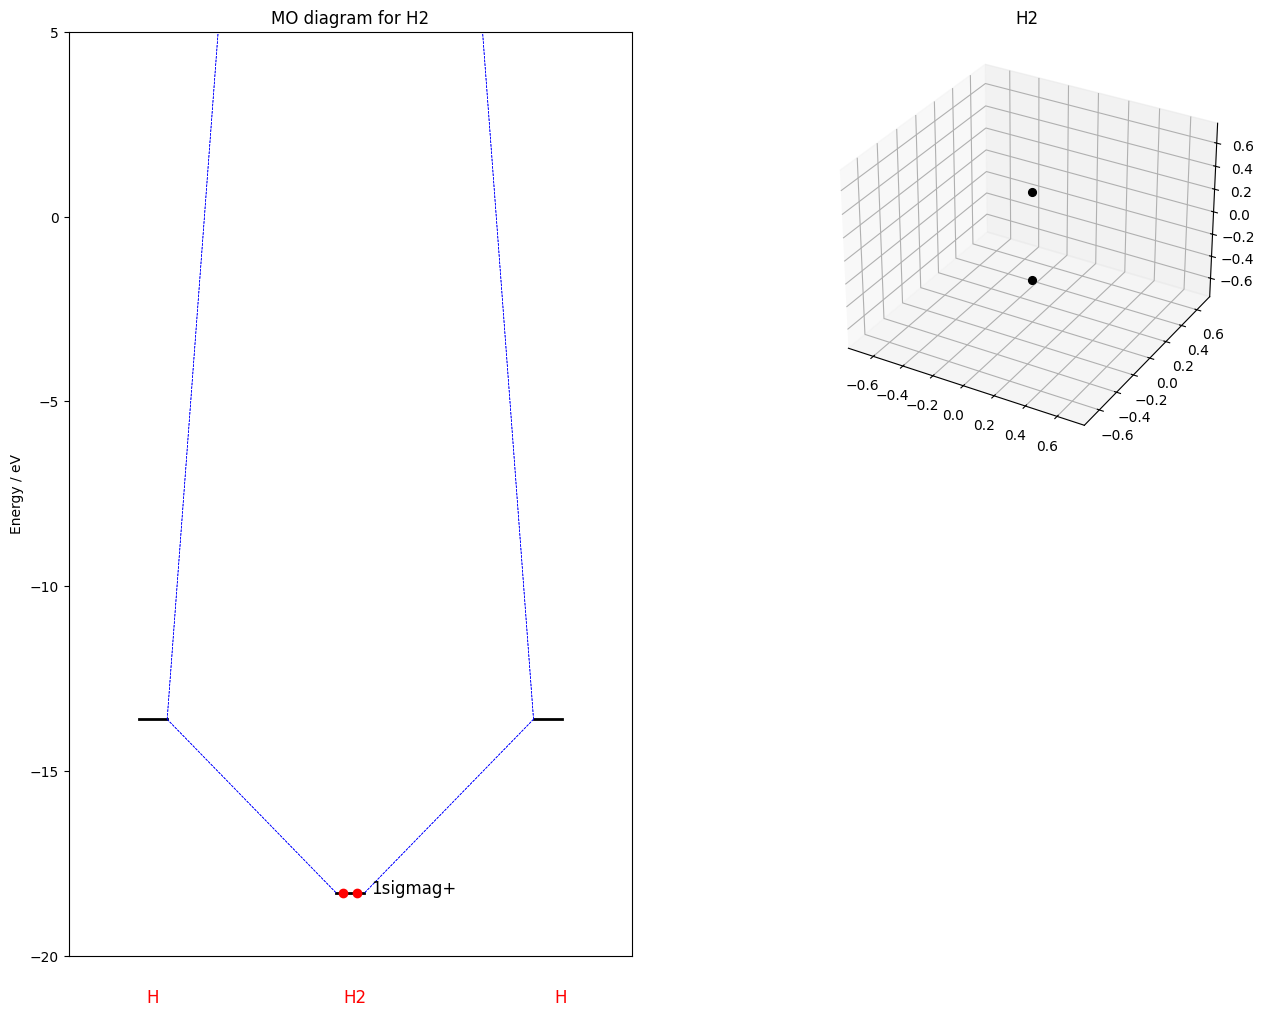

In [43]:
plot_MO=input("plot the MO diagram?  Y/N  ")
if plot_MO=='Y':
    molecule_from_list=False
    if create_molecule==2:    #load default values
        window=coords_dict[mol][5];connection_threshold=coords_dict[mol][6]
    elif create_molecule==1:
        window=[-20.,+20.];connection_threshold=0.4
    print("plotting a molecular orbital diagram:",'\n')
    print("current settings are:")
    print("%-20s"%("energy window from: "),window[0]," to ",window[1],'\n')
    if create_molecule==1:
        print("This is a guess - it will probably need to be adjusted to suite the positions of the frontier orbitals in your molecule. Carry on and look at your plot, then re-run this cell if you want to make an adjustment",'\n')
    print("%-20s"%("connection threshold: "),connection_threshold)
    change_MO_diagram=input("Do you want to change either of these parameters?  Y/N  ")
    while change_MO_diagram=='Y':
        print("the options to change are:  ")
        print("1  energy window")
        print("2  connection threshold")
        what_to_change_MO=int(input("what do you want to change? enter 1 or 2 "))
        if what_to_change_MO==1:
            new_window=input("input the lower and upper bounds of the new window: -10. 10. , for example ")
            window = [float(x) for x in new_window.split()]
            change_MO_diagram=input("do you want to change anything else?  Y/N  ")
        if what_to_change_MO==2:
            connection_threshold=float(input("input the value for connection threshold: 0.2, for example  "))
            change_MO_diagram=input("do you want to change anything else?  Y/N  ")
    MO_plot2(e,eh_basis_functs,C,occupations,title,atoms,coords,window,no_electrons,connection_threshold,revised_symmetry_list,pg_irreps,pg)

Plot contours of individual MOs

plot contours of some MOs?  Y/N  Y
plotting MOs:   0 1 

the full list of available MOs is (selected MOs in bold):

0     -18.31        2.0    sigmag+
1      48.10        0.0    sigmau-
Do you want to change this list?  Y/N  0 1


default plotting parameters are:                             

plot plane: current choice    xz
offset - shifts the plot plane up or down relative to axes:   0.0
contours values:     -2.00 -1.60 -1.20 -0.80 -0.40  0.00  0.40  0.80  1.20  1.60  2.00 

Do you want to change anything on this list?  Y/N  N




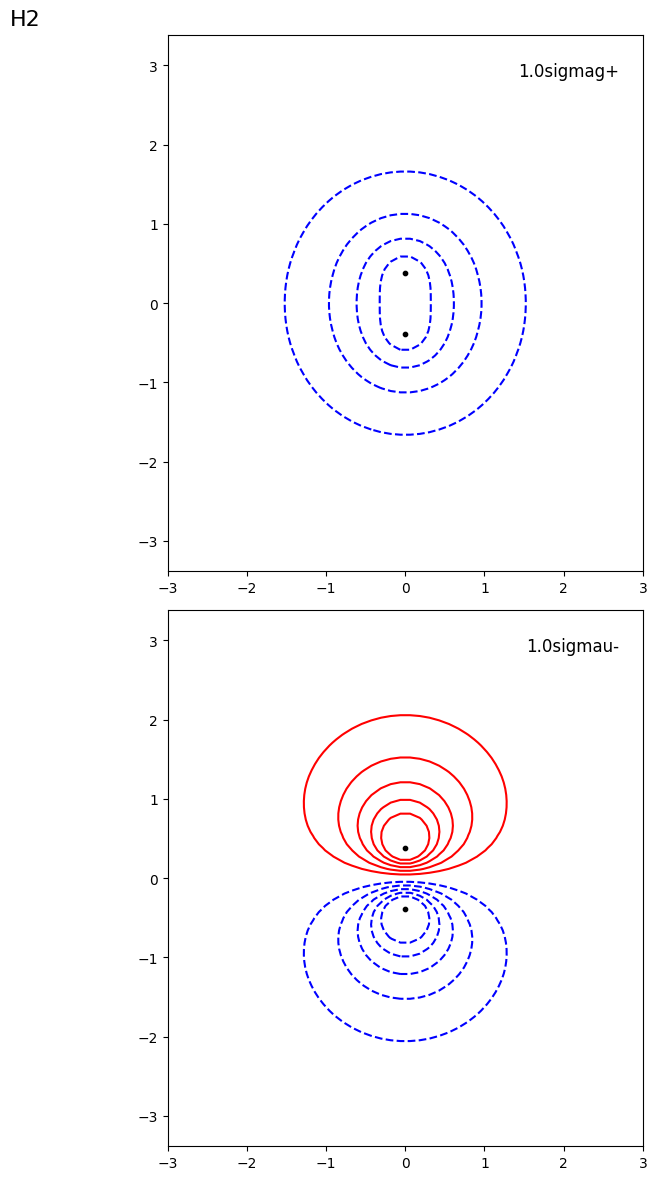

In [44]:
plot_contours=input("plot contours of some MOs?  Y/N  ")
class color:
    BOLD = '\033[1m'
    RED = '\033[91m'
    END = '\033[0m'

if plot_contours=='Y':
    if create_molecule==1:
        plane_offset=0.05;plot_plane='xz';levels=np.linspace(-0.5,0.5,10)
        print("The full list of available MOs is:"'\n')
        for i in range(len(e)):
            print(color.BOLD, end='')
            print(i,"%10.2f"%(e[i]),"%10.1f"%(occupations[i]),"% 10s"%(pg_irreps[pg][revised_symmetry_list[i]]))
            print(color.END, end='')
        MO_list=input("Type in a list of the molecular orbitals you would like to plot 0 1 4 6. for example - the count starts at zero for the lowest")
        MO_list=[int(x) for x in MO_list.split()]
    elif create_molecule==2:
        plane_offset=coords_dict[mol][7];MO_list=coords_dict[mol][4];levels=coords_dict[mol][8];plot_plane='xz'
    print("plotting MOs:  "," ".join(["%i"%(MO) for MO in MO_list]),'\n')
    print("the full list of available MOs is (selected MOs in bold):"'\n')
    for i in range(len(e)):
        if i in MO_list:
            print(color.BOLD, end='')
            print(i,"%10.2f"%(e[i]),"%10.1f"%(occupations[i]),"% 10s"%(pg_irreps[pg][revised_symmetry_list[i]]))
            print(color.END, end='')
        else:
            print(i,"%10.2f"%(e[i]),"%10.1f"%(occupations[i]),"% 10s"%(pg_irreps[pg][revised_symmetry_list[i]]))
    if len(MO_list)>len(e):
        print("Warning, the molecule does not have this many orbitals",'\n')
    change_orbitals=input("Do you want to change this list?  Y/N  ")
    print('\n')
    while change_orbitals=='Y':
        new_MO_temp=input("input a list of MOs identified by number, 0 2 4 etc. Don't forget to start at 0!  ")
        MO_list = [int(x) for x in new_MO_temp.split()]
        print('\n')
        print("updated list:"," ".join(["%i"%(MO) for MO in MO_list]))
        if len(MO_list)>len(e):
            print("Warning, the molecule does not have this many orbitals",'\n')
        change_orbitals=input("Do you want to change this list?  Y/N  ")

    print("%-60s"%("default plotting parameters are:  "),'\n')
    print("%-20s"%("plot plane: current choice   "),plot_plane)
    print("%-60s"%("offset - shifts the plot plane up or down relative to axes:  "),plane_offset)
    print("%-20s"%("contours values:  ")," ".join(["%5.2f"%(level) for level in levels]),'\n')

    change_parameters=input("Do you want to change anything on this list?  Y/N  ")
    print('\n')
    while change_parameters=='Y':
        print("the options to change are:  ",'\n')
        print("1  plot plane")
        print("2  offset")
        print("3  contour levels")
        print('\n')
        what_to_change=input("what do you want to change? enter 1, 2 or 3 ")
        what_to_change=int(what_to_change)
        print('\n')
        if what_to_change==1:
            new_plane=input("input the new plane: xz, yz or xy  ")
            if str(new_plane)=='xy':
                plot_plane='xy'
            elif str(new_plane)=='xz':
                plot_plane='xz'
            elif str(new_plane)=='yz':
                plot_plane='yz'
            print('\n')
            change_parameters=input("do you want to change anything else?  Y/N  ")
            print('\n')
        if what_to_change==2:
            offset=float(input("input the value for offset: 0.2, for example  "))
            print('\n')
            change_parameters=input("do you want to change anything else?  Y/N  ")
            print('\n')
        if what_to_change==3:
            new_levels=input("input a list of contour values: -0.2 -0.1 0.0 0.1 0.2, for example  ")
            levels = [float(x) for x in new_levels.split()]
            print('\n')
            change_parameters=input("do you want to change anything else?  Y/N  ")
            print('\n')

    MO_contour(e,eh_basis_functs,C,title,atoms,coords,MO_list,plane_offset,levels,plot_plane,revised_symmetry_list,pg_irreps,pg)